# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "4"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_HG00377_1_M_120209_6"
notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, "ERR204838_1.fastq.gz"), os.path.join(fastqs_dir, "ERR204838_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000483158:c.199G>C', 'ENST00000603423:c.344C>T', 'ENST00000285848:c.1043C>G', 'ENST00000339647:c.1158C>T', 'ENST00000354546:c.1236G>A', 'ENST00000332598:c.405T>C', 'ENST00000390319:c.99G>C', 'ENST00000353801:c.709G>A', 'ENST00000390299:c.228G>A', 'ENST00000343139:c.431A>C', 'ENST00000354689:c.83C>T', 'ENST00000258080:c.1497A>G', 'ENST00000603600:c.183A>C', 'ENST00000390243:c.506G>C', 'ENST00000390277:c.138G>A', 'ENST00000390270:c.213C>G', 'ENST00000579721:c.605C>T', 'ENST00000344063:c.865G>C', 'ENST00000603111:c.33G>T', 'ENST00000347559:c.952C>T', 'ENST00000288439:c.2648A>T', 'ENST00000390321:c.62C>T', 'ENST00000355731:c.36G>A', 'ENST00000604045:c.277C>T', 'ENST00000605716:c.288C>A', 'ENST00000468494:c.262A>G', 'ENST00000479981:c.138A>G', 'ENST00000390319:c.304C>T', 'ENST00000418115:c.934T>C', 'ENST00000374518:c.2777A>T', 'ENST00000353801:c.1652G>A', 'ENST00000390299:c.269G>A', 'ENST00000483158:c.195A>G', 'ENST00000338970:c.137A>G', 'ENST00000390237:c.19C>G', 'ENST00000361390:c

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,514680.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5685.0,0.0
58590,422549.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,14683.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
175099,896.0,ENST00000390309.2:c.319A>G,ENST00000390309:c.359A>G,ENST00000390309,ENSG00000211663,184.0,8520.0,0.0
128111,12005.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,None,183.0,NaN,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        disable_summarize=True,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,514680.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5685.0,0.0
58590,422549.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,14683.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
175099,896.0,ENST00000390309.2:c.319A>G,ENST00000390309:c.359A>G,ENST00000390309,ENSG00000211663,184.0,8520.0,0.0
128111,12005.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,None,183.0,NaN,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:43:22: Entering the loop


  0%|                                                                                                                                    | 0/301 [00:00<?, ?it/s]

  0%|▍                                                                                                                           | 1/301 [00:01<08:43,  1.75s/it]

  1%|▊                                                                                                                           | 2/301 [00:06<16:04,  3.23s/it]

  1%|█▏                                                                                                                          | 3/301 [00:10<18:19,  3.69s/it]

  1%|█▋                                                                                                                          | 4/301 [00:11<13:35,  2.74s/it]

  2%|██                                                                                                                          | 5/301 [00:14<14:41,  2.98s/it]

  2%|██▍                                                                                                                         | 6/301 [00:17<14:12,  2.89s/it]

  2%|██▉                                                                                                                         | 7/301 [00:19<11:46,  2.40s/it]

  3%|███▎                                                                                                                        | 8/301 [00:21<11:45,  2.41s/it]

  3%|███▋                                                                                                                        | 9/301 [00:23<11:46,  2.42s/it]

  3%|████                                                                                                                       | 10/301 [00:25<10:55,  2.25s/it]

  4%|████▍                                                                                                                      | 11/301 [00:27<10:00,  2.07s/it]

  4%|████▉                                                                                                                      | 12/301 [00:36<19:48,  4.11s/it]

  4%|█████▎                                                                                                                     | 13/301 [00:37<16:13,  3.38s/it]

  5%|█████▋                                                                                                                     | 14/301 [00:53<33:46,  7.06s/it]

  5%|██████▏                                                                                                                    | 15/301 [00:56<28:05,  5.89s/it]

  5%|██████▌                                                                                                                    | 16/301 [01:08<36:19,  7.65s/it]

  6%|██████▉                                                                                                                    | 17/301 [01:09<26:51,  5.67s/it]

  6%|███████▎                                                                                                                   | 18/301 [01:10<19:47,  4.20s/it]

  6%|███████▊                                                                                                                   | 19/301 [01:11<15:36,  3.32s/it]

  7%|████████▏                                                                                                                  | 20/301 [01:14<15:06,  3.23s/it]

  7%|████████▌                                                                                                                  | 21/301 [01:16<13:29,  2.89s/it]

  7%|████████▉                                                                                                                  | 22/301 [01:17<10:59,  2.36s/it]

  8%|█████████▍                                                                                                                 | 23/301 [01:18<09:16,  2.00s/it]

  8%|█████████▊                                                                                                                 | 24/301 [01:19<07:48,  1.69s/it]

  8%|██████████▏                                                                                                                | 25/301 [01:22<08:39,  1.88s/it]

  9%|██████████▌                                                                                                                | 26/301 [01:23<07:48,  1.70s/it]

  9%|███████████                                                                                                                | 27/301 [01:24<07:11,  1.58s/it]

  9%|███████████▍                                                                                                               | 28/301 [01:26<07:54,  1.74s/it]

 10%|███████████▊                                                                                                               | 29/301 [01:28<07:04,  1.56s/it]

 10%|████████████▎                                                                                                              | 30/301 [01:28<05:48,  1.29s/it]

 10%|████████████▋                                                                                                              | 31/301 [01:29<05:44,  1.28s/it]

 11%|█████████████                                                                                                              | 32/301 [01:31<05:42,  1.27s/it]

 11%|█████████████▍                                                                                                             | 33/301 [01:31<04:59,  1.12s/it]

 11%|█████████████▉                                                                                                             | 34/301 [01:32<04:21,  1.02it/s]

 12%|██████████████▎                                                                                                            | 35/301 [01:33<04:13,  1.05it/s]

 12%|██████████████▋                                                                                                            | 36/301 [01:35<05:34,  1.26s/it]

 12%|███████████████                                                                                                            | 37/301 [01:36<05:38,  1.28s/it]

 13%|███████████████▌                                                                                                           | 38/301 [01:37<04:47,  1.09s/it]

 13%|███████████████▉                                                                                                           | 39/301 [01:38<04:10,  1.05it/s]

 13%|████████████████▎                                                                                                          | 40/301 [01:39<04:03,  1.07it/s]

 14%|████████████████▊                                                                                                          | 41/301 [01:39<03:43,  1.17it/s]

 14%|█████████████████▏                                                                                                         | 42/301 [01:40<03:25,  1.26it/s]

 14%|█████████████████▌                                                                                                         | 43/301 [01:41<03:30,  1.23it/s]

 15%|█████████████████▉                                                                                                         | 44/301 [01:41<03:15,  1.32it/s]

 15%|██████████████████▍                                                                                                        | 45/301 [01:42<03:06,  1.38it/s]

 15%|██████████████████▊                                                                                                        | 46/301 [01:43<03:00,  1.41it/s]

 16%|███████████████████▏                                                                                                       | 47/301 [01:43<02:57,  1.43it/s]

 16%|███████████████████▌                                                                                                       | 48/301 [01:46<05:41,  1.35s/it]

 16%|████████████████████                                                                                                       | 49/301 [01:48<06:36,  1.57s/it]

 17%|████████████████████▍                                                                                                      | 50/301 [01:49<05:26,  1.30s/it]

 17%|████████████████████▊                                                                                                      | 51/301 [01:51<06:55,  1.66s/it]

 17%|█████████████████████▏                                                                                                     | 52/301 [01:52<05:57,  1.43s/it]

 18%|█████████████████████▋                                                                                                     | 53/301 [01:53<04:57,  1.20s/it]

 18%|██████████████████████                                                                                                     | 54/301 [01:54<04:17,  1.04s/it]

 18%|██████████████████████▍                                                                                                    | 55/301 [01:54<03:47,  1.08it/s]

 19%|██████████████████████▉                                                                                                    | 56/301 [01:55<03:35,  1.14it/s]

 19%|███████████████████████▎                                                                                                   | 57/301 [01:56<03:19,  1.22it/s]

 19%|███████████████████████▋                                                                                                   | 58/301 [01:58<04:49,  1.19s/it]

 20%|████████████████████████                                                                                                   | 59/301 [01:59<04:11,  1.04s/it]

 20%|████████████████████████▌                                                                                                  | 60/301 [01:59<03:49,  1.05it/s]

 20%|████████████████████████▉                                                                                                  | 61/301 [02:00<03:38,  1.10it/s]

 21%|█████████████████████████▎                                                                                                 | 62/301 [02:01<03:36,  1.10it/s]

 21%|█████████████████████████▋                                                                                                 | 63/301 [02:02<03:32,  1.12it/s]

 21%|██████████████████████████▏                                                                                                | 64/301 [02:03<03:14,  1.22it/s]

 22%|██████████████████████████▌                                                                                                | 65/301 [02:03<03:08,  1.25it/s]

 22%|██████████████████████████▉                                                                                                | 66/301 [02:04<03:13,  1.21it/s]

 22%|███████████████████████████▍                                                                                               | 67/301 [02:05<03:03,  1.27it/s]

 23%|███████████████████████████▊                                                                                               | 68/301 [02:06<03:09,  1.23it/s]

 23%|████████████████████████████▏                                                                                              | 69/301 [02:07<03:10,  1.22it/s]

 23%|████████████████████████████▌                                                                                              | 70/301 [02:07<03:01,  1.27it/s]

 24%|█████████████████████████████                                                                                              | 71/301 [02:08<03:19,  1.15it/s]

 24%|█████████████████████████████▍                                                                                             | 72/301 [02:09<03:06,  1.23it/s]

 24%|█████████████████████████████▊                                                                                             | 73/301 [02:10<03:07,  1.22it/s]

 25%|██████████████████████████████▏                                                                                            | 74/301 [02:11<03:41,  1.02it/s]

 25%|██████████████████████████████▋                                                                                            | 75/301 [02:12<03:26,  1.09it/s]

 25%|███████████████████████████████                                                                                            | 76/301 [02:13<03:07,  1.20it/s]

 26%|███████████████████████████████▍                                                                                           | 77/301 [02:13<02:55,  1.28it/s]

 26%|███████████████████████████████▊                                                                                           | 78/301 [02:15<03:30,  1.06it/s]

 26%|████████████████████████████████▎                                                                                          | 79/301 [02:16<03:41,  1.00it/s]

 27%|████████████████████████████████▋                                                                                          | 80/301 [02:17<04:00,  1.09s/it]

 27%|█████████████████████████████████                                                                                          | 81/301 [02:18<04:10,  1.14s/it]

 27%|█████████████████████████████████▌                                                                                         | 82/301 [02:19<03:39,  1.00s/it]

 28%|█████████████████████████████████▉                                                                                         | 83/301 [02:20<03:44,  1.03s/it]

 28%|██████████████████████████████████▎                                                                                        | 84/301 [02:21<03:21,  1.08it/s]

 28%|██████████████████████████████████▋                                                                                        | 85/301 [02:21<03:02,  1.18it/s]

 29%|███████████████████████████████████▏                                                                                       | 86/301 [02:22<02:58,  1.20it/s]

 29%|███████████████████████████████████▌                                                                                       | 87/301 [02:23<02:46,  1.28it/s]

 29%|███████████████████████████████████▉                                                                                       | 88/301 [02:24<02:39,  1.34it/s]

 30%|████████████████████████████████████▎                                                                                      | 89/301 [02:24<02:44,  1.29it/s]

 30%|████████████████████████████████████▊                                                                                      | 90/301 [02:26<03:22,  1.04it/s]

 30%|█████████████████████████████████████▏                                                                                     | 91/301 [02:26<03:02,  1.15it/s]

 31%|█████████████████████████████████████▌                                                                                     | 92/301 [02:28<03:27,  1.01it/s]

 31%|██████████████████████████████████████                                                                                     | 93/301 [02:29<03:53,  1.12s/it]

 31%|██████████████████████████████████████▍                                                                                    | 94/301 [02:30<04:08,  1.20s/it]

 32%|██████████████████████████████████████▊                                                                                    | 95/301 [02:33<05:18,  1.55s/it]

 32%|███████████████████████████████████████▏                                                                                   | 96/301 [02:34<05:23,  1.58s/it]

 32%|███████████████████████████████████████▋                                                                                   | 97/301 [02:37<05:54,  1.74s/it]

 33%|████████████████████████████████████████                                                                                   | 98/301 [02:37<04:47,  1.42s/it]

 33%|████████████████████████████████████████▍                                                                                  | 99/301 [02:39<04:46,  1.42s/it]

 33%|████████████████████████████████████████▌                                                                                 | 100/301 [02:39<04:04,  1.21s/it]

 34%|████████████████████████████████████████▉                                                                                 | 101/301 [02:40<03:29,  1.05s/it]

 34%|█████████████████████████████████████████▎                                                                                | 102/301 [02:41<03:20,  1.01s/it]

 34%|█████████████████████████████████████████▋                                                                                | 103/301 [02:42<03:35,  1.09s/it]

 35%|██████████████████████████████████████████▏                                                                               | 104/301 [02:44<03:53,  1.19s/it]

 35%|██████████████████████████████████████████▌                                                                               | 105/301 [02:45<03:31,  1.08s/it]

 35%|██████████████████████████████████████████▉                                                                               | 106/301 [02:46<03:26,  1.06s/it]

 36%|███████████████████████████████████████████▎                                                                              | 107/301 [02:46<03:04,  1.05it/s]

 36%|███████████████████████████████████████████▊                                                                              | 108/301 [02:47<02:47,  1.15it/s]

 36%|████████████████████████████████████████████▏                                                                             | 109/301 [02:48<03:20,  1.04s/it]

 37%|████████████████████████████████████████████▌                                                                             | 110/301 [02:49<02:56,  1.08it/s]

 37%|████████████████████████████████████████████▉                                                                             | 111/301 [02:50<02:41,  1.18it/s]

 37%|█████████████████████████████████████████████▍                                                                            | 112/301 [02:50<02:29,  1.26it/s]

 38%|█████████████████████████████████████████████▊                                                                            | 113/301 [02:52<02:55,  1.07it/s]

 38%|██████████████████████████████████████████████▏                                                                           | 114/301 [02:52<02:40,  1.17it/s]

 38%|██████████████████████████████████████████████▌                                                                           | 115/301 [02:54<03:12,  1.03s/it]

 39%|███████████████████████████████████████████████                                                                           | 116/301 [02:54<02:51,  1.08it/s]

 39%|███████████████████████████████████████████████▍                                                                          | 117/301 [02:55<02:35,  1.19it/s]

 39%|███████████████████████████████████████████████▊                                                                          | 118/301 [02:56<02:24,  1.27it/s]

 40%|████████████████████████████████████████████████▏                                                                         | 119/301 [02:56<02:22,  1.28it/s]

 40%|████████████████████████████████████████████████▋                                                                         | 120/301 [02:57<02:17,  1.31it/s]

 40%|█████████████████████████████████████████████████                                                                         | 121/301 [02:58<02:22,  1.26it/s]

 41%|█████████████████████████████████████████████████▍                                                                        | 122/301 [02:59<02:13,  1.34it/s]

 41%|█████████████████████████████████████████████████▊                                                                        | 123/301 [02:59<02:09,  1.38it/s]

 41%|██████████████████████████████████████████████████▎                                                                       | 124/301 [03:01<02:42,  1.09it/s]

 42%|██████████████████████████████████████████████████▋                                                                       | 125/301 [03:01<02:28,  1.18it/s]

 42%|███████████████████████████████████████████████████                                                                       | 126/301 [03:02<02:17,  1.27it/s]

 42%|███████████████████████████████████████████████████▍                                                                      | 127/301 [03:03<02:08,  1.35it/s]

 43%|███████████████████████████████████████████████████▉                                                                      | 128/301 [03:03<02:04,  1.39it/s]

 43%|████████████████████████████████████████████████████▎                                                                     | 129/301 [03:04<02:01,  1.41it/s]

 43%|████████████████████████████████████████████████████▋                                                                     | 130/301 [03:05<01:58,  1.44it/s]

 44%|█████████████████████████████████████████████████████                                                                     | 131/301 [03:06<02:09,  1.32it/s]

 44%|█████████████████████████████████████████████████████▌                                                                    | 132/301 [03:06<02:03,  1.37it/s]

 44%|█████████████████████████████████████████████████████▉                                                                    | 133/301 [03:08<02:30,  1.12it/s]

 45%|██████████████████████████████████████████████████████▎                                                                   | 134/301 [03:08<02:17,  1.21it/s]

 45%|██████████████████████████████████████████████████████▋                                                                   | 135/301 [03:09<02:11,  1.27it/s]

 45%|███████████████████████████████████████████████████████                                                                   | 136/301 [03:10<02:05,  1.31it/s]

 46%|███████████████████████████████████████████████████████▌                                                                  | 137/301 [03:10<01:59,  1.38it/s]

 46%|███████████████████████████████████████████████████████▉                                                                  | 138/301 [03:12<02:25,  1.12it/s]

 46%|████████████████████████████████████████████████████████▎                                                                 | 139/301 [03:13<02:33,  1.05it/s]

 47%|████████████████████████████████████████████████████████▋                                                                 | 140/301 [03:14<02:51,  1.07s/it]

 47%|█████████████████████████████████████████████████████████▏                                                                | 141/301 [03:15<02:30,  1.06it/s]

 47%|█████████████████████████████████████████████████████████▌                                                                | 142/301 [03:15<02:17,  1.16it/s]

 48%|█████████████████████████████████████████████████████████▉                                                                | 143/301 [03:16<02:07,  1.24it/s]

 48%|██████████████████████████████████████████████████████████▎                                                               | 144/301 [03:17<02:11,  1.19it/s]

 48%|██████████████████████████████████████████████████████████▊                                                               | 145/301 [03:18<02:13,  1.17it/s]

 49%|███████████████████████████████████████████████████████████▏                                                              | 146/301 [03:18<02:02,  1.26it/s]

 49%|███████████████████████████████████████████████████████████▌                                                              | 147/301 [03:19<01:55,  1.34it/s]

 49%|███████████████████████████████████████████████████████████▉                                                              | 148/301 [03:20<01:50,  1.39it/s]

 50%|████████████████████████████████████████████████████████████▍                                                             | 149/301 [03:20<01:47,  1.41it/s]

 50%|████████████████████████████████████████████████████████████▊                                                             | 150/301 [03:21<01:47,  1.40it/s]

 50%|█████████████████████████████████████████████████████████████▏                                                            | 151/301 [03:22<01:47,  1.40it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                            | 152/301 [03:23<01:46,  1.40it/s]

 51%|██████████████████████████████████████████████████████████████                                                            | 153/301 [03:23<01:42,  1.44it/s]

 51%|██████████████████████████████████████████████████████████████▍                                                           | 154/301 [03:24<01:40,  1.47it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                           | 155/301 [03:25<01:38,  1.48it/s]

 52%|███████████████████████████████████████████████████████████████▏                                                          | 156/301 [03:25<01:48,  1.34it/s]

 52%|███████████████████████████████████████████████████████████████▋                                                          | 157/301 [03:26<01:43,  1.39it/s]

 52%|████████████████████████████████████████████████████████████████                                                          | 158/301 [03:27<02:06,  1.13it/s]

 53%|████████████████████████████████████████████████████████████████▍                                                         | 159/301 [03:29<02:37,  1.11s/it]

 53%|████████████████████████████████████████████████████████████████▊                                                         | 160/301 [03:30<02:16,  1.03it/s]

 53%|█████████████████████████████████████████████████████████████████▎                                                        | 161/301 [03:30<02:03,  1.13it/s]

 54%|█████████████████████████████████████████████████████████████████▋                                                        | 162/301 [03:31<01:53,  1.23it/s]

 54%|██████████████████████████████████████████████████████████████████                                                        | 163/301 [03:32<01:46,  1.29it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                       | 164/301 [03:32<01:41,  1.35it/s]

 55%|██████████████████████████████████████████████████████████████████▉                                                       | 165/301 [03:33<01:39,  1.37it/s]

 55%|███████████████████████████████████████████████████████████████████▎                                                      | 166/301 [03:34<01:36,  1.39it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                      | 167/301 [03:34<01:33,  1.43it/s]

 56%|████████████████████████████████████████████████████████████████████                                                      | 168/301 [03:35<01:39,  1.33it/s]

 56%|████████████████████████████████████████████████████████████████████▍                                                     | 169/301 [03:41<04:47,  2.18s/it]

 56%|████████████████████████████████████████████████████████████████████▉                                                     | 170/301 [03:41<03:46,  1.73s/it]

 57%|█████████████████████████████████████████████████████████████████████▎                                                    | 171/301 [03:43<03:23,  1.57s/it]

 57%|█████████████████████████████████████████████████████████████████████▋                                                    | 172/301 [03:43<02:47,  1.30s/it]

 57%|██████████████████████████████████████████████████████████████████████                                                    | 173/301 [03:47<04:10,  1.96s/it]

 58%|██████████████████████████████████████████████████████████████████████▌                                                   | 174/301 [03:49<03:59,  1.89s/it]

 58%|██████████████████████████████████████████████████████████████████████▉                                                   | 175/301 [03:50<03:34,  1.70s/it]

 58%|███████████████████████████████████████████████████████████████████████▎                                                  | 176/301 [03:51<03:01,  1.45s/it]

 59%|███████████████████████████████████████████████████████████████████████▋                                                  | 177/301 [03:52<03:07,  1.51s/it]

 59%|████████████████████████████████████████████████████████████████████████▏                                                 | 178/301 [03:53<02:33,  1.25s/it]

 59%|████████████████████████████████████████████████████████████████████████▌                                                 | 179/301 [03:54<02:11,  1.08s/it]

 60%|████████████████████████████████████████████████████████████████████████▉                                                 | 180/301 [03:54<01:54,  1.05it/s]

 60%|█████████████████████████████████████████████████████████████████████████▎                                                | 181/301 [03:56<02:07,  1.06s/it]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                | 182/301 [04:00<04:21,  2.20s/it]

 61%|██████████████████████████████████████████████████████████████████████████▏                                               | 183/301 [04:01<03:38,  1.86s/it]

 61%|██████████████████████████████████████████████████████████████████████████▌                                               | 184/301 [04:13<09:13,  4.73s/it]

 61%|██████████████████████████████████████████████████████████████████████████▉                                               | 185/301 [04:14<07:10,  3.71s/it]

 62%|███████████████████████████████████████████████████████████████████████████▍                                              | 186/301 [04:16<05:56,  3.10s/it]

 62%|███████████████████████████████████████████████████████████████████████████▊                                              | 187/301 [04:17<04:58,  2.62s/it]

 62%|████████████████████████████████████████████████████████████████████████████▏                                             | 188/301 [04:18<03:51,  2.05s/it]

 63%|████████████████████████████████████████████████████████████████████████████▌                                             | 189/301 [04:19<03:02,  1.63s/it]

 63%|█████████████████████████████████████████████████████████████████████████████                                             | 190/301 [04:20<02:41,  1.45s/it]

 63%|█████████████████████████████████████████████████████████████████████████████▍                                            | 191/301 [04:21<02:13,  1.21s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▊                                            | 192/301 [04:21<01:53,  1.04s/it]

 64%|██████████████████████████████████████████████████████████████████████████████▏                                           | 193/301 [04:22<01:39,  1.08it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▋                                           | 194/301 [04:22<01:30,  1.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████                                           | 195/301 [04:23<01:23,  1.27it/s]

 65%|███████████████████████████████████████████████████████████████████████████████▍                                          | 196/301 [04:24<01:18,  1.34it/s]

 65%|███████████████████████████████████████████████████████████████████████████████▊                                          | 197/301 [04:24<01:16,  1.36it/s]

 66%|████████████████████████████████████████████████████████████████████████████████▎                                         | 198/301 [04:25<01:21,  1.27it/s]

 66%|████████████████████████████████████████████████████████████████████████████████▋                                         | 199/301 [04:26<01:17,  1.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████                                         | 200/301 [04:27<01:13,  1.38it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████▍                                        | 201/301 [04:27<01:10,  1.42it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████▊                                        | 202/301 [04:28<01:07,  1.46it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▎                                       | 203/301 [04:29<01:05,  1.49it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▋                                       | 204/301 [04:29<01:05,  1.49it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████                                       | 205/301 [04:30<01:10,  1.37it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▍                                      | 206/301 [04:31<01:07,  1.41it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▉                                      | 207/301 [04:32<01:05,  1.43it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▎                                     | 208/301 [04:32<01:04,  1.45it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▋                                     | 209/301 [04:33<01:02,  1.47it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████                                     | 210/301 [04:34<01:01,  1.49it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████▌                                    | 211/301 [04:34<01:06,  1.35it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████▉                                    | 212/301 [04:35<01:08,  1.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████▎                                   | 213/301 [04:36<01:13,  1.20it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████▋                                   | 214/301 [04:37<01:07,  1.29it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▏                                  | 215/301 [04:38<01:03,  1.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████▌                                  | 216/301 [04:38<01:00,  1.39it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████▉                                  | 217/301 [04:39<01:14,  1.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▎                                 | 218/301 [04:40<01:07,  1.22it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                 | 219/301 [04:41<01:09,  1.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▏                                | 220/301 [04:42<01:04,  1.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▌                                | 221/301 [04:42<01:00,  1.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                                | 222/301 [04:43<00:57,  1.38it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████▍                               | 223/301 [04:44<01:00,  1.29it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████▊                               | 224/301 [04:45<00:57,  1.33it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                              | 225/301 [04:45<00:55,  1.37it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 226/301 [04:46<00:53,  1.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████                              | 227/301 [04:47<00:51,  1.44it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████▍                             | 228/301 [04:47<00:49,  1.47it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████▊                             | 229/301 [04:48<00:48,  1.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                            | 230/301 [04:49<00:48,  1.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████▋                            | 231/301 [04:49<00:46,  1.50it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████                            | 232/301 [04:50<00:46,  1.50it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▍                           | 233/301 [04:51<00:45,  1.51it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                           | 234/301 [04:51<00:44,  1.49it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▏                          | 235/301 [04:52<00:44,  1.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                          | 236/301 [04:53<00:43,  1.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████                          | 237/301 [04:53<00:46,  1.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 238/301 [04:54<00:44,  1.41it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 239/301 [04:55<00:43,  1.44it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 240/301 [04:55<00:41,  1.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 241/301 [04:56<00:40,  1.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                        | 242/301 [04:57<00:39,  1.50it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 243/301 [04:57<00:38,  1.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 244/301 [04:58<00:37,  1.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 245/301 [04:59<00:37,  1.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 246/301 [05:10<03:31,  3.85s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████                      | 247/301 [05:11<02:36,  2.89s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 248/301 [05:11<01:57,  2.21s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 249/301 [05:12<01:30,  1.75s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 250/301 [05:13<01:12,  1.41s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 251/301 [05:13<00:59,  1.19s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 252/301 [05:14<00:50,  1.02s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 253/301 [05:15<00:43,  1.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 254/301 [05:15<00:39,  1.20it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 255/301 [05:16<00:36,  1.26it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 256/301 [05:17<00:33,  1.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 257/301 [05:18<00:39,  1.10it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 258/301 [05:19<00:43,  1.02s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 259/301 [05:20<00:45,  1.09s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 260/301 [05:22<00:56,  1.38s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 261/301 [05:24<00:54,  1.37s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 262/301 [05:25<00:53,  1.38s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 263/301 [05:26<00:51,  1.35s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████               | 264/301 [05:28<00:49,  1.34s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 265/301 [05:29<00:47,  1.32s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 266/301 [05:34<01:24,  2.43s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 267/301 [05:35<01:04,  1.89s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 268/301 [05:35<00:50,  1.52s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 269/301 [05:36<00:40,  1.25s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 270/301 [05:37<00:33,  1.08s/it]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 271/301 [05:37<00:28,  1.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 272/301 [05:38<00:26,  1.10it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 273/301 [05:39<00:28,  1.02s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 274/301 [05:40<00:24,  1.09it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 275/301 [05:41<00:21,  1.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 276/301 [05:42<00:22,  1.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 277/301 [05:42<00:20,  1.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 278/301 [05:43<00:18,  1.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 279/301 [05:44<00:16,  1.35it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 280/301 [05:44<00:15,  1.40it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 281/301 [05:45<00:13,  1.44it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 282/301 [05:46<00:16,  1.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 283/301 [05:47<00:14,  1.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 284/301 [05:48<00:12,  1.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 285/301 [05:48<00:11,  1.35it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 286/301 [05:49<00:10,  1.40it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 287/301 [05:50<00:09,  1.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 288/301 [05:50<00:08,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 289/301 [05:51<00:08,  1.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 290/301 [05:52<00:07,  1.49it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 291/301 [05:53<00:08,  1.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 292/301 [05:54<00:07,  1.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 293/301 [05:54<00:05,  1.34it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 294/301 [05:55<00:05,  1.40it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 295/301 [05:56<00:04,  1.42it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 296/301 [05:57<00:04,  1.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/301 [05:58<00:02,  1.46it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 299/301 [05:58<00:01,  1.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 300/301 [05:59<00:00,  1.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [06:00<00:00,  1.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [06:00<00:00,  1.20s/it]

In [13]:
!cat {overall_txt_out}

Number of true variants: 211
Number of false variants: 88
Number of undetermined variants: 1
True variants list: ['ENST00000390312:c.218G>A', 'ENST00000579721:c.142G>A', 'ENST00000603423:c.137G>A', 'ENST00000390309:c.359A>G', 'ENST00000603600:c.285G>A', 'ENST00000604412:c.415T>A', 'ENST00000483158:c.199G>C', 'ENST00000453673:c.105G>A', 'ENST00000390634:c.191C>T', 'ENST00000390309:c.195G>A', 'ENST00000603344:c.296T>G', 'ENST00000604930:c.373G>A', 'ENST00000390290:c.183G>A', 'ENST00000390319:c.261G>A', 'ENST00000390290:c.299G>A', 'ENST00000390319:c.197A>G', 'ENST00000390305:c.182C>T', 'ENST00000390299:c.228G>A', 'ENST00000390299:c.269G>A', 'ENST00000390243:c.300A>G', 'ENST00000605716:c.222G>T', 'ENST00000468494:c.262A>G', 'ENST00000483158:c.195A>G', 'ENST00000354689:c.83C>T', 'ENST00000483379:c.462C>T', 'ENST00000603600:c.205C>A', 'ENST00000604045:c.277C>T', 'ENST00000390319:c.99G>C', 'ENST00000390237:c.249G>C', 'ENST00000495489:c.196G>A', 'ENST00000390237:c.132A>G', 'ENST00000390237:c.6

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/detailed_out_modified_bam.txt


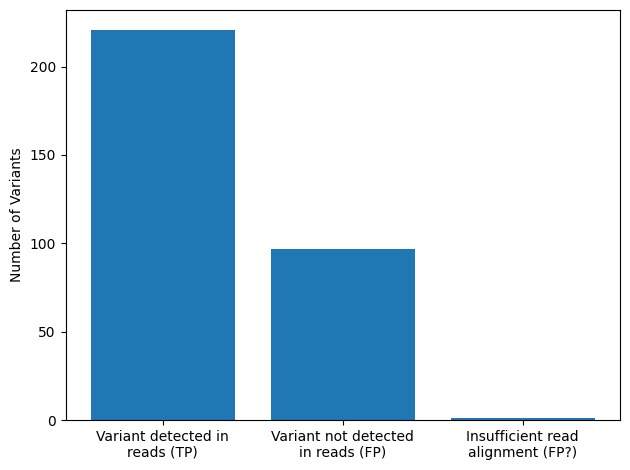

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

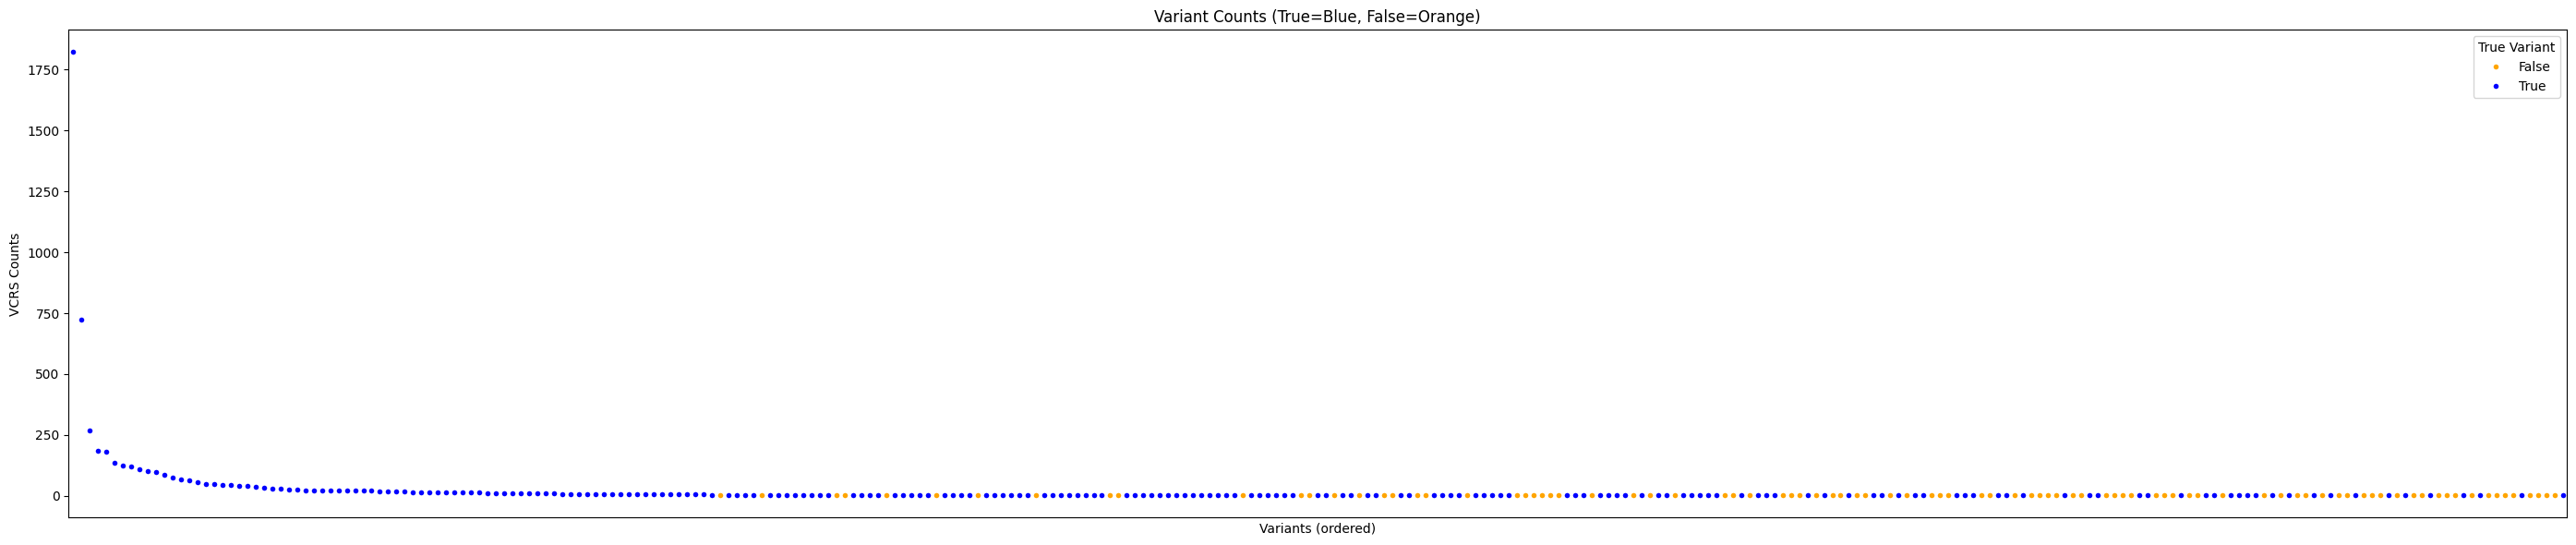

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

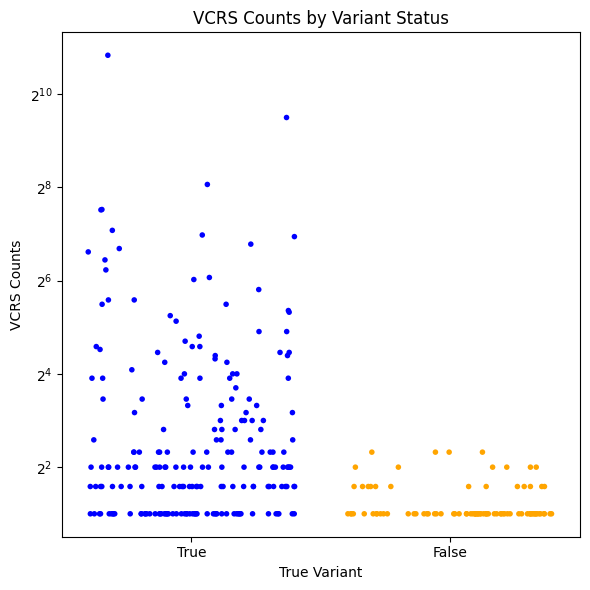

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('True Variant')
plt.ylabel('VCRS Counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('VCRS Counts by Variant Status')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: set()


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs28507236,ENST00000379407,c.528A>C,+,ENST00000379407:c.528A>C,True,vcrs_0
1,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_1
2,rs3829739,ENST00000379407,c.1389A>G,+,ENST00000379407:c.1389A>G,True,vcrs_2
3,rs12184,ENST00000378567,c.425T>C,+,ENST00000378567:c.425T>C,True,vcrs_3
4,rs41315312,ENST00000294600,c.211C>T,+,ENST00000294600:c.211C>T,True,vcrs_4


In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:49:49: Entering the loop


  0%|                                                                                                                                   | 0/3273 [00:00<?, ?it/s]

  0%|                                                                                                                         | 1/3273 [00:01<1:04:17,  1.18s/it]

  0%|                                                                                                                           | 2/3273 [00:01<47:35,  1.15it/s]

  0%|                                                                                                                           | 3/3273 [00:02<41:48,  1.30it/s]

  0%|▏                                                                                                                          | 4/3273 [00:03<46:21,  1.18it/s]

  0%|▏                                                                                                                        | 5/3273 [00:09<2:33:55,  2.83s/it]

  0%|▏                                                                                                                        | 6/3273 [00:10<1:53:49,  2.09s/it]

  0%|▎                                                                                                                        | 7/3273 [00:11<1:28:05,  1.62s/it]

  0%|▎                                                                                                                        | 8/3273 [00:11<1:11:58,  1.32s/it]

  0%|▎                                                                                                                        | 9/3273 [00:12<1:00:54,  1.12s/it]

  0%|▎                                                                                                                         | 10/3273 [00:13<53:09,  1.02it/s]

  0%|▍                                                                                                                         | 11/3273 [00:13<48:08,  1.13it/s]

  0%|▍                                                                                                                         | 12/3273 [00:14<44:37,  1.22it/s]

  0%|▍                                                                                                                         | 13/3273 [00:15<42:06,  1.29it/s]

  0%|▌                                                                                                                         | 14/3273 [00:15<40:44,  1.33it/s]

  0%|▌                                                                                                                         | 15/3273 [00:16<39:15,  1.38it/s]

  0%|▌                                                                                                                         | 16/3273 [00:17<38:56,  1.39it/s]

  1%|▋                                                                                                                         | 17/3273 [00:17<37:48,  1.44it/s]

  1%|▋                                                                                                                         | 18/3273 [00:19<46:43,  1.16it/s]

  1%|▋                                                                                                                         | 19/3273 [00:19<43:46,  1.24it/s]

  1%|▋                                                                                                                         | 20/3273 [00:20<41:23,  1.31it/s]

  1%|▊                                                                                                                         | 21/3273 [00:21<40:27,  1.34it/s]

  1%|▊                                                                                                                         | 22/3273 [00:21<38:38,  1.40it/s]

  1%|▊                                                                                                                         | 23/3273 [00:22<37:40,  1.44it/s]

  1%|▉                                                                                                                         | 24/3273 [00:23<37:17,  1.45it/s]

  1%|▉                                                                                                                         | 25/3273 [00:23<36:32,  1.48it/s]

  1%|▉                                                                                                                         | 26/3273 [00:24<37:11,  1.46it/s]

  1%|█                                                                                                                         | 27/3273 [00:25<36:40,  1.47it/s]

  1%|█                                                                                                                         | 28/3273 [00:26<43:30,  1.24it/s]

  1%|█                                                                                                                         | 29/3273 [00:27<43:51,  1.23it/s]

  1%|█                                                                                                                         | 30/3273 [00:27<41:23,  1.31it/s]

  1%|█▏                                                                                                                        | 31/3273 [00:28<39:44,  1.36it/s]

  1%|█▏                                                                                                                        | 32/3273 [00:29<38:26,  1.41it/s]

  1%|█▏                                                                                                                        | 33/3273 [00:29<37:49,  1.43it/s]

  1%|█▎                                                                                                                        | 34/3273 [00:30<37:06,  1.45it/s]

  1%|█▎                                                                                                                        | 35/3273 [00:30<36:20,  1.49it/s]

  1%|█▎                                                                                                                        | 36/3273 [00:31<37:17,  1.45it/s]

  1%|█▍                                                                                                                        | 37/3273 [00:32<36:44,  1.47it/s]

  1%|█▍                                                                                                                        | 38/3273 [00:33<36:31,  1.48it/s]

  1%|█▍                                                                                                                        | 39/3273 [00:33<36:01,  1.50it/s]

  1%|█▍                                                                                                                        | 40/3273 [00:34<36:03,  1.49it/s]

  1%|█▌                                                                                                                        | 41/3273 [00:35<35:38,  1.51it/s]

  1%|█▌                                                                                                                        | 42/3273 [00:35<35:45,  1.51it/s]

  1%|█▌                                                                                                                        | 43/3273 [00:36<35:26,  1.52it/s]

  1%|█▋                                                                                                                        | 44/3273 [00:36<35:06,  1.53it/s]

  1%|█▋                                                                                                                        | 45/3273 [00:37<35:10,  1.53it/s]

  1%|█▋                                                                                                                        | 46/3273 [00:38<34:53,  1.54it/s]

  1%|█▊                                                                                                                        | 47/3273 [00:38<34:41,  1.55it/s]

  1%|█▊                                                                                                                        | 48/3273 [00:39<34:41,  1.55it/s]

  1%|█▊                                                                                                                        | 49/3273 [00:40<34:55,  1.54it/s]

  2%|█▊                                                                                                                        | 50/3273 [00:40<34:44,  1.55it/s]

  2%|█▉                                                                                                                        | 51/3273 [00:41<34:51,  1.54it/s]

  2%|█▉                                                                                                                        | 52/3273 [00:42<35:59,  1.49it/s]

  2%|█▉                                                                                                                        | 53/3273 [00:42<36:31,  1.47it/s]

  2%|██                                                                                                                        | 54/3273 [00:43<36:24,  1.47it/s]

  2%|██                                                                                                                        | 55/3273 [00:44<35:55,  1.49it/s]

  2%|██                                                                                                                        | 56/3273 [00:44<36:48,  1.46it/s]

  2%|██                                                                                                                        | 57/3273 [00:45<36:27,  1.47it/s]

  2%|██▏                                                                                                                       | 58/3273 [00:46<36:13,  1.48it/s]

  2%|██▏                                                                                                                       | 59/3273 [00:46<35:57,  1.49it/s]

  2%|██▏                                                                                                                       | 60/3273 [00:47<35:25,  1.51it/s]

  2%|██▎                                                                                                                       | 62/3273 [00:48<27:02,  1.98it/s]

  2%|██▎                                                                                                                       | 63/3273 [00:48<28:51,  1.85it/s]

  2%|██▍                                                                                                                       | 64/3273 [00:49<34:11,  1.56it/s]

  2%|██▍                                                                                                                       | 65/3273 [00:50<34:48,  1.54it/s]

  2%|██▍                                                                                                                       | 67/3273 [00:51<28:04,  1.90it/s]

  2%|██▌                                                                                                                       | 68/3273 [00:51<29:35,  1.80it/s]

  2%|██▌                                                                                                                       | 69/3273 [00:52<30:57,  1.72it/s]

  2%|██▌                                                                                                                       | 70/3273 [00:53<32:03,  1.67it/s]

  2%|██▋                                                                                                                       | 71/3273 [00:53<32:43,  1.63it/s]

  2%|██▋                                                                                                                       | 72/3273 [00:54<33:27,  1.59it/s]

  2%|██▋                                                                                                                       | 73/3273 [00:55<34:25,  1.55it/s]

  2%|██▋                                                                                                                     | 74/3273 [00:57<1:07:06,  1.26s/it]

  2%|██▋                                                                                                                     | 75/3273 [00:59<1:08:10,  1.28s/it]

  2%|██▊                                                                                                                     | 77/3273 [01:01<1:09:09,  1.30s/it]

  2%|██▊                                                                                                                     | 78/3273 [01:02<1:00:19,  1.13s/it]

  2%|██▉                                                                                                                       | 79/3273 [01:03<53:58,  1.01s/it]

  2%|██▉                                                                                                                       | 80/3273 [01:03<49:44,  1.07it/s]

  2%|███                                                                                                                       | 81/3273 [01:04<45:52,  1.16it/s]

  3%|███                                                                                                                       | 82/3273 [01:05<47:39,  1.12it/s]

  3%|███                                                                                                                       | 83/3273 [01:06<43:36,  1.22it/s]

  3%|███▏                                                                                                                      | 84/3273 [01:06<40:56,  1.30it/s]

  3%|███▏                                                                                                                      | 85/3273 [01:07<38:56,  1.36it/s]

  3%|███▏                                                                                                                      | 86/3273 [01:08<39:59,  1.33it/s]

  3%|███▏                                                                                                                      | 87/3273 [01:08<38:06,  1.39it/s]

  3%|███▎                                                                                                                      | 88/3273 [01:09<38:18,  1.39it/s]

  3%|███▎                                                                                                                      | 89/3273 [01:10<37:05,  1.43it/s]

  3%|███▎                                                                                                                      | 90/3273 [01:10<36:30,  1.45it/s]

  3%|███▍                                                                                                                      | 91/3273 [01:11<35:49,  1.48it/s]

  3%|███▍                                                                                                                      | 92/3273 [01:12<35:42,  1.48it/s]

  3%|███▍                                                                                                                      | 93/3273 [01:12<35:47,  1.48it/s]

  3%|███▌                                                                                                                      | 94/3273 [01:13<35:49,  1.48it/s]

  3%|███▌                                                                                                                      | 95/3273 [01:14<35:52,  1.48it/s]

  3%|███▌                                                                                                                      | 96/3273 [01:15<36:01,  1.47it/s]

  3%|███▌                                                                                                                      | 97/3273 [01:15<35:48,  1.48it/s]

  3%|███▋                                                                                                                      | 98/3273 [01:16<35:48,  1.48it/s]

  3%|███▋                                                                                                                      | 99/3273 [01:17<36:33,  1.45it/s]

  3%|███▋                                                                                                                     | 100/3273 [01:17<36:01,  1.47it/s]

  3%|███▋                                                                                                                     | 101/3273 [01:18<35:44,  1.48it/s]

  3%|███▊                                                                                                                     | 102/3273 [01:19<35:48,  1.48it/s]

  3%|███▊                                                                                                                     | 103/3273 [01:19<35:36,  1.48it/s]

  3%|███▊                                                                                                                     | 104/3273 [01:20<35:48,  1.47it/s]

  3%|███▉                                                                                                                     | 105/3273 [01:21<35:21,  1.49it/s]

  3%|███▉                                                                                                                     | 106/3273 [01:21<35:35,  1.48it/s]

  3%|███▉                                                                                                                     | 107/3273 [01:22<35:46,  1.47it/s]

  3%|███▉                                                                                                                     | 108/3273 [01:23<38:23,  1.37it/s]

  3%|████                                                                                                                     | 109/3273 [01:23<37:27,  1.41it/s]

  3%|████                                                                                                                     | 110/3273 [01:24<39:42,  1.33it/s]

  3%|████                                                                                                                     | 111/3273 [01:25<38:10,  1.38it/s]

  3%|████▏                                                                                                                    | 112/3273 [01:26<37:18,  1.41it/s]

  3%|████▏                                                                                                                    | 113/3273 [01:26<36:58,  1.42it/s]

  3%|████▏                                                                                                                    | 114/3273 [01:27<36:28,  1.44it/s]

  4%|████▎                                                                                                                    | 115/3273 [01:28<36:06,  1.46it/s]

  4%|████▎                                                                                                                    | 116/3273 [01:28<35:34,  1.48it/s]

  4%|████▎                                                                                                                    | 117/3273 [01:29<35:31,  1.48it/s]

  4%|████▎                                                                                                                    | 118/3273 [01:30<40:10,  1.31it/s]

  4%|████▍                                                                                                                    | 119/3273 [01:31<39:00,  1.35it/s]

  4%|████▍                                                                                                                    | 121/3273 [01:31<29:18,  1.79it/s]

  4%|████▌                                                                                                                    | 122/3273 [01:32<30:45,  1.71it/s]

  4%|████▌                                                                                                                    | 123/3273 [01:33<32:06,  1.64it/s]

  4%|████▌                                                                                                                    | 124/3273 [01:33<33:21,  1.57it/s]

  4%|████▌                                                                                                                    | 125/3273 [01:34<34:05,  1.54it/s]

  4%|████▋                                                                                                                    | 126/3273 [01:35<34:19,  1.53it/s]

  4%|████▋                                                                                                                    | 127/3273 [01:37<58:06,  1.11s/it]

  4%|████▋                                                                                                                    | 128/3273 [01:38<51:31,  1.02it/s]

  4%|████▊                                                                                                                    | 129/3273 [01:38<47:03,  1.11it/s]

  4%|████▊                                                                                                                    | 130/3273 [01:39<43:47,  1.20it/s]

  4%|████▊                                                                                                                    | 131/3273 [01:40<41:48,  1.25it/s]

  4%|████▉                                                                                                                    | 132/3273 [01:40<40:05,  1.31it/s]

  4%|████▉                                                                                                                    | 133/3273 [01:41<39:21,  1.33it/s]

  4%|████▉                                                                                                                    | 134/3273 [01:42<38:24,  1.36it/s]

  4%|████▉                                                                                                                    | 135/3273 [01:44<54:17,  1.04s/it]

  4%|████▉                                                                                                                  | 136/3273 [01:46<1:08:42,  1.31s/it]

  4%|█████                                                                                                                    | 137/3273 [01:46<58:30,  1.12s/it]

  4%|█████                                                                                                                    | 138/3273 [01:47<51:10,  1.02it/s]

  4%|█████▏                                                                                                                   | 139/3273 [01:48<46:20,  1.13it/s]

  4%|█████▏                                                                                                                   | 140/3273 [01:48<42:50,  1.22it/s]

  4%|█████▏                                                                                                                   | 141/3273 [01:49<40:21,  1.29it/s]

  4%|█████▏                                                                                                                   | 142/3273 [01:50<38:52,  1.34it/s]

  4%|█████▎                                                                                                                   | 143/3273 [01:50<37:45,  1.38it/s]

  4%|█████▎                                                                                                                   | 144/3273 [01:52<58:06,  1.11s/it]

  4%|█████▎                                                                                                                 | 145/3273 [01:54<1:01:14,  1.17s/it]

  4%|█████▍                                                                                                                   | 146/3273 [01:54<53:54,  1.03s/it]

  4%|█████▍                                                                                                                   | 147/3273 [01:55<48:10,  1.08it/s]

  5%|█████▍                                                                                                                   | 148/3273 [01:56<43:57,  1.18it/s]

  5%|█████▌                                                                                                                   | 149/3273 [01:56<41:04,  1.27it/s]

  5%|█████▍                                                                                                                 | 150/3273 [01:59<1:08:30,  1.32s/it]

  5%|█████▌                                                                                                                   | 151/3273 [01:59<58:07,  1.12s/it]

  5%|█████▌                                                                                                                   | 152/3273 [02:00<50:50,  1.02it/s]

  5%|█████▋                                                                                                                   | 153/3273 [02:01<45:31,  1.14it/s]

  5%|█████▋                                                                                                                   | 155/3273 [02:01<32:32,  1.60it/s]

  5%|█████▊                                                                                                                   | 156/3273 [02:02<32:51,  1.58it/s]

  5%|█████▊                                                                                                                   | 157/3273 [02:03<33:17,  1.56it/s]

  5%|█████▊                                                                                                                   | 158/3273 [02:03<33:31,  1.55it/s]

  5%|█████▊                                                                                                                 | 159/3273 [02:07<1:18:38,  1.52s/it]

  5%|█████▊                                                                                                                 | 160/3273 [02:08<1:05:44,  1.27s/it]

  5%|█████▉                                                                                                                   | 161/3273 [02:08<56:25,  1.09s/it]

  5%|█████▉                                                                                                                   | 162/3273 [02:09<50:07,  1.03it/s]

  5%|██████                                                                                                                   | 163/3273 [02:10<44:35,  1.16it/s]

  5%|██████                                                                                                                   | 164/3273 [02:10<41:57,  1.23it/s]

  5%|██████                                                                                                                   | 165/3273 [02:11<39:51,  1.30it/s]

  5%|██████▏                                                                                                                  | 166/3273 [02:13<55:21,  1.07s/it]

  5%|██████▏                                                                                                                  | 167/3273 [02:14<59:57,  1.16s/it]

  5%|██████                                                                                                                 | 168/3273 [02:16<1:06:55,  1.29s/it]

  5%|██████▏                                                                                                                | 169/3273 [02:17<1:09:15,  1.34s/it]

  5%|██████▏                                                                                                                | 170/3273 [02:19<1:09:27,  1.34s/it]

  5%|██████▏                                                                                                                | 171/3273 [02:20<1:09:13,  1.34s/it]

  5%|██████▎                                                                                                                | 172/3273 [02:22<1:21:34,  1.58s/it]

  5%|██████▎                                                                                                                | 173/3273 [02:23<1:17:28,  1.50s/it]

  5%|██████▎                                                                                                                | 174/3273 [02:25<1:14:21,  1.44s/it]

  5%|██████▎                                                                                                                | 175/3273 [02:26<1:12:29,  1.40s/it]

  5%|██████▍                                                                                                                | 176/3273 [02:27<1:11:09,  1.38s/it]

  5%|██████▍                                                                                                                | 177/3273 [02:28<1:00:05,  1.16s/it]

  5%|██████▌                                                                                                                  | 178/3273 [02:29<52:27,  1.02s/it]

  5%|██████▋                                                                                                                  | 180/3273 [02:30<38:46,  1.33it/s]

  6%|██████▋                                                                                                                  | 181/3273 [02:30<37:36,  1.37it/s]

  6%|██████▋                                                                                                                  | 182/3273 [02:31<39:39,  1.30it/s]

  6%|██████▊                                                                                                                  | 183/3273 [02:32<37:52,  1.36it/s]

  6%|██████▊                                                                                                                  | 184/3273 [02:32<36:26,  1.41it/s]

  6%|██████▊                                                                                                                  | 185/3273 [02:33<35:51,  1.43it/s]

  6%|██████▉                                                                                                                  | 186/3273 [02:34<35:31,  1.45it/s]

  6%|██████▉                                                                                                                  | 187/3273 [02:34<34:49,  1.48it/s]

  6%|██████▉                                                                                                                  | 188/3273 [02:36<43:18,  1.19it/s]

  6%|██████▉                                                                                                                  | 189/3273 [02:36<40:48,  1.26it/s]

  6%|███████                                                                                                                  | 190/3273 [02:37<38:43,  1.33it/s]

  6%|██████▉                                                                                                                | 191/3273 [02:40<1:14:21,  1.45s/it]

  6%|██████▉                                                                                                                | 192/3273 [02:41<1:02:25,  1.22s/it]

  6%|███████▏                                                                                                                 | 193/3273 [02:41<53:39,  1.05s/it]

  6%|███████▏                                                                                                                 | 194/3273 [02:42<47:47,  1.07it/s]

  6%|███████                                                                                                                | 195/3273 [02:44<1:04:50,  1.26s/it]

  6%|███████▏                                                                                                                 | 196/3273 [02:45<55:49,  1.09s/it]

  6%|███████▎                                                                                                                 | 197/3273 [02:45<48:55,  1.05it/s]

  6%|███████▎                                                                                                                 | 198/3273 [02:46<44:41,  1.15it/s]

  6%|███████▎                                                                                                                 | 199/3273 [02:47<41:39,  1.23it/s]

  6%|███████▍                                                                                                                 | 200/3273 [02:47<39:16,  1.30it/s]

  6%|███████▍                                                                                                                 | 201/3273 [02:48<37:34,  1.36it/s]

  6%|███████▍                                                                                                                 | 202/3273 [02:49<36:20,  1.41it/s]

  6%|███████▌                                                                                                                 | 203/3273 [02:49<35:38,  1.44it/s]

  6%|███████▌                                                                                                                 | 204/3273 [02:50<35:05,  1.46it/s]

  6%|███████▌                                                                                                                 | 205/3273 [02:51<40:09,  1.27it/s]

  6%|███████▌                                                                                                                 | 206/3273 [02:52<38:09,  1.34it/s]

  6%|███████▋                                                                                                                 | 207/3273 [02:52<36:55,  1.38it/s]

  6%|███████▋                                                                                                                 | 208/3273 [02:53<36:11,  1.41it/s]

  6%|███████▋                                                                                                                 | 209/3273 [02:54<35:26,  1.44it/s]

  6%|███████▊                                                                                                                 | 210/3273 [02:54<34:52,  1.46it/s]

  6%|███████▊                                                                                                                 | 211/3273 [02:55<34:24,  1.48it/s]

  6%|███████▊                                                                                                                 | 212/3273 [02:56<33:35,  1.52it/s]

  7%|███████▊                                                                                                                 | 213/3273 [02:56<33:00,  1.54it/s]

  7%|███████▉                                                                                                                 | 214/3273 [02:57<33:07,  1.54it/s]

  7%|███████▉                                                                                                                 | 215/3273 [02:58<33:07,  1.54it/s]

  7%|████████                                                                                                                 | 217/3273 [02:58<25:44,  1.98it/s]

  7%|████████                                                                                                                 | 218/3273 [02:59<27:19,  1.86it/s]

  7%|████████                                                                                                                 | 219/3273 [03:00<28:45,  1.77it/s]

  7%|████████▏                                                                                                                | 220/3273 [03:02<49:37,  1.03it/s]

  7%|████████▏                                                                                                                | 221/3273 [03:02<44:55,  1.13it/s]

  7%|████████▏                                                                                                                | 222/3273 [03:03<41:15,  1.23it/s]

  7%|████████▏                                                                                                                | 223/3273 [03:04<38:59,  1.30it/s]

  7%|████████▎                                                                                                                | 224/3273 [03:04<37:04,  1.37it/s]

  7%|████████▎                                                                                                                | 225/3273 [03:05<35:45,  1.42it/s]

  7%|████████▎                                                                                                                | 226/3273 [03:05<34:41,  1.46it/s]

  7%|████████▍                                                                                                                | 227/3273 [03:06<33:52,  1.50it/s]

  7%|████████▍                                                                                                                | 228/3273 [03:07<33:17,  1.52it/s]

  7%|████████▎                                                                                                              | 229/3273 [03:13<1:54:05,  2.25s/it]

  7%|████████▎                                                                                                              | 230/3273 [03:13<1:30:00,  1.77s/it]

  7%|████████▍                                                                                                              | 231/3273 [03:25<3:52:42,  4.59s/it]

  7%|████████▍                                                                                                              | 232/3273 [03:25<2:52:31,  3.40s/it]

  7%|████████▍                                                                                                              | 233/3273 [03:26<2:10:31,  2.58s/it]

  7%|████████▌                                                                                                              | 234/3273 [03:26<1:41:16,  2.00s/it]

  7%|████████▌                                                                                                              | 235/3273 [03:27<1:21:15,  1.60s/it]

  7%|████████▌                                                                                                              | 236/3273 [03:28<1:07:08,  1.33s/it]

  7%|████████▊                                                                                                                | 238/3273 [03:29<43:47,  1.15it/s]

  7%|████████▊                                                                                                                | 239/3273 [03:29<41:07,  1.23it/s]

  7%|████████▊                                                                                                                | 240/3273 [03:30<38:46,  1.30it/s]

  7%|████████▉                                                                                                                | 241/3273 [03:30<37:04,  1.36it/s]

  7%|████████▉                                                                                                                | 243/3273 [03:31<28:01,  1.80it/s]

  7%|█████████                                                                                                                | 244/3273 [03:32<28:53,  1.75it/s]

  7%|█████████                                                                                                                | 245/3273 [03:32<30:11,  1.67it/s]

  8%|█████████                                                                                                                | 246/3273 [03:33<30:50,  1.64it/s]

  8%|█████████▏                                                                                                               | 247/3273 [03:34<31:32,  1.60it/s]

  8%|█████████▏                                                                                                               | 248/3273 [03:34<31:54,  1.58it/s]

  8%|█████████▏                                                                                                               | 249/3273 [03:35<31:59,  1.58it/s]

  8%|█████████▏                                                                                                               | 250/3273 [03:36<32:06,  1.57it/s]

  8%|█████████▎                                                                                                               | 251/3273 [03:36<31:59,  1.57it/s]

  8%|█████████▎                                                                                                               | 252/3273 [03:37<32:07,  1.57it/s]

  8%|█████████▎                                                                                                               | 253/3273 [03:38<32:14,  1.56it/s]

  8%|█████████▍                                                                                                               | 254/3273 [03:38<32:21,  1.56it/s]

  8%|█████████▍                                                                                                               | 255/3273 [03:39<32:26,  1.55it/s]

  8%|█████████▍                                                                                                               | 256/3273 [03:40<32:25,  1.55it/s]

  8%|█████████▌                                                                                                               | 257/3273 [03:40<32:33,  1.54it/s]

  8%|█████████▌                                                                                                               | 258/3273 [03:41<34:42,  1.45it/s]

  8%|█████████▌                                                                                                               | 259/3273 [03:42<34:29,  1.46it/s]

  8%|█████████▌                                                                                                               | 260/3273 [03:42<34:17,  1.46it/s]

  8%|█████████▋                                                                                                               | 261/3273 [03:43<33:55,  1.48it/s]

  8%|█████████▋                                                                                                               | 262/3273 [03:44<33:57,  1.48it/s]

  8%|█████████▋                                                                                                               | 263/3273 [03:44<33:41,  1.49it/s]

  8%|█████████▊                                                                                                               | 264/3273 [03:45<33:24,  1.50it/s]

  8%|█████████▊                                                                                                               | 265/3273 [03:46<33:00,  1.52it/s]

  8%|█████████▊                                                                                                               | 266/3273 [03:46<33:20,  1.50it/s]

  8%|█████████▊                                                                                                               | 267/3273 [03:47<33:01,  1.52it/s]

  8%|█████████▉                                                                                                               | 268/3273 [03:48<33:07,  1.51it/s]

  8%|█████████▊                                                                                                             | 269/3273 [03:51<1:11:43,  1.43s/it]

  8%|█████████▊                                                                                                             | 270/3273 [03:52<1:03:01,  1.26s/it]

  8%|██████████                                                                                                               | 271/3273 [03:52<54:19,  1.09s/it]

  8%|██████████                                                                                                               | 272/3273 [03:53<48:01,  1.04it/s]

  8%|██████████                                                                                                               | 273/3273 [03:54<43:37,  1.15it/s]

  8%|██████████▏                                                                                                              | 274/3273 [03:54<40:23,  1.24it/s]

  8%|██████████▏                                                                                                              | 275/3273 [03:55<37:51,  1.32it/s]

  8%|██████████▏                                                                                                              | 276/3273 [03:56<36:06,  1.38it/s]

  8%|██████████▏                                                                                                              | 277/3273 [03:56<35:08,  1.42it/s]

  8%|██████████▎                                                                                                              | 278/3273 [03:57<34:20,  1.45it/s]

  9%|██████████▎                                                                                                              | 279/3273 [03:58<33:45,  1.48it/s]

  9%|██████████▎                                                                                                              | 280/3273 [03:58<33:36,  1.48it/s]

  9%|██████████▍                                                                                                              | 281/3273 [03:59<35:42,  1.40it/s]

  9%|██████████▍                                                                                                              | 282/3273 [04:00<34:55,  1.43it/s]

  9%|██████████▍                                                                                                              | 283/3273 [04:00<34:22,  1.45it/s]

  9%|██████████▍                                                                                                              | 284/3273 [04:02<44:51,  1.11it/s]

  9%|██████████▌                                                                                                              | 285/3273 [04:02<41:22,  1.20it/s]

  9%|██████████▌                                                                                                              | 286/3273 [04:03<38:54,  1.28it/s]

  9%|██████████▌                                                                                                              | 287/3273 [04:04<36:53,  1.35it/s]

  9%|██████████▋                                                                                                              | 288/3273 [04:04<35:54,  1.39it/s]

  9%|██████████▋                                                                                                              | 289/3273 [04:05<34:56,  1.42it/s]

  9%|██████████▋                                                                                                              | 290/3273 [04:06<34:34,  1.44it/s]

  9%|██████████▊                                                                                                              | 291/3273 [04:06<34:26,  1.44it/s]

  9%|██████████▊                                                                                                              | 292/3273 [04:07<35:32,  1.40it/s]

  9%|██████████▊                                                                                                              | 293/3273 [04:08<34:40,  1.43it/s]

  9%|██████████▊                                                                                                              | 294/3273 [04:09<34:00,  1.46it/s]

  9%|██████████▉                                                                                                              | 295/3273 [04:11<54:16,  1.09s/it]

  9%|██████████▉                                                                                                              | 296/3273 [04:11<48:11,  1.03it/s]

  9%|███████████                                                                                                              | 298/3273 [04:12<33:34,  1.48it/s]

  9%|███████████                                                                                                              | 299/3273 [04:13<33:36,  1.47it/s]

  9%|███████████                                                                                                              | 300/3273 [04:13<33:32,  1.48it/s]

  9%|███████████▏                                                                                                             | 301/3273 [04:14<33:25,  1.48it/s]

  9%|███████████▏                                                                                                             | 302/3273 [04:15<33:36,  1.47it/s]

  9%|███████████▏                                                                                                             | 303/3273 [04:15<33:11,  1.49it/s]

  9%|███████████▎                                                                                                             | 305/3273 [04:16<25:39,  1.93it/s]

  9%|███████████▎                                                                                                             | 306/3273 [04:17<27:37,  1.79it/s]

  9%|███████████▎                                                                                                             | 307/3273 [04:17<28:51,  1.71it/s]

  9%|███████████▍                                                                                                             | 308/3273 [04:18<29:42,  1.66it/s]

  9%|███████████▍                                                                                                             | 309/3273 [04:19<30:35,  1.61it/s]

  9%|███████████▍                                                                                                             | 310/3273 [04:19<31:13,  1.58it/s]

 10%|███████████▍                                                                                                             | 311/3273 [04:20<31:24,  1.57it/s]

 10%|███████████▌                                                                                                             | 312/3273 [04:21<31:40,  1.56it/s]

 10%|███████████▌                                                                                                             | 313/3273 [04:21<32:27,  1.52it/s]

 10%|███████████▌                                                                                                             | 314/3273 [04:22<32:21,  1.52it/s]

 10%|███████████▋                                                                                                             | 315/3273 [04:23<32:34,  1.51it/s]

 10%|███████████▋                                                                                                             | 316/3273 [04:23<32:52,  1.50it/s]

 10%|███████████▋                                                                                                             | 317/3273 [04:24<32:53,  1.50it/s]

 10%|███████████▊                                                                                                             | 318/3273 [04:25<32:36,  1.51it/s]

 10%|███████████▊                                                                                                             | 319/3273 [04:25<32:29,  1.52it/s]

 10%|███████████▊                                                                                                             | 320/3273 [04:26<32:50,  1.50it/s]

 10%|███████████▊                                                                                                             | 321/3273 [04:27<34:00,  1.45it/s]

 10%|███████████▉                                                                                                             | 322/3273 [04:27<34:18,  1.43it/s]

 10%|███████████▉                                                                                                             | 323/3273 [04:28<33:58,  1.45it/s]

 10%|████████████                                                                                                             | 325/3273 [04:29<25:44,  1.91it/s]

 10%|████████████                                                                                                             | 326/3273 [04:29<27:17,  1.80it/s]

 10%|████████████                                                                                                             | 327/3273 [04:30<28:37,  1.72it/s]

 10%|████████████▏                                                                                                            | 328/3273 [04:31<29:41,  1.65it/s]

 10%|████████████▏                                                                                                            | 329/3273 [04:31<31:41,  1.55it/s]

 10%|████████████▏                                                                                                            | 331/3273 [04:32<24:46,  1.98it/s]

 10%|████████████▎                                                                                                            | 332/3273 [04:33<26:40,  1.84it/s]

 10%|████████████▎                                                                                                            | 333/3273 [04:33<27:57,  1.75it/s]

 10%|████████████▎                                                                                                            | 334/3273 [04:34<28:58,  1.69it/s]

 10%|████████████▍                                                                                                            | 335/3273 [04:35<29:39,  1.65it/s]

 10%|████████████▍                                                                                                            | 336/3273 [04:35<30:09,  1.62it/s]

 10%|████████████▍                                                                                                            | 337/3273 [04:36<30:40,  1.60it/s]

 10%|████████████▍                                                                                                            | 338/3273 [04:37<31:02,  1.58it/s]

 10%|████████████▌                                                                                                            | 339/3273 [04:37<31:16,  1.56it/s]

 10%|████████████▌                                                                                                            | 340/3273 [04:38<32:26,  1.51it/s]

 10%|████████████▌                                                                                                            | 341/3273 [04:39<32:04,  1.52it/s]

 10%|████████████▋                                                                                                            | 342/3273 [04:39<31:59,  1.53it/s]

 10%|████████████▋                                                                                                            | 343/3273 [04:40<31:48,  1.54it/s]

 11%|████████████▋                                                                                                            | 344/3273 [04:41<32:00,  1.52it/s]

 11%|████████████▊                                                                                                            | 345/3273 [04:41<31:51,  1.53it/s]

 11%|████████████▊                                                                                                            | 346/3273 [04:42<31:39,  1.54it/s]

 11%|████████████▊                                                                                                            | 347/3273 [04:43<31:59,  1.52it/s]

 11%|████████████▊                                                                                                            | 348/3273 [04:43<31:50,  1.53it/s]

 11%|████████████▉                                                                                                            | 349/3273 [04:44<31:56,  1.53it/s]

 11%|████████████▉                                                                                                            | 350/3273 [04:45<31:48,  1.53it/s]

 11%|█████████████                                                                                                            | 352/3273 [04:45<24:29,  1.99it/s]

 11%|█████████████                                                                                                            | 354/3273 [04:46<20:56,  2.32it/s]

 11%|█████████████                                                                                                            | 355/3273 [04:47<23:21,  2.08it/s]

 11%|█████████████▏                                                                                                           | 356/3273 [04:47<25:12,  1.93it/s]

 11%|█████████████▏                                                                                                           | 357/3273 [04:49<35:38,  1.36it/s]

 11%|█████████████▏                                                                                                           | 358/3273 [04:49<34:27,  1.41it/s]

 11%|█████████████▎                                                                                                           | 359/3273 [04:50<33:35,  1.45it/s]

 11%|█████████████▎                                                                                                           | 361/3273 [04:50<25:44,  1.89it/s]

 11%|█████████████▍                                                                                                           | 364/3273 [04:51<20:11,  2.40it/s]

 11%|█████████████▍                                                                                                           | 365/3273 [04:52<22:23,  2.16it/s]

 11%|█████████████▌                                                                                                           | 366/3273 [04:53<24:29,  1.98it/s]

 11%|█████████████▌                                                                                                           | 367/3273 [04:53<25:47,  1.88it/s]

 11%|█████████████▌                                                                                                           | 368/3273 [04:54<27:45,  1.74it/s]

 11%|█████████████▋                                                                                                           | 369/3273 [04:55<28:53,  1.67it/s]

 11%|█████████████▋                                                                                                           | 370/3273 [04:55<29:51,  1.62it/s]

 11%|█████████████▋                                                                                                           | 371/3273 [04:56<30:22,  1.59it/s]

 11%|█████████████▊                                                                                                           | 372/3273 [04:57<30:49,  1.57it/s]

 11%|█████████████▊                                                                                                           | 373/3273 [04:57<31:17,  1.54it/s]

 11%|█████████████▊                                                                                                           | 374/3273 [04:58<31:22,  1.54it/s]

 11%|█████████████▉                                                                                                           | 376/3273 [04:59<24:18,  1.99it/s]

 12%|█████████████▉                                                                                                           | 377/3273 [04:59<26:00,  1.86it/s]

 12%|█████████████▉                                                                                                           | 378/3273 [05:00<27:50,  1.73it/s]

 12%|██████████████                                                                                                           | 379/3273 [05:01<28:48,  1.67it/s]

 12%|██████████████                                                                                                           | 380/3273 [05:01<29:27,  1.64it/s]

 12%|██████████████                                                                                                           | 381/3273 [05:02<30:02,  1.60it/s]

 12%|██████████████                                                                                                           | 382/3273 [05:03<30:22,  1.59it/s]

 12%|██████████████▏                                                                                                          | 383/3273 [05:03<30:19,  1.59it/s]

 12%|██████████████▏                                                                                                          | 384/3273 [05:04<34:40,  1.39it/s]

 12%|██████████████▏                                                                                                          | 385/3273 [05:05<33:38,  1.43it/s]

 12%|██████████████▎                                                                                                          | 386/3273 [05:06<33:41,  1.43it/s]

 12%|██████████████▎                                                                                                          | 387/3273 [05:07<43:50,  1.10it/s]

 12%|██████████████▎                                                                                                          | 388/3273 [05:08<40:12,  1.20it/s]

 12%|██████████████▍                                                                                                          | 389/3273 [05:08<37:42,  1.27it/s]

 12%|██████████████▍                                                                                                          | 390/3273 [05:10<49:33,  1.03s/it]

 12%|██████████████▍                                                                                                          | 391/3273 [05:11<44:27,  1.08it/s]

 12%|██████████████▍                                                                                                          | 392/3273 [05:11<40:49,  1.18it/s]

 12%|██████████████▌                                                                                                          | 393/3273 [05:12<37:45,  1.27it/s]

 12%|██████████████▌                                                                                                          | 394/3273 [05:12<35:56,  1.33it/s]

 12%|██████████████▌                                                                                                          | 395/3273 [05:13<34:30,  1.39it/s]

 12%|██████████████▋                                                                                                          | 397/3273 [05:14<25:52,  1.85it/s]

 12%|██████████████▋                                                                                                          | 398/3273 [05:14<27:36,  1.74it/s]

 12%|██████████████▊                                                                                                          | 399/3273 [05:16<37:27,  1.28it/s]

 12%|██████████████▊                                                                                                          | 400/3273 [05:17<44:58,  1.06it/s]

 12%|██████████████▌                                                                                                        | 401/3273 [05:20<1:06:09,  1.38s/it]

 12%|██████████████▌                                                                                                        | 402/3273 [05:21<1:05:04,  1.36s/it]

 12%|██████████████▋                                                                                                        | 403/3273 [05:22<1:03:45,  1.33s/it]

 12%|██████████████▉                                                                                                          | 405/3273 [05:23<42:18,  1.13it/s]

 12%|███████████████                                                                                                          | 406/3273 [05:24<39:30,  1.21it/s]

 12%|███████████████                                                                                                          | 408/3273 [05:24<30:11,  1.58it/s]

 12%|███████████████                                                                                                          | 409/3273 [05:25<30:49,  1.55it/s]

 13%|███████████████▏                                                                                                         | 410/3273 [05:26<30:52,  1.55it/s]

 13%|███████████████▏                                                                                                         | 411/3273 [05:26<30:54,  1.54it/s]

 13%|███████████████▏                                                                                                         | 412/3273 [05:27<30:46,  1.55it/s]

 13%|███████████████▎                                                                                                         | 413/3273 [05:28<30:44,  1.55it/s]

 13%|███████████████▎                                                                                                         | 414/3273 [05:28<31:27,  1.51it/s]

 13%|███████████████▎                                                                                                         | 415/3273 [05:29<32:12,  1.48it/s]

 13%|███████████████▍                                                                                                         | 416/3273 [05:30<31:47,  1.50it/s]

 13%|███████████████▍                                                                                                         | 417/3273 [05:30<31:40,  1.50it/s]

 13%|███████████████▍                                                                                                         | 418/3273 [05:31<31:27,  1.51it/s]

 13%|███████████████▍                                                                                                         | 419/3273 [05:32<31:58,  1.49it/s]

 13%|███████████████▌                                                                                                         | 420/3273 [05:32<31:47,  1.50it/s]

 13%|███████████████▌                                                                                                         | 421/3273 [05:33<31:41,  1.50it/s]

 13%|███████████████▌                                                                                                         | 422/3273 [05:34<31:49,  1.49it/s]

 13%|███████████████▋                                                                                                         | 423/3273 [05:34<31:47,  1.49it/s]

 13%|███████████████▋                                                                                                         | 424/3273 [05:35<31:32,  1.51it/s]

 13%|███████████████▋                                                                                                         | 425/3273 [05:36<31:40,  1.50it/s]

 13%|███████████████▍                                                                                                       | 426/3273 [05:48<3:13:07,  4.07s/it]

 13%|███████████████▌                                                                                                       | 427/3273 [05:48<2:24:26,  3.04s/it]

 13%|███████████████▌                                                                                                       | 428/3273 [05:49<1:51:51,  2.36s/it]

 13%|███████████████▌                                                                                                       | 429/3273 [05:50<1:27:45,  1.85s/it]

 13%|███████████████▋                                                                                                       | 430/3273 [05:50<1:10:36,  1.49s/it]

 13%|███████████████▋                                                                                                       | 431/3273 [05:51<1:01:34,  1.30s/it]

 13%|███████████████▉                                                                                                         | 432/3273 [05:52<52:19,  1.10s/it]

 13%|████████████████                                                                                                         | 433/3273 [05:53<45:31,  1.04it/s]

 13%|████████████████                                                                                                         | 434/3273 [05:53<41:09,  1.15it/s]

 13%|████████████████                                                                                                         | 435/3273 [05:54<38:44,  1.22it/s]

 13%|████████████████                                                                                                         | 436/3273 [05:55<36:24,  1.30it/s]

 13%|████████████████▏                                                                                                        | 437/3273 [05:56<38:45,  1.22it/s]

 13%|████████████████▏                                                                                                        | 438/3273 [05:56<36:25,  1.30it/s]

 13%|████████████████▏                                                                                                        | 439/3273 [05:57<34:38,  1.36it/s]

 13%|████████████████▎                                                                                                        | 440/3273 [05:57<33:19,  1.42it/s]

 13%|████████████████▎                                                                                                        | 441/3273 [05:58<32:58,  1.43it/s]

 14%|████████████████▎                                                                                                        | 442/3273 [05:59<32:31,  1.45it/s]

 14%|████████████████▍                                                                                                        | 443/3273 [05:59<31:53,  1.48it/s]

 14%|████████████████▍                                                                                                        | 444/3273 [06:00<31:24,  1.50it/s]

 14%|████████████████▍                                                                                                        | 445/3273 [06:01<31:44,  1.49it/s]

 14%|████████████████▍                                                                                                        | 446/3273 [06:02<40:36,  1.16it/s]

 14%|████████████████▌                                                                                                        | 447/3273 [06:03<37:37,  1.25it/s]

 14%|████████████████▌                                                                                                        | 449/3273 [06:03<27:36,  1.70it/s]

 14%|████████████████▋                                                                                                        | 450/3273 [06:04<28:32,  1.65it/s]

 14%|████████████████▋                                                                                                        | 451/3273 [06:05<29:31,  1.59it/s]

 14%|████████████████▋                                                                                                        | 452/3273 [06:05<30:00,  1.57it/s]

 14%|████████████████▋                                                                                                        | 453/3273 [06:06<30:30,  1.54it/s]

 14%|████████████████▊                                                                                                        | 454/3273 [06:07<30:34,  1.54it/s]

 14%|████████████████▌                                                                                                      | 455/3273 [06:10<1:07:21,  1.43s/it]

 14%|████████████████▊                                                                                                        | 456/3273 [06:11<56:22,  1.20s/it]

 14%|████████████████▉                                                                                                        | 457/3273 [06:11<49:27,  1.05s/it]

 14%|████████████████▉                                                                                                        | 458/3273 [06:12<44:19,  1.06it/s]

 14%|████████████████▋                                                                                                      | 459/3273 [06:21<2:35:39,  3.32s/it]

 14%|████████████████▋                                                                                                      | 460/3273 [06:22<1:58:58,  2.54s/it]

 14%|████████████████▊                                                                                                      | 461/3273 [06:22<1:33:07,  1.99s/it]

 14%|████████████████▊                                                                                                      | 462/3273 [06:23<1:14:49,  1.60s/it]

 14%|████████████████▊                                                                                                      | 463/3273 [06:24<1:01:40,  1.32s/it]

 14%|█████████████████▏                                                                                                       | 464/3273 [06:25<53:49,  1.15s/it]

 14%|█████████████████▏                                                                                                       | 465/3273 [06:26<55:04,  1.18s/it]

 14%|█████████████████▏                                                                                                       | 466/3273 [06:26<47:40,  1.02s/it]

 14%|█████████████████▎                                                                                                       | 467/3273 [06:27<43:06,  1.08it/s]

 14%|█████████████████▎                                                                                                       | 468/3273 [06:28<42:25,  1.10it/s]

 14%|█████████████████▎                                                                                                       | 469/3273 [06:29<39:04,  1.20it/s]

 14%|█████████████████▍                                                                                                       | 470/3273 [06:29<36:39,  1.27it/s]

 14%|█████████████████▍                                                                                                       | 471/3273 [06:30<34:43,  1.34it/s]

 14%|█████████████████▍                                                                                                       | 472/3273 [06:31<33:23,  1.40it/s]

 14%|█████████████████▍                                                                                                       | 473/3273 [06:32<39:15,  1.19it/s]

 14%|█████████████████▌                                                                                                       | 474/3273 [06:32<36:51,  1.27it/s]

 15%|█████████████████▌                                                                                                       | 475/3273 [06:34<45:59,  1.01it/s]

 15%|█████████████████▌                                                                                                       | 476/3273 [06:35<41:55,  1.11it/s]

 15%|█████████████████▋                                                                                                       | 477/3273 [06:36<51:54,  1.11s/it]

 15%|█████████████████▋                                                                                                       | 478/3273 [06:37<45:20,  1.03it/s]

 15%|█████████████████▋                                                                                                       | 479/3273 [06:38<40:49,  1.14it/s]

 15%|█████████████████▋                                                                                                       | 480/3273 [06:38<38:18,  1.21it/s]

 15%|█████████████████▊                                                                                                       | 481/3273 [06:39<35:53,  1.30it/s]

 15%|█████████████████▊                                                                                                       | 482/3273 [06:40<34:32,  1.35it/s]

 15%|█████████████████▊                                                                                                       | 483/3273 [06:40<33:37,  1.38it/s]

 15%|█████████████████▉                                                                                                       | 484/3273 [06:41<32:32,  1.43it/s]

 15%|█████████████████▉                                                                                                       | 485/3273 [06:42<32:02,  1.45it/s]

 15%|█████████████████▉                                                                                                       | 486/3273 [06:42<31:56,  1.45it/s]

 15%|██████████████████                                                                                                       | 487/3273 [06:43<32:08,  1.44it/s]

 15%|██████████████████                                                                                                       | 488/3273 [06:44<31:48,  1.46it/s]

 15%|██████████████████                                                                                                       | 489/3273 [06:44<31:53,  1.45it/s]

 15%|██████████████████                                                                                                       | 490/3273 [06:45<31:29,  1.47it/s]

 15%|██████████████████▏                                                                                                      | 491/3273 [06:46<31:04,  1.49it/s]

 15%|██████████████████▏                                                                                                      | 492/3273 [06:46<30:45,  1.51it/s]

 15%|██████████████████▏                                                                                                      | 493/3273 [06:47<30:41,  1.51it/s]

 15%|██████████████████▎                                                                                                      | 494/3273 [06:48<30:31,  1.52it/s]

 15%|██████████████████▎                                                                                                      | 496/3273 [06:48<23:48,  1.94it/s]

 15%|██████████████████▎                                                                                                      | 497/3273 [06:49<25:27,  1.82it/s]

 15%|██████████████████▍                                                                                                      | 498/3273 [06:50<26:56,  1.72it/s]

 15%|██████████████████▍                                                                                                      | 499/3273 [06:50<29:20,  1.58it/s]

 15%|██████████████████▍                                                                                                      | 500/3273 [06:51<29:32,  1.56it/s]

 15%|██████████████████▌                                                                                                      | 501/3273 [06:52<30:36,  1.51it/s]

 15%|██████████████████▌                                                                                                      | 502/3273 [06:52<30:37,  1.51it/s]

 15%|██████████████████▌                                                                                                      | 503/3273 [06:53<31:01,  1.49it/s]

 15%|██████████████████▋                                                                                                      | 504/3273 [06:54<30:54,  1.49it/s]

 15%|██████████████████▋                                                                                                      | 505/3273 [06:55<35:14,  1.31it/s]

 15%|██████████████████▋                                                                                                      | 506/3273 [06:55<33:59,  1.36it/s]

 15%|██████████████████▋                                                                                                      | 507/3273 [06:56<33:32,  1.37it/s]

 16%|██████████████████▊                                                                                                      | 508/3273 [06:57<37:01,  1.24it/s]

 16%|██████████████████▊                                                                                                      | 509/3273 [06:58<36:05,  1.28it/s]

 16%|██████████████████▊                                                                                                      | 510/3273 [06:58<34:25,  1.34it/s]

 16%|██████████████████▉                                                                                                      | 511/3273 [06:59<33:32,  1.37it/s]

 16%|██████████████████▉                                                                                                      | 512/3273 [07:00<32:27,  1.42it/s]

 16%|██████████████████▉                                                                                                      | 513/3273 [07:01<32:15,  1.43it/s]

 16%|███████████████████                                                                                                      | 514/3273 [07:01<32:02,  1.43it/s]

 16%|███████████████████                                                                                                      | 515/3273 [07:02<31:51,  1.44it/s]

 16%|███████████████████                                                                                                      | 516/3273 [07:03<32:15,  1.42it/s]

 16%|███████████████████                                                                                                      | 517/3273 [07:03<31:32,  1.46it/s]

 16%|███████████████████▏                                                                                                     | 518/3273 [07:04<31:29,  1.46it/s]

 16%|███████████████████▏                                                                                                     | 519/3273 [07:05<31:26,  1.46it/s]

 16%|███████████████████▏                                                                                                     | 520/3273 [07:05<31:12,  1.47it/s]

 16%|███████████████████▎                                                                                                     | 521/3273 [07:06<30:52,  1.49it/s]

 16%|███████████████████▎                                                                                                     | 522/3273 [07:07<30:30,  1.50it/s]

 16%|███████████████████▎                                                                                                     | 523/3273 [07:07<31:57,  1.43it/s]

 16%|███████████████████▎                                                                                                     | 524/3273 [07:10<51:48,  1.13s/it]

 16%|███████████████████▍                                                                                                     | 525/3273 [07:10<45:06,  1.02it/s]

 16%|███████████████████▍                                                                                                     | 526/3273 [07:11<40:26,  1.13it/s]

 16%|███████████████████▍                                                                                                     | 527/3273 [07:11<37:17,  1.23it/s]

 16%|███████████████████▌                                                                                                     | 528/3273 [07:12<35:22,  1.29it/s]

 16%|███████████████████▌                                                                                                     | 529/3273 [07:13<33:41,  1.36it/s]

 16%|███████████████████▎                                                                                                   | 530/3273 [07:25<3:12:36,  4.21s/it]

 16%|███████████████████▎                                                                                                   | 531/3273 [07:26<2:24:24,  3.16s/it]

 16%|███████████████████▎                                                                                                   | 532/3273 [07:26<1:50:00,  2.41s/it]

 16%|███████████████████▍                                                                                                   | 533/3273 [07:27<1:26:32,  1.90s/it]

 16%|███████████████████▍                                                                                                   | 534/3273 [07:28<1:09:40,  1.53s/it]

 16%|███████████████████▊                                                                                                     | 535/3273 [07:29<58:03,  1.27s/it]

 16%|███████████████████▊                                                                                                     | 536/3273 [07:29<50:12,  1.10s/it]

 16%|███████████████████▊                                                                                                     | 537/3273 [07:30<44:13,  1.03it/s]

 16%|███████████████████▉                                                                                                     | 538/3273 [07:31<41:37,  1.10it/s]

 16%|███████████████████▉                                                                                                     | 539/3273 [07:32<50:07,  1.10s/it]

 16%|███████████████████▉                                                                                                     | 540/3273 [07:33<44:33,  1.02it/s]

 17%|████████████████████                                                                                                     | 541/3273 [07:34<40:17,  1.13it/s]

 17%|████████████████████                                                                                                     | 542/3273 [07:34<36:57,  1.23it/s]

 17%|████████████████████                                                                                                     | 543/3273 [07:35<34:42,  1.31it/s]

 17%|████████████████████                                                                                                     | 544/3273 [07:36<33:23,  1.36it/s]

 17%|████████████████████▏                                                                                                    | 545/3273 [07:36<33:05,  1.37it/s]

 17%|████████████████████▏                                                                                                    | 546/3273 [07:37<32:36,  1.39it/s]

 17%|████████████████████▏                                                                                                    | 547/3273 [07:38<31:36,  1.44it/s]

 17%|████████████████████▎                                                                                                    | 548/3273 [07:38<31:04,  1.46it/s]

 17%|████████████████████▎                                                                                                    | 549/3273 [07:39<30:39,  1.48it/s]

 17%|████████████████████▎                                                                                                    | 550/3273 [07:40<30:22,  1.49it/s]

 17%|████████████████████▎                                                                                                    | 551/3273 [07:40<30:41,  1.48it/s]

 17%|████████████████████▍                                                                                                    | 552/3273 [07:41<30:53,  1.47it/s]

 17%|████████████████████▍                                                                                                    | 553/3273 [07:42<30:35,  1.48it/s]

 17%|████████████████████▍                                                                                                    | 554/3273 [07:42<30:10,  1.50it/s]

 17%|████████████████████▌                                                                                                    | 555/3273 [07:43<30:08,  1.50it/s]

 17%|████████████████████▌                                                                                                    | 556/3273 [07:44<30:04,  1.51it/s]

 17%|████████████████████▌                                                                                                    | 557/3273 [07:44<30:20,  1.49it/s]

 17%|████████████████████▋                                                                                                    | 558/3273 [07:45<30:40,  1.48it/s]

 17%|████████████████████▋                                                                                                    | 559/3273 [07:46<30:16,  1.49it/s]

 17%|████████████████████▋                                                                                                    | 560/3273 [07:46<30:39,  1.47it/s]

 17%|████████████████████▋                                                                                                    | 561/3273 [07:47<30:39,  1.47it/s]

 17%|████████████████████▊                                                                                                    | 562/3273 [07:48<30:17,  1.49it/s]

 17%|████████████████████▊                                                                                                    | 563/3273 [07:48<29:56,  1.51it/s]

 17%|████████████████████▊                                                                                                    | 564/3273 [07:49<30:39,  1.47it/s]

 17%|████████████████████▉                                                                                                    | 565/3273 [07:50<30:17,  1.49it/s]

 17%|████████████████████▉                                                                                                    | 566/3273 [07:50<30:15,  1.49it/s]

 17%|████████████████████▉                                                                                                    | 567/3273 [07:51<30:12,  1.49it/s]

 17%|████████████████████▉                                                                                                    | 568/3273 [07:52<30:04,  1.50it/s]

 17%|█████████████████████                                                                                                    | 569/3273 [07:52<29:58,  1.50it/s]

 17%|████████████████████▋                                                                                                  | 570/3273 [07:59<1:47:45,  2.39s/it]

 17%|████████████████████▊                                                                                                  | 571/3273 [08:00<1:34:10,  2.09s/it]

 17%|████████████████████▊                                                                                                  | 572/3273 [08:09<3:01:25,  4.03s/it]

 18%|████████████████████▊                                                                                                  | 573/3273 [08:19<4:23:06,  5.85s/it]

 18%|████████████████████▊                                                                                                  | 574/3273 [08:20<3:22:11,  4.49s/it]

 18%|████████████████████▉                                                                                                  | 575/3273 [08:21<2:40:20,  3.57s/it]

 18%|████████████████████▉                                                                                                  | 576/3273 [08:23<2:09:34,  2.88s/it]

 18%|████████████████████▉                                                                                                  | 577/3273 [08:24<1:48:12,  2.41s/it]

 18%|█████████████████████                                                                                                  | 578/3273 [08:25<1:33:00,  2.07s/it]

 18%|█████████████████████                                                                                                  | 579/3273 [08:27<1:25:39,  1.91s/it]

 18%|█████████████████████                                                                                                  | 580/3273 [08:28<1:17:09,  1.72s/it]

 18%|█████████████████████                                                                                                  | 581/3273 [08:29<1:11:05,  1.58s/it]

 18%|█████████████████████▏                                                                                                 | 582/3273 [08:31<1:07:18,  1.50s/it]

 18%|█████████████████████▌                                                                                                   | 583/3273 [08:31<55:56,  1.25s/it]

 18%|█████████████████████▌                                                                                                   | 584/3273 [08:32<47:45,  1.07s/it]

 18%|█████████████████████▋                                                                                                   | 585/3273 [08:33<43:00,  1.04it/s]

 18%|█████████████████████▋                                                                                                   | 588/3273 [08:34<30:08,  1.48it/s]

 18%|█████████████████████▊                                                                                                   | 589/3273 [08:35<29:53,  1.50it/s]

 18%|█████████████████████▊                                                                                                   | 590/3273 [08:35<29:37,  1.51it/s]

 18%|█████████████████████▉                                                                                                   | 592/3273 [08:36<24:11,  1.85it/s]

 18%|█████████████████████▉                                                                                                   | 593/3273 [08:37<25:29,  1.75it/s]

 18%|█████████████████████▉                                                                                                   | 594/3273 [08:37<26:24,  1.69it/s]

 18%|██████████████████████                                                                                                   | 596/3273 [08:38<21:31,  2.07it/s]

 18%|██████████████████████                                                                                                   | 597/3273 [08:39<23:15,  1.92it/s]

 18%|██████████████████████                                                                                                   | 598/3273 [08:39<24:58,  1.79it/s]

 18%|██████████████████████▏                                                                                                  | 599/3273 [08:40<25:59,  1.71it/s]

 18%|██████████████████████▏                                                                                                  | 600/3273 [08:41<27:23,  1.63it/s]

 18%|██████████████████████▏                                                                                                  | 601/3273 [08:41<28:12,  1.58it/s]

 18%|██████████████████████▎                                                                                                  | 602/3273 [08:42<28:42,  1.55it/s]

 18%|██████████████████████▎                                                                                                  | 603/3273 [08:43<28:50,  1.54it/s]

 19%|██████████████████████▍                                                                                                  | 606/3273 [08:43<18:25,  2.41it/s]

 19%|██████████████████████▍                                                                                                  | 607/3273 [08:44<20:35,  2.16it/s]

 19%|██████████████████████▍                                                                                                  | 608/3273 [08:45<22:31,  1.97it/s]

 19%|██████████████████████▌                                                                                                  | 609/3273 [08:45<24:09,  1.84it/s]

 19%|██████████████████████▌                                                                                                  | 610/3273 [08:46<25:45,  1.72it/s]

 19%|██████████████████████▌                                                                                                  | 611/3273 [08:49<50:36,  1.14s/it]

 19%|██████████████████████▎                                                                                                | 612/3273 [08:52<1:20:12,  1.81s/it]

 19%|██████████████████████▎                                                                                                | 613/3273 [08:53<1:05:35,  1.48s/it]

 19%|██████████████████████▋                                                                                                  | 614/3273 [08:54<54:49,  1.24s/it]

 19%|██████████████████████▋                                                                                                  | 615/3273 [08:54<47:08,  1.06s/it]

 19%|██████████████████████▊                                                                                                  | 616/3273 [08:55<41:42,  1.06it/s]

 19%|██████████████████████▊                                                                                                  | 617/3273 [08:56<38:09,  1.16it/s]

 19%|██████████████████████▊                                                                                                  | 618/3273 [08:56<35:25,  1.25it/s]

 19%|██████████████████████▌                                                                                                | 619/3273 [09:06<2:32:43,  3.45s/it]

 19%|██████████████████████▌                                                                                                | 620/3273 [09:07<1:55:35,  2.61s/it]

 19%|██████████████████████▌                                                                                                | 621/3273 [09:07<1:29:42,  2.03s/it]

 19%|██████████████████████▌                                                                                                | 622/3273 [09:08<1:11:49,  1.63s/it]

 19%|██████████████████████▋                                                                                                | 623/3273 [09:09<1:00:06,  1.36s/it]

 19%|███████████████████████                                                                                                  | 624/3273 [09:09<51:18,  1.16s/it]

 19%|███████████████████████                                                                                                  | 625/3273 [09:10<44:50,  1.02s/it]

 19%|███████████████████████▏                                                                                                 | 626/3273 [09:11<40:00,  1.10it/s]

 19%|███████████████████████▏                                                                                                 | 627/3273 [09:11<36:36,  1.20it/s]

 19%|███████████████████████▏                                                                                                 | 628/3273 [09:12<34:21,  1.28it/s]

 19%|███████████████████████▎                                                                                                 | 629/3273 [09:13<32:39,  1.35it/s]

 19%|███████████████████████▎                                                                                                 | 630/3273 [09:13<31:16,  1.41it/s]

 19%|███████████████████████▎                                                                                                 | 631/3273 [09:14<30:46,  1.43it/s]

 19%|███████████████████████▎                                                                                                 | 632/3273 [09:15<30:31,  1.44it/s]

 19%|███████████████████████▍                                                                                                 | 633/3273 [09:15<30:11,  1.46it/s]

 19%|███████████████████████▍                                                                                                 | 634/3273 [09:16<29:37,  1.48it/s]

 19%|███████████████████████▍                                                                                                 | 635/3273 [09:17<30:21,  1.45it/s]

 19%|███████████████████████▌                                                                                                 | 636/3273 [09:17<29:50,  1.47it/s]

 19%|███████████████████████▌                                                                                                 | 637/3273 [09:18<29:02,  1.51it/s]

 19%|███████████████████████▌                                                                                                 | 638/3273 [09:19<28:53,  1.52it/s]

 20%|███████████████████████▌                                                                                                 | 639/3273 [09:19<28:51,  1.52it/s]

 20%|███████████████████████▋                                                                                                 | 640/3273 [09:20<28:23,  1.55it/s]

 20%|███████████████████████▋                                                                                                 | 641/3273 [09:21<28:42,  1.53it/s]

 20%|███████████████████████▋                                                                                                 | 642/3273 [09:21<29:08,  1.50it/s]

 20%|███████████████████████▊                                                                                                 | 643/3273 [09:22<29:12,  1.50it/s]

 20%|███████████████████████▊                                                                                                 | 644/3273 [09:23<29:02,  1.51it/s]

 20%|███████████████████████▊                                                                                                 | 645/3273 [09:23<29:06,  1.50it/s]

 20%|███████████████████████▉                                                                                                 | 646/3273 [09:24<29:40,  1.48it/s]

 20%|███████████████████████▉                                                                                                 | 647/3273 [09:25<29:31,  1.48it/s]

 20%|███████████████████████▉                                                                                                 | 648/3273 [09:25<29:19,  1.49it/s]

 20%|███████████████████████▉                                                                                                 | 649/3273 [09:26<29:06,  1.50it/s]

 20%|████████████████████████                                                                                                 | 650/3273 [09:27<29:55,  1.46it/s]

 20%|████████████████████████                                                                                                 | 651/3273 [09:27<29:30,  1.48it/s]

 20%|████████████████████████                                                                                                 | 652/3273 [09:28<29:13,  1.49it/s]

 20%|████████████████████████▏                                                                                                | 653/3273 [09:29<29:13,  1.49it/s]

 20%|████████████████████████▏                                                                                                | 654/3273 [09:29<29:06,  1.50it/s]

 20%|████████████████████████▏                                                                                                | 655/3273 [09:30<29:14,  1.49it/s]

 20%|████████████████████████▎                                                                                                | 656/3273 [09:31<33:17,  1.31it/s]

 20%|████████████████████████▎                                                                                                | 657/3273 [09:32<31:50,  1.37it/s]

 20%|████████████████████████▎                                                                                                | 658/3273 [09:33<34:40,  1.26it/s]

 20%|████████████████████████▎                                                                                                | 659/3273 [09:33<32:46,  1.33it/s]

 20%|████████████████████████▍                                                                                                | 660/3273 [09:34<32:55,  1.32it/s]

 20%|████████████████████████▍                                                                                                | 661/3273 [09:35<31:28,  1.38it/s]

 20%|████████████████████████▍                                                                                                | 662/3273 [09:35<33:27,  1.30it/s]

 20%|████████████████████████▌                                                                                                | 663/3273 [09:36<32:05,  1.36it/s]

 20%|████████████████████████▌                                                                                                | 664/3273 [09:37<30:52,  1.41it/s]

 20%|████████████████████████▌                                                                                                | 665/3273 [09:37<30:25,  1.43it/s]

 20%|████████████████████████▌                                                                                                | 666/3273 [09:38<29:48,  1.46it/s]

 20%|████████████████████████▋                                                                                                | 667/3273 [09:39<29:36,  1.47it/s]

 20%|████████████████████████▋                                                                                                | 668/3273 [09:39<29:18,  1.48it/s]

 20%|████████████████████████▋                                                                                                | 669/3273 [09:40<29:10,  1.49it/s]

 20%|████████████████████████▊                                                                                                | 670/3273 [09:41<29:23,  1.48it/s]

 21%|████████████████████████▊                                                                                                | 671/3273 [09:42<30:32,  1.42it/s]

 21%|████████████████████████▊                                                                                                | 672/3273 [09:42<30:27,  1.42it/s]

 21%|████████████████████████▉                                                                                                | 673/3273 [09:43<29:58,  1.45it/s]

 21%|████████████████████████▉                                                                                                | 674/3273 [09:44<29:47,  1.45it/s]

 21%|████████████████████████▉                                                                                                | 675/3273 [09:44<30:14,  1.43it/s]

 21%|████████████████████████▉                                                                                                | 676/3273 [09:45<30:06,  1.44it/s]

 21%|█████████████████████████                                                                                                | 677/3273 [09:46<29:54,  1.45it/s]

 21%|█████████████████████████                                                                                                | 678/3273 [09:46<29:27,  1.47it/s]

 21%|█████████████████████████                                                                                                | 679/3273 [09:47<28:58,  1.49it/s]

 21%|█████████████████████████▏                                                                                               | 680/3273 [09:48<28:40,  1.51it/s]

 21%|█████████████████████████▏                                                                                               | 681/3273 [09:48<28:26,  1.52it/s]

 21%|█████████████████████████▏                                                                                               | 682/3273 [09:49<28:17,  1.53it/s]

 21%|█████████████████████████▏                                                                                               | 683/3273 [09:50<28:04,  1.54it/s]

 21%|█████████████████████████▎                                                                                               | 684/3273 [09:50<27:58,  1.54it/s]

 21%|█████████████████████████▎                                                                                               | 685/3273 [09:51<27:52,  1.55it/s]

 21%|█████████████████████████▎                                                                                               | 686/3273 [09:52<28:44,  1.50it/s]

 21%|█████████████████████████▍                                                                                               | 689/3273 [09:53<23:05,  1.87it/s]

 21%|█████████████████████████▌                                                                                               | 690/3273 [09:54<29:50,  1.44it/s]

 21%|█████████████████████████▌                                                                                               | 691/3273 [09:55<35:28,  1.21it/s]

 21%|█████████████████████████▌                                                                                               | 692/3273 [09:57<40:14,  1.07it/s]

 21%|█████████████████████████▌                                                                                               | 693/3273 [09:58<43:57,  1.02s/it]

 21%|█████████████████████████▋                                                                                               | 694/3273 [09:59<47:11,  1.10s/it]

 21%|█████████████████████████▋                                                                                               | 695/3273 [10:00<41:43,  1.03it/s]

 21%|█████████████████████████▋                                                                                               | 696/3273 [10:01<38:01,  1.13it/s]

 21%|█████████████████████████▊                                                                                               | 697/3273 [10:01<35:18,  1.22it/s]

 21%|█████████████████████████▊                                                                                               | 698/3273 [10:02<37:24,  1.15it/s]

 21%|█████████████████████████▊                                                                                               | 699/3273 [10:03<35:03,  1.22it/s]

 21%|█████████████████████████▉                                                                                               | 700/3273 [10:04<32:57,  1.30it/s]

 21%|█████████████████████████▉                                                                                               | 701/3273 [10:04<31:35,  1.36it/s]

 21%|█████████████████████████▉                                                                                               | 702/3273 [10:05<30:28,  1.41it/s]

 21%|█████████████████████████▉                                                                                               | 703/3273 [10:06<29:40,  1.44it/s]

 22%|██████████████████████████                                                                                               | 704/3273 [10:06<29:16,  1.46it/s]

 22%|██████████████████████████                                                                                               | 705/3273 [10:07<29:00,  1.48it/s]

 22%|██████████████████████████                                                                                               | 706/3273 [10:08<30:17,  1.41it/s]

 22%|██████████████████████████▏                                                                                              | 707/3273 [10:08<30:13,  1.41it/s]

 22%|██████████████████████████▏                                                                                              | 708/3273 [10:09<29:37,  1.44it/s]

 22%|██████████████████████████▏                                                                                              | 709/3273 [10:10<29:03,  1.47it/s]

 22%|██████████████████████████▏                                                                                              | 710/3273 [10:10<28:42,  1.49it/s]

 22%|██████████████████████████▎                                                                                              | 711/3273 [10:11<30:56,  1.38it/s]

 22%|██████████████████████████▎                                                                                              | 712/3273 [10:12<32:59,  1.29it/s]

 22%|██████████████████████████▎                                                                                              | 713/3273 [10:13<33:45,  1.26it/s]

 22%|██████████████████████████▍                                                                                              | 714/3273 [10:14<34:31,  1.24it/s]

 22%|██████████████████████████▍                                                                                              | 715/3273 [10:14<32:40,  1.30it/s]

 22%|██████████████████████████▍                                                                                              | 716/3273 [10:15<31:34,  1.35it/s]

 22%|██████████████████████████▌                                                                                              | 717/3273 [10:16<30:28,  1.40it/s]

 22%|██████████████████████████▌                                                                                              | 718/3273 [10:16<29:58,  1.42it/s]

 22%|██████████████████████████▌                                                                                              | 719/3273 [10:17<29:17,  1.45it/s]

 22%|██████████████████████████▌                                                                                              | 720/3273 [10:18<29:12,  1.46it/s]

 22%|██████████████████████████▋                                                                                              | 721/3273 [10:18<29:13,  1.46it/s]

 22%|██████████████████████████▋                                                                                              | 722/3273 [10:19<28:44,  1.48it/s]

 22%|██████████████████████████▋                                                                                              | 723/3273 [10:20<32:36,  1.30it/s]

 22%|██████████████████████████▊                                                                                              | 724/3273 [10:21<31:06,  1.37it/s]

 22%|██████████████████████████▊                                                                                              | 725/3273 [10:21<29:57,  1.42it/s]

 22%|██████████████████████████▊                                                                                              | 726/3273 [10:22<29:11,  1.45it/s]

 22%|██████████████████████████▉                                                                                              | 727/3273 [10:23<29:15,  1.45it/s]

 22%|██████████████████████████▉                                                                                              | 728/3273 [10:23<29:36,  1.43it/s]

 22%|██████████████████████████▉                                                                                              | 729/3273 [10:24<29:26,  1.44it/s]

 22%|██████████████████████████▉                                                                                              | 730/3273 [10:25<28:51,  1.47it/s]

 22%|███████████████████████████                                                                                              | 731/3273 [10:25<28:19,  1.50it/s]

 22%|███████████████████████████                                                                                              | 732/3273 [10:26<28:21,  1.49it/s]

 22%|███████████████████████████                                                                                              | 733/3273 [10:27<28:06,  1.51it/s]

 22%|███████████████████████████▏                                                                                             | 734/3273 [10:27<28:34,  1.48it/s]

 22%|███████████████████████████▏                                                                                             | 735/3273 [10:28<28:05,  1.51it/s]

 22%|███████████████████████████▏                                                                                             | 736/3273 [10:29<28:10,  1.50it/s]

 23%|███████████████████████████▏                                                                                             | 737/3273 [10:29<28:04,  1.51it/s]

 23%|███████████████████████████▎                                                                                             | 738/3273 [10:30<27:51,  1.52it/s]

 23%|███████████████████████████▎                                                                                             | 739/3273 [10:31<27:38,  1.53it/s]

 23%|███████████████████████████▎                                                                                             | 740/3273 [10:31<27:28,  1.54it/s]

 23%|███████████████████████████▍                                                                                             | 741/3273 [10:32<27:20,  1.54it/s]

 23%|███████████████████████████▍                                                                                             | 742/3273 [10:33<27:19,  1.54it/s]

 23%|███████████████████████████▍                                                                                             | 743/3273 [10:33<27:27,  1.54it/s]

 23%|███████████████████████████▌                                                                                             | 744/3273 [10:34<27:47,  1.52it/s]

 23%|███████████████████████████▌                                                                                             | 745/3273 [10:35<27:54,  1.51it/s]

 23%|███████████████████████████▌                                                                                             | 747/3273 [10:35<21:24,  1.97it/s]

 23%|███████████████████████████▋                                                                                             | 748/3273 [10:36<22:45,  1.85it/s]

 23%|███████████████████████████▋                                                                                             | 749/3273 [10:37<24:12,  1.74it/s]

 23%|███████████████████████████▋                                                                                             | 750/3273 [10:37<25:05,  1.68it/s]

 23%|███████████████████████████▊                                                                                             | 751/3273 [10:38<25:39,  1.64it/s]

 23%|███████████████████████████▊                                                                                             | 752/3273 [10:39<26:06,  1.61it/s]

 23%|███████████████████████████▊                                                                                             | 753/3273 [10:39<26:19,  1.60it/s]

 23%|███████████████████████████▊                                                                                             | 754/3273 [10:40<26:40,  1.57it/s]

 23%|███████████████████████████▉                                                                                             | 755/3273 [10:41<27:26,  1.53it/s]

 23%|███████████████████████████▍                                                                                           | 756/3273 [10:48<1:46:59,  2.55s/it]

 23%|███████████████████████████▌                                                                                           | 757/3273 [10:48<1:23:16,  1.99s/it]

 23%|████████████████████████████                                                                                             | 759/3273 [10:49<51:34,  1.23s/it]

 23%|████████████████████████████                                                                                             | 760/3273 [10:50<45:47,  1.09s/it]

 23%|████████████████████████████▏                                                                                            | 761/3273 [10:50<41:03,  1.02it/s]

 23%|████████████████████████████▏                                                                                            | 762/3273 [10:51<37:39,  1.11it/s]

 23%|████████████████████████████▏                                                                                            | 763/3273 [10:52<34:50,  1.20it/s]

 23%|████████████████████████████▎                                                                                            | 765/3273 [10:52<25:52,  1.62it/s]

 23%|████████████████████████████▎                                                                                            | 766/3273 [10:53<26:32,  1.57it/s]

 23%|████████████████████████████▎                                                                                            | 767/3273 [10:54<29:34,  1.41it/s]

 23%|████████████████████████████▍                                                                                            | 769/3273 [10:55<22:49,  1.83it/s]

 24%|████████████████████████████▍                                                                                            | 770/3273 [10:55<23:46,  1.75it/s]

 24%|████████████████████████████▌                                                                                            | 772/3273 [10:56<19:39,  2.12it/s]

 24%|████████████████████████████▌                                                                                            | 773/3273 [10:56<21:18,  1.96it/s]

 24%|████████████████████████████▌                                                                                            | 774/3273 [10:57<23:24,  1.78it/s]

 24%|████████████████████████████▋                                                                                            | 775/3273 [10:58<24:16,  1.71it/s]

 24%|████████████████████████████▋                                                                                            | 776/3273 [10:59<25:06,  1.66it/s]

 24%|████████████████████████████▋                                                                                            | 777/3273 [10:59<25:37,  1.62it/s]

 24%|████████████████████████████▊                                                                                            | 778/3273 [11:00<26:06,  1.59it/s]

 24%|████████████████████████████▊                                                                                            | 779/3273 [11:00<26:26,  1.57it/s]

 24%|████████████████████████████▊                                                                                            | 780/3273 [11:01<26:57,  1.54it/s]

 24%|████████████████████████████▉                                                                                            | 782/3273 [11:02<20:52,  1.99it/s]

 24%|████████████████████████████▉                                                                                            | 783/3273 [11:02<22:38,  1.83it/s]

 24%|████████████████████████████▉                                                                                            | 784/3273 [11:03<24:01,  1.73it/s]

 24%|█████████████████████████████                                                                                            | 785/3273 [11:04<24:49,  1.67it/s]

 24%|█████████████████████████████                                                                                            | 786/3273 [11:04<25:46,  1.61it/s]

 24%|█████████████████████████████                                                                                            | 787/3273 [11:05<26:09,  1.58it/s]

 24%|█████████████████████████████▏                                                                                           | 788/3273 [11:06<26:27,  1.57it/s]

 24%|█████████████████████████████▏                                                                                           | 789/3273 [11:07<29:28,  1.40it/s]

 24%|█████████████████████████████▏                                                                                           | 790/3273 [11:07<29:10,  1.42it/s]

 24%|█████████████████████████████▏                                                                                           | 791/3273 [11:08<29:16,  1.41it/s]

 24%|█████████████████████████████▎                                                                                           | 792/3273 [11:09<28:57,  1.43it/s]

 24%|█████████████████████████████▎                                                                                           | 793/3273 [11:09<27:49,  1.49it/s]

 24%|█████████████████████████████▎                                                                                           | 794/3273 [11:10<27:21,  1.51it/s]

 24%|█████████████████████████████▍                                                                                           | 795/3273 [11:11<27:00,  1.53it/s]

 24%|█████████████████████████████▍                                                                                           | 796/3273 [11:11<26:45,  1.54it/s]

 24%|█████████████████████████████▍                                                                                           | 797/3273 [11:12<26:59,  1.53it/s]

 24%|█████████████████████████████▌                                                                                           | 798/3273 [11:13<30:52,  1.34it/s]

 24%|█████████████████████████████▌                                                                                           | 799/3273 [11:14<29:50,  1.38it/s]

 24%|█████████████████████████████▌                                                                                           | 800/3273 [11:14<29:04,  1.42it/s]

 24%|█████████████████████████████▌                                                                                           | 801/3273 [11:15<28:44,  1.43it/s]

 25%|█████████████████████████████▋                                                                                           | 802/3273 [11:16<28:12,  1.46it/s]

 25%|█████████████████████████████▋                                                                                           | 803/3273 [11:16<28:02,  1.47it/s]

 25%|█████████████████████████████▋                                                                                           | 804/3273 [11:17<27:36,  1.49it/s]

 25%|█████████████████████████████▊                                                                                           | 807/3273 [11:18<17:03,  2.41it/s]

 25%|█████████████████████████████▊                                                                                           | 808/3273 [11:18<19:15,  2.13it/s]

 25%|█████████████████████████████▉                                                                                           | 809/3273 [11:19<20:53,  1.97it/s]

 25%|█████████████████████████████▉                                                                                           | 810/3273 [11:20<22:13,  1.85it/s]

 25%|█████████████████████████████▉                                                                                           | 811/3273 [11:20<23:16,  1.76it/s]

 25%|██████████████████████████████                                                                                           | 812/3273 [11:21<24:02,  1.71it/s]

 25%|██████████████████████████████                                                                                           | 814/3273 [11:21<19:24,  2.11it/s]

 25%|██████████████████████████████▏                                                                                          | 815/3273 [11:22<21:03,  1.95it/s]

 25%|██████████████████████████████▏                                                                                          | 816/3273 [11:23<22:47,  1.80it/s]

 25%|██████████████████████████████▏                                                                                          | 817/3273 [11:23<23:45,  1.72it/s]

 25%|██████████████████████████████▏                                                                                          | 818/3273 [11:24<25:00,  1.64it/s]

 25%|██████████████████████████████▎                                                                                          | 819/3273 [11:25<25:24,  1.61it/s]

 25%|██████████████████████████████▎                                                                                          | 820/3273 [11:25<25:55,  1.58it/s]

 25%|██████████████████████████████▎                                                                                          | 821/3273 [11:26<26:37,  1.53it/s]

 25%|██████████████████████████████▍                                                                                          | 822/3273 [11:27<26:34,  1.54it/s]

 25%|██████████████████████████████▍                                                                                          | 823/3273 [11:27<26:19,  1.55it/s]

 25%|██████████████████████████████▍                                                                                          | 824/3273 [11:28<26:51,  1.52it/s]

 25%|██████████████████████████████▍                                                                                          | 825/3273 [11:29<26:55,  1.52it/s]

 25%|██████████████████████████████▌                                                                                          | 826/3273 [11:30<35:44,  1.14it/s]

 25%|██████████████████████████████▌                                                                                          | 827/3273 [11:32<47:02,  1.15s/it]

 25%|██████████████████████████████▌                                                                                          | 828/3273 [11:33<41:58,  1.03s/it]

 25%|██████████████████████████████▋                                                                                          | 829/3273 [11:33<37:45,  1.08it/s]

 25%|██████████████████████████████▏                                                                                        | 830/3273 [11:38<1:25:46,  2.11s/it]

 25%|██████████████████████████████▏                                                                                        | 831/3273 [11:39<1:07:50,  1.67s/it]

 25%|██████████████████████████████▊                                                                                          | 832/3273 [11:40<55:43,  1.37s/it]

 25%|██████████████████████████████▊                                                                                          | 833/3273 [11:40<46:57,  1.15s/it]

 25%|██████████████████████████████▊                                                                                          | 834/3273 [11:41<41:24,  1.02s/it]

 26%|██████████████████████████████▊                                                                                          | 835/3273 [11:42<37:11,  1.09it/s]

 26%|██████████████████████████████▉                                                                                          | 836/3273 [11:42<34:35,  1.17it/s]

 26%|██████████████████████████████▉                                                                                          | 837/3273 [11:43<32:37,  1.24it/s]

 26%|██████████████████████████████▍                                                                                        | 838/3273 [11:48<1:24:58,  2.09s/it]

 26%|██████████████████████████████▌                                                                                        | 839/3273 [11:49<1:10:47,  1.75s/it]

 26%|██████████████████████████████▌                                                                                        | 840/3273 [11:51<1:08:41,  1.69s/it]

 26%|██████████████████████████████▌                                                                                        | 841/3273 [11:52<1:04:07,  1.58s/it]

 26%|███████████████████████████████▏                                                                                         | 842/3273 [11:53<53:26,  1.32s/it]

 26%|███████████████████████████████▏                                                                                         | 843/3273 [11:53<45:37,  1.13s/it]

 26%|███████████████████████████████▏                                                                                         | 844/3273 [11:54<40:14,  1.01it/s]

 26%|███████████████████████████████▏                                                                                         | 845/3273 [11:55<36:00,  1.12it/s]

 26%|███████████████████████████████▎                                                                                         | 846/3273 [11:55<33:06,  1.22it/s]

 26%|███████████████████████████████▎                                                                                         | 847/3273 [11:56<30:59,  1.30it/s]

 26%|███████████████████████████████▎                                                                                         | 848/3273 [11:57<29:25,  1.37it/s]

 26%|███████████████████████████████▍                                                                                         | 849/3273 [11:57<28:17,  1.43it/s]

 26%|███████████████████████████████▍                                                                                         | 850/3273 [11:58<28:00,  1.44it/s]

 26%|███████████████████████████████▍                                                                                         | 851/3273 [11:59<28:03,  1.44it/s]

 26%|███████████████████████████████▍                                                                                         | 852/3273 [11:59<27:27,  1.47it/s]

 26%|███████████████████████████████▌                                                                                         | 853/3273 [12:00<27:08,  1.49it/s]

 26%|███████████████████████████████                                                                                        | 854/3273 [12:07<1:50:32,  2.74s/it]

 26%|███████████████████████████████                                                                                        | 855/3273 [12:08<1:25:13,  2.11s/it]

 26%|███████████████████████████████                                                                                        | 856/3273 [12:09<1:07:41,  1.68s/it]

 26%|███████████████████████████████▋                                                                                         | 857/3273 [12:09<55:34,  1.38s/it]

 26%|███████████████████████████████▋                                                                                         | 858/3273 [12:10<49:16,  1.22s/it]

 26%|███████████████████████████████▊                                                                                         | 859/3273 [12:11<42:29,  1.06s/it]

 26%|███████████████████████████████▊                                                                                         | 860/3273 [12:12<37:38,  1.07it/s]

 26%|███████████████████████████████▊                                                                                         | 861/3273 [12:12<34:19,  1.17it/s]

 26%|███████████████████████████████▊                                                                                         | 862/3273 [12:13<31:43,  1.27it/s]

 26%|███████████████████████████████▉                                                                                         | 863/3273 [12:14<30:14,  1.33it/s]

 26%|███████████████████████████████▉                                                                                         | 864/3273 [12:14<29:05,  1.38it/s]

 26%|███████████████████████████████▉                                                                                         | 865/3273 [12:15<28:06,  1.43it/s]

 26%|████████████████████████████████                                                                                         | 866/3273 [12:16<27:34,  1.45it/s]

 26%|████████████████████████████████                                                                                         | 867/3273 [12:16<27:29,  1.46it/s]

 27%|████████████████████████████████                                                                                         | 868/3273 [12:17<26:53,  1.49it/s]

 27%|████████████████████████████████▏                                                                                        | 869/3273 [12:18<26:48,  1.49it/s]

 27%|████████████████████████████████▏                                                                                        | 870/3273 [12:18<27:01,  1.48it/s]

 27%|████████████████████████████████▏                                                                                        | 871/3273 [12:19<26:40,  1.50it/s]

 27%|████████████████████████████████▏                                                                                        | 872/3273 [12:20<26:31,  1.51it/s]

 27%|████████████████████████████████▎                                                                                        | 873/3273 [12:20<26:14,  1.52it/s]

 27%|████████████████████████████████▎                                                                                        | 874/3273 [12:21<26:43,  1.50it/s]

 27%|████████████████████████████████▎                                                                                        | 875/3273 [12:22<26:49,  1.49it/s]

 27%|████████████████████████████████▍                                                                                        | 876/3273 [12:22<26:49,  1.49it/s]

 27%|████████████████████████████████▍                                                                                        | 877/3273 [12:23<26:22,  1.51it/s]

 27%|████████████████████████████████▍                                                                                        | 878/3273 [12:24<26:28,  1.51it/s]

 27%|████████████████████████████████▍                                                                                        | 879/3273 [12:24<26:34,  1.50it/s]

 27%|████████████████████████████████▌                                                                                        | 880/3273 [12:25<27:22,  1.46it/s]

 27%|████████████████████████████████▌                                                                                        | 881/3273 [12:26<26:55,  1.48it/s]

 27%|████████████████████████████████▌                                                                                        | 882/3273 [12:26<26:51,  1.48it/s]

 27%|████████████████████████████████▋                                                                                        | 883/3273 [12:27<26:32,  1.50it/s]

 27%|████████████████████████████████▋                                                                                        | 884/3273 [12:28<26:35,  1.50it/s]

 27%|████████████████████████████████▋                                                                                        | 885/3273 [12:28<26:35,  1.50it/s]

 27%|████████████████████████████████▊                                                                                        | 886/3273 [12:29<26:43,  1.49it/s]

 27%|████████████████████████████████▊                                                                                        | 887/3273 [12:30<26:26,  1.50it/s]

 27%|████████████████████████████████▊                                                                                        | 888/3273 [12:30<26:06,  1.52it/s]

 27%|████████████████████████████████▊                                                                                        | 889/3273 [12:31<25:50,  1.54it/s]

 27%|████████████████████████████████▉                                                                                        | 890/3273 [12:31<25:47,  1.54it/s]

 27%|████████████████████████████████▉                                                                                        | 891/3273 [12:32<25:54,  1.53it/s]

 27%|████████████████████████████████▍                                                                                      | 892/3273 [12:37<1:20:44,  2.03s/it]

 27%|████████████████████████████████▍                                                                                      | 893/3273 [12:39<1:12:38,  1.83s/it]

 27%|████████████████████████████████▌                                                                                      | 894/3273 [12:40<1:09:20,  1.75s/it]

 27%|████████████████████████████████▌                                                                                      | 895/3273 [12:42<1:03:46,  1.61s/it]

 27%|█████████████████████████████████                                                                                        | 896/3273 [12:43<59:41,  1.51s/it]

 27%|████████████████████████████████▌                                                                                      | 897/3273 [12:45<1:09:26,  1.75s/it]

 27%|████████████████████████████████▋                                                                                      | 898/3273 [12:46<1:03:35,  1.61s/it]

 27%|█████████████████████████████████▏                                                                                       | 899/3273 [12:48<59:44,  1.51s/it]

 27%|█████████████████████████████████▎                                                                                       | 900/3273 [12:49<56:59,  1.44s/it]

 28%|████████████████████████████████▊                                                                                      | 901/3273 [12:54<1:43:50,  2.63s/it]

 28%|████████████████████████████████▊                                                                                      | 902/3273 [12:56<1:27:44,  2.22s/it]

 28%|████████████████████████████████▊                                                                                      | 903/3273 [12:57<1:16:38,  1.94s/it]

 28%|████████████████████████████████▊                                                                                      | 904/3273 [12:58<1:08:50,  1.74s/it]

 28%|████████████████████████████████▉                                                                                      | 905/3273 [13:00<1:03:12,  1.60s/it]

 28%|█████████████████████████████████▍                                                                                       | 906/3273 [13:01<59:17,  1.50s/it]

 28%|█████████████████████████████████▌                                                                                       | 907/3273 [13:02<56:49,  1.44s/it]

 28%|█████████████████████████████████▌                                                                                       | 908/3273 [13:03<54:48,  1.39s/it]

 28%|█████████████████████████████████▌                                                                                       | 909/3273 [13:05<53:23,  1.36s/it]

 28%|█████████████████████████████████▋                                                                                       | 910/3273 [13:06<52:27,  1.33s/it]

 28%|█████████████████████████████████▋                                                                                       | 911/3273 [13:07<54:54,  1.39s/it]

 28%|█████████████████████████████████▋                                                                                       | 912/3273 [13:09<53:36,  1.36s/it]

 28%|█████████████████████████████████▊                                                                                       | 913/3273 [13:10<52:31,  1.34s/it]

 28%|█████████████████████████████████▊                                                                                       | 914/3273 [13:11<52:19,  1.33s/it]

 28%|█████████████████████████████████▊                                                                                       | 915/3273 [13:13<51:38,  1.31s/it]

 28%|█████████████████████████████████▊                                                                                       | 916/3273 [13:14<51:07,  1.30s/it]

 28%|█████████████████████████████████▉                                                                                       | 917/3273 [13:15<45:22,  1.16s/it]

 28%|█████████████████████████████████▉                                                                                       | 918/3273 [13:15<40:57,  1.04s/it]

 28%|█████████████████████████████████▉                                                                                       | 919/3273 [13:17<43:45,  1.12s/it]

 28%|██████████████████████████████████                                                                                       | 920/3273 [13:18<45:57,  1.17s/it]

 28%|██████████████████████████████████                                                                                       | 921/3273 [13:19<47:16,  1.21s/it]

 28%|██████████████████████████████████                                                                                       | 922/3273 [13:21<48:13,  1.23s/it]

 28%|██████████████████████████████████                                                                                       | 923/3273 [13:22<48:58,  1.25s/it]

 28%|██████████████████████████████████▏                                                                                      | 924/3273 [13:23<49:14,  1.26s/it]

 28%|█████████████████████████████████▋                                                                                     | 925/3273 [13:29<1:46:52,  2.73s/it]

 28%|█████████████████████████████████▋                                                                                     | 926/3273 [13:31<1:29:48,  2.30s/it]

 28%|█████████████████████████████████▋                                                                                     | 927/3273 [13:32<1:17:48,  1.99s/it]

 28%|█████████████████████████████████▋                                                                                     | 928/3273 [13:33<1:09:52,  1.79s/it]

 28%|█████████████████████████████████▊                                                                                     | 929/3273 [13:36<1:26:48,  2.22s/it]

 28%|█████████████████████████████████▊                                                                                     | 930/3273 [13:38<1:15:32,  1.93s/it]

 28%|█████████████████████████████████▊                                                                                     | 931/3273 [13:39<1:07:34,  1.73s/it]

 28%|█████████████████████████████████▉                                                                                     | 932/3273 [13:40<1:02:05,  1.59s/it]

 29%|██████████████████████████████████▍                                                                                      | 933/3273 [13:41<50:55,  1.31s/it]

 29%|██████████████████████████████████▌                                                                                      | 934/3273 [13:42<43:29,  1.12s/it]

 29%|██████████████████████████████████▌                                                                                      | 935/3273 [13:43<47:35,  1.22s/it]

 29%|██████████████████████████████████                                                                                     | 936/3273 [13:47<1:14:10,  1.90s/it]

 29%|██████████████████████████████████                                                                                     | 937/3273 [13:49<1:14:57,  1.93s/it]

 29%|██████████████████████████████████                                                                                     | 938/3273 [13:49<1:00:27,  1.55s/it]

 29%|██████████████████████████████████▋                                                                                      | 939/3273 [13:50<49:44,  1.28s/it]

 29%|██████████████████████████████████▊                                                                                      | 940/3273 [13:50<42:15,  1.09s/it]

 29%|██████████████████████████████████▏                                                                                    | 941/3273 [13:54<1:11:59,  1.85s/it]

 29%|██████████████████████████████████▊                                                                                      | 942/3273 [13:55<58:27,  1.50s/it]

 29%|██████████████████████████████████▊                                                                                      | 943/3273 [13:55<48:23,  1.25s/it]

 29%|██████████████████████████████████▉                                                                                      | 944/3273 [13:56<41:18,  1.06s/it]

 29%|██████████████████████████████████▉                                                                                      | 946/3273 [13:57<28:30,  1.36it/s]

 29%|███████████████████████████████████                                                                                      | 947/3273 [13:58<28:10,  1.38it/s]

 29%|███████████████████████████████████                                                                                      | 948/3273 [13:58<28:16,  1.37it/s]

 29%|███████████████████████████████████                                                                                      | 949/3273 [13:59<27:30,  1.41it/s]

 29%|██████████████████████████████████▌                                                                                    | 950/3273 [14:04<1:13:50,  1.91s/it]

 29%|███████████████████████████████████▏                                                                                     | 951/3273 [14:05<59:52,  1.55s/it]

 29%|███████████████████████████████████▏                                                                                     | 952/3273 [14:05<50:01,  1.29s/it]

 29%|██████████████████████████████████▋                                                                                    | 953/3273 [14:11<1:38:44,  2.55s/it]

 29%|██████████████████████████████████▋                                                                                    | 954/3273 [14:11<1:17:05,  1.99s/it]

 29%|██████████████████████████████████▋                                                                                    | 955/3273 [14:14<1:18:43,  2.04s/it]

 29%|██████████████████████████████████▊                                                                                    | 956/3273 [14:15<1:12:08,  1.87s/it]

 29%|███████████████████████████████████▍                                                                                     | 957/3273 [14:16<58:20,  1.51s/it]

 29%|███████████████████████████████████▍                                                                                     | 958/3273 [14:17<57:31,  1.49s/it]

 29%|███████████████████████████████████▍                                                                                     | 959/3273 [14:19<56:27,  1.46s/it]

 29%|███████████████████████████████████▌                                                                                     | 961/3273 [14:19<36:41,  1.05it/s]

 29%|███████████████████████████████████▌                                                                                     | 962/3273 [14:20<33:46,  1.14it/s]

 29%|███████████████████████████████████▌                                                                                     | 963/3273 [14:21<31:40,  1.22it/s]

 29%|███████████████████████████████████▋                                                                                     | 964/3273 [14:21<29:52,  1.29it/s]

 29%|███████████████████████████████████▋                                                                                     | 965/3273 [14:22<28:32,  1.35it/s]

 30%|███████████████████████████████████▋                                                                                     | 966/3273 [14:23<27:40,  1.39it/s]

 30%|███████████████████████████████████▊                                                                                     | 968/3273 [14:26<41:02,  1.07s/it]

 30%|███████████████████████████████████▊                                                                                     | 970/3273 [14:29<48:15,  1.26s/it]

 30%|███████████████████████████████████▉                                                                                     | 971/3273 [14:31<54:18,  1.42s/it]

 30%|███████████████████████████████████▉                                                                                     | 972/3273 [14:31<47:19,  1.23s/it]

 30%|███████████████████████████████████▉                                                                                     | 973/3273 [14:32<41:39,  1.09s/it]

 30%|████████████████████████████████████                                                                                     | 975/3273 [14:33<29:25,  1.30it/s]

 30%|████████████████████████████████████                                                                                     | 976/3273 [14:33<28:41,  1.33it/s]

 30%|████████████████████████████████████▏                                                                                    | 978/3273 [14:34<22:31,  1.70it/s]

 30%|████████████████████████████████████▏                                                                                    | 979/3273 [14:35<23:05,  1.66it/s]

 30%|████████████████████████████████████▏                                                                                    | 980/3273 [14:35<23:34,  1.62it/s]

 30%|████████████████████████████████████▎                                                                                    | 981/3273 [14:36<24:02,  1.59it/s]

 30%|███████████████████████████████████▋                                                                                   | 982/3273 [14:41<1:05:07,  1.71s/it]

 30%|████████████████████████████████████▎                                                                                    | 983/3273 [14:41<53:55,  1.41s/it]

 30%|███████████████████████████████████▊                                                                                   | 984/3273 [14:45<1:15:16,  1.97s/it]

 30%|███████████████████████████████████▊                                                                                   | 985/3273 [14:45<1:00:47,  1.59s/it]

 30%|███████████████████████████████████▊                                                                                   | 986/3273 [14:48<1:15:48,  1.99s/it]

 30%|███████████████████████████████████▉                                                                                   | 987/3273 [14:50<1:16:13,  2.00s/it]

 30%|███████████████████████████████████▉                                                                                   | 988/3273 [14:51<1:01:01,  1.60s/it]

 30%|████████████████████████████████████▌                                                                                    | 989/3273 [14:52<57:57,  1.52s/it]

 30%|████████████████████████████████████▌                                                                                    | 990/3273 [14:53<48:39,  1.28s/it]

 30%|████████████████████████████████████▋                                                                                    | 991/3273 [14:54<41:57,  1.10s/it]

 30%|████████████████████████████████████▋                                                                                    | 992/3273 [14:54<36:44,  1.03it/s]

 30%|████████████████████████████████████▋                                                                                    | 993/3273 [14:55<33:32,  1.13it/s]

 30%|████████████████████████████████████▏                                                                                  | 994/3273 [14:58<1:02:01,  1.63s/it]

 30%|████████████████████████████████████▊                                                                                    | 995/3273 [14:59<51:04,  1.35s/it]

 30%|████████████████████████████████████▊                                                                                    | 996/3273 [15:00<43:36,  1.15s/it]

 30%|████████████████████████████████████▊                                                                                    | 997/3273 [15:00<38:00,  1.00s/it]

 31%|████████████████████████████████████▋                                                                                   | 1000/3273 [15:02<26:24,  1.43it/s]

 31%|████████████████████████████████████▋                                                                                   | 1001/3273 [15:03<31:18,  1.21it/s]

 31%|████████████████████████████████████▋                                                                                   | 1002/3273 [15:04<35:13,  1.07it/s]

 31%|████████████████████████████████████▏                                                                                 | 1003/3273 [15:13<1:45:59,  2.80s/it]

 31%|████████████████████████████████████▏                                                                                 | 1004/3273 [15:14<1:31:15,  2.41s/it]

 31%|████████████████████████████████████▏                                                                                 | 1005/3273 [15:15<1:19:42,  2.11s/it]

 31%|████████████████████████████████████▎                                                                                 | 1006/3273 [15:17<1:11:02,  1.88s/it]

 31%|████████████████████████████████████▎                                                                                 | 1007/3273 [15:18<1:04:56,  1.72s/it]

 31%|████████████████████████████████████▎                                                                                 | 1008/3273 [15:19<1:00:04,  1.59s/it]

 31%|████████████████████████████████████▉                                                                                   | 1009/3273 [15:21<57:05,  1.51s/it]

 31%|█████████████████████████████████████                                                                                   | 1010/3273 [15:22<54:59,  1.46s/it]

 31%|█████████████████████████████████████                                                                                   | 1011/3273 [15:23<52:44,  1.40s/it]

 31%|█████████████████████████████████████                                                                                   | 1012/3273 [15:25<51:49,  1.38s/it]

 31%|█████████████████████████████████████▏                                                                                  | 1013/3273 [15:26<51:50,  1.38s/it]

 31%|█████████████████████████████████████▏                                                                                  | 1014/3273 [15:27<51:18,  1.36s/it]

 31%|█████████████████████████████████████▏                                                                                  | 1015/3273 [15:29<51:08,  1.36s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1016/3273 [15:30<50:31,  1.34s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1017/3273 [15:31<50:02,  1.33s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1018/3273 [15:33<51:22,  1.37s/it]

 31%|█████████████████████████████████████▎                                                                                  | 1019/3273 [15:34<50:34,  1.35s/it]

 31%|█████████████████████████████████████▍                                                                                  | 1020/3273 [15:35<50:14,  1.34s/it]

 31%|█████████████████████████████████████▍                                                                                  | 1022/3273 [15:37<38:15,  1.02s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1023/3273 [15:38<40:53,  1.09s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1024/3273 [15:39<43:03,  1.15s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1025/3273 [15:41<48:21,  1.29s/it]

 31%|█████████████████████████████████████▌                                                                                  | 1026/3273 [15:42<48:54,  1.31s/it]

 31%|█████████████████████████████████████▋                                                                                  | 1027/3273 [15:44<49:18,  1.32s/it]

 31%|█████████████████████████████████████▋                                                                                  | 1028/3273 [15:45<49:28,  1.32s/it]

 31%|█████████████████████████████████████▋                                                                                  | 1029/3273 [15:46<49:56,  1.34s/it]

 31%|█████████████████████████████████████▊                                                                                  | 1030/3273 [15:48<51:08,  1.37s/it]

 32%|█████████████████████████████████████▊                                                                                  | 1031/3273 [15:49<51:22,  1.38s/it]

 32%|█████████████████████████████████████▊                                                                                  | 1032/3273 [15:51<52:10,  1.40s/it]

 32%|█████████████████████████████████████▏                                                                                | 1033/3273 [15:56<1:33:04,  2.49s/it]

 32%|█████████████████████████████████████▎                                                                                | 1034/3273 [15:56<1:12:37,  1.95s/it]

 32%|█████████████████████████████████████▉                                                                                  | 1035/3273 [15:57<57:59,  1.55s/it]

 32%|█████████████████████████████████████▎                                                                                | 1036/3273 [16:03<1:51:06,  2.98s/it]

 32%|█████████████████████████████████████▍                                                                                | 1037/3273 [16:10<2:33:16,  4.11s/it]

 32%|█████████████████████████████████████▍                                                                                | 1038/3273 [16:11<1:54:42,  3.08s/it]

 32%|█████████████████████████████████████▍                                                                                | 1039/3273 [16:12<1:36:07,  2.58s/it]

 32%|█████████████████████████████████████▍                                                                                | 1040/3273 [16:13<1:15:25,  2.03s/it]

 32%|█████████████████████████████████████▌                                                                                | 1041/3273 [16:14<1:00:54,  1.64s/it]

 32%|██████████████████████████████████████▏                                                                                 | 1042/3273 [16:14<50:45,  1.37s/it]

 32%|██████████████████████████████████████▏                                                                                 | 1043/3273 [16:16<50:55,  1.37s/it]

 32%|██████████████████████████████████████▎                                                                                 | 1044/3273 [16:17<50:38,  1.36s/it]

 32%|██████████████████████████████████████▎                                                                                 | 1045/3273 [16:18<42:53,  1.16s/it]

 32%|██████████████████████████████████████▎                                                                                 | 1046/3273 [16:18<37:34,  1.01s/it]

 32%|██████████████████████████████████████▍                                                                                 | 1047/3273 [16:19<33:56,  1.09it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1048/3273 [16:20<31:21,  1.18it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1049/3273 [16:21<34:21,  1.08it/s]

 32%|██████████████████████████████████████▍                                                                                 | 1050/3273 [16:22<38:56,  1.05s/it]

 32%|██████████████████████████████████████▌                                                                                 | 1051/3273 [16:23<34:45,  1.07it/s]

 32%|██████████████████████████████████████▌                                                                                 | 1052/3273 [16:24<32:08,  1.15it/s]

 32%|██████████████████████████████████████▌                                                                                 | 1053/3273 [16:25<36:59,  1.00it/s]

 32%|██████████████████████████████████████▋                                                                                 | 1054/3273 [16:26<33:23,  1.11it/s]

 32%|██████████████████████████████████████▋                                                                                 | 1055/3273 [16:27<43:58,  1.19s/it]

 32%|██████████████████████████████████████▋                                                                                 | 1056/3273 [16:29<44:54,  1.22s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1057/3273 [16:30<45:41,  1.24s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1058/3273 [16:31<46:04,  1.25s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1059/3273 [16:33<49:49,  1.35s/it]

 32%|██████████████████████████████████████▊                                                                                 | 1060/3273 [16:34<52:15,  1.42s/it]

 32%|██████████████████████████████████████▉                                                                                 | 1061/3273 [16:36<51:00,  1.38s/it]

 32%|██████████████████████████████████████▉                                                                                 | 1062/3273 [16:37<49:38,  1.35s/it]

 32%|██████████████████████████████████████▎                                                                               | 1063/3273 [16:41<1:22:07,  2.23s/it]

 33%|██████████████████████████████████████▎                                                                               | 1064/3273 [16:43<1:11:30,  1.94s/it]

 33%|███████████████████████████████████████                                                                                 | 1065/3273 [16:43<57:49,  1.57s/it]

 33%|███████████████████████████████████████                                                                                 | 1066/3273 [16:44<48:45,  1.33s/it]

 33%|███████████████████████████████████████                                                                                 | 1067/3273 [16:45<41:25,  1.13s/it]

 33%|███████████████████████████████████████▏                                                                                | 1068/3273 [16:45<36:31,  1.01it/s]

 33%|███████████████████████████████████████▏                                                                                | 1069/3273 [16:46<37:08,  1.01s/it]

 33%|███████████████████████████████████████▏                                                                                | 1070/3273 [16:47<33:15,  1.10it/s]

 33%|███████████████████████████████████████▎                                                                                | 1071/3273 [16:48<30:49,  1.19it/s]

 33%|███████████████████████████████████████▎                                                                                | 1072/3273 [16:48<29:09,  1.26it/s]

 33%|███████████████████████████████████████▎                                                                                | 1073/3273 [16:49<27:37,  1.33it/s]

 33%|███████████████████████████████████████▍                                                                                | 1074/3273 [16:50<26:29,  1.38it/s]

 33%|███████████████████████████████████████▍                                                                                | 1075/3273 [16:50<25:35,  1.43it/s]

 33%|███████████████████████████████████████▍                                                                                | 1076/3273 [16:51<25:01,  1.46it/s]

 33%|██████████████████████████████████████▊                                                                               | 1077/3273 [16:56<1:14:00,  2.02s/it]

 33%|███████████████████████████████████████▌                                                                                | 1078/3273 [16:57<58:54,  1.61s/it]

 33%|███████████████████████████████████████▌                                                                                | 1079/3273 [16:57<48:18,  1.32s/it]

 33%|███████████████████████████████████████▌                                                                                | 1080/3273 [16:58<40:55,  1.12s/it]

 33%|███████████████████████████████████████▋                                                                                | 1081/3273 [16:59<36:19,  1.01it/s]

 33%|███████████████████████████████████████▋                                                                                | 1082/3273 [17:00<32:46,  1.11it/s]

 33%|███████████████████████████████████████▋                                                                                | 1083/3273 [17:00<30:21,  1.20it/s]

 33%|███████████████████████████████████████▋                                                                                | 1084/3273 [17:01<28:37,  1.27it/s]

 33%|███████████████████████████████████████▊                                                                                | 1085/3273 [17:02<27:20,  1.33it/s]

 33%|███████████████████████████████████████▊                                                                                | 1086/3273 [17:02<26:36,  1.37it/s]

 33%|███████████████████████████████████████▊                                                                                | 1087/3273 [17:03<25:42,  1.42it/s]

 33%|███████████████████████████████████████▉                                                                                | 1088/3273 [17:04<25:22,  1.43it/s]

 33%|███████████████████████████████████████▉                                                                                | 1089/3273 [17:04<24:47,  1.47it/s]

 33%|███████████████████████████████████████▉                                                                                | 1090/3273 [17:05<24:45,  1.47it/s]

 33%|████████████████████████████████████████                                                                                | 1091/3273 [17:06<24:47,  1.47it/s]

 33%|████████████████████████████████████████                                                                                | 1092/3273 [17:06<24:26,  1.49it/s]

 33%|████████████████████████████████████████                                                                                | 1093/3273 [17:07<24:34,  1.48it/s]

 33%|████████████████████████████████████████                                                                                | 1094/3273 [17:08<24:49,  1.46it/s]

 33%|████████████████████████████████████████▏                                                                               | 1095/3273 [17:08<24:28,  1.48it/s]

 33%|████████████████████████████████████████▏                                                                               | 1096/3273 [17:09<24:45,  1.47it/s]

 34%|████████████████████████████████████████▏                                                                               | 1097/3273 [17:10<24:39,  1.47it/s]

 34%|████████████████████████████████████████▎                                                                               | 1098/3273 [17:10<24:44,  1.47it/s]

 34%|████████████████████████████████████████▎                                                                               | 1099/3273 [17:11<24:57,  1.45it/s]

 34%|████████████████████████████████████████▎                                                                               | 1100/3273 [17:12<24:31,  1.48it/s]

 34%|████████████████████████████████████████▍                                                                               | 1102/3273 [17:12<18:53,  1.92it/s]

 34%|████████████████████████████████████████▍                                                                               | 1103/3273 [17:13<20:09,  1.79it/s]

 34%|████████████████████████████████████████▍                                                                               | 1104/3273 [17:14<21:10,  1.71it/s]

 34%|████████████████████████████████████████▌                                                                               | 1105/3273 [17:14<22:12,  1.63it/s]

 34%|████████████████████████████████████████▌                                                                               | 1106/3273 [17:15<23:07,  1.56it/s]

 34%|████████████████████████████████████████▌                                                                               | 1107/3273 [17:16<29:52,  1.21it/s]

 34%|████████████████████████████████████████▌                                                                               | 1108/3273 [17:18<34:23,  1.05it/s]

 34%|████████████████████████████████████████▋                                                                               | 1109/3273 [17:19<37:45,  1.05s/it]

 34%|████████████████████████████████████████▋                                                                               | 1110/3273 [17:22<55:36,  1.54s/it]

 34%|████████████████████████████████████████▋                                                                               | 1111/3273 [17:23<52:36,  1.46s/it]

 34%|████████████████████████████████████████▊                                                                               | 1112/3273 [17:24<50:28,  1.40s/it]

 34%|████████████████████████████████████████▊                                                                               | 1113/3273 [17:25<48:55,  1.36s/it]

 34%|████████████████████████████████████████▏                                                                             | 1114/3273 [17:34<2:03:20,  3.43s/it]

 34%|████████████████████████████████████████▏                                                                             | 1115/3273 [17:42<2:50:33,  4.74s/it]

 34%|████████████████████████████████████████▏                                                                             | 1116/3273 [17:42<2:06:38,  3.52s/it]

 34%|████████████████████████████████████████▎                                                                             | 1117/3273 [17:43<1:35:29,  2.66s/it]

 34%|████████████████████████████████████████▎                                                                             | 1118/3273 [17:43<1:13:43,  2.05s/it]

 34%|█████████████████████████████████████████                                                                               | 1119/3273 [17:44<58:29,  1.63s/it]

 34%|█████████████████████████████████████████                                                                               | 1120/3273 [17:45<47:53,  1.33s/it]

 34%|█████████████████████████████████████████                                                                               | 1121/3273 [17:45<40:11,  1.12s/it]

 34%|█████████████████████████████████████████▏                                                                              | 1122/3273 [17:46<35:02,  1.02it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1123/3273 [17:47<31:39,  1.13it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1124/3273 [17:47<28:57,  1.24it/s]

 34%|█████████████████████████████████████████▏                                                                              | 1125/3273 [17:48<27:27,  1.30it/s]

 34%|█████████████████████████████████████████▎                                                                              | 1126/3273 [17:49<26:30,  1.35it/s]

 34%|█████████████████████████████████████████▎                                                                              | 1127/3273 [17:49<26:03,  1.37it/s]

 34%|█████████████████████████████████████████▎                                                                              | 1128/3273 [17:53<58:45,  1.64s/it]

 34%|█████████████████████████████████████████▍                                                                              | 1129/3273 [17:54<47:55,  1.34s/it]

 35%|█████████████████████████████████████████▍                                                                              | 1130/3273 [17:54<40:26,  1.13s/it]

 35%|█████████████████████████████████████████▍                                                                              | 1131/3273 [17:55<35:25,  1.01it/s]

 35%|█████████████████████████████████████████▌                                                                              | 1132/3273 [17:56<31:56,  1.12it/s]

 35%|█████████████████████████████████████████▌                                                                              | 1133/3273 [17:56<29:29,  1.21it/s]

 35%|████████████████████████████████████████▉                                                                             | 1134/3273 [18:02<1:17:57,  2.19s/it]

 35%|████████████████████████████████████████▉                                                                             | 1135/3273 [18:02<1:01:24,  1.72s/it]

 35%|█████████████████████████████████████████▋                                                                              | 1136/3273 [18:03<50:31,  1.42s/it]

 35%|█████████████████████████████████████████▋                                                                              | 1137/3273 [18:04<42:22,  1.19s/it]

 35%|█████████████████████████████████████████▋                                                                              | 1138/3273 [18:04<36:39,  1.03s/it]

 35%|█████████████████████████████████████████▊                                                                              | 1139/3273 [18:05<32:32,  1.09it/s]

 35%|█████████████████████████████████████████▊                                                                              | 1140/3273 [18:06<29:33,  1.20it/s]

 35%|█████████████████████████████████████████▏                                                                            | 1141/3273 [18:10<1:02:34,  1.76s/it]

 35%|█████████████████████████████████████████▊                                                                              | 1142/3273 [18:10<51:16,  1.44s/it]

 35%|█████████████████████████████████████████▉                                                                              | 1143/3273 [18:11<43:35,  1.23s/it]

 35%|█████████████████████████████████████████▉                                                                              | 1144/3273 [18:12<37:57,  1.07s/it]

 35%|█████████████████████████████████████████▉                                                                              | 1145/3273 [18:12<33:25,  1.06it/s]

 35%|██████████████████████████████████████████                                                                              | 1146/3273 [18:16<58:01,  1.64s/it]

 35%|██████████████████████████████████████████                                                                              | 1147/3273 [18:16<47:24,  1.34s/it]

 35%|██████████████████████████████████████████                                                                              | 1148/3273 [18:17<40:28,  1.14s/it]

 35%|██████████████████████████████████████████▏                                                                             | 1149/3273 [18:18<35:05,  1.01it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1150/3273 [18:18<31:30,  1.12it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1151/3273 [18:19<29:14,  1.21it/s]

 35%|██████████████████████████████████████████▏                                                                             | 1152/3273 [18:20<27:53,  1.27it/s]

 35%|██████████████████████████████████████████▎                                                                             | 1153/3273 [18:20<26:23,  1.34it/s]

 35%|██████████████████████████████████████████▎                                                                             | 1154/3273 [18:21<25:21,  1.39it/s]

 35%|██████████████████████████████████████████▎                                                                             | 1155/3273 [18:22<24:57,  1.41it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1156/3273 [18:22<24:20,  1.45it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1157/3273 [18:23<24:00,  1.47it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1158/3273 [18:24<23:44,  1.49it/s]

 35%|██████████████████████████████████████████▍                                                                             | 1159/3273 [18:24<23:36,  1.49it/s]

 35%|██████████████████████████████████████████▌                                                                             | 1160/3273 [18:25<23:18,  1.51it/s]

 35%|██████████████████████████████████████████▌                                                                             | 1161/3273 [18:26<23:01,  1.53it/s]

 36%|██████████████████████████████████████████▌                                                                             | 1162/3273 [18:26<22:49,  1.54it/s]

 36%|██████████████████████████████████████████▋                                                                             | 1163/3273 [18:27<23:02,  1.53it/s]

 36%|██████████████████████████████████████████▋                                                                             | 1164/3273 [18:28<23:04,  1.52it/s]

 36%|██████████████████████████████████████████▋                                                                             | 1166/3273 [18:32<46:45,  1.33s/it]

 36%|██████████████████████████████████████████                                                                            | 1167/3273 [18:36<1:12:18,  2.06s/it]

 36%|██████████████████████████████████████████▊                                                                             | 1168/3273 [18:37<59:30,  1.70s/it]

 36%|██████████████████████████████████████████▊                                                                             | 1169/3273 [18:37<49:42,  1.42s/it]

 36%|██████████████████████████████████████████▉                                                                             | 1170/3273 [18:39<53:48,  1.53s/it]

 36%|██████████████████████████████████████████▉                                                                             | 1171/3273 [18:40<44:58,  1.28s/it]

 36%|██████████████████████████████████████████▉                                                                             | 1172/3273 [18:41<38:57,  1.11s/it]

 36%|███████████████████████████████████████████                                                                             | 1173/3273 [18:41<34:22,  1.02it/s]

 36%|███████████████████████████████████████████                                                                             | 1174/3273 [18:42<31:12,  1.12it/s]

 36%|███████████████████████████████████████████                                                                             | 1175/3273 [18:43<28:42,  1.22it/s]

 36%|███████████████████████████████████████████                                                                             | 1176/3273 [18:43<26:47,  1.30it/s]

 36%|███████████████████████████████████████████▏                                                                            | 1177/3273 [18:44<25:29,  1.37it/s]

 36%|███████████████████████████████████████████▏                                                                            | 1178/3273 [18:45<24:48,  1.41it/s]

 36%|███████████████████████████████████████████▏                                                                            | 1179/3273 [18:46<35:03,  1.00s/it]

 36%|███████████████████████████████████████████▎                                                                            | 1180/3273 [18:47<36:55,  1.06s/it]

 36%|██████████████████████████████████████████▌                                                                           | 1181/3273 [18:52<1:11:54,  2.06s/it]

 36%|███████████████████████████████████████████▎                                                                            | 1182/3273 [18:52<56:57,  1.63s/it]

 36%|██████████████████████████████████████████▋                                                                           | 1183/3273 [19:04<2:35:44,  4.47s/it]

 36%|██████████████████████████████████████████▋                                                                           | 1184/3273 [19:04<1:55:56,  3.33s/it]

 36%|██████████████████████████████████████████▋                                                                           | 1185/3273 [19:06<1:44:49,  3.01s/it]

 36%|██████████████████████████████████████████▊                                                                           | 1186/3273 [19:07<1:20:02,  2.30s/it]

 36%|██████████████████████████████████████████▊                                                                           | 1187/3273 [19:08<1:02:43,  1.80s/it]

 36%|███████████████████████████████████████████▌                                                                            | 1188/3273 [19:08<50:52,  1.46s/it]

 36%|███████████████████████████████████████████▌                                                                            | 1189/3273 [19:09<44:20,  1.28s/it]

 36%|███████████████████████████████████████████▋                                                                            | 1190/3273 [19:10<37:55,  1.09s/it]

 36%|███████████████████████████████████████████▋                                                                            | 1191/3273 [19:11<33:21,  1.04it/s]

 36%|███████████████████████████████████████████▋                                                                            | 1192/3273 [19:12<38:59,  1.12s/it]

 36%|███████████████████████████████████████████▋                                                                            | 1193/3273 [19:13<33:50,  1.02it/s]

 36%|███████████████████████████████████████████▊                                                                            | 1194/3273 [19:13<30:21,  1.14it/s]

 37%|███████████████████████████████████████████▊                                                                            | 1195/3273 [19:14<27:53,  1.24it/s]

 37%|███████████████████████████████████████████                                                                           | 1196/3273 [19:21<1:34:31,  2.73s/it]

 37%|███████████████████████████████████████████▏                                                                          | 1197/3273 [19:29<2:23:07,  4.14s/it]

 37%|███████████████████████████████████████████▏                                                                          | 1198/3273 [19:29<1:46:55,  3.09s/it]

 37%|███████████████████████████████████████████▏                                                                          | 1199/3273 [19:30<1:21:29,  2.36s/it]

 37%|███████████████████████████████████████████▎                                                                          | 1200/3273 [19:31<1:04:12,  1.86s/it]

 37%|████████████████████████████████████████████                                                                            | 1201/3273 [19:31<51:39,  1.50s/it]

 37%|████████████████████████████████████████████                                                                            | 1202/3273 [19:32<43:22,  1.26s/it]

 37%|████████████████████████████████████████████                                                                            | 1203/3273 [19:33<40:41,  1.18s/it]

 37%|████████████████████████████████████████████▏                                                                           | 1204/3273 [19:34<35:28,  1.03s/it]

 37%|████████████████████████████████████████████▏                                                                           | 1205/3273 [19:34<31:30,  1.09it/s]

 37%|████████████████████████████████████████████▏                                                                           | 1206/3273 [19:35<29:23,  1.17it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1207/3273 [19:36<29:54,  1.15it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1208/3273 [19:37<27:39,  1.24it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1209/3273 [19:37<26:00,  1.32it/s]

 37%|████████████████████████████████████████████▎                                                                           | 1210/3273 [19:38<24:47,  1.39it/s]

 37%|████████████████████████████████████████████▍                                                                           | 1211/3273 [19:38<23:56,  1.44it/s]

 37%|████████████████████████████████████████████▍                                                                           | 1212/3273 [19:39<23:24,  1.47it/s]

 37%|████████████████████████████████████████████▍                                                                           | 1213/3273 [19:40<22:59,  1.49it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1214/3273 [19:40<22:38,  1.52it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1215/3273 [19:41<22:24,  1.53it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1216/3273 [19:42<22:16,  1.54it/s]

 37%|████████████████████████████████████████████▌                                                                           | 1217/3273 [19:42<22:13,  1.54it/s]

 37%|████████████████████████████████████████████▋                                                                           | 1218/3273 [19:43<22:08,  1.55it/s]

 37%|████████████████████████████████████████████▋                                                                           | 1219/3273 [19:44<22:09,  1.55it/s]

 37%|████████████████████████████████████████████▋                                                                           | 1220/3273 [19:44<22:32,  1.52it/s]

 37%|████████████████████████████████████████████▊                                                                           | 1221/3273 [19:45<22:33,  1.52it/s]

 37%|████████████████████████████████████████████▊                                                                           | 1222/3273 [19:46<22:17,  1.53it/s]

 37%|████████████████████████████████████████████▊                                                                           | 1223/3273 [19:46<22:11,  1.54it/s]

 37%|████████████████████████████████████████████▉                                                                           | 1224/3273 [19:47<22:05,  1.55it/s]

 37%|████████████████████████████████████████████▉                                                                           | 1225/3273 [19:48<27:16,  1.25it/s]

 37%|████████████████████████████████████████████▏                                                                         | 1226/3273 [19:55<1:31:47,  2.69s/it]

 37%|████████████████████████████████████████████▏                                                                         | 1227/3273 [19:56<1:11:08,  2.09s/it]

 38%|█████████████████████████████████████████████                                                                           | 1228/3273 [19:57<56:38,  1.66s/it]

 38%|█████████████████████████████████████████████                                                                           | 1229/3273 [19:58<53:44,  1.58s/it]

 38%|█████████████████████████████████████████████                                                                           | 1230/3273 [19:59<50:42,  1.49s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1231/3273 [20:00<48:52,  1.44s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1232/3273 [20:02<47:05,  1.38s/it]

 38%|█████████████████████████████████████████████▏                                                                          | 1233/3273 [20:03<46:13,  1.36s/it]

 38%|████████████████████████████████████████████▍                                                                         | 1234/3273 [20:09<1:30:10,  2.65s/it]

 38%|████████████████████████████████████████████▌                                                                         | 1235/3273 [20:10<1:20:20,  2.37s/it]

 38%|████████████████████████████████████████████▌                                                                         | 1236/3273 [20:11<1:03:05,  1.86s/it]

 38%|█████████████████████████████████████████████▎                                                                          | 1237/3273 [20:12<51:00,  1.50s/it]

 38%|█████████████████████████████████████████████▍                                                                          | 1238/3273 [20:12<42:36,  1.26s/it]

 38%|█████████████████████████████████████████████▍                                                                          | 1239/3273 [20:13<36:24,  1.07s/it]

 38%|█████████████████████████████████████████████▍                                                                          | 1240/3273 [20:14<32:12,  1.05it/s]

 38%|█████████████████████████████████████████████▍                                                                          | 1241/3273 [20:14<29:29,  1.15it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 1242/3273 [20:15<27:17,  1.24it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 1243/3273 [20:16<27:01,  1.25it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 1244/3273 [20:17<25:31,  1.32it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 1245/3273 [20:17<24:22,  1.39it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 1246/3273 [20:18<23:37,  1.43it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 1247/3273 [20:18<23:03,  1.46it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 1248/3273 [20:19<22:42,  1.49it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 1249/3273 [20:20<22:33,  1.50it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 1250/3273 [20:20<22:21,  1.51it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 1251/3273 [20:21<22:41,  1.48it/s]

 38%|█████████████████████████████████████████████▉                                                                          | 1252/3273 [20:22<22:31,  1.50it/s]

 38%|█████████████████████████████████████████████▉                                                                          | 1253/3273 [20:22<22:54,  1.47it/s]

 38%|█████████████████████████████████████████████▉                                                                          | 1254/3273 [20:23<22:33,  1.49it/s]

 38%|██████████████████████████████████████████████                                                                          | 1255/3273 [20:24<22:18,  1.51it/s]

 38%|██████████████████████████████████████████████                                                                          | 1256/3273 [20:25<24:06,  1.39it/s]

 38%|██████████████████████████████████████████████                                                                          | 1257/3273 [20:25<23:26,  1.43it/s]

 38%|██████████████████████████████████████████████                                                                          | 1258/3273 [20:26<22:53,  1.47it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 1259/3273 [20:27<22:30,  1.49it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 1260/3273 [20:27<22:33,  1.49it/s]

 39%|██████████████████████████████████████████████▏                                                                         | 1261/3273 [20:28<22:19,  1.50it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 1262/3273 [20:29<22:31,  1.49it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 1263/3273 [20:29<22:44,  1.47it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 1264/3273 [20:30<23:06,  1.45it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1265/3273 [20:31<22:44,  1.47it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1266/3273 [20:31<22:48,  1.47it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1267/3273 [20:32<22:32,  1.48it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 1268/3273 [20:33<22:30,  1.48it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 1269/3273 [20:33<22:23,  1.49it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 1270/3273 [20:34<22:27,  1.49it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 1271/3273 [20:35<22:11,  1.50it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1272/3273 [20:35<22:24,  1.49it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1273/3273 [20:37<28:56,  1.15it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1274/3273 [20:38<32:53,  1.01it/s]

 39%|██████████████████████████████████████████████▋                                                                         | 1275/3273 [20:39<35:50,  1.08s/it]

 39%|██████████████████████████████████████████████▊                                                                         | 1276/3273 [20:40<37:51,  1.14s/it]

 39%|██████████████████████████████████████████████▊                                                                         | 1277/3273 [20:42<39:40,  1.19s/it]

 39%|██████████████████████████████████████████████▊                                                                         | 1278/3273 [20:43<40:21,  1.21s/it]

 39%|██████████████████████████████████████████████▉                                                                         | 1279/3273 [20:44<35:01,  1.05s/it]

 39%|██████████████████████████████████████████████▉                                                                         | 1280/3273 [20:44<31:19,  1.06it/s]

 39%|██████████████████████████████████████████████▉                                                                         | 1281/3273 [20:45<28:23,  1.17it/s]

 39%|███████████████████████████████████████████████                                                                         | 1282/3273 [20:46<26:19,  1.26it/s]

 39%|███████████████████████████████████████████████                                                                         | 1283/3273 [20:46<24:48,  1.34it/s]

 39%|███████████████████████████████████████████████                                                                         | 1284/3273 [20:47<23:53,  1.39it/s]

 39%|███████████████████████████████████████████████                                                                         | 1285/3273 [20:48<29:57,  1.11it/s]

 39%|███████████████████████████████████████████████▏                                                                        | 1286/3273 [20:50<34:19,  1.04s/it]

 39%|███████████████████████████████████████████████▏                                                                        | 1287/3273 [20:51<37:02,  1.12s/it]

 39%|███████████████████████████████████████████████▏                                                                        | 1288/3273 [20:53<41:43,  1.26s/it]

 39%|██████████████████████████████████████████████▍                                                                       | 1289/3273 [21:04<2:19:51,  4.23s/it]

 39%|██████████████████████████████████████████████▌                                                                       | 1290/3273 [21:05<1:52:06,  3.39s/it]

 39%|██████████████████████████████████████████████▌                                                                       | 1291/3273 [21:07<1:31:11,  2.76s/it]

 39%|██████████████████████████████████████████████▌                                                                       | 1292/3273 [21:08<1:16:22,  2.31s/it]

 40%|██████████████████████████████████████████████▌                                                                       | 1293/3273 [21:09<1:08:08,  2.06s/it]

 40%|██████████████████████████████████████████████▋                                                                       | 1294/3273 [21:11<1:00:27,  1.83s/it]

 40%|███████████████████████████████████████████████▍                                                                        | 1295/3273 [21:12<54:52,  1.66s/it]

 40%|███████████████████████████████████████████████▌                                                                        | 1296/3273 [21:13<50:55,  1.55s/it]

 40%|███████████████████████████████████████████████▌                                                                        | 1297/3273 [21:14<48:12,  1.46s/it]

 40%|███████████████████████████████████████████████▌                                                                        | 1298/3273 [21:16<46:04,  1.40s/it]

 40%|███████████████████████████████████████████████▋                                                                        | 1299/3273 [21:17<44:42,  1.36s/it]

 40%|███████████████████████████████████████████████▋                                                                        | 1300/3273 [21:18<43:49,  1.33s/it]

 40%|███████████████████████████████████████████████▋                                                                        | 1301/3273 [21:19<43:26,  1.32s/it]

 40%|███████████████████████████████████████████████▋                                                                        | 1302/3273 [21:21<43:12,  1.32s/it]

 40%|███████████████████████████████████████████████▊                                                                        | 1303/3273 [21:22<42:44,  1.30s/it]

 40%|███████████████████████████████████████████████▊                                                                        | 1304/3273 [21:23<42:24,  1.29s/it]

 40%|███████████████████████████████████████████████▊                                                                        | 1305/3273 [21:25<42:18,  1.29s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1306/3273 [21:27<51:07,  1.56s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1307/3273 [21:28<48:20,  1.48s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1308/3273 [21:29<47:52,  1.46s/it]

 40%|███████████████████████████████████████████████▉                                                                        | 1309/3273 [21:31<46:31,  1.42s/it]

 40%|███████████████████████████████████████████████▏                                                                      | 1310/3273 [21:34<1:05:07,  1.99s/it]

 40%|████████████████████████████████████████████████                                                                        | 1311/3273 [21:35<57:50,  1.77s/it]

 40%|████████████████████████████████████████████████                                                                        | 1312/3273 [21:36<47:04,  1.44s/it]

 40%|████████████████████████████████████████████████▏                                                                       | 1313/3273 [21:37<39:31,  1.21s/it]

 40%|████████████████████████████████████████████████▏                                                                       | 1314/3273 [21:37<33:58,  1.04s/it]

 40%|████████████████████████████████████████████████▏                                                                       | 1315/3273 [21:39<42:00,  1.29s/it]

 40%|████████████████████████████████████████████████▏                                                                       | 1316/3273 [21:40<35:33,  1.09s/it]

 40%|████████████████████████████████████████████████▎                                                                       | 1317/3273 [21:40<31:03,  1.05it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 1318/3273 [21:41<28:11,  1.16it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 1319/3273 [21:42<27:43,  1.17it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 1320/3273 [21:43<25:36,  1.27it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 1321/3273 [21:43<24:09,  1.35it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 1322/3273 [21:44<24:18,  1.34it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 1323/3273 [21:45<23:18,  1.39it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 1324/3273 [21:45<22:32,  1.44it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 1325/3273 [21:46<21:57,  1.48it/s]

 41%|████████████████████████████████████████████████▌                                                                       | 1326/3273 [21:47<21:45,  1.49it/s]

 41%|████████████████████████████████████████████████▋                                                                       | 1327/3273 [21:48<27:10,  1.19it/s]

 41%|████████████████████████████████████████████████▋                                                                       | 1328/3273 [21:48<25:34,  1.27it/s]

 41%|████████████████████████████████████████████████▋                                                                       | 1329/3273 [21:49<24:29,  1.32it/s]

 41%|████████████████████████████████████████████████▊                                                                       | 1331/3273 [21:50<18:07,  1.79it/s]

 41%|████████████████████████████████████████████████▊                                                                       | 1332/3273 [21:50<18:48,  1.72it/s]

 41%|████████████████████████████████████████████████▊                                                                       | 1333/3273 [21:51<18:43,  1.73it/s]

 41%|████████████████████████████████████████████████▉                                                                       | 1334/3273 [21:52<24:57,  1.29it/s]

 41%|████████████████████████████████████████████████▉                                                                       | 1335/3273 [21:54<29:14,  1.10it/s]

 41%|████████████████████████████████████████████████▉                                                                       | 1336/3273 [21:54<26:47,  1.21it/s]

 41%|█████████████████████████████████████████████████                                                                       | 1337/3273 [21:55<25:14,  1.28it/s]

 41%|█████████████████████████████████████████████████                                                                       | 1338/3273 [21:56<26:21,  1.22it/s]

 41%|█████████████████████████████████████████████████                                                                       | 1339/3273 [21:56<24:51,  1.30it/s]

 41%|█████████████████████████████████████████████████▏                                                                      | 1340/3273 [21:57<23:44,  1.36it/s]

 41%|█████████████████████████████████████████████████▏                                                                      | 1341/3273 [21:58<22:39,  1.42it/s]

 41%|█████████████████████████████████████████████████▏                                                                      | 1342/3273 [21:58<22:08,  1.45it/s]

 41%|█████████████████████████████████████████████████▏                                                                      | 1343/3273 [21:59<22:07,  1.45it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 1344/3273 [22:00<21:36,  1.49it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 1345/3273 [22:00<21:12,  1.52it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 1346/3273 [22:01<21:07,  1.52it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1347/3273 [22:02<20:47,  1.54it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1348/3273 [22:02<20:37,  1.56it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1349/3273 [22:03<20:28,  1.57it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 1350/3273 [22:04<20:32,  1.56it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 1351/3273 [22:04<20:22,  1.57it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 1352/3273 [22:05<20:14,  1.58it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 1353/3273 [22:05<20:13,  1.58it/s]

 41%|█████████████████████████████████████████████████▋                                                                      | 1354/3273 [22:06<20:14,  1.58it/s]

 41%|█████████████████████████████████████████████████▋                                                                      | 1355/3273 [22:07<20:18,  1.57it/s]

 41%|█████████████████████████████████████████████████▋                                                                      | 1356/3273 [22:07<20:10,  1.58it/s]

 41%|█████████████████████████████████████████████████▊                                                                      | 1357/3273 [22:08<20:03,  1.59it/s]

 41%|█████████████████████████████████████████████████▊                                                                      | 1358/3273 [22:09<20:20,  1.57it/s]

 42%|█████████████████████████████████████████████████▊                                                                      | 1359/3273 [22:09<20:18,  1.57it/s]

 42%|█████████████████████████████████████████████████▊                                                                      | 1360/3273 [22:10<20:37,  1.55it/s]

 42%|█████████████████████████████████████████████████▉                                                                      | 1361/3273 [22:11<21:29,  1.48it/s]

 42%|█████████████████████████████████████████████████▉                                                                      | 1362/3273 [22:12<24:36,  1.29it/s]

 42%|█████████████████████████████████████████████████▉                                                                      | 1363/3273 [22:12<23:26,  1.36it/s]

 42%|██████████████████████████████████████████████████                                                                      | 1364/3273 [22:13<22:33,  1.41it/s]

 42%|██████████████████████████████████████████████████                                                                      | 1365/3273 [22:14<21:57,  1.45it/s]

 42%|██████████████████████████████████████████████████                                                                      | 1366/3273 [22:14<21:20,  1.49it/s]

 42%|██████████████████████████████████████████████████                                                                      | 1367/3273 [22:15<20:54,  1.52it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 1368/3273 [22:15<20:53,  1.52it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 1369/3273 [22:16<20:45,  1.53it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 1370/3273 [22:17<20:37,  1.54it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 1371/3273 [22:17<20:21,  1.56it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 1372/3273 [22:18<20:36,  1.54it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 1373/3273 [22:20<28:35,  1.11it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1374/3273 [22:20<25:58,  1.22it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1375/3273 [22:21<24:06,  1.31it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1376/3273 [22:21<22:52,  1.38it/s]

 42%|██████████████████████████████████████████████████▍                                                                     | 1377/3273 [22:22<22:21,  1.41it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 1378/3273 [22:23<21:32,  1.47it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 1379/3273 [22:23<21:03,  1.50it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 1380/3273 [22:24<20:42,  1.52it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1381/3273 [22:25<20:33,  1.53it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1382/3273 [22:25<20:19,  1.55it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1383/3273 [22:26<20:09,  1.56it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 1384/3273 [22:27<20:10,  1.56it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 1385/3273 [22:27<20:07,  1.56it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 1386/3273 [22:28<20:06,  1.56it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 1387/3273 [22:28<20:07,  1.56it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1388/3273 [22:29<19:54,  1.58it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1389/3273 [22:30<19:45,  1.59it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1390/3273 [22:30<19:39,  1.60it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 1391/3273 [22:31<19:51,  1.58it/s]

 43%|███████████████████████████████████████████████████                                                                     | 1392/3273 [22:32<19:45,  1.59it/s]

 43%|███████████████████████████████████████████████████                                                                     | 1393/3273 [22:32<19:37,  1.60it/s]

 43%|███████████████████████████████████████████████████                                                                     | 1394/3273 [22:33<19:32,  1.60it/s]

 43%|███████████████████████████████████████████████████▏                                                                    | 1395/3273 [22:33<19:35,  1.60it/s]

 43%|███████████████████████████████████████████████████▏                                                                    | 1396/3273 [22:34<19:37,  1.59it/s]

 43%|███████████████████████████████████████████████████▏                                                                    | 1397/3273 [22:35<19:44,  1.58it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 1398/3273 [22:35<19:39,  1.59it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 1399/3273 [22:36<20:05,  1.55it/s]

 43%|██████████████████████████████████████████████████▍                                                                   | 1400/3273 [22:44<1:24:50,  2.72s/it]

 43%|██████████████████████████████████████████████████▌                                                                   | 1401/3273 [22:44<1:05:31,  2.10s/it]

 43%|███████████████████████████████████████████████████▍                                                                    | 1402/3273 [22:45<51:46,  1.66s/it]

 43%|███████████████████████████████████████████████████▍                                                                    | 1403/3273 [22:46<42:16,  1.36s/it]

 43%|███████████████████████████████████████████████████▍                                                                    | 1404/3273 [22:46<35:25,  1.14s/it]

 43%|███████████████████████████████████████████████████▌                                                                    | 1405/3273 [22:47<30:40,  1.01it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1406/3273 [22:47<27:15,  1.14it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1407/3273 [22:48<25:04,  1.24it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 1408/3273 [22:49<23:31,  1.32it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 1409/3273 [22:49<22:34,  1.38it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 1410/3273 [22:50<21:57,  1.41it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 1411/3273 [22:51<27:55,  1.11it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 1412/3273 [22:52<25:35,  1.21it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 1413/3273 [22:53<30:21,  1.02it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 1414/3273 [22:55<33:34,  1.08s/it]

 43%|███████████████████████████████████████████████████▉                                                                    | 1415/3273 [22:56<35:21,  1.14s/it]

 43%|███████████████████████████████████████████████████▉                                                                    | 1416/3273 [22:57<30:53,  1.00it/s]

 43%|███████████████████████████████████████████████████▉                                                                    | 1417/3273 [22:58<33:17,  1.08s/it]

 43%|███████████████████████████████████████████████████▉                                                                    | 1418/3273 [22:59<29:18,  1.05it/s]

 43%|████████████████████████████████████████████████████                                                                    | 1419/3273 [22:59<26:31,  1.17it/s]

 43%|████████████████████████████████████████████████████                                                                    | 1420/3273 [23:00<24:26,  1.26it/s]

 43%|████████████████████████████████████████████████████                                                                    | 1421/3273 [23:00<22:52,  1.35it/s]

 43%|████████████████████████████████████████████████████▏                                                                   | 1422/3273 [23:01<22:01,  1.40it/s]

 43%|████████████████████████████████████████████████████▏                                                                   | 1423/3273 [23:02<21:20,  1.44it/s]

 44%|████████████████████████████████████████████████████▏                                                                   | 1424/3273 [23:02<20:44,  1.49it/s]

 44%|████████████████████████████████████████████████████▏                                                                   | 1425/3273 [23:03<20:34,  1.50it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 1426/3273 [23:04<20:34,  1.50it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 1427/3273 [23:04<20:31,  1.50it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 1428/3273 [23:05<20:22,  1.51it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 1429/3273 [23:06<20:04,  1.53it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 1430/3273 [23:06<20:04,  1.53it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 1431/3273 [23:07<20:06,  1.53it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1432/3273 [23:08<19:49,  1.55it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1433/3273 [23:08<19:44,  1.55it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1434/3273 [23:09<21:43,  1.41it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 1435/3273 [23:10<20:58,  1.46it/s]

 44%|████████████████████████████████████████████████████▋                                                                   | 1436/3273 [23:10<20:31,  1.49it/s]

 44%|████████████████████████████████████████████████████▋                                                                   | 1437/3273 [23:11<20:04,  1.52it/s]

 44%|████████████████████████████████████████████████████▋                                                                   | 1438/3273 [23:12<21:24,  1.43it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 1440/3273 [23:12<15:58,  1.91it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 1441/3273 [23:13<17:12,  1.77it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 1442/3273 [23:14<21:17,  1.43it/s]

 44%|████████████████████████████████████████████████████▉                                                                   | 1443/3273 [23:15<20:40,  1.48it/s]

 44%|████████████████████████████████████████████████████                                                                  | 1444/3273 [23:25<1:38:24,  3.23s/it]

 44%|████████████████████████████████████████████████████                                                                  | 1445/3273 [23:25<1:16:00,  2.49s/it]

 44%|████████████████████████████████████████████████████▏                                                                 | 1446/3273 [23:26<1:00:35,  1.99s/it]

 44%|████████████████████████████████████████████████████▏                                                                 | 1448/3273 [23:32<1:14:44,  2.46s/it]

 44%|████████████████████████████████████████████████████▏                                                                 | 1449/3273 [23:33<1:01:03,  2.01s/it]

 44%|█████████████████████████████████████████████████████▏                                                                  | 1450/3273 [23:33<50:08,  1.65s/it]

 44%|████████████████████████████████████████████████████▎                                                                 | 1451/3273 [23:39<1:23:02,  2.73s/it]

 44%|████████████████████████████████████████████████████▎                                                                 | 1452/3273 [23:40<1:05:27,  2.16s/it]

 44%|█████████████████████████████████████████████████████▎                                                                  | 1453/3273 [23:40<52:10,  1.72s/it]

 44%|█████████████████████████████████████████████████████▎                                                                  | 1454/3273 [23:41<42:37,  1.41s/it]

 44%|█████████████████████████████████████████████████████▎                                                                  | 1455/3273 [23:41<35:56,  1.19s/it]

 44%|█████████████████████████████████████████████████████▍                                                                  | 1456/3273 [23:42<30:59,  1.02s/it]

 45%|█████████████████████████████████████████████████████▍                                                                  | 1457/3273 [23:43<27:41,  1.09it/s]

 45%|████████████████████████████████████████████████████▌                                                                 | 1458/3273 [23:54<1:59:01,  3.93s/it]

 45%|████████████████████████████████████████████████████▌                                                                 | 1459/3273 [23:54<1:29:06,  2.95s/it]

 45%|████████████████████████████████████████████████████▋                                                                 | 1460/3273 [23:56<1:13:12,  2.42s/it]

 45%|█████████████████████████████████████████████████████▌                                                                  | 1461/3273 [23:56<56:54,  1.88s/it]

 45%|█████████████████████████████████████████████████████▌                                                                  | 1462/3273 [23:57<45:28,  1.51s/it]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1463/3273 [23:58<37:29,  1.24s/it]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1464/3273 [23:58<31:54,  1.06s/it]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1465/3273 [23:59<28:02,  1.07it/s]

 45%|█████████████████████████████████████████████████████▋                                                                  | 1466/3273 [23:59<25:27,  1.18it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 1467/3273 [24:00<23:35,  1.28it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 1468/3273 [24:01<22:07,  1.36it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 1469/3273 [24:01<21:03,  1.43it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 1470/3273 [24:02<20:22,  1.47it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 1471/3273 [24:03<20:05,  1.49it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 1472/3273 [24:03<19:50,  1.51it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1473/3273 [24:04<19:31,  1.54it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1474/3273 [24:05<19:23,  1.55it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1475/3273 [24:05<19:21,  1.55it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 1476/3273 [24:06<19:47,  1.51it/s]

 45%|██████████████████████████████████████████████████████▏                                                                 | 1477/3273 [24:06<19:28,  1.54it/s]

 45%|██████████████████████████████████████████████████████▏                                                                 | 1478/3273 [24:07<19:10,  1.56it/s]

 45%|██████████████████████████████████████████████████████▏                                                                 | 1479/3273 [24:09<28:06,  1.06it/s]

 45%|██████████████████████████████████████████████████████▎                                                                 | 1481/3273 [24:09<19:23,  1.54it/s]

 45%|██████████████████████████████████████████████████████▎                                                                 | 1482/3273 [24:10<19:21,  1.54it/s]

 45%|██████████████████████████████████████████████████████▎                                                                 | 1483/3273 [24:11<19:07,  1.56it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 1484/3273 [24:11<19:01,  1.57it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 1485/3273 [24:12<20:56,  1.42it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 1486/3273 [24:13<20:14,  1.47it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 1487/3273 [24:13<19:44,  1.51it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 1488/3273 [24:14<19:28,  1.53it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 1489/3273 [24:15<19:19,  1.54it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 1490/3273 [24:15<19:02,  1.56it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 1492/3273 [24:16<14:30,  2.05it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 1493/3273 [24:16<15:30,  1.91it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 1494/3273 [24:17<16:28,  1.80it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 1495/3273 [24:18<17:02,  1.74it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 1496/3273 [24:18<17:37,  1.68it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1497/3273 [24:19<17:52,  1.66it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1498/3273 [24:20<18:11,  1.63it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1499/3273 [24:20<18:15,  1.62it/s]

 46%|██████████████████████████████████████████████████████▉                                                                 | 1500/3273 [24:21<18:14,  1.62it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 1501/3273 [24:22<18:19,  1.61it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 1502/3273 [24:22<19:00,  1.55it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 1503/3273 [24:23<19:05,  1.55it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 1504/3273 [24:24<19:04,  1.55it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 1505/3273 [24:24<18:47,  1.57it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 1506/3273 [24:25<19:01,  1.55it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1507/3273 [24:25<18:50,  1.56it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1508/3273 [24:26<18:42,  1.57it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1509/3273 [24:27<18:32,  1.59it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 1510/3273 [24:27<18:38,  1.58it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 1511/3273 [24:28<18:31,  1.59it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 1512/3273 [24:29<18:40,  1.57it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 1513/3273 [24:29<18:39,  1.57it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1514/3273 [24:30<18:33,  1.58it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1515/3273 [24:31<18:36,  1.57it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1516/3273 [24:31<18:38,  1.57it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 1517/3273 [24:32<19:06,  1.53it/s]

 46%|███████████████████████████████████████████████████████▋                                                                | 1519/3273 [24:32<14:35,  2.00it/s]

 46%|███████████████████████████████████████████████████████▋                                                                | 1520/3273 [24:34<20:18,  1.44it/s]

 46%|███████████████████████████████████████████████████████▊                                                                | 1521/3273 [24:35<25:01,  1.17it/s]

 47%|███████████████████████████████████████████████████████▊                                                                | 1522/3273 [24:36<23:17,  1.25it/s]

 47%|███████████████████████████████████████████████████████▊                                                                | 1523/3273 [24:36<22:03,  1.32it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1524/3273 [24:37<21:08,  1.38it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1525/3273 [24:38<20:21,  1.43it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1526/3273 [24:38<19:47,  1.47it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 1527/3273 [24:39<19:38,  1.48it/s]

 47%|████████████████████████████████████████████████████████                                                                | 1528/3273 [24:40<19:17,  1.51it/s]

 47%|████████████████████████████████████████████████████████                                                                | 1529/3273 [24:40<19:07,  1.52it/s]

 47%|████████████████████████████████████████████████████████                                                                | 1530/3273 [24:42<24:40,  1.18it/s]

 47%|████████████████████████████████████████████████████████▏                                                               | 1531/3273 [24:43<29:37,  1.02s/it]

 47%|████████████████████████████████████████████████████████▏                                                               | 1532/3273 [24:44<32:48,  1.13s/it]

 47%|████████████████████████████████████████████████████████▏                                                               | 1533/3273 [24:46<34:20,  1.18s/it]

 47%|████████████████████████████████████████████████████████▏                                                               | 1534/3273 [24:46<29:37,  1.02s/it]

 47%|████████████████████████████████████████████████████████▎                                                               | 1535/3273 [24:47<26:15,  1.10it/s]

 47%|████████████████████████████████████████████████████████▎                                                               | 1536/3273 [24:48<23:52,  1.21it/s]

 47%|████████████████████████████████████████████████████████▎                                                               | 1537/3273 [24:48<22:16,  1.30it/s]

 47%|████████████████████████████████████████████████████████▍                                                               | 1538/3273 [24:49<21:30,  1.34it/s]

 47%|████████████████████████████████████████████████████████▍                                                               | 1539/3273 [24:50<20:50,  1.39it/s]

 47%|████████████████████████████████████████████████████████▍                                                               | 1540/3273 [24:50<20:13,  1.43it/s]

 47%|████████████████████████████████████████████████████████▍                                                               | 1541/3273 [24:51<19:40,  1.47it/s]

 47%|████████████████████████████████████████████████████████▌                                                               | 1542/3273 [24:52<25:45,  1.12it/s]

 47%|████████████████████████████████████████████████████████▌                                                               | 1543/3273 [24:54<29:04,  1.01s/it]

 47%|████████████████████████████████████████████████████████▌                                                               | 1544/3273 [24:55<31:46,  1.10s/it]

 47%|████████████████████████████████████████████████████████▋                                                               | 1545/3273 [24:56<27:53,  1.03it/s]

 47%|████████████████████████████████████████████████████████▋                                                               | 1546/3273 [24:56<25:16,  1.14it/s]

 47%|████████████████████████████████████████████████████████▋                                                               | 1547/3273 [24:57<23:10,  1.24it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 1548/3273 [24:57<21:47,  1.32it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 1549/3273 [24:58<20:48,  1.38it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 1550/3273 [24:59<20:09,  1.43it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 1551/3273 [24:59<19:38,  1.46it/s]

 47%|████████████████████████████████████████████████████████▉                                                               | 1552/3273 [25:00<19:27,  1.47it/s]

 47%|████████████████████████████████████████████████████████▉                                                               | 1553/3273 [25:01<19:16,  1.49it/s]

 47%|████████████████████████████████████████████████████████▉                                                               | 1554/3273 [25:01<19:03,  1.50it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 1556/3273 [25:02<14:30,  1.97it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 1557/3273 [25:03<20:57,  1.36it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 1558/3273 [25:04<20:50,  1.37it/s]

 48%|█████████████████████████████████████████████████████████▏                                                              | 1559/3273 [25:05<25:07,  1.14it/s]

 48%|█████████████████████████████████████████████████████████▏                                                              | 1560/3273 [25:07<28:15,  1.01it/s]

 48%|█████████████████████████████████████████████████████████▏                                                              | 1561/3273 [25:07<25:29,  1.12it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 1563/3273 [25:08<18:13,  1.56it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 1564/3273 [25:09<18:19,  1.55it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1565/3273 [25:09<18:39,  1.53it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1566/3273 [25:10<18:44,  1.52it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1567/3273 [25:11<18:49,  1.51it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 1568/3273 [25:11<18:57,  1.50it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 1569/3273 [25:12<18:50,  1.51it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 1570/3273 [25:13<19:05,  1.49it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 1571/3273 [25:13<18:58,  1.50it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1572/3273 [25:14<18:51,  1.50it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1573/3273 [25:15<19:51,  1.43it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1574/3273 [25:16<19:53,  1.42it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 1575/3273 [25:16<19:36,  1.44it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 1576/3273 [25:17<19:15,  1.47it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 1577/3273 [25:18<19:17,  1.46it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 1578/3273 [25:18<19:15,  1.47it/s]

 48%|█████████████████████████████████████████████████████████▉                                                              | 1579/3273 [25:19<19:10,  1.47it/s]

 48%|█████████████████████████████████████████████████████████▉                                                              | 1580/3273 [25:20<18:56,  1.49it/s]

 48%|█████████████████████████████████████████████████████████▉                                                              | 1581/3273 [25:20<18:44,  1.50it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 1583/3273 [25:22<18:50,  1.49it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 1584/3273 [25:23<22:45,  1.24it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 1585/3273 [25:24<26:09,  1.08it/s]

 48%|██████████████████████████████████████████████████████████▏                                                             | 1586/3273 [25:25<29:34,  1.05s/it]

 48%|██████████████████████████████████████████████████████████▏                                                             | 1587/3273 [25:26<26:28,  1.06it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1589/3273 [25:27<18:48,  1.49it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1590/3273 [25:27<18:30,  1.52it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1591/3273 [25:28<18:22,  1.53it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 1592/3273 [25:29<18:38,  1.50it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 1593/3273 [25:29<18:21,  1.52it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 1594/3273 [25:30<18:23,  1.52it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 1595/3273 [25:31<18:12,  1.54it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 1596/3273 [25:31<18:08,  1.54it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 1597/3273 [25:32<18:13,  1.53it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 1598/3273 [25:33<23:25,  1.19it/s]

 49%|██████████████████████████████████████████████████████████▋                                                             | 1600/3273 [25:34<20:40,  1.35it/s]

 49%|██████████████████████████████████████████████████████████▋                                                             | 1601/3273 [25:36<24:13,  1.15it/s]

 49%|██████████████████████████████████████████████████████████▋                                                             | 1602/3273 [25:37<27:02,  1.03it/s]

 49%|██████████████████████████████████████████████████████████▊                                                             | 1603/3273 [25:38<30:34,  1.10s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 1604/3273 [25:40<32:37,  1.17s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 1605/3273 [25:41<33:23,  1.20s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1606/3273 [25:42<33:54,  1.22s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1607/3273 [25:44<34:13,  1.23s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1608/3273 [25:45<34:19,  1.24s/it]

 49%|██████████████████████████████████████████████████████████▉                                                             | 1609/3273 [25:46<34:39,  1.25s/it]

 49%|███████████████████████████████████████████████████████████                                                             | 1610/3273 [25:47<34:39,  1.25s/it]

 49%|███████████████████████████████████████████████████████████                                                             | 1611/3273 [25:48<30:07,  1.09s/it]

 49%|███████████████████████████████████████████████████████████                                                             | 1612/3273 [25:49<26:40,  1.04it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1613/3273 [25:50<29:11,  1.06s/it]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1614/3273 [25:51<27:32,  1.00it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1615/3273 [25:52<24:34,  1.12it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 1616/3273 [25:56<51:25,  1.86s/it]

 49%|███████████████████████████████████████████████████████████▎                                                            | 1617/3273 [25:56<41:18,  1.50s/it]

 49%|███████████████████████████████████████████████████████████▎                                                            | 1618/3273 [25:57<34:05,  1.24s/it]

 49%|███████████████████████████████████████████████████████████▎                                                            | 1619/3273 [25:58<29:04,  1.05s/it]

 49%|███████████████████████████████████████████████████████████▍                                                            | 1620/3273 [25:58<25:35,  1.08it/s]

 50%|███████████████████████████████████████████████████████████▍                                                            | 1621/3273 [25:59<23:20,  1.18it/s]

 50%|███████████████████████████████████████████████████████████▍                                                            | 1622/3273 [25:59<21:33,  1.28it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1623/3273 [26:03<46:29,  1.69s/it]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1624/3273 [26:04<37:41,  1.37s/it]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1625/3273 [26:05<34:31,  1.26s/it]

 50%|███████████████████████████████████████████████████████████▌                                                            | 1626/3273 [26:06<29:34,  1.08s/it]

 50%|██████████████████████████████████████████████████████████▋                                                           | 1627/3273 [26:11<1:05:47,  2.40s/it]

 50%|███████████████████████████████████████████████████████████▋                                                            | 1628/3273 [26:12<51:26,  1.88s/it]

 50%|███████████████████████████████████████████████████████████▋                                                            | 1629/3273 [26:14<57:06,  2.08s/it]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1630/3273 [26:15<45:13,  1.65s/it]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1631/3273 [26:16<37:06,  1.36s/it]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1632/3273 [26:16<31:16,  1.14s/it]

 50%|███████████████████████████████████████████████████████████▊                                                            | 1633/3273 [26:17<27:15,  1.00it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 1634/3273 [26:18<24:27,  1.12it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 1635/3273 [26:18<22:43,  1.20it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 1636/3273 [26:19<21:23,  1.28it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 1637/3273 [26:20<21:22,  1.28it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 1638/3273 [26:20<20:22,  1.34it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 1639/3273 [26:21<19:34,  1.39it/s]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1640/3273 [26:22<19:13,  1.42it/s]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1641/3273 [26:22<19:08,  1.42it/s]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1642/3273 [26:23<19:15,  1.41it/s]

 50%|████████████████████████████████████████████████████████████▏                                                           | 1643/3273 [26:24<18:48,  1.44it/s]

 50%|████████████████████████████████████████████████████████████▎                                                           | 1644/3273 [26:24<18:59,  1.43it/s]

 50%|████████████████████████████████████████████████████████████▎                                                           | 1645/3273 [26:25<18:44,  1.45it/s]

 50%|████████████████████████████████████████████████████████████▎                                                           | 1646/3273 [26:26<18:24,  1.47it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 1647/3273 [26:26<18:29,  1.47it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 1648/3273 [26:27<18:10,  1.49it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 1649/3273 [26:28<18:12,  1.49it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 1650/3273 [26:28<18:04,  1.50it/s]

 50%|████████████████████████████████████████████████████████████▌                                                           | 1651/3273 [26:29<18:13,  1.48it/s]

 50%|████████████████████████████████████████████████████████████▌                                                           | 1652/3273 [26:30<18:03,  1.50it/s]

 51%|████████████████████████████████████████████████████████████▌                                                           | 1653/3273 [26:30<17:59,  1.50it/s]

 51%|████████████████████████████████████████████████████████████▋                                                           | 1654/3273 [26:31<18:14,  1.48it/s]

 51%|████████████████████████████████████████████████████████████▋                                                           | 1655/3273 [26:32<18:03,  1.49it/s]

 51%|████████████████████████████████████████████████████████████▋                                                           | 1656/3273 [26:32<17:48,  1.51it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1657/3273 [26:33<17:50,  1.51it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1658/3273 [26:34<18:07,  1.49it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1659/3273 [26:35<18:15,  1.47it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 1660/3273 [26:35<17:55,  1.50it/s]

 51%|████████████████████████████████████████████████████████████▉                                                           | 1661/3273 [26:36<19:54,  1.35it/s]

 51%|████████████████████████████████████████████████████████████▉                                                           | 1662/3273 [26:37<19:05,  1.41it/s]

 51%|████████████████████████████████████████████████████████████▉                                                           | 1663/3273 [26:37<18:25,  1.46it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1664/3273 [26:38<18:04,  1.48it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1665/3273 [26:39<17:52,  1.50it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1666/3273 [26:39<17:36,  1.52it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 1667/3273 [26:40<17:55,  1.49it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 1668/3273 [26:41<17:59,  1.49it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 1669/3273 [26:42<22:53,  1.17it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1671/3273 [26:43<18:38,  1.43it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1672/3273 [26:44<18:16,  1.46it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1673/3273 [26:45<22:29,  1.19it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 1674/3273 [26:46<21:20,  1.25it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 1675/3273 [26:46<20:16,  1.31it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 1676/3273 [26:47<19:24,  1.37it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 1677/3273 [26:48<18:57,  1.40it/s]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 1678/3273 [26:48<18:40,  1.42it/s]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 1679/3273 [26:49<18:10,  1.46it/s]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 1680/3273 [26:50<17:48,  1.49it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1681/3273 [26:50<17:41,  1.50it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1682/3273 [26:51<17:24,  1.52it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1683/3273 [26:51<17:19,  1.53it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                          | 1684/3273 [26:53<20:24,  1.30it/s]

 51%|█████████████████████████████████████████████████████████████▊                                                          | 1685/3273 [26:53<19:21,  1.37it/s]

 52%|█████████████████████████████████████████████████████████████▊                                                          | 1686/3273 [26:54<18:37,  1.42it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1688/3273 [26:54<14:07,  1.87it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1689/3273 [26:55<14:49,  1.78it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1690/3273 [26:56<15:23,  1.71it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 1691/3273 [26:57<20:17,  1.30it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 1692/3273 [26:58<19:18,  1.36it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 1693/3273 [26:59<26:43,  1.01s/it]

 52%|██████████████████████████████████████████████████████████████                                                          | 1694/3273 [27:00<23:53,  1.10it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 1696/3273 [27:01<16:55,  1.55it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 1697/3273 [27:05<39:26,  1.50s/it]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 1698/3273 [27:05<33:39,  1.28s/it]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 1699/3273 [27:06<29:11,  1.11s/it]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 1701/3273 [27:09<32:25,  1.24s/it]

 52%|██████████████████████████████████████████████████████████████▍                                                         | 1702/3273 [27:10<28:46,  1.10s/it]

 52%|██████████████████████████████████████████████████████████████▍                                                         | 1703/3273 [27:10<25:46,  1.01it/s]

 52%|██████████████████████████████████████████████████████████████▍                                                         | 1704/3273 [27:11<23:35,  1.11it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1705/3273 [27:12<22:18,  1.17it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1706/3273 [27:12<21:08,  1.24it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1707/3273 [27:13<23:24,  1.12it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 1708/3273 [27:14<21:23,  1.22it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 1709/3273 [27:15<20:01,  1.30it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 1710/3273 [27:15<19:01,  1.37it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 1711/3273 [27:16<18:28,  1.41it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 1712/3273 [27:17<18:06,  1.44it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 1713/3273 [27:20<39:07,  1.50s/it]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 1714/3273 [27:21<35:11,  1.35s/it]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1715/3273 [27:22<32:23,  1.25s/it]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1716/3273 [27:23<27:42,  1.07s/it]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 1717/3273 [27:24<27:57,  1.08s/it]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 1718/3273 [27:30<1:08:05,  2.63s/it]

 53%|█████████████████████████████████████████████████████████████▉                                                        | 1719/3273 [27:33<1:06:39,  2.57s/it]

 53%|███████████████████████████████████████████████████████████████                                                         | 1720/3273 [27:33<51:30,  1.99s/it]

 53%|███████████████████████████████████████████████████████████████                                                         | 1721/3273 [27:34<40:58,  1.58s/it]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1722/3273 [27:34<33:39,  1.30s/it]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1723/3273 [27:35<28:28,  1.10s/it]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1724/3273 [27:36<24:57,  1.03it/s]

 53%|███████████████████████████████████████████████████████████████▏                                                        | 1725/3273 [27:36<22:23,  1.15it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 1726/3273 [27:37<20:53,  1.23it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 1727/3273 [27:38<20:00,  1.29it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 1728/3273 [27:38<18:58,  1.36it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 1729/3273 [27:39<18:17,  1.41it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 1730/3273 [27:40<18:00,  1.43it/s]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 1734/3273 [27:40<09:22,  2.74it/s]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 1735/3273 [27:41<10:40,  2.40it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 1736/3273 [27:42<11:50,  2.16it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 1737/3273 [27:42<12:56,  1.98it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 1738/3273 [27:43<13:49,  1.85it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1739/3273 [27:44<14:31,  1.76it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1740/3273 [27:44<15:00,  1.70it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1741/3273 [27:45<15:22,  1.66it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 1742/3273 [27:46<15:45,  1.62it/s]

 53%|███████████████████████████████████████████████████████████████▉                                                        | 1743/3273 [27:46<15:58,  1.60it/s]

 53%|███████████████████████████████████████████████████████████████▉                                                        | 1744/3273 [27:47<16:12,  1.57it/s]

 53%|███████████████████████████████████████████████████████████████▉                                                        | 1745/3273 [27:48<16:16,  1.56it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 1746/3273 [27:48<16:20,  1.56it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 1747/3273 [27:49<16:27,  1.55it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 1748/3273 [27:49<16:23,  1.55it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 1749/3273 [27:50<16:23,  1.55it/s]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 1750/3273 [27:51<16:23,  1.55it/s]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 1751/3273 [27:52<18:27,  1.37it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                       | 1752/3273 [27:52<17:43,  1.43it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 1753/3273 [27:53<17:12,  1.47it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 1754/3273 [27:54<16:33,  1.53it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 1755/3273 [27:54<16:45,  1.51it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1756/3273 [27:55<16:41,  1.51it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1757/3273 [27:56<18:39,  1.35it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1758/3273 [27:56<17:57,  1.41it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 1759/3273 [27:57<17:32,  1.44it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 1760/3273 [27:58<17:29,  1.44it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 1761/3273 [27:58<17:11,  1.47it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 1762/3273 [27:59<16:44,  1.50it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1763/3273 [28:00<16:44,  1.50it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1764/3273 [28:00<16:38,  1.51it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1765/3273 [28:01<16:36,  1.51it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                       | 1766/3273 [28:05<42:39,  1.70s/it]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 1767/3273 [28:06<34:48,  1.39s/it]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 1768/3273 [28:07<29:30,  1.18s/it]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 1769/3273 [28:07<25:29,  1.02s/it]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 1770/3273 [28:08<22:41,  1.10it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 1771/3273 [28:08<20:39,  1.21it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 1772/3273 [28:09<19:16,  1.30it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1773/3273 [28:10<18:23,  1.36it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1774/3273 [28:10<17:40,  1.41it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1775/3273 [28:11<17:09,  1.46it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 1776/3273 [28:12<16:46,  1.49it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 1777/3273 [28:12<16:26,  1.52it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 1778/3273 [28:13<16:11,  1.54it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 1779/3273 [28:21<1:10:01,  2.81s/it]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1780/3273 [28:21<53:59,  2.17s/it]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1781/3273 [28:22<42:36,  1.71s/it]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1782/3273 [28:23<34:34,  1.39s/it]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 1783/3273 [28:23<28:55,  1.16s/it]

 55%|█████████████████████████████████████████████████████████████████▍                                                      | 1784/3273 [28:24<25:05,  1.01s/it]

 55%|█████████████████████████████████████████████████████████████████▍                                                      | 1785/3273 [28:25<22:24,  1.11it/s]

 55%|█████████████████████████████████████████████████████████████████▍                                                      | 1786/3273 [28:25<20:30,  1.21it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 1787/3273 [28:26<19:08,  1.29it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 1788/3273 [28:27<18:08,  1.36it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 1789/3273 [28:27<17:22,  1.42it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1790/3273 [28:28<17:39,  1.40it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1791/3273 [28:29<17:40,  1.40it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1792/3273 [28:29<17:09,  1.44it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 1793/3273 [28:31<21:39,  1.14it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 1794/3273 [28:32<24:33,  1.00it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 1795/3273 [28:33<26:50,  1.09s/it]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 1796/3273 [28:35<28:20,  1.15s/it]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1797/3273 [28:35<24:30,  1.00it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1798/3273 [28:36<21:54,  1.12it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1799/3273 [28:36<20:12,  1.22it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 1800/3273 [28:37<19:01,  1.29it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 1801/3273 [28:38<18:01,  1.36it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 1802/3273 [28:38<17:18,  1.42it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 1803/3273 [28:39<16:58,  1.44it/s]

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 1804/3273 [28:41<26:36,  1.09s/it]

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 1805/3273 [28:42<25:01,  1.02s/it]

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 1806/3273 [28:43<24:17,  1.01it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1807/3273 [28:43<21:29,  1.14it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1808/3273 [28:44<20:06,  1.21it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1809/3273 [28:45<18:49,  1.30it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 1810/3273 [28:46<19:41,  1.24it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 1811/3273 [28:46<18:40,  1.30it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 1812/3273 [28:47<18:00,  1.35it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 1813/3273 [28:48<17:32,  1.39it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 1814/3273 [28:48<17:09,  1.42it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 1815/3273 [28:49<18:38,  1.30it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 1816/3273 [28:50<17:55,  1.35it/s]

 56%|██████████████████████████████████████████████████████████████████▌                                                     | 1817/3273 [28:51<17:26,  1.39it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 1818/3273 [28:51<17:16,  1.40it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 1819/3273 [28:52<16:55,  1.43it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 1820/3273 [28:53<17:04,  1.42it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1821/3273 [28:53<16:38,  1.45it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1822/3273 [28:54<16:21,  1.48it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1823/3273 [28:55<16:08,  1.50it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 1824/3273 [28:55<15:57,  1.51it/s]

 56%|██████████████████████████████████████████████████████████████████▉                                                     | 1825/3273 [28:56<16:09,  1.49it/s]

 56%|██████████████████████████████████████████████████████████████████▉                                                     | 1826/3273 [28:57<15:56,  1.51it/s]

 56%|██████████████████████████████████████████████████████████████████▉                                                     | 1827/3273 [28:57<15:44,  1.53it/s]

 56%|███████████████████████████████████████████████████████████████████                                                     | 1828/3273 [28:58<15:37,  1.54it/s]

 56%|███████████████████████████████████████████████████████████████████                                                     | 1829/3273 [28:59<18:20,  1.31it/s]

 56%|███████████████████████████████████████████████████████████████████                                                     | 1830/3273 [29:00<22:13,  1.08it/s]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1831/3273 [29:02<24:44,  1.03s/it]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1832/3273 [29:03<26:25,  1.10s/it]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1833/3273 [29:03<23:22,  1.03it/s]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 1834/3273 [29:04<20:55,  1.15it/s]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 1835/3273 [29:05<19:14,  1.25it/s]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 1836/3273 [29:05<18:00,  1.33it/s]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 1837/3273 [29:06<17:11,  1.39it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1838/3273 [29:07<16:35,  1.44it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1839/3273 [29:07<16:34,  1.44it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1840/3273 [29:08<16:13,  1.47it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 1841/3273 [29:09<15:55,  1.50it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 1842/3273 [29:09<15:41,  1.52it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 1843/3273 [29:10<15:30,  1.54it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 1844/3273 [29:11<15:26,  1.54it/s]

 56%|███████████████████████████████████████████████████████████████████▋                                                    | 1845/3273 [29:11<15:18,  1.55it/s]

 56%|███████████████████████████████████████████████████████████████████▋                                                    | 1846/3273 [29:12<15:16,  1.56it/s]

 56%|███████████████████████████████████████████████████████████████████▋                                                    | 1847/3273 [29:12<15:15,  1.56it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 1848/3273 [29:13<15:19,  1.55it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 1849/3273 [29:14<15:18,  1.55it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                    | 1850/3273 [29:14<15:17,  1.55it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                    | 1851/3273 [29:15<15:15,  1.55it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 1852/3273 [29:16<19:46,  1.20it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 1853/3273 [29:18<23:21,  1.01it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 1854/3273 [29:19<25:21,  1.07s/it]

 57%|████████████████████████████████████████████████████████████████████                                                    | 1855/3273 [29:20<26:37,  1.13s/it]

 57%|████████████████████████████████████████████████████████████████████                                                    | 1856/3273 [29:21<27:32,  1.17s/it]

 57%|████████████████████████████████████████████████████████████████████                                                    | 1857/3273 [29:23<31:41,  1.34s/it]

 57%|████████████████████████████████████████████████████████████████████                                                    | 1858/3273 [29:25<31:23,  1.33s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 1859/3273 [29:26<30:49,  1.31s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 1860/3273 [29:27<30:35,  1.30s/it]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 1861/3273 [29:28<30:20,  1.29s/it]

 57%|████████████████████████████████████████████████████████████████████▎                                                   | 1862/3273 [29:30<30:00,  1.28s/it]

 57%|████████████████████████████████████████████████████████████████████▎                                                   | 1863/3273 [29:31<29:54,  1.27s/it]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 1864/3273 [29:45<2:01:05,  5.16s/it]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 1865/3273 [29:46<1:33:47,  4.00s/it]

 57%|███████████████████████████████████████████████████████████████████▎                                                  | 1866/3273 [29:48<1:15:02,  3.20s/it]

 57%|███████████████████████████████████████████████████████████████████▎                                                  | 1867/3273 [29:49<1:01:20,  2.62s/it]

 57%|████████████████████████████████████████████████████████████████████▍                                                   | 1868/3273 [29:50<51:53,  2.22s/it]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 1869/3273 [29:52<45:27,  1.94s/it]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 1870/3273 [29:53<41:12,  1.76s/it]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 1871/3273 [29:54<37:39,  1.61s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1872/3273 [29:55<35:12,  1.51s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1873/3273 [29:57<33:34,  1.44s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1874/3273 [29:57<27:59,  1.20s/it]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 1875/3273 [29:58<24:07,  1.04s/it]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 1876/3273 [29:59<21:25,  1.09it/s]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 1877/3273 [29:59<19:27,  1.20it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 1879/3273 [30:00<13:52,  1.67it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 1880/3273 [30:01<14:04,  1.65it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 1881/3273 [30:01<14:16,  1.63it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1882/3273 [30:02<14:22,  1.61it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1883/3273 [30:02<14:29,  1.60it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1884/3273 [30:03<14:35,  1.59it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 1885/3273 [30:06<29:25,  1.27s/it]

 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 1886/3273 [30:07<25:03,  1.08s/it]

 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 1887/3273 [30:07<21:56,  1.05it/s]

 58%|████████████████████████████████████████████████████████████████████                                                  | 1888/3273 [30:14<1:04:51,  2.81s/it]

 58%|████████████████████████████████████████████████████████████████████                                                  | 1889/3273 [30:17<1:02:43,  2.72s/it]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1890/3273 [30:19<56:10,  2.44s/it]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1891/3273 [30:20<48:02,  2.09s/it]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 1892/3273 [30:21<42:21,  1.84s/it]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 1893/3273 [30:23<40:39,  1.77s/it]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 1894/3273 [30:23<32:44,  1.42s/it]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 1895/3273 [30:25<31:48,  1.38s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1896/3273 [30:26<31:51,  1.39s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1897/3273 [30:27<30:54,  1.35s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1898/3273 [30:29<30:32,  1.33s/it]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 1899/3273 [30:30<30:01,  1.31s/it]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 1900/3273 [30:31<29:31,  1.29s/it]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 1901/3273 [30:32<29:12,  1.28s/it]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 1902/3273 [30:34<29:10,  1.28s/it]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 1903/3273 [30:35<29:01,  1.27s/it]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 1905/3273 [30:36<22:16,  1.02it/s]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1906/3273 [30:38<23:54,  1.05s/it]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1907/3273 [30:39<25:14,  1.11s/it]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1908/3273 [30:39<22:18,  1.02it/s]

 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 1909/3273 [30:40<20:07,  1.13it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 1910/3273 [30:41<18:38,  1.22it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 1911/3273 [30:41<17:29,  1.30it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 1912/3273 [30:42<16:41,  1.36it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 1913/3273 [30:43<16:05,  1.41it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 1914/3273 [30:43<15:35,  1.45it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                                 | 1915/3273 [30:44<15:36,  1.45it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                                 | 1916/3273 [30:45<15:22,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 1917/3273 [30:45<15:03,  1.50it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 1918/3273 [30:46<15:04,  1.50it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 1919/3273 [30:47<14:54,  1.51it/s]

 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 1920/3273 [30:47<14:50,  1.52it/s]

 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 1921/3273 [30:48<18:12,  1.24it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1923/3273 [30:49<13:31,  1.66it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1924/3273 [30:50<13:59,  1.61it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1925/3273 [30:50<14:11,  1.58it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 1926/3273 [30:51<14:16,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 1927/3273 [30:52<14:23,  1.56it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 1928/3273 [30:52<14:29,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 1929/3273 [30:53<14:28,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1930/3273 [30:54<14:41,  1.52it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1931/3273 [30:54<14:36,  1.53it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1932/3273 [30:55<14:28,  1.54it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 1933/3273 [30:56<14:28,  1.54it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 1934/3273 [30:57<15:41,  1.42it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 1935/3273 [30:57<15:18,  1.46it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 1937/3273 [30:58<11:35,  1.92it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 1938/3273 [30:58<12:20,  1.80it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 1939/3273 [30:59<12:50,  1.73it/s]

 59%|█████████████████████████████████████████████████████████████████████▉                                                | 1940/3273 [31:10<1:16:25,  3.44s/it]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 1941/3273 [31:11<59:02,  2.66s/it]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 1943/3273 [31:12<36:04,  1.63s/it]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 1944/3273 [31:12<30:59,  1.40s/it]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 1946/3273 [31:14<24:20,  1.10s/it]

 59%|███████████████████████████████████████████████████████████████████████▍                                                | 1947/3273 [31:15<25:12,  1.14s/it]

 60%|███████████████████████████████████████████████████████████████████████▍                                                | 1948/3273 [31:16<22:34,  1.02s/it]

 60%|███████████████████████████████████████████████████████████████████████▍                                                | 1949/3273 [31:16<20:36,  1.07it/s]

 60%|███████████████████████████████████████████████████████████████████████▍                                                | 1950/3273 [31:17<20:23,  1.08it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 1951/3273 [31:18<18:49,  1.17it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 1952/3273 [31:18<17:53,  1.23it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 1953/3273 [31:19<16:52,  1.30it/s]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 1954/3273 [31:20<16:05,  1.37it/s]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 1955/3273 [31:20<15:31,  1.41it/s]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 1956/3273 [31:21<15:21,  1.43it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1957/3273 [31:22<15:01,  1.46it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1958/3273 [31:22<14:49,  1.48it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1959/3273 [31:24<19:06,  1.15it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 1960/3273 [31:25<21:50,  1.00it/s]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 1961/3273 [31:26<19:52,  1.10it/s]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 1962/3273 [31:26<18:31,  1.18it/s]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 1963/3273 [31:27<17:22,  1.26it/s]

 60%|████████████████████████████████████████████████████████████████████████                                                | 1964/3273 [31:28<20:56,  1.04it/s]

 60%|████████████████████████████████████████████████████████████████████████                                                | 1965/3273 [31:30<23:56,  1.10s/it]

 60%|████████████████████████████████████████████████████████████████████████                                                | 1967/3273 [31:31<19:46,  1.10it/s]

 60%|████████████████████████████████████████████████████████████████████████▏                                               | 1968/3273 [31:32<18:35,  1.17it/s]

 60%|████████████████████████████████████████████████████████████████████████▏                                               | 1969/3273 [31:33<21:15,  1.02it/s]

 60%|████████████████████████████████████████████████████████████████████████▏                                               | 1970/3273 [31:35<23:22,  1.08s/it]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1971/3273 [31:35<20:54,  1.04it/s]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1972/3273 [31:36<18:55,  1.15it/s]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1973/3273 [31:37<17:31,  1.24it/s]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 1974/3273 [31:37<16:31,  1.31it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 1975/3273 [31:38<15:56,  1.36it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 1976/3273 [31:39<15:20,  1.41it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 1977/3273 [31:39<15:09,  1.42it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 1978/3273 [31:40<14:56,  1.44it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 1979/3273 [31:41<14:37,  1.47it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 1980/3273 [31:41<14:17,  1.51it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1981/3273 [31:42<14:13,  1.51it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1982/3273 [31:44<21:16,  1.01it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1983/3273 [31:44<19:05,  1.13it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 1984/3273 [31:45<17:45,  1.21it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 1985/3273 [31:47<24:19,  1.13s/it]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 1986/3273 [31:47<21:13,  1.01it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 1987/3273 [31:48<19:05,  1.12it/s]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1988/3273 [31:49<17:29,  1.22it/s]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1989/3273 [31:50<17:28,  1.22it/s]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1990/3273 [31:50<16:19,  1.31it/s]

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 1991/3273 [31:51<15:28,  1.38it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 1992/3273 [31:51<14:52,  1.44it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 1993/3273 [31:52<14:28,  1.47it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 1994/3273 [31:53<14:17,  1.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 1996/3273 [31:53<10:48,  1.97it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 1997/3273 [31:54<12:27,  1.71it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 1998/3273 [31:55<12:43,  1.67it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 1999/3273 [31:55<12:54,  1.64it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 2000/3273 [31:56<13:19,  1.59it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 2001/3273 [31:57<13:51,  1.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 2002/3273 [31:58<13:44,  1.54it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 2003/3273 [31:58<13:41,  1.55it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 2004/3273 [31:59<13:47,  1.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 2006/3273 [31:59<10:44,  1.97it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 2007/3273 [32:00<11:26,  1.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 2008/3273 [32:01<12:43,  1.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████▋                                              | 2009/3273 [32:02<14:20,  1.47it/s]

 61%|█████████████████████████████████████████████████████████████████████████▋                                              | 2010/3273 [32:02<14:27,  1.46it/s]

 61%|█████████████████████████████████████████████████████████████████████████▋                                              | 2011/3273 [32:03<14:19,  1.47it/s]

 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 2012/3273 [32:04<14:28,  1.45it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                              | 2013/3273 [32:05<15:10,  1.38it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                              | 2014/3273 [32:05<14:51,  1.41it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2015/3273 [32:06<14:26,  1.45it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2016/3273 [32:07<14:53,  1.41it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2017/3273 [32:07<14:33,  1.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 2018/3273 [32:08<14:20,  1.46it/s]

 62%|██████████████████████████████████████████████████████████████████████████                                              | 2019/3273 [32:09<14:02,  1.49it/s]

 62%|██████████████████████████████████████████████████████████████████████████                                              | 2020/3273 [32:10<18:03,  1.16it/s]

 62%|██████████████████████████████████████████████████████████████████████████                                              | 2021/3273 [32:11<20:38,  1.01it/s]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2022/3273 [32:18<55:35,  2.67s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2023/3273 [32:19<47:53,  2.30s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2024/3273 [32:20<37:31,  1.80s/it]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 2025/3273 [32:21<30:30,  1.47s/it]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 2026/3273 [32:21<25:55,  1.25s/it]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 2027/3273 [32:23<26:57,  1.30s/it]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 2028/3273 [32:24<23:05,  1.11s/it]

 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 2029/3273 [32:24<20:13,  1.03it/s]

 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 2030/3273 [32:25<18:38,  1.11it/s]

 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 2031/3273 [32:26<21:27,  1.04s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2032/3273 [32:28<25:34,  1.24s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2033/3273 [32:29<26:06,  1.26s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2034/3273 [32:31<26:00,  1.26s/it]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 2035/3273 [32:32<25:59,  1.26s/it]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 2036/3273 [32:33<25:58,  1.26s/it]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 2037/3273 [32:34<26:03,  1.27s/it]

 62%|█████████████████████████████████████████████████████████████████████████▍                                            | 2038/3273 [32:41<1:02:04,  3.02s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2039/3273 [32:43<51:29,  2.50s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2040/3273 [32:44<43:52,  2.13s/it]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 2041/3273 [32:45<38:31,  1.88s/it]

 62%|█████████████████████████████████████████████████████████████████████████▌                                            | 2042/3273 [32:52<1:11:05,  3.47s/it]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 2043/3273 [32:54<57:29,  2.80s/it]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 2044/3273 [32:55<47:58,  2.34s/it]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 2045/3273 [32:56<41:16,  2.02s/it]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 2046/3273 [32:57<36:38,  1.79s/it]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 2047/3273 [32:59<33:19,  1.63s/it]

 63%|█████████████████████████████████████████████████████████████████████████▊                                            | 2048/3273 [33:09<1:27:41,  4.29s/it]

 63%|█████████████████████████████████████████████████████████████████████████▊                                            | 2049/3273 [33:12<1:17:44,  3.81s/it]

 63%|█████████████████████████████████████████████████████████████████████████▉                                            | 2050/3273 [33:13<1:02:10,  3.05s/it]

 63%|█████████████████████████████████████████████████████████████████████████▉                                            | 2051/3273 [33:17<1:09:27,  3.41s/it]

 63%|███████████████████████████████████████████████████████████████████████████▏                                            | 2052/3273 [33:19<56:28,  2.78s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 2053/3273 [33:20<47:14,  2.32s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 2054/3273 [33:21<40:48,  2.01s/it]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 2055/3273 [33:26<54:48,  2.70s/it]

 63%|██████████████████████████████████████████████████████████████████████████                                            | 2056/3273 [33:34<1:31:40,  4.52s/it]

 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 2057/3273 [33:36<1:12:45,  3.59s/it]

 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 2058/3273 [33:37<58:53,  2.91s/it]

 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 2059/3273 [33:45<1:26:58,  4.30s/it]

 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 2060/3273 [33:46<1:08:34,  3.39s/it]

 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 2061/3273 [33:50<1:12:01,  3.57s/it]

 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 2062/3273 [33:51<57:03,  2.83s/it]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2063/3273 [33:52<43:50,  2.17s/it]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2064/3273 [33:52<34:32,  1.71s/it]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2065/3273 [33:53<28:09,  1.40s/it]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 2066/3273 [33:54<23:47,  1.18s/it]

 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 2067/3273 [33:54<20:34,  1.02s/it]

 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 2070/3273 [33:55<11:28,  1.75it/s]

 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 2071/3273 [33:56<12:00,  1.67it/s]

 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 2072/3273 [33:56<12:14,  1.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2073/3273 [33:57<13:09,  1.52it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2074/3273 [33:58<13:10,  1.52it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2075/3273 [33:58<13:10,  1.51it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 2076/3273 [33:59<13:05,  1.52it/s]

 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 2077/3273 [34:00<13:25,  1.48it/s]

 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 2078/3273 [34:00<13:24,  1.49it/s]

 64%|████████████████████████████████████████████████████████████████████████████▏                                           | 2079/3273 [34:01<13:22,  1.49it/s]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2080/3273 [34:02<13:12,  1.51it/s]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2081/3273 [34:02<13:03,  1.52it/s]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2082/3273 [34:03<12:55,  1.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 2083/3273 [34:04<12:56,  1.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 2084/3273 [34:04<12:49,  1.55it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 2085/3273 [34:05<12:49,  1.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 2086/3273 [34:06<12:44,  1.55it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 2087/3273 [34:06<12:44,  1.55it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 2088/3273 [34:07<12:41,  1.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 2089/3273 [34:08<12:37,  1.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2090/3273 [34:08<12:34,  1.57it/s]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2091/3273 [34:09<12:31,  1.57it/s]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2092/3273 [34:09<12:31,  1.57it/s]

 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 2093/3273 [34:10<12:32,  1.57it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 2094/3273 [34:11<12:34,  1.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 2095/3273 [34:11<12:33,  1.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2097/3273 [34:12<09:38,  2.03it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2098/3273 [34:13<10:27,  1.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2099/3273 [34:13<11:00,  1.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 2100/3273 [34:14<11:22,  1.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 2101/3273 [34:15<11:38,  1.68it/s]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 2102/3273 [34:15<11:59,  1.63it/s]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 2103/3273 [34:16<12:05,  1.61it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 2104/3273 [34:17<12:10,  1.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 2105/3273 [34:19<21:53,  1.12s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 2106/3273 [34:20<19:18,  1.01it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2107/3273 [34:20<17:15,  1.13it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2108/3273 [34:21<16:22,  1.19it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2109/3273 [34:22<15:12,  1.28it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 2110/3273 [34:22<14:24,  1.35it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▍                                          | 2111/3273 [34:23<13:49,  1.40it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 2112/3273 [34:23<13:25,  1.44it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 2113/3273 [34:24<13:11,  1.47it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2114/3273 [34:25<13:13,  1.46it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2115/3273 [34:25<13:02,  1.48it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2116/3273 [34:26<12:48,  1.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 2117/3273 [34:27<12:44,  1.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 2118/3273 [34:27<12:34,  1.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 2119/3273 [34:28<12:42,  1.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 2120/3273 [34:29<12:39,  1.52it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2121/3273 [34:29<12:30,  1.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2122/3273 [34:31<20:24,  1.06s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2123/3273 [34:32<18:17,  1.05it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 2124/3273 [34:33<16:30,  1.16it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 2125/3273 [34:33<15:36,  1.23it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 2126/3273 [34:34<14:33,  1.31it/s]

 65%|██████████████████████████████████████████████████████████████████████████████                                          | 2128/3273 [34:35<10:46,  1.77it/s]

 65%|██████████████████████████████████████████████████████████████████████████████                                          | 2130/3273 [34:35<08:56,  2.13it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 2131/3273 [34:36<09:38,  1.97it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 2132/3273 [34:37<10:16,  1.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 2133/3273 [34:37<10:45,  1.77it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 2135/3273 [34:40<16:48,  1.13it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 2136/3273 [34:41<15:43,  1.21it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 2137/3273 [34:41<15:12,  1.25it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2138/3273 [34:42<14:30,  1.30it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2139/3273 [34:43<14:01,  1.35it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2140/3273 [34:43<13:35,  1.39it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 2141/3273 [34:44<13:33,  1.39it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▌                                         | 2142/3273 [34:45<13:19,  1.42it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▌                                         | 2143/3273 [34:46<14:35,  1.29it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 2144/3273 [34:47<15:03,  1.25it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 2146/3273 [34:47<11:01,  1.70it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 2147/3273 [34:48<11:17,  1.66it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2148/3273 [34:49<11:28,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2149/3273 [34:49<11:43,  1.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2150/3273 [34:50<11:50,  1.58it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 2151/3273 [34:51<12:06,  1.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 2152/3273 [34:51<12:15,  1.52it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 2153/3273 [34:52<14:11,  1.32it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 2154/3273 [34:53<13:36,  1.37it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 2155/3273 [34:54<13:14,  1.41it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 2156/3273 [34:54<12:48,  1.45it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 2157/3273 [34:55<12:37,  1.47it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 2159/3273 [34:55<09:38,  1.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 2160/3273 [34:56<10:11,  1.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 2161/3273 [34:57<10:41,  1.73it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 2162/3273 [34:57<11:10,  1.66it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 2163/3273 [34:58<11:26,  1.62it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 2164/3273 [34:59<11:31,  1.60it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2165/3273 [34:59<11:36,  1.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2166/3273 [35:00<11:44,  1.57it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2167/3273 [35:01<11:47,  1.56it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 2168/3273 [35:01<11:57,  1.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 2169/3273 [35:02<11:54,  1.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 2170/3273 [35:03<11:55,  1.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 2171/3273 [35:03<12:01,  1.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2172/3273 [35:04<11:55,  1.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2173/3273 [35:05<12:01,  1.52it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2174/3273 [35:06<14:33,  1.26it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 2175/3273 [35:06<13:45,  1.33it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▊                                        | 2176/3273 [35:08<17:18,  1.06it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 2177/3273 [35:08<15:51,  1.15it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 2178/3273 [35:09<14:49,  1.23it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 2179/3273 [35:10<13:51,  1.32it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 2180/3273 [35:10<13:12,  1.38it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 2181/3273 [35:12<17:44,  1.03it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2182/3273 [35:13<15:48,  1.15it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2183/3273 [35:13<14:38,  1.24it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2184/3273 [35:14<13:46,  1.32it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2185/3273 [35:15<13:33,  1.34it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 2186/3273 [35:15<12:59,  1.39it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 2187/3273 [35:17<17:12,  1.05it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 2188/3273 [35:18<16:56,  1.07it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2189/3273 [35:19<18:07,  1.00s/it]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2190/3273 [35:21<25:50,  1.43s/it]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2191/3273 [35:22<21:38,  1.20s/it]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 2192/3273 [35:23<18:37,  1.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 2193/3273 [35:23<16:29,  1.09it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 2194/3273 [35:24<15:02,  1.20it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 2195/3273 [35:25<14:09,  1.27it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2196/3273 [35:26<18:30,  1.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2197/3273 [35:27<16:26,  1.09it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2198/3273 [35:27<14:59,  1.20it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 2199/3273 [35:28<14:06,  1.27it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 2200/3273 [35:29<13:25,  1.33it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 2201/3273 [35:30<16:50,  1.06it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 2202/3273 [35:31<15:16,  1.17it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 2203/3273 [35:32<14:20,  1.24it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 2204/3273 [35:32<13:32,  1.32it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 2205/3273 [35:33<12:54,  1.38it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2206/3273 [35:33<12:28,  1.43it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2207/3273 [35:34<12:05,  1.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2208/3273 [35:35<12:07,  1.46it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 2209/3273 [35:36<12:17,  1.44it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 2210/3273 [35:47<1:07:49,  3.83s/it]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 2211/3273 [35:52<1:15:38,  4.27s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 2212/3273 [35:53<56:54,  3.22s/it]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                      | 2213/3273 [36:04<1:38:36,  5.58s/it]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                      | 2214/3273 [36:04<1:12:24,  4.10s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 2215/3273 [36:05<54:09,  3.07s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 2216/3273 [36:06<41:13,  2.34s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 2217/3273 [36:06<32:31,  1.85s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 2218/3273 [36:07<26:09,  1.49s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 2219/3273 [36:08<21:40,  1.23s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 2220/3273 [36:08<18:33,  1.06s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 2221/3273 [36:09<16:20,  1.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 2222/3273 [36:10<14:58,  1.17it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2223/3273 [36:10<13:52,  1.26it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2224/3273 [36:11<13:08,  1.33it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2225/3273 [36:12<12:48,  1.36it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 2226/3273 [36:12<12:33,  1.39it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 2227/3273 [36:13<12:17,  1.42it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 2228/3273 [36:14<11:55,  1.46it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 2229/3273 [36:14<11:48,  1.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2230/3273 [36:15<11:51,  1.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2231/3273 [36:16<11:58,  1.45it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2232/3273 [36:16<11:45,  1.48it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 2233/3273 [36:17<11:36,  1.49it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 2234/3273 [36:18<11:48,  1.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 2235/3273 [36:18<11:48,  1.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 2236/3273 [36:19<11:34,  1.49it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 2237/3273 [36:20<12:18,  1.40it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 2238/3273 [36:21<12:08,  1.42it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2240/3273 [36:21<09:14,  1.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2241/3273 [36:22<09:44,  1.77it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2242/3273 [36:23<10:05,  1.70it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 2243/3273 [36:24<13:28,  1.27it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 2244/3273 [36:25<14:19,  1.20it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 2245/3273 [36:26<13:22,  1.28it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 2246/3273 [36:26<12:40,  1.35it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 2248/3273 [36:28<14:17,  1.20it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 2249/3273 [36:29<16:07,  1.06it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 2250/3273 [36:30<14:57,  1.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 2251/3273 [36:31<13:49,  1.23it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 2252/3273 [36:31<12:57,  1.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 2253/3273 [36:32<12:21,  1.38it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2254/3273 [36:33<11:54,  1.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2255/3273 [36:33<11:40,  1.45it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2256/3273 [36:35<14:51,  1.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 2257/3273 [36:35<13:40,  1.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 2258/3273 [36:36<13:28,  1.26it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 2259/3273 [36:37<12:37,  1.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 2260/3273 [36:38<14:04,  1.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2264/3273 [36:38<06:51,  2.45it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2265/3273 [36:39<07:32,  2.23it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2266/3273 [36:40<08:11,  2.05it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 2267/3273 [36:40<08:44,  1.92it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 2268/3273 [36:41<09:17,  1.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 2269/3273 [36:41<09:38,  1.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 2270/3273 [36:42<09:59,  1.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2271/3273 [36:43<10:19,  1.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2272/3273 [36:43<10:35,  1.58it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2273/3273 [36:44<10:40,  1.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 2274/3273 [36:45<10:46,  1.55it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 2275/3273 [36:45<10:45,  1.55it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 2276/3273 [36:46<10:45,  1.54it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 2277/3273 [36:47<10:45,  1.54it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 2278/3273 [36:47<10:53,  1.52it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 2279/3273 [36:48<12:50,  1.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 2280/3273 [36:50<15:05,  1.10it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 2281/3273 [36:50<13:48,  1.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 2282/3273 [36:51<12:50,  1.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 2283/3273 [36:52<13:07,  1.26it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 2285/3273 [36:53<09:48,  1.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 2286/3273 [36:53<09:58,  1.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 2287/3273 [36:54<10:13,  1.61it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 2288/3273 [36:54<10:15,  1.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 2289/3273 [36:57<17:13,  1.05s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 2291/3273 [36:59<19:45,  1.21s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 2293/3273 [37:00<14:07,  1.16it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 2294/3273 [37:02<18:10,  1.11s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 2295/3273 [37:03<16:21,  1.00s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 2296/3273 [37:03<14:52,  1.10it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 2297/3273 [37:04<13:45,  1.18it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2298/3273 [37:05<12:56,  1.26it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2299/3273 [37:05<12:19,  1.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2300/3273 [37:06<11:56,  1.36it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 2301/3273 [37:07<11:38,  1.39it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 2302/3273 [37:07<11:16,  1.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 2303/3273 [37:17<53:19,  3.30s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 2304/3273 [37:18<40:33,  2.51s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2305/3273 [37:18<31:41,  1.96s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2306/3273 [37:19<25:27,  1.58s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2307/3273 [37:20<20:57,  1.30s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 2308/3273 [37:20<17:45,  1.10s/it]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 2309/3273 [37:21<15:38,  1.03it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 2310/3273 [37:22<14:06,  1.14it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 2311/3273 [37:22<12:59,  1.23it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 2313/3273 [37:23<09:23,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 2314/3273 [37:23<09:40,  1.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2315/3273 [37:24<09:49,  1.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2316/3273 [37:25<10:00,  1.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2317/3273 [37:25<10:06,  1.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 2318/3273 [37:26<10:03,  1.58it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 2319/3273 [37:28<15:23,  1.03it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 2320/3273 [37:28<13:54,  1.14it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 2321/3273 [37:29<12:45,  1.24it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2322/3273 [37:30<13:00,  1.22it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2323/3273 [37:31<12:09,  1.30it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2324/3273 [37:31<11:33,  1.37it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 2325/3273 [37:32<11:07,  1.42it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 2326/3273 [37:33<10:53,  1.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 2327/3273 [37:33<10:51,  1.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 2328/3273 [37:34<10:37,  1.48it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2329/3273 [37:35<10:29,  1.50it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2330/3273 [37:35<10:29,  1.50it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2331/3273 [37:46<59:40,  3.80s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 2332/3273 [37:47<44:42,  2.85s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 2333/3273 [37:48<34:24,  2.20s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 2334/3273 [37:48<27:30,  1.76s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 2335/3273 [37:49<22:14,  1.42s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 2336/3273 [37:50<18:38,  1.19s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 2338/3273 [37:50<12:19,  1.26it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2339/3273 [37:51<11:46,  1.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2340/3273 [37:52<11:30,  1.35it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2341/3273 [37:52<11:00,  1.41it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 2342/3273 [37:53<10:35,  1.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 2343/3273 [37:54<10:23,  1.49it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 2344/3273 [37:54<10:18,  1.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 2345/3273 [37:55<10:14,  1.51it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 2346/3273 [37:56<10:16,  1.50it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 2347/3273 [37:56<10:07,  1.52it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 2349/3273 [37:57<07:52,  1.96it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 2350/3273 [37:57<08:20,  1.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 2351/3273 [37:58<09:02,  1.70it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 2352/3273 [37:59<09:16,  1.66it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 2353/3273 [37:59<09:26,  1.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 2354/3273 [38:00<09:36,  1.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 2355/3273 [38:01<09:36,  1.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 2356/3273 [38:01<09:35,  1.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 2357/3273 [38:02<09:39,  1.58it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 2358/3273 [38:03<09:39,  1.58it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 2360/3273 [38:03<07:25,  2.05it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 2361/3273 [38:04<07:57,  1.91it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 2362/3273 [38:05<08:36,  1.77it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2363/3273 [38:05<08:52,  1.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2364/3273 [38:06<09:18,  1.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2365/3273 [38:07<09:24,  1.61it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 2366/3273 [38:07<09:25,  1.61it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 2367/3273 [38:08<09:37,  1.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 2368/3273 [38:09<09:37,  1.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 2369/3273 [38:09<09:34,  1.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 2370/3273 [38:10<09:41,  1.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 2372/3273 [38:11<10:37,  1.41it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2373/3273 [38:13<14:27,  1.04it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2374/3273 [38:15<16:57,  1.13s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 2375/3273 [38:16<19:06,  1.28s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████▋                                | 2376/3273 [38:30<1:10:26,  4.71s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 2377/3273 [38:31<55:40,  3.73s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 2378/3273 [38:33<45:06,  3.02s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 2379/3273 [38:34<37:30,  2.52s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2380/3273 [38:35<32:00,  2.15s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2381/3273 [38:36<28:13,  1.90s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2382/3273 [38:38<25:25,  1.71s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 2383/3273 [38:39<23:47,  1.60s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 2384/3273 [38:40<22:38,  1.53s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 2385/3273 [38:42<21:59,  1.49s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 2386/3273 [38:43<21:02,  1.42s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 2387/3273 [38:44<20:49,  1.41s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 2388/3273 [38:46<20:50,  1.41s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 2389/3273 [38:47<20:26,  1.39s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2390/3273 [38:49<20:29,  1.39s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2391/3273 [38:50<21:22,  1.45s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2392/3273 [38:52<21:10,  1.44s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 2393/3273 [38:53<20:35,  1.40s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 2394/3273 [38:54<20:07,  1.37s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 2395/3273 [38:56<20:05,  1.37s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 2396/3273 [38:57<19:40,  1.35s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2397/3273 [38:58<19:20,  1.32s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2398/3273 [39:00<19:50,  1.36s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2399/3273 [39:01<19:27,  1.34s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 2400/3273 [39:02<19:18,  1.33s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 2401/3273 [39:03<19:00,  1.31s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 2402/3273 [39:05<19:15,  1.33s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 2403/3273 [39:06<19:49,  1.37s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2404/3273 [39:08<23:07,  1.60s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2405/3273 [39:10<22:41,  1.57s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2406/3273 [39:12<23:38,  1.64s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 2407/3273 [39:13<23:49,  1.65s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 2408/3273 [39:15<25:31,  1.77s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 2409/3273 [39:17<23:26,  1.63s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 2410/3273 [39:18<22:24,  1.56s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 2411/3273 [39:19<21:12,  1.48s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 2412/3273 [39:21<20:51,  1.45s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 2413/3273 [39:22<20:07,  1.40s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2414/3273 [39:23<19:32,  1.37s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2415/3273 [39:25<19:07,  1.34s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2416/3273 [39:26<18:45,  1.31s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 2417/3273 [39:27<18:30,  1.30s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 2418/3273 [39:29<19:47,  1.39s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 2419/3273 [39:30<19:42,  1.38s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 2420/3273 [39:31<19:31,  1.37s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2421/3273 [39:33<19:36,  1.38s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2422/3273 [39:34<19:08,  1.35s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2423/3273 [39:36<19:25,  1.37s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 2424/3273 [39:37<18:58,  1.34s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 2425/3273 [39:38<19:03,  1.35s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 2426/3273 [39:41<23:09,  1.64s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████▍                              | 2427/3273 [39:56<1:21:35,  5.79s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████▌                              | 2428/3273 [39:57<1:02:51,  4.46s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 2429/3273 [39:59<49:28,  3.52s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 2430/3273 [40:00<39:57,  2.84s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2431/3273 [40:01<33:36,  2.40s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2432/3273 [40:03<29:14,  2.09s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2433/3273 [40:04<25:45,  1.84s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 2434/3273 [40:05<23:26,  1.68s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 2435/3273 [40:07<22:07,  1.58s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 2436/3273 [40:08<20:59,  1.50s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 2437/3273 [40:09<20:16,  1.46s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2438/3273 [40:11<23:34,  1.69s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2439/3273 [40:13<22:19,  1.61s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2440/3273 [40:14<21:02,  1.52s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 2441/3273 [40:15<19:59,  1.44s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 2442/3273 [40:16<17:39,  1.28s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 2443/3273 [40:28<59:22,  4.29s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 2444/3273 [40:31<56:47,  4.11s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 2445/3273 [40:32<42:22,  3.07s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 2446/3273 [40:36<44:33,  3.23s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 2447/3273 [40:40<48:16,  3.51s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2448/3273 [40:41<36:51,  2.68s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2449/3273 [40:41<28:25,  2.07s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2450/3273 [40:42<22:39,  1.65s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 2451/3273 [40:42<18:29,  1.35s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 2452/3273 [40:43<15:35,  1.14s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 2453/3273 [40:44<13:36,  1.00it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 2454/3273 [40:44<12:15,  1.11it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2455/3273 [40:45<11:14,  1.21it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2456/3273 [40:46<10:36,  1.28it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2457/3273 [40:46<10:04,  1.35it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 2458/3273 [40:47<09:38,  1.41it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 2459/3273 [40:48<09:23,  1.45it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 2460/3273 [40:49<11:26,  1.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 2461/3273 [40:50<11:59,  1.13it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 2462/3273 [40:51<11:00,  1.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 2463/3273 [40:51<10:18,  1.31it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 2464/3273 [40:52<09:49,  1.37it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2465/3273 [40:53<09:37,  1.40it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2466/3273 [40:53<09:30,  1.41it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2467/3273 [40:54<09:15,  1.45it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 2468/3273 [40:55<09:10,  1.46it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 2469/3273 [40:55<09:07,  1.47it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 2470/3273 [40:56<09:06,  1.47it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 2471/3273 [40:57<09:05,  1.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2472/3273 [40:57<09:09,  1.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2473/3273 [40:58<09:02,  1.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2474/3273 [40:59<08:56,  1.49it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 2475/3273 [40:59<09:01,  1.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 2476/3273 [41:00<09:46,  1.36it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 2477/3273 [41:01<09:24,  1.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 2478/3273 [41:02<10:12,  1.30it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2479/3273 [41:02<09:48,  1.35it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2480/3273 [41:03<09:30,  1.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2481/3273 [41:04<09:13,  1.43it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 2482/3273 [41:04<09:04,  1.45it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 2483/3273 [41:05<09:00,  1.46it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 2484/3273 [41:06<08:51,  1.48it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 2485/3273 [41:06<08:44,  1.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 2486/3273 [41:08<10:44,  1.22it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 2487/3273 [41:08<10:06,  1.29it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 2488/3273 [41:09<09:38,  1.36it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 2489/3273 [41:09<09:17,  1.41it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 2491/3273 [41:10<06:55,  1.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 2492/3273 [41:11<07:18,  1.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 2493/3273 [41:12<08:08,  1.60it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 2494/3273 [41:12<08:12,  1.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 2495/3273 [41:13<08:13,  1.58it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2496/3273 [41:14<08:14,  1.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2497/3273 [41:14<08:17,  1.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2498/3273 [41:15<08:24,  1.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 2499/3273 [41:16<08:23,  1.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 2500/3273 [41:16<08:26,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 2501/3273 [41:17<08:24,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 2502/3273 [41:17<08:21,  1.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 2503/3273 [41:18<08:22,  1.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 2504/3273 [41:19<08:19,  1.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 2505/3273 [41:19<08:18,  1.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2506/3273 [41:20<08:15,  1.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2507/3273 [41:21<08:21,  1.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2508/3273 [41:21<08:21,  1.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 2509/3273 [41:22<09:18,  1.37it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 2510/3273 [41:23<09:49,  1.29it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 2511/3273 [41:24<10:40,  1.19it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 2512/3273 [41:25<10:54,  1.16it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2513/3273 [41:26<10:15,  1.23it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2514/3273 [41:26<09:41,  1.30it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2515/3273 [41:27<09:19,  1.35it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2516/3273 [41:28<09:07,  1.38it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2517/3273 [41:29<11:12,  1.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2518/3273 [41:30<12:42,  1.01s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2519/3273 [41:33<19:18,  1.54s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2520/3273 [41:34<16:04,  1.28s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2522/3273 [41:34<10:35,  1.18it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2523/3273 [41:35<10:13,  1.22it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2524/3273 [41:36<09:44,  1.28it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2525/3273 [41:37<09:20,  1.34it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2527/3273 [41:37<07:00,  1.77it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2528/3273 [41:38<07:13,  1.72it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2529/3273 [41:39<07:28,  1.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2530/3273 [41:39<07:38,  1.62it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2531/3273 [41:50<43:20,  3.50s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2532/3273 [41:51<33:19,  2.70s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2535/3273 [41:52<16:28,  1.34s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 2537/3273 [41:52<12:09,  1.01it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 2538/3273 [41:53<11:18,  1.08it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 2539/3273 [41:54<10:36,  1.15it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2540/3273 [42:02<31:27,  2.57s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2541/3273 [42:02<25:28,  2.09s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2542/3273 [42:03<20:44,  1.70s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2543/3273 [42:03<17:10,  1.41s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2544/3273 [42:04<14:32,  1.20s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2545/3273 [42:05<12:42,  1.05s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2546/3273 [42:05<11:16,  1.07it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2547/3273 [42:06<11:13,  1.08it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2548/3273 [42:07<11:01,  1.10it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2549/3273 [42:08<11:40,  1.03it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2550/3273 [42:09<10:34,  1.14it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2551/3273 [42:10<09:49,  1.22it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2552/3273 [42:10<09:14,  1.30it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2553/3273 [42:11<09:16,  1.29it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2554/3273 [42:12<08:49,  1.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2555/3273 [42:12<08:30,  1.41it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2556/3273 [42:13<08:12,  1.45it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2557/3273 [42:14<08:08,  1.47it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2558/3273 [42:14<08:12,  1.45it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2559/3273 [42:15<08:02,  1.48it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2560/3273 [42:16<07:57,  1.49it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2561/3273 [42:16<07:54,  1.50it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2562/3273 [42:17<07:48,  1.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2563/3273 [42:18<07:46,  1.52it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 2564/3273 [42:18<07:43,  1.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 2565/3273 [42:19<07:41,  1.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 2566/3273 [42:20<07:47,  1.51it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2568/3273 [42:21<06:56,  1.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2570/3273 [42:21<05:41,  2.06it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2571/3273 [42:22<06:08,  1.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2572/3273 [42:23<06:29,  1.80it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2573/3273 [42:23<06:44,  1.73it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2574/3273 [42:24<06:54,  1.68it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2575/3273 [42:25<07:02,  1.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2576/3273 [42:25<07:16,  1.60it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2577/3273 [42:26<07:28,  1.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2578/3273 [42:27<07:29,  1.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2579/3273 [42:27<07:33,  1.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2580/3273 [42:28<07:43,  1.49it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2581/3273 [42:29<07:57,  1.45it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2582/3273 [42:29<07:46,  1.48it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2584/3273 [42:30<05:58,  1.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2585/3273 [42:31<06:19,  1.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2586/3273 [42:31<06:35,  1.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2587/3273 [42:32<06:47,  1.68it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2588/3273 [42:33<06:56,  1.64it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2589/3273 [42:33<07:03,  1.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2590/3273 [42:35<09:12,  1.24it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2591/3273 [42:35<08:43,  1.30it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 2592/3273 [42:36<08:12,  1.38it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 2593/3273 [42:37<08:09,  1.39it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 2594/3273 [42:37<07:53,  1.43it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2595/3273 [42:38<07:49,  1.44it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2596/3273 [42:39<07:39,  1.47it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2597/3273 [42:39<07:33,  1.49it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2598/3273 [42:40<07:28,  1.50it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2599/3273 [42:40<07:31,  1.49it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2600/3273 [42:41<07:25,  1.51it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2601/3273 [42:42<07:22,  1.52it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2602/3273 [42:42<07:17,  1.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2603/3273 [42:43<07:22,  1.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2604/3273 [42:44<07:20,  1.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2605/3273 [42:44<07:16,  1.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2606/3273 [42:45<07:28,  1.49it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2607/3273 [42:46<07:21,  1.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2608/3273 [42:46<07:23,  1.50it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2609/3273 [42:47<07:25,  1.49it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2610/3273 [42:48<07:19,  1.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2611/3273 [42:48<07:22,  1.50it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2612/3273 [42:49<07:19,  1.50it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2613/3273 [42:50<07:14,  1.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2614/3273 [42:50<07:12,  1.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2615/3273 [42:51<07:11,  1.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2616/3273 [42:52<07:08,  1.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2617/3273 [42:52<07:12,  1.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2618/3273 [42:53<07:10,  1.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 2619/3273 [42:54<07:06,  1.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 2620/3273 [42:54<07:05,  1.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 2621/3273 [42:55<07:03,  1.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2622/3273 [42:56<07:03,  1.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2623/3273 [42:56<07:11,  1.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2624/3273 [42:57<07:12,  1.50it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2625/3273 [42:58<07:07,  1.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2626/3273 [42:58<07:10,  1.50it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2627/3273 [42:59<07:06,  1.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2628/3273 [43:00<07:06,  1.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2629/3273 [43:00<07:04,  1.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2630/3273 [43:01<07:05,  1.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2631/3273 [43:02<07:02,  1.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2632/3273 [43:02<07:05,  1.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2634/3273 [43:03<05:23,  1.97it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2635/3273 [43:04<05:44,  1.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2636/3273 [43:04<06:17,  1.69it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2637/3273 [43:05<06:35,  1.61it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2639/3273 [43:06<05:11,  2.04it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2640/3273 [43:06<05:41,  1.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2641/3273 [43:07<05:59,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2642/3273 [43:08<06:16,  1.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2643/3273 [43:08<06:28,  1.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2644/3273 [43:09<06:41,  1.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2645/3273 [43:10<06:48,  1.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 2646/3273 [43:11<07:25,  1.41it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 2647/3273 [43:11<07:12,  1.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 2649/3273 [43:12<06:42,  1.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2650/3273 [43:13<06:43,  1.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2651/3273 [43:14<06:48,  1.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2652/3273 [43:19<20:35,  1.99s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2653/3273 [43:20<16:46,  1.62s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2654/3273 [43:21<13:54,  1.35s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2655/3273 [43:21<11:48,  1.15s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2657/3273 [43:22<07:59,  1.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2658/3273 [43:23<07:38,  1.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2659/3273 [43:29<21:30,  2.10s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2660/3273 [43:29<17:27,  1.71s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2661/3273 [43:30<14:25,  1.41s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2662/3273 [43:31<12:08,  1.19s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2663/3273 [43:31<10:28,  1.03s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2664/3273 [43:32<09:19,  1.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2665/3273 [43:32<08:30,  1.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2666/3273 [43:33<07:55,  1.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2667/3273 [43:34<07:30,  1.34it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2668/3273 [43:34<07:20,  1.37it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2669/3273 [43:35<07:08,  1.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2670/3273 [43:36<07:04,  1.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2671/3273 [43:36<06:50,  1.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2672/3273 [43:37<06:43,  1.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2673/3273 [43:38<06:42,  1.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2674/3273 [43:38<06:43,  1.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2675/3273 [43:40<09:35,  1.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 2676/3273 [43:41<08:41,  1.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2677/3273 [43:41<08:07,  1.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2678/3273 [43:42<07:42,  1.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2679/3273 [43:43<07:17,  1.36it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2680/3273 [43:43<07:07,  1.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2681/3273 [43:44<06:53,  1.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2682/3273 [43:45<07:30,  1.31it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2683/3273 [43:46<07:08,  1.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2684/3273 [43:46<06:59,  1.40it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2685/3273 [43:47<06:48,  1.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2686/3273 [43:48<07:17,  1.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2687/3273 [43:48<06:57,  1.40it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2688/3273 [43:49<07:22,  1.32it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2689/3273 [43:50<07:30,  1.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2690/3273 [43:51<07:44,  1.26it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2691/3273 [43:52<08:16,  1.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2692/3273 [43:54<10:47,  1.11s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2693/3273 [43:55<11:27,  1.19s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2694/3273 [43:56<12:02,  1.25s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2695/3273 [43:58<12:18,  1.28s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2696/3273 [43:59<12:48,  1.33s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2697/3273 [44:00<10:48,  1.13s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2698/3273 [44:03<17:07,  1.79s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2699/3273 [44:06<19:26,  2.03s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2700/3273 [44:06<15:31,  1.63s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 2701/3273 [44:07<12:44,  1.34s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 2702/3273 [44:13<25:27,  2.68s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 2703/3273 [44:14<19:38,  2.07s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2704/3273 [44:14<15:33,  1.64s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2705/3273 [44:15<12:41,  1.34s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2706/3273 [44:16<10:40,  1.13s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2707/3273 [44:16<09:16,  1.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2708/3273 [44:17<08:22,  1.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2709/3273 [44:26<31:41,  3.37s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2710/3273 [44:27<23:59,  2.56s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2711/3273 [44:27<18:33,  1.98s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2712/3273 [44:29<16:44,  1.79s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2713/3273 [44:30<15:29,  1.66s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2714/3273 [44:31<14:23,  1.55s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2716/3273 [44:33<10:28,  1.13s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2717/3273 [44:34<10:51,  1.17s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2718/3273 [44:35<11:07,  1.20s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2719/3273 [44:36<11:12,  1.21s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2720/3273 [44:38<11:26,  1.24s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2721/3273 [44:39<11:29,  1.25s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2722/3273 [44:40<11:34,  1.26s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2723/3273 [44:42<11:36,  1.27s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2724/3273 [44:43<11:38,  1.27s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2725/3273 [44:44<11:48,  1.29s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2726/3273 [44:45<11:45,  1.29s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2727/3273 [44:47<11:56,  1.31s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2728/3273 [44:48<11:45,  1.30s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2729/3273 [44:51<16:15,  1.79s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2730/3273 [44:52<14:49,  1.64s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2731/3273 [44:57<24:24,  2.70s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2732/3273 [44:59<20:24,  2.26s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2733/3273 [45:00<17:42,  1.97s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2734/3273 [45:01<15:52,  1.77s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2735/3273 [45:12<40:57,  4.57s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2736/3273 [45:14<32:00,  3.58s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2737/3273 [45:15<25:53,  2.90s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2738/3273 [45:18<24:54,  2.79s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2739/3273 [45:19<20:47,  2.34s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2740/3273 [45:20<17:53,  2.01s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2741/3273 [45:21<15:50,  1.79s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2742/3273 [45:23<14:31,  1.64s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2743/3273 [45:24<13:30,  1.53s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2744/3273 [45:25<12:50,  1.46s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2745/3273 [45:26<10:50,  1.23s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2746/3273 [45:27<09:15,  1.05s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2747/3273 [45:27<08:09,  1.08it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2749/3273 [45:28<05:40,  1.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2750/3273 [45:28<05:38,  1.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2751/3273 [45:29<05:51,  1.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2752/3273 [45:30<05:51,  1.48it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2753/3273 [45:31<05:45,  1.50it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2754/3273 [45:31<05:43,  1.51it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2755/3273 [45:32<05:40,  1.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2756/3273 [45:32<05:42,  1.51it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2757/3273 [45:33<05:41,  1.51it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2758/3273 [45:34<05:37,  1.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2759/3273 [45:34<05:36,  1.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2760/3273 [45:35<05:33,  1.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2761/3273 [45:36<05:30,  1.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2762/3273 [45:36<05:27,  1.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2763/3273 [45:37<05:29,  1.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2764/3273 [45:38<05:30,  1.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2765/3273 [45:39<07:08,  1.18it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2766/3273 [45:40<08:12,  1.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2767/3273 [45:41<07:26,  1.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2768/3273 [45:42<06:55,  1.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2769/3273 [45:42<06:28,  1.30it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2770/3273 [45:43<06:12,  1.35it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2771/3273 [45:44<05:58,  1.40it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2772/3273 [45:44<05:45,  1.45it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2773/3273 [45:45<05:38,  1.48it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2774/3273 [45:45<05:31,  1.51it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2775/3273 [45:46<05:26,  1.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2777/3273 [45:47<04:12,  1.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2778/3273 [45:47<04:28,  1.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2779/3273 [45:48<04:41,  1.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2780/3273 [45:49<04:50,  1.70it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2781/3273 [45:49<04:57,  1.65it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2782/3273 [45:50<05:02,  1.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2783/3273 [45:51<05:11,  1.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2784/3273 [45:51<05:18,  1.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2785/3273 [45:53<07:02,  1.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2786/3273 [45:54<08:03,  1.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2787/3273 [45:55<08:46,  1.08s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2788/3273 [45:56<07:42,  1.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2790/3273 [45:57<05:22,  1.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2791/3273 [45:57<05:18,  1.51it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2792/3273 [45:58<05:16,  1.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2793/3273 [45:59<05:13,  1.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2794/3273 [45:59<05:11,  1.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2795/3273 [46:00<05:11,  1.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2796/3273 [46:01<05:18,  1.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2797/3273 [46:01<05:15,  1.51it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2798/3273 [46:02<05:13,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2799/3273 [46:03<05:12,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2800/3273 [46:03<05:12,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2801/3273 [46:04<05:10,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2802/3273 [46:05<05:08,  1.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2803/3273 [46:05<05:07,  1.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2804/3273 [46:06<05:14,  1.49it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2805/3273 [46:07<05:11,  1.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2806/3273 [46:07<05:08,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2807/3273 [46:08<05:06,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2808/3273 [46:09<05:08,  1.51it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2809/3273 [46:09<05:07,  1.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2810/3273 [46:10<05:06,  1.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2811/3273 [46:11<06:32,  1.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2812/3273 [46:12<06:08,  1.25it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2813/3273 [46:13<05:53,  1.30it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2814/3273 [46:13<05:36,  1.36it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2815/3273 [46:14<05:29,  1.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2816/3273 [46:15<05:22,  1.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2817/3273 [46:16<06:40,  1.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2818/3273 [46:17<07:33,  1.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2819/3273 [46:18<08:06,  1.07s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2820/3273 [46:21<11:03,  1.47s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2821/3273 [46:21<09:10,  1.22s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2822/3273 [46:22<07:51,  1.04s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2823/3273 [46:23<06:58,  1.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2825/3273 [46:23<04:55,  1.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2826/3273 [46:24<04:53,  1.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2827/3273 [46:25<04:56,  1.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2828/3273 [46:25<04:54,  1.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2829/3273 [46:26<04:53,  1.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2830/3273 [46:27<04:54,  1.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2831/3273 [46:27<04:52,  1.51it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2832/3273 [46:29<06:26,  1.14it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2833/3273 [46:29<05:56,  1.23it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2834/3273 [46:30<05:38,  1.30it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2835/3273 [46:31<05:21,  1.36it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2836/3273 [46:31<05:11,  1.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2837/3273 [46:32<05:03,  1.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2838/3273 [46:33<04:57,  1.46it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2839/3273 [46:33<04:51,  1.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2840/3273 [46:34<04:46,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2841/3273 [46:35<04:50,  1.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2842/3273 [46:35<04:45,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2843/3273 [46:36<04:50,  1.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2844/3273 [46:37<04:45,  1.50it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2845/3273 [46:37<04:44,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2846/3273 [46:38<04:46,  1.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2847/3273 [46:39<04:42,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2848/3273 [46:39<04:35,  1.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2849/3273 [46:40<04:33,  1.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2850/3273 [46:41<04:32,  1.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2851/3273 [46:41<04:39,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2852/3273 [46:42<04:36,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2853/3273 [46:43<04:38,  1.51it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2854/3273 [46:43<04:39,  1.50it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2855/3273 [46:44<04:34,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2856/3273 [46:44<04:30,  1.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2857/3273 [46:45<04:29,  1.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2858/3273 [46:46<04:25,  1.57it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2859/3273 [46:50<11:59,  1.74s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2860/3273 [46:51<09:38,  1.40s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2861/3273 [46:51<07:57,  1.16s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2862/3273 [47:00<22:37,  3.30s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2863/3273 [47:00<17:09,  2.51s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2864/3273 [47:01<13:17,  1.95s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2865/3273 [47:02<10:39,  1.57s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2866/3273 [47:02<08:46,  1.29s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2867/3273 [47:03<07:24,  1.09s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2868/3273 [47:04<06:35,  1.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2869/3273 [47:04<05:58,  1.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2870/3273 [47:05<05:31,  1.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2871/3273 [47:06<05:12,  1.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2872/3273 [47:06<05:03,  1.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2873/3273 [47:07<04:50,  1.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2874/3273 [47:08<04:45,  1.40it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2876/3273 [47:08<03:32,  1.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2877/3273 [47:09<03:42,  1.78it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2878/3273 [47:10<04:56,  1.33it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2879/3273 [47:11<05:52,  1.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2881/3273 [47:12<04:15,  1.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2882/3273 [47:13<04:18,  1.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2883/3273 [47:13<04:16,  1.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2884/3273 [47:14<04:18,  1.50it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2885/3273 [47:15<04:16,  1.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2886/3273 [47:16<04:47,  1.35it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2887/3273 [47:16<04:43,  1.36it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2888/3273 [47:17<04:35,  1.40it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2889/3273 [47:18<04:27,  1.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2890/3273 [47:18<04:20,  1.47it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2891/3273 [47:19<04:18,  1.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2892/3273 [47:20<04:14,  1.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2893/3273 [47:20<04:14,  1.49it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2894/3273 [47:21<04:11,  1.51it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2895/3273 [47:22<04:08,  1.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2896/3273 [47:22<04:06,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2897/3273 [47:23<04:05,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2898/3273 [47:24<04:07,  1.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2899/3273 [47:24<04:07,  1.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2900/3273 [47:25<04:11,  1.48it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2901/3273 [47:26<04:38,  1.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2902/3273 [47:27<04:32,  1.36it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2903/3273 [47:27<04:22,  1.41it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2904/3273 [47:28<04:16,  1.44it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2905/3273 [47:29<04:09,  1.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2906/3273 [47:29<04:06,  1.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2907/3273 [47:30<04:07,  1.48it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2908/3273 [47:31<04:02,  1.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2909/3273 [47:31<04:00,  1.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2910/3273 [47:32<03:58,  1.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2911/3273 [47:33<03:53,  1.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2912/3273 [47:33<04:05,  1.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2913/3273 [47:34<04:03,  1.48it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2914/3273 [47:35<04:00,  1.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2915/3273 [47:35<03:54,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2916/3273 [47:36<03:52,  1.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2917/3273 [47:37<03:51,  1.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2918/3273 [47:37<03:48,  1.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2919/3273 [47:38<03:45,  1.57it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2920/3273 [47:38<03:47,  1.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2921/3273 [47:39<03:50,  1.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2922/3273 [47:40<03:50,  1.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2923/3273 [47:40<03:50,  1.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2924/3273 [47:46<11:48,  2.03s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2925/3273 [47:47<10:27,  1.80s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2926/3273 [47:52<16:25,  2.84s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2927/3273 [47:54<13:49,  2.40s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2928/3273 [47:55<11:59,  2.08s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2929/3273 [48:02<19:48,  3.46s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2930/3273 [48:02<14:56,  2.62s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2931/3273 [48:03<11:32,  2.03s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2932/3273 [48:03<09:05,  1.60s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2934/3273 [48:04<05:43,  1.01s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2935/3273 [48:05<05:12,  1.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2936/3273 [48:05<04:47,  1.17it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2937/3273 [48:06<04:27,  1.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2938/3273 [48:07<04:13,  1.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2939/3273 [48:07<04:03,  1.37it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2940/3273 [48:09<06:00,  1.08s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2941/3273 [48:10<05:16,  1.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2942/3273 [48:11<04:44,  1.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2943/3273 [48:11<04:25,  1.24it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2944/3273 [48:12<04:08,  1.33it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2945/3273 [48:13<03:56,  1.39it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2946/3273 [48:13<03:51,  1.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2947/3273 [48:14<03:46,  1.44it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2948/3273 [48:15<03:40,  1.47it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2949/3273 [48:15<03:36,  1.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2950/3273 [48:16<03:58,  1.35it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2951/3273 [48:17<03:48,  1.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2952/3273 [48:17<03:40,  1.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2953/3273 [48:18<03:35,  1.48it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2954/3273 [48:19<03:32,  1.50it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2955/3273 [48:19<03:30,  1.51it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2956/3273 [48:20<03:28,  1.52it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2957/3273 [48:21<03:27,  1.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2958/3273 [48:21<03:31,  1.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2959/3273 [48:22<03:48,  1.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2960/3273 [48:23<03:40,  1.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2961/3273 [48:24<03:35,  1.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2962/3273 [48:24<03:35,  1.44it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2963/3273 [48:25<03:28,  1.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2964/3273 [48:25<03:25,  1.51it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2965/3273 [48:26<03:23,  1.51it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2966/3273 [48:27<03:21,  1.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2967/3273 [48:27<03:18,  1.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2968/3273 [48:28<03:17,  1.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2969/3273 [48:36<14:25,  2.85s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2970/3273 [48:37<11:03,  2.19s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2971/3273 [48:37<08:40,  1.72s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2972/3273 [48:38<07:01,  1.40s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2973/3273 [48:39<05:52,  1.17s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2974/3273 [48:39<05:06,  1.02s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2975/3273 [48:40<04:34,  1.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2976/3273 [48:41<04:10,  1.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2977/3273 [48:42<04:57,  1.01s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2978/3273 [48:44<06:35,  1.34s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2979/3273 [48:46<06:47,  1.39s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2980/3273 [48:46<05:42,  1.17s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2981/3273 [48:47<04:57,  1.02s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2982/3273 [48:48<04:24,  1.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2983/3273 [48:48<04:02,  1.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2984/3273 [48:49<03:46,  1.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2985/3273 [48:50<03:36,  1.33it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2986/3273 [48:50<03:38,  1.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2987/3273 [48:51<04:00,  1.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2988/3273 [48:52<03:44,  1.27it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2989/3273 [48:53<03:37,  1.30it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2991/3273 [48:53<02:38,  1.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2992/3273 [48:54<03:07,  1.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2993/3273 [48:55<03:05,  1.51it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2994/3273 [48:56<03:03,  1.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2995/3273 [48:56<03:01,  1.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2996/3273 [48:57<03:01,  1.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2997/3273 [48:58<02:59,  1.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2998/3273 [48:58<02:59,  1.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2999/3273 [48:59<02:58,  1.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3000/3273 [49:00<03:03,  1.49it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3002/3273 [49:00<02:18,  1.96it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3003/3273 [49:01<02:27,  1.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3005/3273 [49:02<02:02,  2.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3007/3273 [49:03<02:36,  1.70it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3008/3273 [49:05<03:33,  1.24it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3009/3273 [49:07<04:52,  1.11s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3010/3273 [49:11<07:39,  1.75s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3011/3273 [49:12<07:04,  1.62s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3012/3273 [49:13<06:36,  1.52s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3013/3273 [49:15<06:17,  1.45s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3014/3273 [49:15<05:15,  1.22s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3015/3273 [49:16<04:29,  1.05s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3016/3273 [49:16<03:57,  1.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3017/3273 [49:20<07:40,  1.80s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3018/3273 [49:21<06:12,  1.46s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3019/3273 [49:22<05:28,  1.29s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3020/3273 [49:23<04:38,  1.10s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3021/3273 [49:23<04:01,  1.04it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3022/3273 [49:24<03:37,  1.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3023/3273 [49:24<03:19,  1.25it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3024/3273 [49:25<03:07,  1.33it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3025/3273 [49:29<06:38,  1.61s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3026/3273 [49:29<05:24,  1.31s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3027/3273 [49:30<04:32,  1.11s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3028/3273 [49:31<03:57,  1.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3029/3273 [49:31<03:32,  1.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3030/3273 [49:32<03:30,  1.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3031/3273 [49:33<03:21,  1.20it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3034/3273 [49:33<01:55,  2.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3035/3273 [49:35<02:38,  1.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3036/3273 [49:35<02:37,  1.51it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3037/3273 [49:36<02:34,  1.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3038/3273 [49:41<07:23,  1.89s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3039/3273 [49:42<06:02,  1.55s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3040/3273 [49:43<05:01,  1.30s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3041/3273 [49:43<04:16,  1.11s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3042/3273 [49:45<04:17,  1.11s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3043/3273 [49:45<03:44,  1.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3044/3273 [49:46<03:21,  1.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3045/3273 [49:46<03:05,  1.23it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3046/3273 [49:47<02:52,  1.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3047/3273 [49:48<02:44,  1.37it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3048/3273 [49:48<02:40,  1.40it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3049/3273 [49:49<02:34,  1.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3050/3273 [49:50<02:31,  1.48it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3051/3273 [49:50<02:27,  1.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3052/3273 [49:51<02:26,  1.51it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3053/3273 [49:52<02:24,  1.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3054/3273 [49:52<02:25,  1.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3055/3273 [49:53<02:22,  1.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3056/3273 [49:54<02:20,  1.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3057/3273 [49:56<03:45,  1.04s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3058/3273 [49:56<03:17,  1.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3059/3273 [49:57<02:58,  1.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3060/3273 [49:57<02:45,  1.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3061/3273 [50:00<04:39,  1.32s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3062/3273 [50:04<07:35,  2.16s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3063/3273 [50:11<12:05,  3.46s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3064/3273 [50:11<09:05,  2.61s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3065/3273 [50:12<07:05,  2.04s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3066/3273 [50:13<05:35,  1.62s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3067/3273 [50:13<04:33,  1.33s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3068/3273 [50:18<08:11,  2.40s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3069/3273 [50:19<07:00,  2.06s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3070/3273 [50:22<07:38,  2.26s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3071/3273 [50:23<06:38,  1.98s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3072/3273 [50:25<05:54,  1.77s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3073/3273 [50:26<05:23,  1.62s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3074/3273 [50:27<05:01,  1.52s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3075/3273 [50:29<04:43,  1.43s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3076/3273 [50:30<04:33,  1.39s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3077/3273 [50:31<04:26,  1.36s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3078/3273 [50:32<04:19,  1.33s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3079/3273 [50:34<04:18,  1.33s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3080/3273 [50:37<06:04,  1.89s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3081/3273 [50:38<05:30,  1.72s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3082/3273 [50:40<05:04,  1.60s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3083/3273 [50:41<04:46,  1.51s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3084/3273 [50:42<04:39,  1.48s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3085/3273 [50:43<03:50,  1.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3086/3273 [50:44<03:17,  1.06s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3087/3273 [50:44<02:53,  1.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3088/3273 [50:45<02:35,  1.19it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3089/3273 [50:45<02:22,  1.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3090/3273 [50:46<02:13,  1.37it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3091/3273 [50:47<02:07,  1.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3092/3273 [50:47<02:03,  1.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3093/3273 [50:48<02:00,  1.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3094/3273 [50:49<01:56,  1.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3095/3273 [50:49<01:55,  1.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3096/3273 [50:50<01:53,  1.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3097/3273 [50:51<01:52,  1.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3098/3273 [50:51<01:51,  1.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3099/3273 [50:52<01:49,  1.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3100/3273 [50:52<01:49,  1.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3101/3273 [50:53<01:48,  1.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3102/3273 [50:55<02:42,  1.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3103/3273 [51:03<08:43,  3.08s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3104/3273 [51:03<06:38,  2.36s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3105/3273 [51:04<05:09,  1.84s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3107/3273 [51:05<03:10,  1.15s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3108/3273 [51:05<02:48,  1.02s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3109/3273 [51:06<02:31,  1.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3111/3273 [51:07<01:48,  1.49it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3112/3273 [51:07<01:47,  1.50it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3113/3273 [51:08<01:45,  1.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3114/3273 [51:09<01:43,  1.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3115/3273 [51:09<01:42,  1.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3116/3273 [51:10<01:41,  1.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3117/3273 [51:11<02:01,  1.29it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3118/3273 [51:12<01:53,  1.36it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3120/3273 [51:12<01:23,  1.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3121/3273 [51:13<01:27,  1.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3122/3273 [51:14<01:29,  1.69it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3123/3273 [51:14<01:30,  1.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3124/3273 [51:15<01:31,  1.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3125/3273 [51:15<01:31,  1.62it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3126/3273 [51:17<01:51,  1.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3127/3273 [51:17<01:47,  1.36it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3128/3273 [51:18<01:44,  1.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3129/3273 [51:20<02:40,  1.12s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3130/3273 [51:22<03:03,  1.28s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3131/3273 [51:22<02:38,  1.11s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3132/3273 [51:23<02:17,  1.03it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3133/3273 [51:24<02:02,  1.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3134/3273 [51:25<02:18,  1.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3135/3273 [51:26<02:03,  1.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3136/3273 [51:27<02:36,  1.15s/it]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3137/3273 [51:28<02:15,  1.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3138/3273 [51:29<01:59,  1.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3139/3273 [51:29<01:49,  1.23it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3140/3273 [51:30<01:53,  1.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3141/3273 [51:31<01:44,  1.26it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3142/3273 [51:32<01:48,  1.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3143/3273 [51:32<01:42,  1.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3144/3273 [51:33<01:36,  1.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3145/3273 [51:34<01:30,  1.41it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3146/3273 [51:34<01:27,  1.45it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3147/3273 [51:35<01:27,  1.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3148/3273 [51:36<01:25,  1.47it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3149/3273 [51:36<01:23,  1.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3150/3273 [51:37<01:21,  1.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3151/3273 [51:38<01:20,  1.51it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3153/3273 [51:38<01:00,  1.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3154/3273 [51:39<01:03,  1.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3155/3273 [51:40<01:08,  1.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3156/3273 [51:40<01:09,  1.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3157/3273 [51:41<01:11,  1.61it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3158/3273 [51:42<01:12,  1.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3159/3273 [51:42<01:12,  1.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3160/3273 [51:43<01:12,  1.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3161/3273 [51:44<01:11,  1.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3162/3273 [51:45<01:39,  1.12it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3163/3273 [51:46<01:30,  1.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3164/3273 [51:46<01:23,  1.31it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3165/3273 [51:47<01:18,  1.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3166/3273 [51:48<01:15,  1.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3167/3273 [51:48<01:12,  1.46it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3168/3273 [51:49<01:11,  1.48it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3169/3273 [51:50<01:09,  1.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3170/3273 [51:50<01:07,  1.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3173/3273 [51:51<00:41,  2.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3174/3273 [51:52<00:59,  1.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3175/3273 [51:54<01:14,  1.31it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3176/3273 [51:55<01:26,  1.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3177/3273 [51:56<01:34,  1.01it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3178/3273 [51:57<01:24,  1.12it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3179/3273 [51:57<01:18,  1.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3180/3273 [51:58<01:12,  1.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3181/3273 [51:59<01:08,  1.35it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3182/3273 [51:59<01:04,  1.40it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3183/3273 [52:01<01:22,  1.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3184/3273 [52:01<01:15,  1.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3185/3273 [52:02<01:08,  1.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3186/3273 [52:03<01:04,  1.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3187/3273 [52:03<01:00,  1.41it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3188/3273 [52:04<00:57,  1.47it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3189/3273 [52:05<00:56,  1.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3190/3273 [52:05<00:54,  1.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3192/3273 [52:06<00:40,  2.00it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3193/3273 [52:06<00:42,  1.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3194/3273 [52:07<00:44,  1.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3195/3273 [52:08<00:59,  1.32it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3196/3273 [52:10<01:09,  1.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3197/3273 [52:11<01:16,  1.01s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3198/3273 [52:12<01:21,  1.08s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3199/3273 [52:13<01:23,  1.13s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3200/3273 [52:15<01:26,  1.18s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3201/3273 [52:16<01:28,  1.22s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3202/3273 [52:17<01:27,  1.24s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3203/3273 [52:19<01:26,  1.24s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3204/3273 [52:20<01:26,  1.25s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3205/3273 [52:22<01:37,  1.43s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3206/3273 [52:22<01:20,  1.19s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3207/3273 [52:23<01:07,  1.03s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3208/3273 [52:24<00:59,  1.09it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3209/3273 [52:32<03:20,  3.14s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3210/3273 [52:33<02:30,  2.39s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3211/3273 [52:33<01:55,  1.86s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3212/3273 [52:34<01:33,  1.53s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3213/3273 [52:35<01:15,  1.26s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3214/3273 [52:35<01:02,  1.06s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3216/3273 [52:36<00:45,  1.25it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3217/3273 [52:37<00:46,  1.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3218/3273 [52:38<00:42,  1.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3219/3273 [52:38<00:39,  1.37it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3220/3273 [52:39<00:36,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3222/3273 [52:40<00:26,  1.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3223/3273 [52:40<00:26,  1.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3224/3273 [52:41<00:27,  1.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3225/3273 [52:42<00:32,  1.45it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3226/3273 [52:43<00:36,  1.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3227/3273 [52:44<00:38,  1.18it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3228/3273 [52:45<00:35,  1.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3229/3273 [52:45<00:32,  1.34it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3230/3273 [52:46<00:32,  1.31it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3231/3273 [52:47<00:30,  1.39it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3232/3273 [52:47<00:28,  1.45it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3233/3273 [52:48<00:26,  1.50it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3234/3273 [52:48<00:25,  1.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3235/3273 [52:49<00:24,  1.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3236/3273 [52:50<00:24,  1.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3237/3273 [52:51<00:25,  1.42it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3238/3273 [52:51<00:23,  1.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3239/3273 [52:52<00:22,  1.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3240/3273 [52:52<00:21,  1.52it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3241/3273 [52:53<00:20,  1.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3242/3273 [52:54<00:19,  1.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3244/3273 [52:54<00:14,  2.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3245/3273 [52:55<00:14,  1.95it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3246/3273 [52:55<00:14,  1.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3247/3273 [52:56<00:14,  1.78it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3248/3273 [52:57<00:14,  1.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3249/3273 [52:57<00:13,  1.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3250/3273 [52:58<00:13,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3251/3273 [52:59<00:13,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3253/3273 [52:59<00:09,  2.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3254/3273 [53:00<00:09,  1.98it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3255/3273 [53:00<00:09,  1.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3256/3273 [53:01<00:09,  1.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3257/3273 [53:02<00:09,  1.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3258/3273 [53:02<00:08,  1.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3259/3273 [53:03<00:08,  1.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3260/3273 [53:03<00:07,  1.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3261/3273 [53:04<00:07,  1.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3262/3273 [53:05<00:06,  1.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3263/3273 [53:05<00:06,  1.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3264/3273 [53:06<00:05,  1.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3265/3273 [53:07<00:06,  1.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3266/3273 [53:08<00:06,  1.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3267/3273 [53:09<00:05,  1.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3268/3273 [53:10<00:03,  1.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3269/3273 [53:10<00:02,  1.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3270/3273 [53:11<00:02,  1.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3271/3273 [53:11<00:01,  1.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3272/3273 [53:12<00:00,  1.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3273/3273 [53:13<00:00,  1.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3273/3273 [53:13<00:00,  1.03it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 156
Number of false variants: 233
Number of undetermined variants: 2746
True variants list: ['ENST00000361923:c.3205A>G', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000289893:c.6506G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000371088:c.1031T>C', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000256652:c.1822C>A', 'ENST00000581821:c.709G>C', 'ENST00000355199:c.1215G>C', 'ENST00000367079:c.619C>T', 'ENST00000367057:c.2176T>C', 'ENST00000367057:c.2201G>A', 'ENST00000238181:c.457C>T', 'ENST00000486442:c.1197T>C', 'ENST00000425361:c.39G>A', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000342518:c.1024C>T', 'ENST00000295777:c.482A>G', 'ENST00000608343:c.2645G>C', 'ENST00000389851:c.639T>C', 'ENST00000261439:c.721T>C', 'ENST00000307808:c.2676C>A', 'ENST00000296564:c.3382A>G', 'ENST00000322602:c.659T>C', 'ENST00000419065:c.381G>C', 'ENST00000419065:c.405C>T', 'ENST00000419065:c.406T>C', 'ENST

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


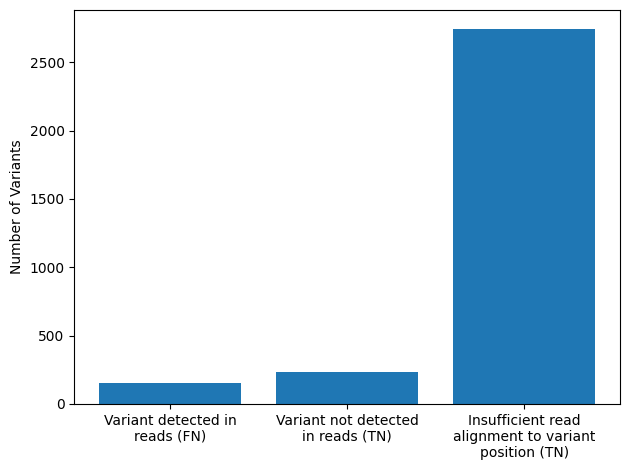

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"))

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                                  | 0/25080 [00:00<?, ?it/s]

 21%|████████████████████████▌                                                                                           | 5313/25080 [00:00<00:00, 49644.42it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 10278/25080 [00:01<00:01, 8374.45it/s]

 50%|██████████████████████████████████████████████████████████▍                                                         | 12626/25080 [00:01<00:01, 9643.78it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 14801/25080 [00:01<00:00, 10942.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 16693/25080 [00:01<00:00, 11209.16it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 18339/25080 [00:01<00:00, 7321.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 19543/25080 [00:02<00:01, 4052.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 20401/25080 [00:03<00:01, 4037.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21377/25080 [00:03<00:00, 4508.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 22593/25080 [00:03<00:00, 5237.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23633/25080 [00:03<00:00, 5728.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24423/25080 [00:03<00:00, 4154.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 25036/25080 [00:03<00:00, 4055.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25080/25080 [00:03<00:00, 6328.22it/s]

Variants in vcrs_reference: 156
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000361923:c.3205A>G',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000289893:c.6506G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000371088:c.1031T>C',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000256652:c.1822C>A',
 'ENST00000581821:c.709G>C',
 'ENST00000355199:c.1215G>C',
 'ENST00000367079:c.619C>T',
 'ENST00000367057:c.2176T>C',
 'ENST00000367057:c.2201G>A',
 'ENST00000238181:c.457C>T',
 'ENST00000486442:c.1197T>C',
 'ENST00000425361:c.39G>A',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000361923:c.3205A>G


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAATCCATCCCATCCTACTGCCAGCGCTCTGTCCACGGGATCGCCTCCCATGAAGAATCCATCCCATCCTACTG
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCCGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCC
CGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000390319:c.385C>T


TGGATGAGGCTGACTATTACTGTCAGGCGTGGGACAGTAGCACTGCACACA
TGTGTGCAGTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCA


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                               | 0/30247010 [00:00<?, ?it/s]

  0%|                                                                                                                 | 2885/30247010 [00:00<17:29, 28830.92it/s]

  0%|                                                                                                                 | 6805/30247010 [00:00<14:25, 34921.54it/s]

  0%|                                                                                                                | 10787/30247010 [00:00<13:33, 37147.89it/s]

  0%|                                                                                                                | 15259/30247010 [00:00<12:33, 40128.56it/s]

  0%|                                                                                                                | 19978/30247010 [00:00<11:48, 42666.56it/s]

  0%|                                                                                                                | 24623/30247010 [00:00<11:27, 43946.57it/s]

  0%|                                                                                                                | 29118/30247010 [00:00<11:22, 44268.35it/s]

  0%|                                                                                                                | 33580/30247010 [00:00<11:20, 44374.82it/s]

  0%|▏                                                                                                               | 40100/30247010 [00:00<09:53, 50877.94it/s]

  0%|▏                                                                                                               | 47391/30247010 [00:01<08:43, 57667.81it/s]

  0%|▏                                                                                                               | 54093/30247010 [00:01<08:18, 60514.71it/s]

  0%|▏                                                                                                               | 61184/30247010 [00:01<07:54, 63660.51it/s]

  0%|▎                                                                                                               | 67917/30247010 [00:01<07:45, 64763.06it/s]

  0%|▎                                                                                                               | 75248/30247010 [00:01<07:28, 67335.65it/s]

  0%|▎                                                                                                               | 82069/30247010 [00:01<07:26, 67589.22it/s]

  0%|▎                                                                                                               | 89419/30247010 [00:01<07:14, 69358.21it/s]

  0%|▎                                                                                                               | 96355/30247010 [00:01<07:16, 69111.56it/s]

  0%|▍                                                                                                              | 103959/30247010 [00:01<07:03, 71181.60it/s]

  0%|▍                                                                                                              | 111078/30247010 [00:01<07:06, 70628.46it/s]

  0%|▍                                                                                                              | 118691/30247010 [00:02<06:56, 72262.93it/s]

  0%|▍                                                                                                              | 125920/30247010 [00:02<07:02, 71299.81it/s]

  0%|▍                                                                                                              | 133058/30247010 [00:02<07:09, 70086.49it/s]

  0%|▌                                                                                                              | 140462/30247010 [00:02<07:02, 71241.20it/s]

  0%|▌                                                                                                              | 147593/30247010 [00:02<07:06, 70597.55it/s]

  1%|▌                                                                                                              | 154875/30247010 [00:02<07:02, 71243.03it/s]

  1%|▌                                                                                                              | 162004/30247010 [00:02<07:12, 69530.71it/s]

  1%|▌                                                                                                              | 168968/30247010 [00:02<07:14, 69173.89it/s]

  1%|▋                                                                                                              | 175893/30247010 [00:02<07:19, 68358.87it/s]

  1%|▋                                                                                                              | 183342/30247010 [00:02<07:08, 70142.82it/s]

  1%|▋                                                                                                              | 190365/30247010 [00:03<07:13, 69400.18it/s]

  1%|▋                                                                                                              | 197903/30247010 [00:03<07:02, 71153.84it/s]

  1%|▊                                                                                                              | 205027/30247010 [00:03<07:02, 71102.92it/s]

  1%|▊                                                                                                              | 212676/30247010 [00:03<06:53, 72695.70it/s]

  1%|▊                                                                                                              | 219952/30247010 [00:03<06:55, 72198.90it/s]

  1%|▊                                                                                                              | 227323/30247010 [00:03<06:56, 72133.22it/s]

  1%|▊                                                                                                              | 235143/30247010 [00:03<06:45, 73924.19it/s]

  1%|▉                                                                                                              | 242540/30247010 [00:03<06:50, 73071.55it/s]

  1%|▉                                                                                                              | 250318/30247010 [00:03<06:42, 74453.60it/s]

  1%|▉                                                                                                              | 257769/30247010 [00:03<06:49, 73253.47it/s]

  1%|▉                                                                                                              | 265102/30247010 [00:04<06:57, 71843.93it/s]

  1%|█                                                                                                              | 272658/30247010 [00:04<06:51, 72921.70it/s]

  1%|█                                                                                                              | 279960/30247010 [00:04<06:56, 71966.93it/s]

  1%|█                                                                                                              | 287648/30247010 [00:04<06:48, 73399.34it/s]

  1%|█                                                                                                              | 294997/30247010 [00:04<06:50, 72920.84it/s]

  1%|█                                                                                                              | 302720/30247010 [00:04<06:43, 74185.16it/s]

  1%|█▏                                                                                                             | 310145/30247010 [00:04<06:49, 73061.30it/s]

  1%|█▏                                                                                                             | 317459/30247010 [00:04<06:57, 71667.90it/s]

  1%|█▏                                                                                                             | 325379/30247010 [00:04<06:45, 73858.94it/s]

  1%|█▏                                                                                                             | 332777/30247010 [00:04<06:47, 73394.47it/s]

  1%|█▎                                                                                                             | 340659/30247010 [00:05<06:45, 73689.77it/s]

  1%|█▎                                                                                                             | 348646/30247010 [00:05<06:36, 75488.57it/s]

  1%|█▎                                                                                                             | 356203/30247010 [00:05<06:39, 74777.25it/s]

  1%|█▎                                                                                                             | 364092/30247010 [00:05<06:33, 75978.53it/s]

  1%|█▎                                                                                                             | 371697/30247010 [00:05<06:40, 74615.22it/s]

  1%|█▍                                                                                                             | 379167/30247010 [00:05<06:44, 73913.83it/s]

  1%|█▍                                                                                                             | 386748/30247010 [00:05<06:41, 74456.22it/s]

  1%|█▍                                                                                                             | 394200/30247010 [00:05<06:43, 73918.55it/s]

  1%|█▍                                                                                                             | 402048/30247010 [00:05<06:36, 75255.82it/s]

  1%|█▌                                                                                                             | 409579/30247010 [00:06<06:41, 74271.85it/s]

  1%|█▌                                                                                                             | 417012/30247010 [00:06<06:44, 73751.44it/s]

  1%|█▌                                                                                                             | 424875/30247010 [00:06<06:36, 75178.82it/s]

  1%|█▌                                                                                                             | 432398/30247010 [00:06<06:42, 74048.78it/s]

  1%|█▌                                                                                                             | 439993/30247010 [00:06<06:46, 73399.17it/s]

  1%|█▋                                                                                                             | 447339/30247010 [00:06<07:10, 69181.86it/s]

  2%|█▋                                                                                                             | 454304/30247010 [00:06<07:09, 69288.29it/s]

  2%|█▋                                                                                                             | 461962/30247010 [00:06<06:57, 71361.93it/s]

  2%|█▋                                                                                                             | 469131/30247010 [00:06<07:00, 70875.75it/s]

  2%|█▋                                                                                                             | 476580/30247010 [00:06<06:53, 71923.49it/s]

  2%|█▊                                                                                                             | 483791/30247010 [00:07<06:56, 71492.92it/s]

  2%|█▊                                                                                                             | 491485/30247010 [00:07<06:47, 73088.87it/s]

  2%|█▊                                                                                                             | 498806/30247010 [00:07<06:51, 72213.73it/s]

  2%|█▊                                                                                                             | 506037/30247010 [00:07<08:32, 58029.58it/s]

  2%|█▉                                                                                                             | 512284/30247010 [00:07<09:22, 52888.93it/s]

  2%|█▉                                                                                                             | 517933/30247010 [00:07<09:59, 49557.48it/s]

  2%|█▉                                                                                                             | 523145/30247010 [00:07<10:24, 47597.50it/s]

  2%|█▉                                                                                                             | 529505/30247010 [00:07<09:46, 50707.45it/s]

  2%|█▉                                                                                                             | 536091/30247010 [00:08<09:04, 54614.89it/s]

  2%|█▉                                                                                                             | 541731/30247010 [00:08<09:48, 50440.03it/s]

  2%|██                                                                                                             | 546939/30247010 [00:08<10:22, 47676.79it/s]

  2%|██                                                                                                             | 551828/30247010 [00:08<10:52, 45530.81it/s]

  2%|██                                                                                                             | 556464/30247010 [00:08<11:16, 43879.17it/s]

  2%|██                                                                                                             | 560904/30247010 [00:08<11:33, 42829.43it/s]

  2%|██                                                                                                             | 565217/30247010 [00:08<11:47, 41923.70it/s]

  2%|██                                                                                                             | 570029/30247010 [00:08<11:20, 43601.86it/s]

  2%|██                                                                                                             | 576458/30247010 [00:08<10:00, 49380.04it/s]

  2%|██▏                                                                                                            | 582407/30247010 [00:09<09:27, 52258.20it/s]

  2%|██▏                                                                                                            | 589109/30247010 [00:09<08:44, 56527.50it/s]

  2%|██▏                                                                                                            | 595626/30247010 [00:09<08:35, 57493.11it/s]

  2%|██▏                                                                                                            | 602636/30247010 [00:09<08:04, 61135.33it/s]

  2%|██▏                                                                                                            | 609823/30247010 [00:09<07:43, 64007.43it/s]

  2%|██▎                                                                                                            | 617649/30247010 [00:09<07:14, 68187.44it/s]

  2%|██▎                                                                                                            | 624683/30247010 [00:09<07:10, 68818.87it/s]

  2%|██▎                                                                                                            | 632326/30247010 [00:09<06:56, 71070.58it/s]

  2%|██▎                                                                                                            | 639452/30247010 [00:09<07:03, 69887.73it/s]

  2%|██▎                                                                                                            | 647106/30247010 [00:09<06:52, 71843.81it/s]

  2%|██▍                                                                                                            | 654306/30247010 [00:10<06:53, 71602.18it/s]

  2%|██▍                                                                                                            | 661878/30247010 [00:10<06:55, 71192.11it/s]

  2%|██▍                                                                                                            | 669558/30247010 [00:10<06:46, 72823.62it/s]

  2%|██▍                                                                                                            | 676851/30247010 [00:10<06:52, 71720.89it/s]

  2%|██▌                                                                                                            | 684678/30247010 [00:10<06:41, 73627.83it/s]

  2%|██▌                                                                                                            | 692052/30247010 [00:10<06:43, 73171.02it/s]

  2%|██▌                                                                                                            | 699498/30247010 [00:10<06:41, 73546.94it/s]

  2%|██▌                                                                                                            | 706859/30247010 [00:10<06:51, 71830.09it/s]

  2%|██▌                                                                                                            | 714054/30247010 [00:10<06:56, 70863.50it/s]

  2%|██▋                                                                                                            | 721894/30247010 [00:11<06:44, 73058.83it/s]

  2%|██▋                                                                                                            | 729213/30247010 [00:11<06:44, 73015.64it/s]

  2%|██▋                                                                                                            | 736811/30247010 [00:11<06:39, 73885.46it/s]

  2%|██▋                                                                                                            | 744207/30247010 [00:11<06:43, 73057.85it/s]

  2%|██▊                                                                                                            | 751652/30247010 [00:11<06:51, 71609.68it/s]

  3%|██▊                                                                                                            | 759289/30247010 [00:11<06:44, 72987.25it/s]

  3%|██▊                                                                                                            | 766600/30247010 [00:11<06:51, 71695.57it/s]

  3%|██▊                                                                                                            | 774522/30247010 [00:11<06:38, 73877.58it/s]

  3%|██▊                                                                                                            | 781924/30247010 [00:11<06:43, 72964.12it/s]

  3%|██▉                                                                                                            | 789340/30247010 [00:11<06:44, 72859.12it/s]

  3%|██▉                                                                                                            | 797221/30247010 [00:12<06:34, 74598.98it/s]

  3%|██▉                                                                                                            | 804690/30247010 [00:12<06:40, 73500.82it/s]

  3%|██▉                                                                                                            | 812454/30247010 [00:12<06:33, 74709.62it/s]

  3%|███                                                                                                            | 819934/30247010 [00:12<06:39, 73642.33it/s]

  3%|███                                                                                                            | 827307/30247010 [00:12<06:44, 72692.26it/s]

  3%|███                                                                                                            | 835185/30247010 [00:12<06:34, 74467.61it/s]

  3%|███                                                                                                            | 842641/30247010 [00:12<06:39, 73603.46it/s]

  3%|███                                                                                                            | 850583/30247010 [00:12<06:39, 73586.98it/s]

  3%|███▏                                                                                                           | 858360/30247010 [00:12<06:32, 74797.27it/s]

  3%|███▏                                                                                                           | 865848/30247010 [00:12<06:38, 73656.10it/s]

  3%|███▏                                                                                                           | 873565/30247010 [00:13<06:33, 74671.88it/s]

  3%|███▏                                                                                                           | 881040/30247010 [00:13<06:37, 73855.75it/s]

  3%|███▎                                                                                                           | 888432/30247010 [00:13<06:44, 72574.05it/s]

  3%|███▎                                                                                                           | 896068/30247010 [00:13<06:38, 73665.64it/s]

  3%|███▎                                                                                                           | 903443/30247010 [00:13<06:41, 73110.11it/s]

  3%|███▎                                                                                                           | 911301/30247010 [00:13<06:32, 74708.00it/s]

  3%|███▎                                                                                                           | 918779/30247010 [00:13<06:38, 73579.15it/s]

  3%|███▍                                                                                                           | 926211/30247010 [00:13<06:40, 73185.22it/s]

  3%|███▍                                                                                                           | 933882/30247010 [00:13<06:34, 74212.88it/s]

  3%|███▍                                                                                                           | 941309/30247010 [00:13<06:39, 73384.59it/s]

  3%|███▍                                                                                                           | 949086/30247010 [00:14<06:32, 74670.64it/s]

  3%|███▌                                                                                                           | 956559/30247010 [00:14<06:37, 73726.13it/s]

  3%|███▌                                                                                                           | 964069/30247010 [00:14<06:43, 72651.60it/s]

  3%|███▌                                                                                                           | 971928/30247010 [00:14<06:33, 74379.01it/s]

  3%|███▌                                                                                                           | 979376/30247010 [00:14<06:36, 73749.05it/s]

  3%|███▌                                                                                                           | 987182/30247010 [00:14<06:30, 75007.84it/s]

  3%|███▋                                                                                                           | 994691/30247010 [00:14<06:35, 74039.04it/s]

  3%|███▋                                                                                                          | 1002102/30247010 [00:14<06:40, 73015.89it/s]

  3%|███▋                                                                                                          | 1009732/30247010 [00:14<06:35, 73967.79it/s]

  3%|███▋                                                                                                          | 1017136/30247010 [00:15<06:42, 72637.24it/s]

  3%|███▋                                                                                                          | 1024790/30247010 [00:15<06:36, 73768.85it/s]

  3%|███▊                                                                                                          | 1032176/30247010 [00:15<06:41, 72743.89it/s]

  3%|███▊                                                                                                          | 1039607/30247010 [00:15<06:45, 71940.65it/s]

  3%|███▊                                                                                                          | 1047270/30247010 [00:15<06:38, 73288.98it/s]

  3%|███▊                                                                                                          | 1054608/30247010 [00:15<06:41, 72672.54it/s]

  4%|███▊                                                                                                          | 1062372/30247010 [00:15<06:33, 74125.79it/s]

  4%|███▉                                                                                                          | 1069792/30247010 [00:15<06:37, 73393.65it/s]

  4%|███▉                                                                                                          | 1077138/30247010 [00:15<06:38, 73198.63it/s]

  4%|███▉                                                                                                          | 1084462/30247010 [00:15<06:40, 72839.69it/s]

  4%|███▉                                                                                                          | 1091749/30247010 [00:16<06:44, 72159.96it/s]

  4%|███▉                                                                                                          | 1099774/30247010 [00:16<06:31, 74540.43it/s]

  4%|████                                                                                                          | 1107247/30247010 [00:16<06:30, 74588.40it/s]

  4%|████                                                                                                          | 1114710/30247010 [00:16<06:33, 73991.62it/s]

  4%|████                                                                                                          | 1122788/30247010 [00:16<06:23, 75998.54it/s]

  4%|████                                                                                                          | 1130393/30247010 [00:16<06:24, 75760.54it/s]

  4%|████▏                                                                                                         | 1137973/30247010 [00:16<06:25, 75581.22it/s]

  4%|████▏                                                                                                         | 1145534/30247010 [00:16<06:29, 74761.54it/s]

  4%|████▏                                                                                                         | 1153014/30247010 [00:16<06:33, 73879.83it/s]

  4%|████▏                                                                                                         | 1160749/30247010 [00:16<06:28, 74895.41it/s]

  4%|████▏                                                                                                         | 1168243/30247010 [00:17<06:36, 73322.68it/s]

  4%|████▎                                                                                                         | 1175633/30247010 [00:17<06:42, 72262.71it/s]

  4%|████▎                                                                                                         | 1183347/30247010 [00:17<06:34, 73675.03it/s]

  4%|████▎                                                                                                         | 1190724/30247010 [00:17<06:39, 72722.72it/s]

  4%|████▎                                                                                                         | 1198128/30247010 [00:17<06:37, 73095.47it/s]

  4%|████▍                                                                                                         | 1205444/30247010 [00:17<06:41, 72347.63it/s]

  4%|████▍                                                                                                         | 1213115/30247010 [00:17<06:34, 73620.57it/s]

  4%|████▍                                                                                                         | 1220483/30247010 [00:17<06:39, 72708.08it/s]

  4%|████▍                                                                                                         | 1227760/30247010 [00:17<06:42, 72121.97it/s]

  4%|████▍                                                                                                         | 1235482/30247010 [00:17<06:34, 73616.30it/s]

  4%|████▌                                                                                                         | 1242850/30247010 [00:18<06:37, 72983.90it/s]

  4%|████▌                                                                                                         | 1250403/30247010 [00:18<06:33, 73728.52it/s]

  4%|████▌                                                                                                         | 1257781/30247010 [00:18<06:41, 72131.03it/s]

  4%|████▌                                                                                                         | 1265040/30247010 [00:18<06:47, 71119.64it/s]

  4%|████▋                                                                                                         | 1272702/30247010 [00:18<06:38, 72717.28it/s]

  4%|████▋                                                                                                         | 1279984/30247010 [00:18<06:40, 72328.81it/s]

  4%|████▋                                                                                                         | 1287893/30247010 [00:18<06:29, 74315.16it/s]

  4%|████▋                                                                                                         | 1295333/30247010 [00:18<06:32, 73693.65it/s]

  4%|████▋                                                                                                         | 1302729/30247010 [00:18<06:34, 73400.56it/s]

  4%|████▊                                                                                                         | 1310770/30247010 [00:19<06:23, 75466.93it/s]

  4%|████▊                                                                                                         | 1318323/30247010 [00:19<06:27, 74620.27it/s]

  4%|████▊                                                                                                         | 1326062/30247010 [00:19<06:23, 75421.15it/s]

  4%|████▊                                                                                                         | 1333610/30247010 [00:19<06:24, 75125.74it/s]

  4%|████▉                                                                                                         | 1341127/30247010 [00:19<06:30, 74079.55it/s]

  4%|████▉                                                                                                         | 1349135/30247010 [00:19<06:21, 75841.40it/s]

  4%|████▉                                                                                                         | 1356726/30247010 [00:19<06:23, 75282.33it/s]

  5%|████▉                                                                                                         | 1364260/30247010 [00:19<06:28, 74350.83it/s]

  5%|████▉                                                                                                         | 1372205/30247010 [00:19<06:20, 75847.54it/s]

  5%|█████                                                                                                         | 1379796/30247010 [00:19<06:26, 74624.73it/s]

  5%|█████                                                                                                         | 1387489/30247010 [00:20<06:31, 73636.59it/s]

  5%|█████                                                                                                         | 1395402/30247010 [00:20<06:23, 75215.63it/s]

  5%|█████                                                                                                         | 1402935/30247010 [00:20<06:26, 74721.91it/s]

  5%|█████▏                                                                                                        | 1410795/30247010 [00:20<06:20, 75854.94it/s]

  5%|█████▏                                                                                                        | 1418388/30247010 [00:20<06:25, 74703.17it/s]

  5%|█████▏                                                                                                        | 1425866/30247010 [00:20<06:28, 74275.64it/s]

  5%|█████▏                                                                                                        | 1433929/30247010 [00:20<06:18, 76135.46it/s]

  5%|█████▏                                                                                                        | 1441550/30247010 [00:20<06:24, 74921.51it/s]

  5%|█████▎                                                                                                        | 1449050/30247010 [00:20<06:30, 73699.98it/s]

  5%|█████▎                                                                                                        | 1456821/30247010 [00:20<06:24, 74862.55it/s]

  5%|█████▎                                                                                                        | 1464316/30247010 [00:21<06:30, 73751.34it/s]

  5%|█████▎                                                                                                        | 1471908/30247010 [00:21<06:33, 73057.28it/s]

  5%|█████▍                                                                                                        | 1479571/30247010 [00:21<06:28, 74089.20it/s]

  5%|█████▍                                                                                                        | 1486988/30247010 [00:21<06:33, 73129.27it/s]

  5%|█████▍                                                                                                        | 1494765/30247010 [00:21<06:26, 74473.77it/s]

  5%|█████▍                                                                                                        | 1502221/30247010 [00:21<06:31, 73473.19it/s]

  5%|█████▍                                                                                                        | 1509576/30247010 [00:21<06:36, 72504.43it/s]

  5%|█████▌                                                                                                        | 1517177/30247010 [00:21<06:30, 73522.40it/s]

  5%|█████▌                                                                                                        | 1524536/30247010 [00:21<06:37, 72216.42it/s]

  5%|█████▌                                                                                                        | 1532200/30247010 [00:21<06:30, 73506.10it/s]

  5%|█████▌                                                                                                        | 1539560/30247010 [00:22<06:34, 72815.20it/s]

  5%|█████▋                                                                                                        | 1546948/30247010 [00:22<06:38, 72013.54it/s]

  5%|█████▋                                                                                                        | 1554669/30247010 [00:22<06:30, 73527.54it/s]

  5%|█████▋                                                                                                        | 1562030/30247010 [00:22<06:33, 72881.53it/s]

  5%|█████▋                                                                                                        | 1569371/30247010 [00:22<06:32, 73027.18it/s]

  5%|█████▋                                                                                                        | 1576679/30247010 [00:22<06:37, 72149.67it/s]

  5%|█████▊                                                                                                        | 1584470/30247010 [00:22<06:28, 73835.69it/s]

  5%|█████▊                                                                                                        | 1591860/30247010 [00:22<06:34, 72586.95it/s]

  5%|█████▊                                                                                                        | 1599127/30247010 [00:22<06:38, 71973.93it/s]

  5%|█████▊                                                                                                        | 1606681/30247010 [00:23<06:32, 73015.29it/s]

  5%|█████▊                                                                                                        | 1613989/30247010 [00:23<06:37, 71952.94it/s]

  5%|█████▉                                                                                                        | 1621745/30247010 [00:23<06:28, 73589.30it/s]

  5%|█████▉                                                                                                        | 1629112/30247010 [00:23<06:36, 72107.87it/s]

  5%|█████▉                                                                                                        | 1636486/30247010 [00:23<06:40, 71378.85it/s]

  5%|█████▉                                                                                                        | 1644350/30247010 [00:23<06:29, 73484.26it/s]

  5%|██████                                                                                                        | 1651711/30247010 [00:23<06:32, 72914.02it/s]

  5%|██████                                                                                                        | 1659398/30247010 [00:23<06:26, 74058.01it/s]

  6%|██████                                                                                                        | 1666812/30247010 [00:23<06:31, 72967.60it/s]

  6%|██████                                                                                                        | 1674174/30247010 [00:23<06:34, 72356.91it/s]

  6%|██████                                                                                                        | 1681884/30247010 [00:24<06:27, 73740.61it/s]

  6%|██████▏                                                                                                       | 1689266/30247010 [00:24<06:33, 72615.49it/s]

  6%|██████▏                                                                                                       | 1697006/30247010 [00:24<06:25, 74013.39it/s]

  6%|██████▏                                                                                                       | 1704416/30247010 [00:24<06:30, 73182.62it/s]

  6%|██████▏                                                                                                       | 1711863/30247010 [00:24<06:33, 72508.35it/s]

  6%|██████▎                                                                                                       | 1719426/30247010 [00:24<06:28, 73416.23it/s]

  6%|██████▎                                                                                                       | 1726774/30247010 [00:24<06:32, 72634.58it/s]

  6%|██████▎                                                                                                       | 1734461/30247010 [00:24<06:25, 73871.11it/s]

  6%|██████▎                                                                                                       | 1741854/30247010 [00:24<06:31, 72867.22it/s]

  6%|██████▎                                                                                                       | 1749411/30247010 [00:24<06:26, 73651.94it/s]

  6%|██████▍                                                                                                       | 1756782/30247010 [00:25<06:30, 72903.66it/s]

  6%|██████▍                                                                                                       | 1764078/30247010 [00:25<06:34, 72185.88it/s]

  6%|██████▍                                                                                                       | 1771782/30247010 [00:25<06:26, 73606.38it/s]

  6%|██████▍                                                                                                       | 1779149/30247010 [00:25<06:31, 72627.29it/s]

  6%|██████▍                                                                                                       | 1786929/30247010 [00:25<06:23, 74142.35it/s]

  6%|██████▌                                                                                                       | 1794350/30247010 [00:25<06:29, 73091.12it/s]

  6%|██████▌                                                                                                       | 1801666/30247010 [00:25<06:29, 73018.61it/s]

  6%|██████▌                                                                                                       | 1809307/30247010 [00:25<06:24, 74017.02it/s]

  6%|██████▌                                                                                                       | 1816714/30247010 [00:25<06:29, 72901.62it/s]

  6%|██████▋                                                                                                       | 1824501/30247010 [00:26<06:28, 73199.89it/s]

  6%|██████▋                                                                                                       | 1832386/30247010 [00:26<06:19, 74835.19it/s]

  6%|██████▋                                                                                                       | 1839876/30247010 [00:26<06:24, 73920.95it/s]

  6%|██████▋                                                                                                       | 1847760/30247010 [00:26<06:16, 75356.11it/s]

  6%|██████▋                                                                                                       | 1855303/30247010 [00:26<06:21, 74354.95it/s]

  6%|██████▊                                                                                                       | 1862746/30247010 [00:26<06:25, 73709.67it/s]

  6%|██████▊                                                                                                       | 1870479/30247010 [00:26<06:19, 74765.08it/s]

  6%|██████▊                                                                                                       | 1877961/30247010 [00:26<06:23, 73995.74it/s]

  6%|██████▊                                                                                                       | 1885471/30247010 [00:26<06:26, 73420.30it/s]

  6%|██████▉                                                                                                       | 1893350/30247010 [00:26<06:18, 74989.17it/s]

  6%|██████▉                                                                                                       | 1900855/30247010 [00:27<06:21, 74364.61it/s]

  6%|██████▉                                                                                                       | 1908555/30247010 [00:27<06:17, 75132.18it/s]

  6%|██████▉                                                                                                       | 1916073/30247010 [00:27<06:22, 73993.86it/s]

  6%|██████▉                                                                                                       | 1923479/30247010 [00:27<06:30, 72584.62it/s]

  6%|███████                                                                                                       | 1931267/30247010 [00:27<06:22, 74108.32it/s]

  6%|███████                                                                                                       | 1938688/30247010 [00:27<06:26, 73196.82it/s]

  6%|███████                                                                                                       | 1946442/30247010 [00:27<06:20, 74461.90it/s]

  6%|███████                                                                                                       | 1953897/30247010 [00:27<06:23, 73702.88it/s]

  6%|███████▏                                                                                                      | 1961274/30247010 [00:27<06:29, 72706.48it/s]

  7%|███████▏                                                                                                      | 1969076/30247010 [00:27<06:20, 74258.34it/s]

  7%|███████▏                                                                                                      | 1976510/30247010 [00:28<06:24, 73515.50it/s]

  7%|███████▏                                                                                                      | 1984247/30247010 [00:28<06:18, 74643.04it/s]

  7%|███████▏                                                                                                      | 1991718/30247010 [00:28<06:29, 72525.42it/s]

  7%|███████▎                                                                                                      | 1998986/30247010 [00:28<06:33, 71771.01it/s]

  7%|███████▎                                                                                                      | 2006463/30247010 [00:28<06:28, 72634.39it/s]

  7%|███████▎                                                                                                      | 2013737/30247010 [00:28<06:31, 72181.76it/s]

  7%|███████▎                                                                                                      | 2021472/30247010 [00:28<06:23, 73691.49it/s]

  7%|███████▍                                                                                                      | 2028849/30247010 [00:28<06:27, 72872.98it/s]

  7%|███████▍                                                                                                      | 2036166/30247010 [00:28<06:28, 72655.24it/s]

  7%|███████▍                                                                                                      | 2044150/30247010 [00:28<06:17, 74770.99it/s]

  7%|███████▍                                                                                                      | 2051634/30247010 [00:29<06:24, 73294.15it/s]

  7%|███████▍                                                                                                      | 2059540/30247010 [00:29<06:15, 74977.36it/s]

  7%|███████▌                                                                                                      | 2067049/30247010 [00:29<06:21, 73924.84it/s]

  7%|███████▌                                                                                                      | 2074451/30247010 [00:29<06:25, 73082.70it/s]

  7%|███████▌                                                                                                      | 2082164/30247010 [00:29<06:19, 74259.89it/s]

  7%|███████▌                                                                                                      | 2089598/30247010 [00:29<06:22, 73708.42it/s]

  7%|███████▋                                                                                                      | 2097351/30247010 [00:29<06:24, 73268.61it/s]

  7%|███████▋                                                                                                      | 2104809/30247010 [00:29<06:22, 73642.46it/s]

  7%|███████▋                                                                                                      | 2112178/30247010 [00:29<06:25, 73022.82it/s]

  7%|███████▋                                                                                                      | 2120107/30247010 [00:30<06:15, 74856.81it/s]

  7%|███████▋                                                                                                      | 2127599/30247010 [00:30<06:21, 73769.25it/s]

  7%|███████▊                                                                                                      | 2134983/30247010 [00:30<06:23, 73246.20it/s]

  7%|███████▊                                                                                                      | 2142810/30247010 [00:30<06:16, 74716.34it/s]

  7%|███████▊                                                                                                      | 2150288/30247010 [00:30<06:21, 73567.92it/s]

  7%|███████▊                                                                                                      | 2158169/30247010 [00:30<06:14, 75099.99it/s]

  7%|███████▉                                                                                                      | 2165687/30247010 [00:30<06:21, 73687.05it/s]

  7%|███████▉                                                                                                      | 2173066/30247010 [00:30<06:24, 73070.60it/s]

  7%|███████▉                                                                                                      | 2180748/30247010 [00:30<06:18, 74157.09it/s]

  7%|███████▉                                                                                                      | 2188171/30247010 [00:30<06:23, 73192.48it/s]

  7%|███████▉                                                                                                      | 2195841/30247010 [00:31<06:23, 73115.22it/s]

  7%|████████                                                                                                      | 2203690/30247010 [00:31<06:15, 74675.34it/s]

  7%|████████                                                                                                      | 2211165/30247010 [00:31<06:21, 73484.62it/s]

  7%|████████                                                                                                      | 2218946/30247010 [00:31<06:15, 74740.89it/s]

  7%|████████                                                                                                      | 2226429/30247010 [00:31<06:21, 73358.41it/s]

  7%|████████                                                                                                      | 2233775/30247010 [00:31<06:24, 72895.22it/s]

  7%|████████▏                                                                                                     | 2241598/30247010 [00:31<06:16, 74450.62it/s]

  7%|████████▏                                                                                                     | 2249051/30247010 [00:31<06:22, 73273.25it/s]

  7%|████████▏                                                                                                     | 2256711/30247010 [00:31<06:17, 74229.89it/s]

  7%|████████▏                                                                                                     | 2264142/30247010 [00:31<06:25, 72642.45it/s]

  8%|████████▎                                                                                                     | 2271418/30247010 [00:32<06:30, 71715.01it/s]

  8%|████████▎                                                                                                     | 2278759/30247010 [00:32<06:27, 72200.09it/s]

  8%|████████▎                                                                                                     | 2285986/30247010 [00:32<06:32, 71200.33it/s]

  8%|████████▎                                                                                                     | 2293669/30247010 [00:32<06:23, 72839.52it/s]

  8%|████████▎                                                                                                     | 2300962/30247010 [00:32<06:27, 72124.42it/s]

  8%|████████▍                                                                                                     | 2308653/30247010 [00:32<06:19, 73527.03it/s]

  8%|████████▍                                                                                                     | 2316013/30247010 [00:32<06:25, 72504.28it/s]

  8%|████████▍                                                                                                     | 2323271/30247010 [00:32<06:26, 72159.42it/s]

  8%|████████▍                                                                                                     | 2330893/30247010 [00:32<06:20, 73346.94it/s]

  8%|████████▌                                                                                                     | 2338233/30247010 [00:32<06:29, 71715.60it/s]

  8%|████████▌                                                                                                     | 2345957/30247010 [00:33<06:20, 73319.29it/s]

  8%|████████▌                                                                                                     | 2353300/30247010 [00:33<06:26, 72223.90it/s]

  8%|████████▌                                                                                                     | 2360533/30247010 [00:33<06:29, 71507.18it/s]

  8%|████████▌                                                                                                     | 2368042/30247010 [00:33<06:24, 72548.72it/s]

  8%|████████▋                                                                                                     | 2375305/30247010 [00:33<06:28, 71823.91it/s]

  8%|████████▋                                                                                                     | 2382998/30247010 [00:33<06:20, 73318.03it/s]

  8%|████████▋                                                                                                     | 2390337/30247010 [00:33<06:25, 72249.13it/s]

  8%|████████▋                                                                                                     | 2397772/30247010 [00:33<06:22, 72852.66it/s]

  8%|████████▋                                                                                                     | 2405064/30247010 [00:33<06:27, 71850.05it/s]

  8%|████████▊                                                                                                     | 2412335/30247010 [00:34<06:30, 71358.31it/s]

  8%|████████▊                                                                                                     | 2419893/30247010 [00:34<06:23, 72591.97it/s]

  8%|████████▊                                                                                                     | 2427158/30247010 [00:34<06:28, 71604.22it/s]

  8%|████████▊                                                                                                     | 2434814/30247010 [00:34<06:20, 73052.79it/s]

  8%|████████▉                                                                                                     | 2442127/30247010 [00:34<06:25, 72195.95it/s]

  8%|████████▉                                                                                                     | 2449870/30247010 [00:34<06:17, 73730.41it/s]

  8%|████████▉                                                                                                     | 2457251/30247010 [00:34<06:23, 72397.85it/s]

  8%|████████▉                                                                                                     | 2464500/30247010 [00:34<06:26, 71971.61it/s]

  8%|████████▉                                                                                                     | 2472201/30247010 [00:34<06:18, 73444.66it/s]

  8%|█████████                                                                                                     | 2479553/30247010 [00:34<06:24, 72308.85it/s]

  8%|█████████                                                                                                     | 2487328/30247010 [00:35<06:15, 73895.99it/s]

  8%|█████████                                                                                                     | 2494727/30247010 [00:35<06:19, 73177.05it/s]

  8%|█████████                                                                                                     | 2502052/30247010 [00:35<06:24, 72192.88it/s]

  8%|█████████▏                                                                                                    | 2509468/30247010 [00:35<06:21, 72757.04it/s]

  8%|█████████▏                                                                                                    | 2516750/30247010 [00:35<06:24, 72173.89it/s]

  8%|█████████▏                                                                                                    | 2524344/30247010 [00:35<06:18, 73272.71it/s]

  8%|█████████▏                                                                                                    | 2531676/30247010 [00:35<06:22, 72453.65it/s]

  8%|█████████▏                                                                                                    | 2539093/30247010 [00:35<06:22, 72371.39it/s]

  8%|█████████▎                                                                                                    | 2546768/30247010 [00:35<06:16, 73643.51it/s]

  8%|█████████▎                                                                                                    | 2554137/30247010 [00:35<06:21, 72594.21it/s]

  8%|█████████▎                                                                                                    | 2561936/30247010 [00:36<06:13, 74171.98it/s]

  8%|█████████▎                                                                                                    | 2569360/30247010 [00:36<06:19, 72848.75it/s]

  9%|█████████▎                                                                                                    | 2576654/30247010 [00:36<06:22, 72389.61it/s]

  9%|█████████▍                                                                                                    | 2584405/30247010 [00:36<06:14, 73884.79it/s]

  9%|█████████▍                                                                                                    | 2591801/30247010 [00:36<06:20, 72698.38it/s]

  9%|█████████▍                                                                                                    | 2599522/30247010 [00:36<06:13, 74016.46it/s]

  9%|█████████▍                                                                                                    | 2606932/30247010 [00:36<06:19, 72843.02it/s]

  9%|█████████▌                                                                                                    | 2614225/30247010 [00:36<06:22, 72154.85it/s]

  9%|█████████▌                                                                                                    | 2621634/30247010 [00:36<06:19, 72714.28it/s]

  9%|█████████▌                                                                                                    | 2628911/30247010 [00:36<06:22, 72277.81it/s]

  9%|█████████▌                                                                                                    | 2636764/30247010 [00:37<06:12, 74113.60it/s]

  9%|█████████▌                                                                                                    | 2644181/30247010 [00:37<06:19, 72795.62it/s]

  9%|█████████▋                                                                                                    | 2651871/30247010 [00:37<06:20, 72484.44it/s]

  9%|█████████▋                                                                                                    | 2659577/30247010 [00:37<06:13, 73802.29it/s]

  9%|█████████▋                                                                                                    | 2666966/30247010 [00:37<06:16, 73180.61it/s]

  9%|█████████▋                                                                                                    | 2674675/30247010 [00:37<06:11, 74316.09it/s]

  9%|█████████▊                                                                                                    | 2682113/30247010 [00:37<06:15, 73349.62it/s]

  9%|█████████▊                                                                                                    | 2689560/30247010 [00:37<06:20, 72380.60it/s]

  9%|█████████▊                                                                                                    | 2697230/30247010 [00:37<06:14, 73634.88it/s]

  9%|█████████▊                                                                                                    | 2704602/30247010 [00:38<06:18, 72737.14it/s]

  9%|█████████▊                                                                                                    | 2712366/30247010 [00:38<06:11, 74164.98it/s]

  9%|█████████▉                                                                                                    | 2719791/30247010 [00:38<06:16, 73176.49it/s]

  9%|█████████▉                                                                                                    | 2727248/30247010 [00:38<06:18, 72682.44it/s]

  9%|█████████▉                                                                                                    | 2734924/30247010 [00:38<06:12, 73869.76it/s]

  9%|█████████▉                                                                                                    | 2742318/30247010 [00:38<06:15, 73209.95it/s]

  9%|█████████▉                                                                                                    | 2749705/30247010 [00:38<06:14, 73393.32it/s]

  9%|██████████                                                                                                    | 2757049/30247010 [00:38<06:16, 73104.84it/s]

  9%|██████████                                                                                                    | 2764517/30247010 [00:38<06:13, 73565.82it/s]

  9%|██████████                                                                                                    | 2771876/30247010 [00:38<06:17, 72755.49it/s]

  9%|██████████                                                                                                    | 2779155/30247010 [00:39<06:23, 71573.71it/s]

  9%|██████████▏                                                                                                   | 2786902/30247010 [00:39<06:14, 73293.77it/s]

  9%|██████████▏                                                                                                   | 2794239/30247010 [00:39<06:17, 72801.06it/s]

  9%|██████████▏                                                                                                   | 2802069/30247010 [00:39<06:08, 74415.26it/s]

  9%|██████████▏                                                                                                   | 2809517/30247010 [00:39<06:17, 72619.33it/s]

  9%|██████████▏                                                                                                   | 2816792/30247010 [00:39<06:19, 72312.52it/s]

  9%|██████████▎                                                                                                   | 2824433/30247010 [00:39<06:13, 73510.22it/s]

  9%|██████████▎                                                                                                   | 2831793/30247010 [00:39<06:19, 72294.03it/s]

  9%|██████████▎                                                                                                   | 2839591/30247010 [00:39<06:10, 73952.08it/s]

  9%|██████████▎                                                                                                   | 2846996/30247010 [00:39<06:11, 73667.45it/s]

  9%|██████████▍                                                                                                   | 2854370/30247010 [00:40<06:12, 73576.02it/s]

  9%|██████████▍                                                                                                   | 2862394/30247010 [00:40<06:02, 75545.31it/s]

  9%|██████████▍                                                                                                   | 2869954/30247010 [00:40<06:08, 74375.61it/s]

 10%|██████████▍                                                                                                   | 2877458/30247010 [00:40<06:15, 72860.74it/s]

 10%|██████████▍                                                                                                   | 2885207/30247010 [00:40<06:08, 74199.57it/s]

 10%|██████████▌                                                                                                   | 2892638/30247010 [00:40<06:11, 73588.17it/s]

 10%|██████████▌                                                                                                   | 2900550/30247010 [00:40<06:03, 75203.69it/s]

 10%|██████████▌                                                                                                   | 2908080/30247010 [00:40<06:09, 73990.48it/s]

 10%|██████████▌                                                                                                   | 2915489/30247010 [00:40<06:12, 73304.85it/s]

 10%|██████████▋                                                                                                   | 2923033/30247010 [00:40<06:09, 73923.16it/s]

 10%|██████████▋                                                                                                   | 2930432/30247010 [00:41<06:13, 73218.65it/s]

 10%|██████████▋                                                                                                   | 2938056/30247010 [00:41<06:08, 74103.62it/s]

 10%|██████████▋                                                                                                   | 2945472/30247010 [00:41<06:11, 73391.92it/s]

 10%|██████████▋                                                                                                   | 2952816/30247010 [00:41<06:13, 72984.32it/s]

 10%|██████████▊                                                                                                   | 2960523/30247010 [00:41<06:07, 74183.80it/s]

 10%|██████████▊                                                                                                   | 2967946/30247010 [00:41<06:12, 73244.10it/s]

 10%|██████████▊                                                                                                   | 2975713/30247010 [00:41<06:05, 74541.13it/s]

 10%|██████████▊                                                                                                   | 2983173/30247010 [00:41<06:10, 73630.80it/s]

 10%|██████████▉                                                                                                   | 2990542/30247010 [00:41<06:13, 73064.38it/s]

 10%|██████████▉                                                                                                   | 2998419/30247010 [00:42<06:04, 74738.93it/s]

 10%|██████████▉                                                                                                   | 3005899/30247010 [00:42<06:12, 73035.21it/s]

 10%|██████████▉                                                                                                   | 3013683/30247010 [00:42<06:05, 74433.07it/s]

 10%|██████████▉                                                                                                   | 3021138/30247010 [00:42<06:10, 73554.01it/s]

 10%|███████████                                                                                                   | 3028503/30247010 [00:42<06:11, 73247.42it/s]

 10%|███████████                                                                                                   | 3036396/30247010 [00:42<06:03, 74912.18it/s]

 10%|███████████                                                                                                   | 3043895/30247010 [00:42<06:09, 73655.59it/s]

 10%|███████████                                                                                                   | 3051628/30247010 [00:42<06:10, 73378.72it/s]

 10%|███████████▏                                                                                                  | 3059370/30247010 [00:42<06:04, 74542.24it/s]

 10%|███████████▏                                                                                                  | 3066832/30247010 [00:42<06:11, 73190.83it/s]

 10%|███████████▏                                                                                                  | 3074616/30247010 [00:43<06:04, 74540.35it/s]

 10%|███████████▏                                                                                                  | 3082080/30247010 [00:43<06:09, 73603.35it/s]

 10%|███████████▏                                                                                                  | 3089449/30247010 [00:43<06:10, 73396.58it/s]

 10%|███████████▎                                                                                                  | 3097361/30247010 [00:43<06:01, 75069.72it/s]

 10%|███████████▎                                                                                                  | 3104875/30247010 [00:43<06:06, 73961.84it/s]

 10%|███████████▎                                                                                                  | 3112597/30247010 [00:43<06:09, 73389.59it/s]

 10%|███████████▎                                                                                                  | 3120417/30247010 [00:43<06:02, 74781.87it/s]

 10%|███████████▍                                                                                                  | 3127904/30247010 [00:43<06:05, 74279.25it/s]

 10%|███████████▍                                                                                                  | 3135508/30247010 [00:43<06:02, 74788.17it/s]

 10%|███████████▍                                                                                                  | 3142992/30247010 [00:43<06:08, 73641.59it/s]

 10%|███████████▍                                                                                                  | 3150363/30247010 [00:44<06:09, 73265.72it/s]

 10%|███████████▍                                                                                                  | 3158208/30247010 [00:44<06:02, 74786.81it/s]

 10%|███████████▌                                                                                                  | 3165693/30247010 [00:44<06:07, 73684.36it/s]

 10%|███████████▌                                                                                                  | 3173511/30247010 [00:44<06:00, 75000.87it/s]

 11%|███████████▌                                                                                                  | 3181019/30247010 [00:44<06:06, 73828.48it/s]

 11%|███████████▌                                                                                                  | 3188410/30247010 [00:44<06:09, 73191.78it/s]

 11%|███████████▌                                                                                                  | 3195946/30247010 [00:44<06:06, 73819.12it/s]

 11%|███████████▋                                                                                                  | 3203333/30247010 [00:44<06:09, 73132.08it/s]

 11%|███████████▋                                                                                                  | 3210971/30247010 [00:44<06:04, 74080.19it/s]

 11%|███████████▋                                                                                                  | 3218384/30247010 [00:44<06:08, 73311.86it/s]

 11%|███████████▋                                                                                                  | 3225720/30247010 [00:45<06:11, 72733.23it/s]

 11%|███████████▊                                                                                                  | 3233621/30247010 [00:45<06:02, 74576.26it/s]

 11%|███████████▊                                                                                                  | 3241084/30247010 [00:45<06:04, 74064.62it/s]

 11%|███████████▊                                                                                                  | 3248519/30247010 [00:45<06:04, 74132.22it/s]

 11%|███████████▊                                                                                                  | 3255936/30247010 [00:45<06:11, 72705.55it/s]

 11%|███████████▊                                                                                                  | 3263214/30247010 [00:45<06:13, 72210.40it/s]

 11%|███████████▉                                                                                                  | 3270988/30247010 [00:45<06:05, 73816.59it/s]

 11%|███████████▉                                                                                                  | 3278376/30247010 [00:45<06:10, 72835.41it/s]

 11%|███████████▉                                                                                                  | 3286224/30247010 [00:45<06:01, 74487.24it/s]

 11%|███████████▉                                                                                                  | 3293681/30247010 [00:46<06:06, 73548.40it/s]

 11%|████████████                                                                                                  | 3301043/30247010 [00:46<06:07, 73257.14it/s]

 11%|████████████                                                                                                  | 3308862/30247010 [00:46<06:00, 74707.33it/s]

 11%|████████████                                                                                                  | 3316339/30247010 [00:46<06:07, 73210.38it/s]

 11%|████████████                                                                                                  | 3324094/30247010 [00:46<06:01, 74474.05it/s]

 11%|████████████                                                                                                  | 3331551/30247010 [00:46<06:06, 73359.52it/s]

 11%|████████████▏                                                                                                 | 3338896/30247010 [00:46<06:08, 73109.35it/s]

 11%|████████████▏                                                                                                 | 3346843/30247010 [00:46<05:58, 74973.98it/s]

 11%|████████████▏                                                                                                 | 3354348/30247010 [00:46<06:06, 73437.81it/s]

 11%|████████████▏                                                                                                 | 3361900/30247010 [00:46<06:10, 72582.37it/s]

 11%|████████████▎                                                                                                 | 3369660/30247010 [00:47<06:03, 74033.54it/s]

 11%|████████████▎                                                                                                 | 3377075/30247010 [00:47<06:06, 73306.91it/s]

 11%|████████████▎                                                                                                 | 3384690/30247010 [00:47<06:02, 74127.29it/s]

 11%|████████████▎                                                                                                 | 3392111/30247010 [00:47<06:05, 73505.99it/s]

 11%|████████████▎                                                                                                 | 3399468/30247010 [00:47<06:09, 72639.99it/s]

 11%|████████████▍                                                                                                 | 3407292/30247010 [00:47<06:01, 74281.39it/s]

 11%|████████████▍                                                                                                 | 3414727/30247010 [00:47<06:04, 73688.46it/s]

 11%|████████████▍                                                                                                 | 3422436/30247010 [00:47<05:59, 74684.58it/s]

 11%|████████████▍                                                                                                 | 3429910/30247010 [00:47<06:06, 73261.11it/s]

 11%|████████████▌                                                                                                 | 3437245/30247010 [00:47<06:08, 72803.95it/s]

 11%|████████████▌                                                                                                 | 3444872/30247010 [00:48<06:03, 73814.67it/s]

 11%|████████████▌                                                                                                 | 3452260/30247010 [00:48<06:07, 73004.53it/s]

 11%|████████████▌                                                                                                 | 3459602/30247010 [00:48<06:06, 73113.89it/s]

 11%|████████████▌                                                                                                 | 3466918/30247010 [00:48<06:13, 71648.22it/s]

 11%|████████████▋                                                                                                 | 3474460/30247010 [00:48<06:18, 70770.26it/s]

 12%|████████████▋                                                                                                 | 3482005/30247010 [00:48<06:11, 72116.49it/s]

 12%|████████████▋                                                                                                 | 3489228/30247010 [00:48<06:15, 71309.89it/s]

 12%|████████████▋                                                                                                 | 3496994/30247010 [00:48<06:05, 73156.12it/s]

 12%|████████████▋                                                                                                 | 3504320/30247010 [00:48<06:10, 72086.97it/s]

 12%|████████████▊                                                                                                 | 3512125/30247010 [00:49<06:08, 72472.25it/s]

 12%|████████████▊                                                                                                 | 3519909/30247010 [00:49<06:01, 74026.46it/s]

 12%|████████████▊                                                                                                 | 3527321/30247010 [00:49<06:02, 73634.16it/s]

 12%|████████████▊                                                                                                 | 3535247/30247010 [00:49<05:54, 75277.89it/s]

 12%|████████████▉                                                                                                 | 3542782/30247010 [00:49<05:59, 74287.97it/s]

 12%|████████████▉                                                                                                 | 3550218/30247010 [00:49<06:00, 74013.18it/s]

 12%|████████████▉                                                                                                 | 3558182/30247010 [00:49<05:52, 75669.55it/s]

 12%|████████████▉                                                                                                 | 3565755/30247010 [00:49<05:58, 74332.73it/s]

 12%|████████████▉                                                                                                 | 3573370/30247010 [00:49<06:00, 74078.70it/s]

 12%|█████████████                                                                                                 | 3581306/30247010 [00:49<05:52, 75612.88it/s]

 12%|█████████████                                                                                                 | 3588875/30247010 [00:50<05:55, 74939.50it/s]

 12%|█████████████                                                                                                 | 3596925/30247010 [00:50<05:56, 74732.86it/s]

 12%|█████████████                                                                                                 | 3604841/30247010 [00:50<05:50, 76016.01it/s]

 12%|█████████████▏                                                                                                | 3612450/30247010 [00:50<05:56, 74763.22it/s]

 12%|█████████████▏                                                                                                | 3620432/30247010 [00:50<05:49, 76230.32it/s]

 12%|█████████████▏                                                                                                | 3628065/30247010 [00:50<05:57, 74405.18it/s]

 12%|█████████████▏                                                                                                | 3635519/30247010 [00:50<06:01, 73614.76it/s]

 12%|█████████████▏                                                                                                | 3643383/30247010 [00:50<05:54, 75067.03it/s]

 12%|█████████████▎                                                                                                | 3650901/30247010 [00:50<05:58, 74242.14it/s]

 12%|█████████████▎                                                                                                | 3658334/30247010 [00:50<05:59, 73928.94it/s]

 12%|█████████████▎                                                                                                | 3666357/30247010 [00:51<05:50, 75773.86it/s]

 12%|█████████████▎                                                                                                | 3673942/30247010 [00:51<05:58, 74074.66it/s]

 12%|█████████████▍                                                                                                | 3681599/30247010 [00:51<06:00, 73690.59it/s]

 12%|█████████████▍                                                                                                | 3689362/30247010 [00:51<05:54, 74828.53it/s]

 12%|█████████████▍                                                                                                | 3696855/30247010 [00:51<05:57, 74288.68it/s]

 12%|█████████████▍                                                                                                | 3704823/30247010 [00:51<05:49, 75862.67it/s]

 12%|█████████████▌                                                                                                | 3712417/30247010 [00:51<05:54, 74949.73it/s]

 12%|█████████████▌                                                                                                | 3719919/30247010 [00:51<05:54, 74801.16it/s]

 12%|█████████████▌                                                                                                | 3727886/30247010 [00:51<05:47, 76222.03it/s]

 12%|█████████████▌                                                                                                | 3735514/30247010 [00:51<05:52, 75193.04it/s]

 12%|█████████████▌                                                                                                | 3743040/30247010 [00:52<05:55, 74620.50it/s]

 12%|█████████████▋                                                                                                | 3750624/30247010 [00:52<05:53, 74974.43it/s]

 12%|█████████████▋                                                                                                | 3758125/30247010 [00:52<05:59, 73669.57it/s]

 12%|█████████████▋                                                                                                | 3766020/30247010 [00:52<06:00, 73407.21it/s]

 12%|█████████████▋                                                                                                | 3773866/30247010 [00:52<05:53, 74865.77it/s]

 13%|█████████████▊                                                                                                | 3781361/30247010 [00:52<05:56, 74183.48it/s]

 13%|█████████████▊                                                                                                | 3789309/30247010 [00:52<05:49, 75730.70it/s]

 13%|█████████████▊                                                                                                | 3796890/30247010 [00:52<05:52, 74984.21it/s]

 13%|█████████████▊                                                                                                | 3804395/30247010 [00:52<05:54, 74536.51it/s]

 13%|█████████████▊                                                                                                | 3812235/30247010 [00:53<05:49, 75667.72it/s]

 13%|█████████████▉                                                                                                | 3819807/30247010 [00:53<05:52, 74980.57it/s]

 13%|█████████████▉                                                                                                | 3827310/30247010 [00:53<05:53, 74634.18it/s]

 13%|█████████████▉                                                                                                | 3835470/30247010 [00:53<05:44, 76690.22it/s]

 13%|█████████████▉                                                                                                | 3843144/30247010 [00:53<05:49, 75598.55it/s]

 13%|██████████████                                                                                                | 3850710/30247010 [00:53<05:51, 75109.19it/s]

 13%|██████████████                                                                                                | 3858581/30247010 [00:53<05:46, 76165.06it/s]

 13%|██████████████                                                                                                | 3866203/30247010 [00:53<05:54, 74511.32it/s]

 13%|██████████████                                                                                                | 3873664/30247010 [00:53<05:55, 74141.36it/s]

 13%|██████████████                                                                                                | 3881085/30247010 [00:53<06:04, 72376.56it/s]

 13%|██████████████▏                                                                                               | 3888334/30247010 [00:54<06:06, 71873.35it/s]

 13%|██████████████▏                                                                                               | 3896077/30247010 [00:54<05:58, 73480.98it/s]

 13%|██████████████▏                                                                                               | 3903435/30247010 [00:54<06:03, 72414.58it/s]

 13%|██████████████▏                                                                                               | 3911104/30247010 [00:54<05:57, 73650.42it/s]

 13%|██████████████▎                                                                                               | 3918478/30247010 [00:54<06:01, 72903.01it/s]

 13%|██████████████▎                                                                                               | 3925999/30247010 [00:54<06:03, 72384.68it/s]

 13%|██████████████▎                                                                                               | 3933814/30247010 [00:54<05:55, 74059.71it/s]

 13%|██████████████▎                                                                                               | 3941264/30247010 [00:54<05:54, 74165.14it/s]

 13%|██████████████▎                                                                                               | 3949145/30247010 [00:54<05:48, 75535.12it/s]

 13%|██████████████▍                                                                                               | 3956705/30247010 [00:54<05:53, 74460.76it/s]

 13%|██████████████▍                                                                                               | 3964158/30247010 [00:55<05:53, 74394.02it/s]

 13%|██████████████▍                                                                                               | 3972362/30247010 [00:55<05:42, 76651.05it/s]

 13%|██████████████▍                                                                                               | 3980034/30247010 [00:55<05:47, 75579.84it/s]

 13%|██████████████▌                                                                                               | 3987599/30247010 [00:55<05:50, 74937.01it/s]

 13%|██████████████▌                                                                                               | 3995299/30247010 [00:55<05:47, 75536.15it/s]

 13%|██████████████▌                                                                                               | 4002858/30247010 [00:55<05:48, 75253.21it/s]

 13%|██████████████▌                                                                                               | 4010707/30247010 [00:55<05:51, 74649.17it/s]

 13%|██████████████▌                                                                                               | 4018500/30247010 [00:55<05:46, 75603.70it/s]

 13%|██████████████▋                                                                                               | 4026066/30247010 [00:55<05:50, 74715.13it/s]

 13%|██████████████▋                                                                                               | 4034156/30247010 [00:55<05:51, 74603.15it/s]

 13%|██████████████▋                                                                                               | 4042176/30247010 [00:56<05:43, 76218.84it/s]

 13%|██████████████▋                                                                                               | 4049806/30247010 [00:56<05:48, 75158.42it/s]

 13%|██████████████▊                                                                                               | 4057606/30247010 [00:56<05:52, 74332.30it/s]

 13%|██████████████▊                                                                                               | 4065466/30247010 [00:56<05:46, 75565.13it/s]

 13%|██████████████▊                                                                                               | 4073032/30247010 [00:56<05:48, 75041.23it/s]

 13%|██████████████▊                                                                                               | 4081055/30247010 [00:56<05:49, 74938.81it/s]

 14%|██████████████▊                                                                                               | 4089076/30247010 [00:56<05:42, 76444.11it/s]

 14%|██████████████▉                                                                                               | 4096729/30247010 [00:56<05:47, 75300.82it/s]

 14%|██████████████▉                                                                                               | 4104506/30247010 [00:56<05:49, 74832.37it/s]

 14%|██████████████▉                                                                                               | 4112546/30247010 [00:57<05:41, 76442.87it/s]

 14%|██████████████▉                                                                                               | 4120199/30247010 [00:57<05:46, 75309.24it/s]

 14%|███████████████                                                                                               | 4127955/30247010 [00:57<05:46, 75323.14it/s]

 14%|███████████████                                                                                               | 4135958/30247010 [00:57<05:40, 76694.28it/s]

 14%|███████████████                                                                                               | 4143635/30247010 [00:57<05:45, 75585.88it/s]

 14%|███████████████                                                                                               | 4151404/30247010 [00:57<05:46, 75419.12it/s]

 14%|███████████████▏                                                                                              | 4159572/30247010 [00:57<05:37, 77242.79it/s]

 14%|███████████████▏                                                                                              | 4167304/30247010 [00:57<05:42, 76128.12it/s]

 14%|███████████████▏                                                                                              | 4174945/30247010 [00:57<05:49, 74506.03it/s]

 14%|███████████████▏                                                                                              | 4182876/30247010 [00:57<05:43, 75894.04it/s]

 14%|███████████████▏                                                                                              | 4190477/30247010 [00:58<05:46, 75241.36it/s]

 14%|███████████████▎                                                                                              | 4198517/30247010 [00:58<05:46, 75145.49it/s]

 14%|███████████████▎                                                                                              | 4206557/30247010 [00:58<05:39, 76665.20it/s]

 14%|███████████████▎                                                                                              | 4214233/30247010 [00:58<05:42, 75908.75it/s]

 14%|███████████████▎                                                                                              | 4222072/30247010 [00:58<05:43, 75799.90it/s]

 14%|███████████████▍                                                                                              | 4230147/30247010 [00:58<05:36, 77242.91it/s]

 14%|███████████████▍                                                                                              | 4237878/30247010 [00:58<05:44, 75471.35it/s]

 14%|███████████████▍                                                                                              | 4245627/30247010 [00:58<05:47, 74900.78it/s]

 14%|███████████████▍                                                                                              | 4253632/30247010 [00:58<05:40, 76390.71it/s]

 14%|███████████████▍                                                                                              | 4261282/30247010 [00:58<05:41, 76094.35it/s]

 14%|███████████████▌                                                                                              | 4269182/30247010 [00:59<05:42, 75872.15it/s]

 14%|███████████████▌                                                                                              | 4277293/30247010 [00:59<05:35, 77398.17it/s]

 14%|███████████████▌                                                                                              | 4285040/30247010 [00:59<05:40, 76229.61it/s]

 14%|███████████████▌                                                                                              | 4292737/30247010 [00:59<05:46, 74847.38it/s]

 14%|███████████████▋                                                                                              | 4300693/30247010 [00:59<05:40, 76210.43it/s]

 14%|███████████████▋                                                                                              | 4308325/30247010 [00:59<05:48, 74396.39it/s]

 14%|███████████████▋                                                                                              | 4316146/30247010 [00:59<05:43, 75489.74it/s]

 14%|███████████████▋                                                                                              | 4323708/30247010 [00:59<05:52, 73466.84it/s]

 14%|███████████████▊                                                                                              | 4331072/30247010 [00:59<05:57, 72392.52it/s]

 14%|███████████████▊                                                                                              | 4338665/30247010 [01:00<05:52, 73409.21it/s]

 14%|███████████████▊                                                                                              | 4346019/30247010 [01:00<05:58, 72342.42it/s]

 14%|███████████████▊                                                                                              | 4353741/30247010 [01:00<05:51, 73754.83it/s]

 14%|███████████████▊                                                                                              | 4361128/30247010 [01:00<06:01, 71539.41it/s]

 14%|███████████████▉                                                                                              | 4368301/30247010 [01:00<06:09, 70079.01it/s]

 14%|███████████████▉                                                                                              | 4375866/30247010 [01:00<06:00, 71675.55it/s]

 14%|███████████████▉                                                                                              | 4383051/30247010 [01:00<06:00, 71662.17it/s]

 15%|███████████████▉                                                                                              | 4390709/30247010 [01:00<05:53, 73095.53it/s]

 15%|███████████████▉                                                                                              | 4398030/30247010 [01:00<05:59, 71975.19it/s]

 15%|████████████████                                                                                              | 4405498/30247010 [01:00<05:58, 72102.37it/s]

 15%|████████████████                                                                                              | 4413221/30247010 [01:01<05:51, 73600.32it/s]

 15%|████████████████                                                                                              | 4420590/30247010 [01:01<05:55, 72651.08it/s]

 15%|████████████████                                                                                              | 4428512/30247010 [01:01<05:46, 74575.25it/s]

 15%|████████████████▏                                                                                             | 4435979/30247010 [01:01<05:50, 73737.72it/s]

 15%|████████████████▏                                                                                             | 4443361/30247010 [01:01<05:53, 72947.57it/s]

 15%|████████████████▏                                                                                             | 4451229/30247010 [01:01<05:45, 74624.35it/s]

 15%|████████████████▏                                                                                             | 4458699/30247010 [01:01<05:49, 73847.54it/s]

 15%|████████████████▏                                                                                             | 4466468/30247010 [01:01<05:52, 73150.07it/s]

 15%|████████████████▎                                                                                             | 4474273/30247010 [01:01<05:45, 74571.30it/s]

 15%|████████████████▎                                                                                             | 4481740/30247010 [01:01<05:49, 73620.14it/s]

 15%|████████████████▎                                                                                             | 4489711/30247010 [01:02<05:41, 75392.43it/s]

 15%|████████████████▎                                                                                             | 4497260/30247010 [01:02<05:47, 74022.30it/s]

 15%|████████████████▍                                                                                             | 4504673/30247010 [01:02<05:52, 73010.13it/s]

 15%|████████████████▍                                                                                             | 4512343/30247010 [01:02<05:47, 74079.73it/s]

 15%|████████████████▍                                                                                             | 4519760/30247010 [01:02<05:50, 73384.97it/s]

 15%|████████████████▍                                                                                             | 4527534/30247010 [01:02<05:51, 73154.72it/s]

 15%|████████████████▍                                                                                             | 4535099/30247010 [01:02<05:48, 73867.62it/s]

 15%|████████████████▌                                                                                             | 4542492/30247010 [01:02<05:50, 73257.92it/s]

 15%|████████████████▌                                                                                             | 4550267/30247010 [01:02<05:44, 74571.57it/s]

 15%|████████████████▌                                                                                             | 4557730/30247010 [01:03<05:47, 73852.35it/s]

 15%|████████████████▌                                                                                             | 4565239/30247010 [01:03<05:49, 73568.90it/s]

 15%|████████████████▋                                                                                             | 4573048/30247010 [01:03<05:42, 74893.26it/s]

 15%|████████████████▋                                                                                             | 4580542/30247010 [01:03<05:48, 73632.11it/s]

 15%|████████████████▋                                                                                             | 4588345/30247010 [01:03<05:42, 74916.52it/s]

 15%|████████████████▋                                                                                             | 4595844/30247010 [01:03<05:48, 73682.99it/s]

 15%|████████████████▋                                                                                             | 4603221/30247010 [01:03<05:49, 73346.55it/s]

 15%|████████████████▊                                                                                             | 4610919/30247010 [01:03<05:44, 74406.10it/s]

 15%|████████████████▊                                                                                             | 4618366/30247010 [01:03<05:51, 72950.29it/s]

 15%|████████████████▊                                                                                             | 4626329/30247010 [01:03<05:42, 74896.59it/s]

 15%|████████████████▊                                                                                             | 4633830/30247010 [01:04<05:46, 74008.98it/s]

 15%|████████████████▉                                                                                             | 4641240/30247010 [01:04<05:48, 73564.86it/s]

 15%|████████████████▉                                                                                             | 4649181/30247010 [01:04<05:40, 75273.65it/s]

 15%|████████████████▉                                                                                             | 4656716/30247010 [01:04<05:49, 73202.91it/s]

 15%|████████████████▉                                                                                             | 4664175/30247010 [01:04<05:53, 72310.09it/s]

 15%|████████████████▉                                                                                             | 4671924/30247010 [01:04<05:46, 73806.36it/s]

 15%|█████████████████                                                                                             | 4679318/30247010 [01:04<05:51, 72779.23it/s]

 15%|█████████████████                                                                                             | 4687090/30247010 [01:04<05:44, 74214.05it/s]

 16%|█████████████████                                                                                             | 4694523/30247010 [01:04<05:47, 73508.78it/s]

 16%|█████████████████                                                                                             | 4701883/30247010 [01:04<05:50, 72810.80it/s]

 16%|█████████████████▏                                                                                            | 4709775/30247010 [01:05<05:42, 74586.28it/s]

 16%|█████████████████▏                                                                                            | 4717242/30247010 [01:05<05:50, 72781.05it/s]

 16%|█████████████████▏                                                                                            | 4724692/30247010 [01:05<05:48, 73277.26it/s]

 16%|█████████████████▏                                                                                            | 4732031/30247010 [01:05<05:51, 72495.59it/s]

 16%|█████████████████▏                                                                                            | 4739326/30247010 [01:05<05:54, 72046.13it/s]

 16%|█████████████████▎                                                                                            | 4747206/30247010 [01:05<05:44, 74007.95it/s]

 16%|█████████████████▎                                                                                            | 4754615/30247010 [01:05<05:48, 73214.72it/s]

 16%|█████████████████▎                                                                                            | 4762484/30247010 [01:05<05:40, 74818.23it/s]

 16%|█████████████████▎                                                                                            | 4769974/30247010 [01:05<05:46, 73481.43it/s]

 16%|█████████████████▎                                                                                            | 4777332/30247010 [01:06<05:49, 72917.28it/s]

 16%|█████████████████▍                                                                                            | 4785059/30247010 [01:06<05:43, 74180.60it/s]

 16%|█████████████████▍                                                                                            | 4792484/30247010 [01:06<05:47, 73327.29it/s]

 16%|█████████████████▍                                                                                            | 4800270/30247010 [01:06<05:40, 74654.26it/s]

 16%|█████████████████▍                                                                                            | 4807743/30247010 [01:06<05:44, 73765.60it/s]

 16%|█████████████████▌                                                                                            | 4815126/30247010 [01:06<05:45, 73613.11it/s]

 16%|█████████████████▌                                                                                            | 4822950/30247010 [01:06<05:39, 74973.88it/s]

 16%|█████████████████▌                                                                                            | 4830453/30247010 [01:06<05:48, 72931.96it/s]

 16%|█████████████████▌                                                                                            | 4837816/30247010 [01:06<05:50, 72465.53it/s]

 16%|█████████████████▌                                                                                            | 4845572/30247010 [01:06<05:43, 73938.91it/s]

 16%|█████████████████▋                                                                                            | 4852977/30247010 [01:07<05:48, 72965.99it/s]

 16%|█████████████████▋                                                                                            | 4860585/30247010 [01:07<05:43, 73831.08it/s]

 16%|█████████████████▋                                                                                            | 4867976/30247010 [01:07<05:49, 72551.41it/s]

 16%|█████████████████▋                                                                                            | 4875450/30247010 [01:07<05:54, 71525.33it/s]

 16%|█████████████████▊                                                                                            | 4883138/30247010 [01:07<05:47, 73072.41it/s]

 16%|█████████████████▊                                                                                            | 4890457/30247010 [01:07<05:53, 71829.15it/s]

 16%|█████████████████▊                                                                                            | 4898205/30247010 [01:07<05:45, 73467.81it/s]

 16%|█████████████████▊                                                                                            | 4905564/30247010 [01:07<05:46, 73119.36it/s]

 16%|█████████████████▊                                                                                            | 4913142/30247010 [01:07<05:49, 72395.45it/s]

 16%|█████████████████▉                                                                                            | 4920850/30247010 [01:07<05:43, 73755.25it/s]

 16%|█████████████████▉                                                                                            | 4928235/30247010 [01:08<05:47, 72841.69it/s]

 16%|█████████████████▉                                                                                            | 4935967/30247010 [01:08<05:41, 74143.73it/s]

 16%|█████████████████▉                                                                                            | 4943390/30247010 [01:08<05:47, 72901.83it/s]

 16%|██████████████████                                                                                            | 4950832/30247010 [01:08<05:48, 72497.26it/s]

 16%|██████████████████                                                                                            | 4958528/30247010 [01:08<05:42, 73795.93it/s]

 16%|██████████████████                                                                                            | 4965916/30247010 [01:08<05:46, 72891.27it/s]

 16%|██████████████████                                                                                            | 4973847/30247010 [01:08<05:38, 74766.78it/s]

 16%|██████████████████                                                                                            | 4981333/30247010 [01:08<05:42, 73786.59it/s]

 16%|██████████████████▏                                                                                           | 4988720/30247010 [01:08<05:45, 73087.89it/s]

 17%|██████████████████▏                                                                                           | 4996516/30247010 [01:08<05:38, 74497.09it/s]

 17%|██████████████████▏                                                                                           | 5003973/30247010 [01:09<05:44, 73263.93it/s]

 17%|██████████████████▏                                                                                           | 5011735/30247010 [01:09<05:38, 74524.38it/s]

 17%|██████████████████▎                                                                                           | 5019196/30247010 [01:09<05:42, 73561.81it/s]

 17%|██████████████████▎                                                                                           | 5026560/30247010 [01:09<05:46, 72715.19it/s]

 17%|██████████████████▎                                                                                           | 5034273/30247010 [01:09<05:40, 74000.33it/s]

 17%|██████████████████▎                                                                                           | 5041680/30247010 [01:09<05:44, 73091.66it/s]

 17%|██████████████████▎                                                                                           | 5049536/30247010 [01:09<05:37, 74689.86it/s]

 17%|██████████████████▍                                                                                           | 5057013/30247010 [01:09<05:44, 73018.66it/s]

 17%|██████████████████▍                                                                                           | 5064327/30247010 [01:09<05:54, 71086.91it/s]

 17%|██████████████████▍                                                                                           | 5071451/30247010 [01:10<07:38, 54863.90it/s]

 17%|██████████████████▍                                                                                           | 5077493/30247010 [01:10<08:16, 50643.08it/s]

 17%|██████████████████▍                                                                                           | 5082968/30247010 [01:10<08:39, 48436.67it/s]

 17%|██████████████████▌                                                                                           | 5088417/30247010 [01:10<08:24, 49887.97it/s]

 17%|██████████████████▌                                                                                           | 5093941/30247010 [01:10<08:10, 51250.02it/s]

 17%|██████████████████▌                                                                                           | 5099490/30247010 [01:10<08:00, 52380.93it/s]

 17%|██████████████████▌                                                                                           | 5104870/30247010 [01:10<07:57, 52612.10it/s]

 17%|██████████████████▌                                                                                           | 5110806/30247010 [01:10<07:41, 54515.93it/s]

 17%|██████████████████▌                                                                                           | 5118489/30247010 [01:10<06:52, 60929.19it/s]

 17%|██████████████████▋                                                                                           | 5125078/30247010 [01:11<06:42, 62369.34it/s]

 17%|██████████████████▋                                                                                           | 5132566/30247010 [01:11<06:20, 66038.85it/s]

 17%|██████████████████▋                                                                                           | 5139223/30247010 [01:11<06:21, 65835.39it/s]

 17%|██████████████████▋                                                                                           | 5146648/30247010 [01:11<06:07, 68314.18it/s]

 17%|██████████████████▋                                                                                           | 5153509/30247010 [01:11<06:09, 67897.42it/s]

 17%|██████████████████▊                                                                                           | 5161541/30247010 [01:11<05:50, 71570.17it/s]

 17%|██████████████████▊                                                                                           | 5168717/30247010 [01:11<05:56, 70335.47it/s]

 17%|██████████████████▊                                                                                           | 5176443/30247010 [01:11<05:54, 70684.95it/s]

 17%|██████████████████▊                                                                                           | 5184217/30247010 [01:11<05:44, 72730.49it/s]

 17%|██████████████████▉                                                                                           | 5191504/30247010 [01:12<05:44, 72665.89it/s]

 17%|██████████████████▉                                                                                           | 5199290/30247010 [01:12<05:37, 74190.54it/s]

 17%|██████████████████▉                                                                                           | 5206719/30247010 [01:12<05:41, 73324.99it/s]

 17%|██████████████████▉                                                                                           | 5214134/30247010 [01:12<05:43, 72811.79it/s]

 17%|██████████████████▉                                                                                           | 5221945/30247010 [01:12<05:36, 74360.36it/s]

 17%|███████████████████                                                                                           | 5229389/30247010 [01:12<05:42, 73132.85it/s]

 17%|███████████████████                                                                                           | 5237191/30247010 [01:12<05:35, 74557.65it/s]

 17%|███████████████████                                                                                           | 5244656/30247010 [01:12<05:36, 74241.14it/s]

 17%|███████████████████                                                                                           | 5252087/30247010 [01:12<05:42, 73082.35it/s]

 17%|███████████████████▏                                                                                          | 5259887/30247010 [01:12<05:35, 74519.44it/s]

 17%|███████████████████▏                                                                                          | 5267347/30247010 [01:13<05:38, 73795.77it/s]

 17%|███████████████████▏                                                                                          | 5274989/30247010 [01:13<05:34, 74560.67it/s]

 17%|███████████████████▏                                                                                          | 5282451/30247010 [01:13<05:39, 73451.95it/s]

 17%|███████████████████▏                                                                                          | 5289803/30247010 [01:13<05:46, 71940.77it/s]

 18%|███████████████████▎                                                                                          | 5297550/30247010 [01:13<05:39, 73546.55it/s]

 18%|███████████████████▎                                                                                          | 5304916/30247010 [01:13<05:40, 73238.50it/s]

 18%|███████████████████▎                                                                                          | 5312719/30247010 [01:13<05:34, 74622.73it/s]

 18%|███████████████████▎                                                                                          | 5320189/30247010 [01:13<05:42, 72782.42it/s]

 18%|███████████████████▎                                                                                          | 5327481/30247010 [01:13<05:44, 72303.18it/s]

 18%|███████████████████▍                                                                                          | 5335361/30247010 [01:13<05:35, 74194.57it/s]

 18%|███████████████████▍                                                                                          | 5342792/30247010 [01:14<05:40, 73044.98it/s]

 18%|███████████████████▍                                                                                          | 5350482/30247010 [01:14<05:42, 72596.30it/s]

 18%|███████████████████▍                                                                                          | 5358177/30247010 [01:14<05:37, 73853.30it/s]

 18%|███████████████████▌                                                                                          | 5365572/30247010 [01:14<05:39, 73255.16it/s]

 18%|███████████████████▌                                                                                          | 5373526/30247010 [01:14<05:31, 75093.09it/s]

 18%|███████████████████▌                                                                                          | 5381044/30247010 [01:14<05:37, 73781.94it/s]

 18%|███████████████████▌                                                                                          | 5388432/30247010 [01:14<05:37, 73647.57it/s]

 18%|███████████████████▌                                                                                          | 5396336/30247010 [01:14<05:30, 75227.80it/s]

 18%|███████████████████▋                                                                                          | 5403867/30247010 [01:14<05:37, 73664.28it/s]

 18%|███████████████████▋                                                                                          | 5411456/30247010 [01:15<05:39, 73169.95it/s]

 18%|███████████████████▋                                                                                          | 5418956/30247010 [01:15<05:36, 73691.99it/s]

 18%|███████████████████▋                                                                                          | 5426333/30247010 [01:15<05:39, 73212.53it/s]

 18%|███████████████████▊                                                                                          | 5434335/30247010 [01:15<05:29, 75203.56it/s]

 18%|███████████████████▊                                                                                          | 5441863/30247010 [01:15<05:35, 73965.17it/s]

 18%|███████████████████▊                                                                                          | 5449268/30247010 [01:15<05:36, 73749.70it/s]

 18%|███████████████████▊                                                                                          | 5457152/30247010 [01:15<05:29, 75242.11it/s]

 18%|███████████████████▊                                                                                          | 5464683/30247010 [01:15<05:34, 74108.58it/s]

 18%|███████████████████▉                                                                                          | 5472572/30247010 [01:15<05:28, 75508.14it/s]

 18%|███████████████████▉                                                                                          | 5480131/30247010 [01:15<05:30, 74894.69it/s]

 18%|███████████████████▉                                                                                          | 5487627/30247010 [01:16<05:36, 73486.88it/s]

 18%|███████████████████▉                                                                                          | 5495408/30247010 [01:16<05:31, 74742.25it/s]

 18%|████████████████████                                                                                          | 5502891/30247010 [01:16<05:31, 74708.85it/s]

 18%|████████████████████                                                                                          | 5510368/30247010 [01:16<05:33, 74097.82it/s]

 18%|████████████████████                                                                                          | 5518281/30247010 [01:16<05:27, 75580.76it/s]

 18%|████████████████████                                                                                          | 5525845/30247010 [01:16<05:30, 74860.84it/s]

 18%|████████████████████                                                                                          | 5533408/30247010 [01:16<05:29, 75078.50it/s]

 18%|████████████████████▏                                                                                         | 5540920/30247010 [01:16<05:34, 73952.08it/s]

 18%|████████████████████▏                                                                                         | 5548321/30247010 [01:16<05:39, 72834.91it/s]

 18%|████████████████████▏                                                                                         | 5556174/30247010 [01:16<05:31, 74489.26it/s]

 18%|████████████████████▏                                                                                         | 5563631/30247010 [01:17<05:35, 73566.78it/s]

 18%|████████████████████▎                                                                                         | 5571573/30247010 [01:17<05:35, 73550.20it/s]

 18%|████████████████████▎                                                                                         | 5579442/30247010 [01:17<05:28, 75033.72it/s]

 18%|████████████████████▎                                                                                         | 5586954/30247010 [01:17<05:31, 74384.06it/s]

 18%|████████████████████▎                                                                                         | 5594929/30247010 [01:17<05:24, 75946.15it/s]

 19%|████████████████████▎                                                                                         | 5602531/30247010 [01:17<05:32, 74215.62it/s]

 19%|████████████████████▍                                                                                         | 5609965/30247010 [01:17<05:36, 73267.49it/s]

 19%|████████████████████▍                                                                                         | 5617385/30247010 [01:17<05:34, 73529.25it/s]

 19%|████████████████████▍                                                                                         | 5624745/30247010 [01:17<05:38, 72845.43it/s]

 19%|████████████████████▍                                                                                         | 5632544/30247010 [01:17<05:39, 72546.90it/s]

 19%|████████████████████▌                                                                                         | 5640399/30247010 [01:18<05:31, 74283.93it/s]

 19%|████████████████████▌                                                                                         | 5647837/30247010 [01:18<05:33, 73760.33it/s]

 19%|████████████████████▌                                                                                         | 5655802/30247010 [01:18<05:25, 75475.36it/s]

 19%|████████████████████▌                                                                                         | 5663358/30247010 [01:18<05:31, 74072.29it/s]

 19%|████████████████████▌                                                                                         | 5670775/30247010 [01:18<05:33, 73795.61it/s]

 19%|████████████████████▋                                                                                         | 5678655/30247010 [01:18<05:26, 75262.01it/s]

 19%|████████████████████▋                                                                                         | 5686189/30247010 [01:18<05:30, 74295.95it/s]

 19%|████████████████████▋                                                                                         | 5693626/30247010 [01:18<05:32, 73938.95it/s]

 19%|████████████████████▋                                                                                         | 5701767/30247010 [01:18<05:22, 76135.17it/s]

 19%|████████████████████▊                                                                                         | 5709388/30247010 [01:19<05:27, 75027.33it/s]

 19%|████████████████████▊                                                                                         | 5717055/30247010 [01:19<05:29, 74531.53it/s]

 19%|████████████████████▊                                                                                         | 5724958/30247010 [01:19<05:23, 75839.71it/s]

 19%|████████████████████▊                                                                                         | 5732549/30247010 [01:19<05:26, 75005.94it/s]

 19%|████████████████████▉                                                                                         | 5740488/30247010 [01:19<05:21, 76286.61it/s]

 19%|████████████████████▉                                                                                         | 5748124/30247010 [01:19<05:29, 74353.17it/s]

 19%|████████████████████▉                                                                                         | 5755573/30247010 [01:19<05:34, 73247.66it/s]

 19%|████████████████████▉                                                                                         | 5763234/30247010 [01:19<05:29, 74215.51it/s]

 19%|████████████████████▉                                                                                         | 5770666/30247010 [01:19<05:35, 72948.92it/s]

 19%|█████████████████████                                                                                         | 5778313/30247010 [01:19<05:38, 72368.34it/s]

 19%|█████████████████████                                                                                         | 5785891/30247010 [01:20<05:33, 73350.11it/s]

 19%|█████████████████████                                                                                         | 5793236/30247010 [01:20<05:34, 73045.95it/s]

 19%|█████████████████████                                                                                         | 5800977/30247010 [01:20<05:28, 74318.10it/s]

 19%|█████████████████████                                                                                         | 5808416/30247010 [01:20<05:36, 72576.13it/s]

 19%|█████████████████████▏                                                                                        | 5816005/30247010 [01:20<05:40, 71839.66it/s]

 19%|█████████████████████▏                                                                                        | 5823773/30247010 [01:20<05:32, 73522.18it/s]

 19%|█████████████████████▏                                                                                        | 5831139/30247010 [01:20<05:35, 72800.51it/s]

 19%|█████████████████████▏                                                                                        | 5839052/30247010 [01:20<05:26, 74645.08it/s]

 19%|█████████████████████▎                                                                                        | 5846528/30247010 [01:20<05:32, 73458.94it/s]

 19%|█████████████████████▎                                                                                        | 5853885/30247010 [01:20<05:33, 73208.69it/s]

 19%|█████████████████████▎                                                                                        | 5861870/30247010 [01:21<05:24, 75156.81it/s]

 19%|█████████████████████▎                                                                                        | 5869395/30247010 [01:21<05:32, 73284.84it/s]

 19%|█████████████████████▎                                                                                        | 5877065/30247010 [01:21<05:28, 74131.20it/s]

 19%|█████████████████████▍                                                                                        | 5884490/30247010 [01:21<05:32, 73251.04it/s]

 19%|█████████████████████▍                                                                                        | 5891825/30247010 [01:21<05:32, 73201.04it/s]

 20%|█████████████████████▍                                                                                        | 5899823/30247010 [01:21<05:23, 75194.13it/s]

 20%|█████████████████████▍                                                                                        | 5907351/30247010 [01:21<05:30, 73664.89it/s]

 20%|█████████████████████▌                                                                                        | 5914729/30247010 [01:21<05:32, 73197.15it/s]

 20%|█████████████████████▌                                                                                        | 5922270/30247010 [01:21<05:29, 73831.27it/s]

 20%|█████████████████████▌                                                                                        | 5929660/30247010 [01:22<05:35, 72406.56it/s]

 20%|█████████████████████▌                                                                                        | 5937331/30247010 [01:22<05:30, 73656.09it/s]

 20%|█████████████████████▌                                                                                        | 5944706/30247010 [01:22<05:33, 72922.62it/s]

 20%|█████████████████████▋                                                                                        | 5952194/30247010 [01:22<05:35, 72324.30it/s]

 20%|█████████████████████▋                                                                                        | 5959828/30247010 [01:22<05:30, 73492.91it/s]

 20%|█████████████████████▋                                                                                        | 5967197/30247010 [01:22<05:30, 73541.10it/s]

 20%|█████████████████████▋                                                                                        | 5975066/30247010 [01:22<05:23, 75056.30it/s]

 20%|█████████████████████▊                                                                                        | 5982578/30247010 [01:22<05:26, 74339.84it/s]

 20%|█████████████████████▊                                                                                        | 5990017/30247010 [01:22<05:31, 73139.25it/s]

 20%|█████████████████████▊                                                                                        | 5997880/30247010 [01:22<05:24, 74740.37it/s]

 20%|█████████████████████▊                                                                                        | 6005362/30247010 [01:23<05:26, 74304.39it/s]

 20%|█████████████████████▊                                                                                        | 6013171/30247010 [01:23<05:28, 73778.57it/s]

 20%|█████████████████████▉                                                                                        | 6020924/30247010 [01:23<05:23, 74861.32it/s]

 20%|█████████████████████▉                                                                                        | 6028417/30247010 [01:23<05:27, 74027.14it/s]

 20%|█████████████████████▉                                                                                        | 6036585/30247010 [01:23<05:17, 76269.59it/s]

 20%|█████████████████████▉                                                                                        | 6044221/30247010 [01:23<05:24, 74533.08it/s]

 20%|██████████████████████                                                                                        | 6051687/30247010 [01:23<05:29, 73403.29it/s]

 20%|██████████████████████                                                                                        | 6059038/30247010 [01:23<05:30, 73275.84it/s]

 20%|██████████████████████                                                                                        | 6066373/30247010 [01:23<05:35, 72103.46it/s]

 20%|██████████████████████                                                                                        | 6074108/30247010 [01:23<05:28, 73629.47it/s]

 20%|██████████████████████                                                                                        | 6081480/30247010 [01:24<05:32, 72613.73it/s]

 20%|██████████████████████▏                                                                                       | 6088749/30247010 [01:24<05:34, 72129.88it/s]

 20%|██████████████████████▏                                                                                       | 6096562/30247010 [01:24<05:26, 73880.53it/s]

 20%|██████████████████████▏                                                                                       | 6103958/30247010 [01:24<05:33, 72382.68it/s]

 20%|██████████████████████▏                                                                                       | 6111788/30247010 [01:24<05:25, 74105.21it/s]

 20%|██████████████████████▎                                                                                       | 6119210/30247010 [01:24<05:33, 72453.40it/s]

 20%|██████████████████████▎                                                                                       | 6126469/30247010 [01:24<05:36, 71701.70it/s]

 20%|██████████████████████▎                                                                                       | 6134205/30247010 [01:24<05:28, 73342.88it/s]

 20%|██████████████████████▎                                                                                       | 6141551/30247010 [01:24<05:30, 73042.47it/s]

 20%|██████████████████████▎                                                                                       | 6149355/30247010 [01:24<05:23, 74506.20it/s]

 20%|██████████████████████▍                                                                                       | 6156814/30247010 [01:25<05:30, 72922.88it/s]

 20%|██████████████████████▍                                                                                       | 6164118/30247010 [01:25<05:36, 71668.16it/s]

 20%|██████████████████████▍                                                                                       | 6171903/30247010 [01:25<05:27, 73461.87it/s]

 20%|██████████████████████▍                                                                                       | 6179262/30247010 [01:25<05:32, 72400.17it/s]

 20%|██████████████████████▌                                                                                       | 6187104/30247010 [01:25<05:24, 74151.66it/s]

 20%|██████████████████████▌                                                                                       | 6194531/30247010 [01:25<05:27, 73428.89it/s]

 21%|██████████████████████▌                                                                                       | 6201883/30247010 [01:25<05:32, 72307.97it/s]

 21%|██████████████████████▌                                                                                       | 6209783/30247010 [01:25<05:23, 74254.25it/s]

 21%|██████████████████████▌                                                                                       | 6217219/30247010 [01:25<05:28, 73116.34it/s]

 21%|██████████████████████▋                                                                                       | 6224986/30247010 [01:26<05:22, 74439.97it/s]

 21%|██████████████████████▋                                                                                       | 6232440/30247010 [01:26<05:27, 73323.69it/s]

 21%|██████████████████████▋                                                                                       | 6239782/30247010 [01:26<05:33, 72065.89it/s]

 21%|██████████████████████▋                                                                                       | 6247565/30247010 [01:26<05:25, 73723.93it/s]

 21%|██████████████████████▋                                                                                       | 6254949/30247010 [01:26<05:28, 73021.06it/s]

 21%|██████████████████████▊                                                                                       | 6262510/30247010 [01:26<05:29, 72698.33it/s]

 21%|██████████████████████▊                                                                                       | 6270228/30247010 [01:26<05:23, 74002.84it/s]

 21%|██████████████████████▊                                                                                       | 6277636/30247010 [01:26<05:27, 73200.01it/s]

 21%|██████████████████████▊                                                                                       | 6285528/30247010 [01:26<05:20, 74869.84it/s]

 21%|██████████████████████▉                                                                                       | 6293023/30247010 [01:26<05:22, 74224.67it/s]

 21%|██████████████████████▉                                                                                       | 6300452/30247010 [01:27<05:23, 73911.78it/s]

 21%|██████████████████████▉                                                                                       | 6308215/30247010 [01:27<05:19, 75003.21it/s]

 21%|██████████████████████▉                                                                                       | 6315720/30247010 [01:27<05:22, 74158.58it/s]

 21%|██████████████████████▉                                                                                       | 6323484/30247010 [01:27<05:24, 73806.73it/s]

 21%|███████████████████████                                                                                       | 6331395/30247010 [01:27<05:17, 75353.54it/s]

 21%|███████████████████████                                                                                       | 6338937/30247010 [01:27<05:20, 74587.54it/s]

 21%|███████████████████████                                                                                       | 6347051/30247010 [01:27<05:19, 74727.64it/s]

 21%|███████████████████████                                                                                       | 6355047/30247010 [01:27<05:13, 76238.48it/s]

 21%|███████████████████████▏                                                                                      | 6362678/30247010 [01:27<05:18, 75071.45it/s]

 21%|███████████████████████▏                                                                                      | 6370366/30247010 [01:27<05:15, 75587.28it/s]

 21%|███████████████████████▏                                                                                      | 6377931/30247010 [01:28<05:18, 74929.51it/s]

 21%|███████████████████████▏                                                                                      | 6385429/30247010 [01:28<05:22, 74005.02it/s]

 21%|███████████████████████▎                                                                                      | 6393430/30247010 [01:28<05:14, 75759.53it/s]

 21%|███████████████████████▎                                                                                      | 6401013/30247010 [01:28<05:46, 68844.76it/s]

 21%|███████████████████████▎                                                                                      | 6408018/30247010 [01:28<06:18, 62939.57it/s]

 21%|███████████████████████▎                                                                                      | 6415031/30247010 [01:28<06:07, 64836.33it/s]

 21%|███████████████████████▎                                                                                      | 6422432/30247010 [01:28<05:56, 66760.17it/s]

 21%|███████████████████████▍                                                                                      | 6430052/30247010 [01:28<05:43, 69397.05it/s]

 21%|███████████████████████▍                                                                                      | 6437481/30247010 [01:28<05:36, 70783.92it/s]

 21%|███████████████████████▍                                                                                      | 6445289/30247010 [01:29<05:26, 72887.63it/s]

 21%|███████████████████████▍                                                                                      | 6452637/30247010 [01:29<05:27, 72659.35it/s]

 21%|███████████████████████▍                                                                                      | 6460122/30247010 [01:29<05:31, 71696.34it/s]

 21%|███████████████████████▌                                                                                      | 6467323/30247010 [01:29<07:34, 52298.79it/s]

 21%|███████████████████████▌                                                                                      | 6473311/30247010 [01:29<07:57, 49786.27it/s]

 21%|███████████████████████▌                                                                                      | 6478815/30247010 [01:29<08:17, 47819.67it/s]

 21%|███████████████████████▌                                                                                      | 6483952/30247010 [01:29<08:24, 47140.89it/s]

 21%|███████████████████████▌                                                                                      | 6490713/30247010 [01:29<07:34, 52217.95it/s]

 21%|███████████████████████▋                                                                                      | 6497808/30247010 [01:30<06:55, 57117.74it/s]

 22%|███████████████████████▋                                                                                      | 6504166/30247010 [01:30<06:43, 58868.23it/s]

 22%|███████████████████████▋                                                                                      | 6511256/30247010 [01:30<06:21, 62226.35it/s]

 22%|███████████████████████▋                                                                                      | 6517888/30247010 [01:30<06:14, 63389.36it/s]

 22%|███████████████████████▋                                                                                      | 6525715/30247010 [01:30<05:50, 67696.50it/s]

 22%|███████████████████████▊                                                                                      | 6532698/30247010 [01:30<05:47, 68314.78it/s]

 22%|███████████████████████▊                                                                                      | 6540025/30247010 [01:30<05:41, 69476.37it/s]

 22%|███████████████████████▊                                                                                      | 6547818/30247010 [01:30<05:29, 71966.77it/s]

 22%|███████████████████████▊                                                                                      | 6555054/30247010 [01:30<05:43, 69065.96it/s]

 22%|███████████████████████▊                                                                                      | 6562012/30247010 [01:31<07:08, 55323.79it/s]

 22%|███████████████████████▉                                                                                      | 6568000/30247010 [01:31<07:40, 51370.38it/s]

 22%|███████████████████████▉                                                                                      | 6573476/30247010 [01:31<08:13, 48014.29it/s]

 22%|███████████████████████▉                                                                                      | 6578519/30247010 [01:31<08:27, 46647.69it/s]

 22%|███████████████████████▉                                                                                      | 6583340/30247010 [01:31<09:07, 43233.21it/s]

 22%|███████████████████████▉                                                                                      | 6587784/30247010 [01:31<09:05, 43377.88it/s]

 22%|███████████████████████▉                                                                                      | 6592250/30247010 [01:31<09:01, 43705.78it/s]

 22%|███████████████████████▉                                                                                      | 6597974/30247010 [01:31<08:19, 47366.74it/s]

 22%|████████████████████████                                                                                      | 6604178/30247010 [01:32<07:39, 51449.34it/s]

 22%|████████████████████████                                                                                      | 6610378/30247010 [01:32<07:29, 52608.98it/s]

 22%|████████████████████████                                                                                      | 6616392/30247010 [01:32<07:11, 54729.15it/s]

 22%|████████████████████████                                                                                      | 6622335/30247010 [01:32<07:01, 56074.64it/s]

 22%|████████████████████████                                                                                      | 6629182/30247010 [01:32<06:35, 59672.25it/s]

 22%|████████████████████████▏                                                                                     | 6636915/30247010 [01:32<06:04, 64848.22it/s]

 22%|████████████████████████▏                                                                                     | 6643709/30247010 [01:32<05:58, 65755.37it/s]

 22%|████████████████████████▏                                                                                     | 6651357/30247010 [01:32<05:42, 68931.40it/s]

 22%|████████████████████████▏                                                                                     | 6658275/30247010 [01:32<05:42, 68907.66it/s]

 22%|████████████████████████▏                                                                                     | 6665833/30247010 [01:32<05:32, 70888.60it/s]

 22%|████████████████████████▎                                                                                     | 6672935/30247010 [01:33<05:52, 66814.76it/s]

 22%|████████████████████████▎                                                                                     | 6679673/30247010 [01:33<05:53, 66759.30it/s]

 22%|████████████████████████▎                                                                                     | 6686629/30247010 [01:33<05:48, 67561.81it/s]

 22%|████████████████████████▎                                                                                     | 6694360/30247010 [01:33<05:34, 70405.45it/s]

 22%|████████████████████████▎                                                                                     | 6701429/30247010 [01:33<05:36, 69891.63it/s]

 22%|████████████████████████▍                                                                                     | 6708438/30247010 [01:33<05:43, 68546.92it/s]

 22%|████████████████████████▍                                                                                     | 6715311/30247010 [01:33<05:46, 67837.30it/s]

 22%|████████████████████████▍                                                                                     | 6723057/30247010 [01:33<05:33, 70632.94it/s]

 22%|████████████████████████▍                                                                                     | 6730137/30247010 [01:33<05:34, 70399.49it/s]

 22%|████████████████████████▌                                                                                     | 6737374/30247010 [01:33<05:35, 70100.15it/s]

 22%|████████████████████████▌                                                                                     | 6745275/30247010 [01:34<05:23, 72696.01it/s]

 22%|████████████████████████▌                                                                                     | 6752556/30247010 [01:34<05:24, 72346.32it/s]

 22%|████████████████████████▌                                                                                     | 6760331/30247010 [01:34<05:17, 73929.83it/s]

 22%|████████████████████████▌                                                                                     | 6767732/30247010 [01:34<05:23, 72599.64it/s]

 22%|████████████████████████▋                                                                                     | 6775065/30247010 [01:34<05:23, 72481.98it/s]

 22%|████████████████████████▋                                                                                     | 6782629/30247010 [01:34<05:19, 73398.75it/s]

 22%|████████████████████████▋                                                                                     | 6789975/30247010 [01:34<05:24, 72335.72it/s]

 22%|████████████████████████▋                                                                                     | 6797560/30247010 [01:34<05:19, 73364.00it/s]

 22%|████████████████████████▋                                                                                     | 6804903/30247010 [01:34<05:22, 72740.73it/s]

 23%|████████████████████████▊                                                                                     | 6812755/30247010 [01:34<05:23, 72543.79it/s]

 23%|████████████████████████▊                                                                                     | 6820487/30247010 [01:35<05:16, 73923.07it/s]

 23%|████████████████████████▊                                                                                     | 6827887/30247010 [01:35<05:20, 72957.27it/s]

 23%|████████████████████████▊                                                                                     | 6835830/30247010 [01:35<05:12, 74828.39it/s]

 23%|████████████████████████▉                                                                                     | 6843322/30247010 [01:35<05:17, 73607.09it/s]

 23%|████████████████████████▉                                                                                     | 6850692/30247010 [01:35<05:21, 72874.82it/s]

 23%|████████████████████████▉                                                                                     | 6858217/30247010 [01:35<05:17, 73563.24it/s]

 23%|████████████████████████▉                                                                                     | 6865580/30247010 [01:35<05:19, 73104.15it/s]

 23%|████████████████████████▉                                                                                     | 6873379/30247010 [01:35<05:13, 74534.64it/s]

 23%|█████████████████████████                                                                                     | 6880838/30247010 [01:35<05:19, 73195.92it/s]

 23%|█████████████████████████                                                                                     | 6888166/30247010 [01:36<05:20, 72951.76it/s]

 23%|█████████████████████████                                                                                     | 6895970/30247010 [01:36<05:13, 74443.04it/s]

 23%|█████████████████████████                                                                                     | 6903421/30247010 [01:36<05:18, 73369.79it/s]

 23%|█████████████████████████▏                                                                                    | 6911361/30247010 [01:36<05:10, 75134.30it/s]

 23%|█████████████████████████▏                                                                                    | 6918883/30247010 [01:36<05:18, 73173.50it/s]

 23%|█████████████████████████▏                                                                                    | 6926216/30247010 [01:36<05:22, 72281.25it/s]

 23%|█████████████████████████▏                                                                                    | 6933940/30247010 [01:36<05:16, 73715.71it/s]

 23%|█████████████████████████▏                                                                                    | 6941324/30247010 [01:36<05:19, 72941.42it/s]

 23%|█████████████████████████▎                                                                                    | 6948893/30247010 [01:36<05:20, 72732.70it/s]

 23%|█████████████████████████▎                                                                                    | 6956944/30247010 [01:36<05:10, 74999.95it/s]

 23%|█████████████████████████▎                                                                                    | 6964455/30247010 [01:37<05:11, 74729.57it/s]

 23%|█████████████████████████▎                                                                                    | 6972217/30247010 [01:37<05:07, 75571.90it/s]

 23%|█████████████████████████▍                                                                                    | 6979781/30247010 [01:37<05:14, 73875.15it/s]

 23%|█████████████████████████▍                                                                                    | 6987180/30247010 [01:37<05:19, 72861.42it/s]

 23%|█████████████████████████▍                                                                                    | 6994983/30247010 [01:37<05:12, 74363.19it/s]

 23%|█████████████████████████▍                                                                                    | 7002430/30247010 [01:37<05:14, 73809.80it/s]

 23%|█████████████████████████▍                                                                                    | 7009867/30247010 [01:37<05:16, 73487.92it/s]

 23%|█████████████████████████▌                                                                                    | 7017827/30247010 [01:37<05:08, 75273.09it/s]

 23%|█████████████████████████▌                                                                                    | 7025361/30247010 [01:37<05:13, 74018.18it/s]

 23%|█████████████████████████▌                                                                                    | 7033393/30247010 [01:37<05:06, 75852.68it/s]

 23%|█████████████████████████▌                                                                                    | 7040988/30247010 [01:38<05:13, 73911.63it/s]

 23%|█████████████████████████▋                                                                                    | 7048395/30247010 [01:38<05:17, 72961.24it/s]

 23%|█████████████████████████▋                                                                                    | 7056247/30247010 [01:38<05:11, 74567.94it/s]

 23%|█████████████████████████▋                                                                                    | 7063717/30247010 [01:38<05:14, 73703.09it/s]

 23%|█████████████████████████▋                                                                                    | 7071148/30247010 [01:38<05:15, 73571.42it/s]

 23%|█████████████████████████▋                                                                                    | 7079155/30247010 [01:38<05:06, 75475.56it/s]

 23%|█████████████████████████▊                                                                                    | 7086711/30247010 [01:38<05:12, 74221.70it/s]

 23%|█████████████████████████▊                                                                                    | 7094676/30247010 [01:38<05:05, 75801.56it/s]

 23%|█████████████████████████▊                                                                                    | 7102266/30247010 [01:38<05:12, 73955.57it/s]

 24%|█████████████████████████▊                                                                                    | 7109676/30247010 [01:38<05:16, 73199.97it/s]

 24%|█████████████████████████▉                                                                                    | 7117480/30247010 [01:39<05:10, 74606.17it/s]

 24%|█████████████████████████▉                                                                                    | 7124952/30247010 [01:39<05:12, 73892.68it/s]

 24%|█████████████████████████▉                                                                                    | 7132393/30247010 [01:39<05:14, 73465.15it/s]

 24%|█████████████████████████▉                                                                                    | 7140215/30247010 [01:39<05:08, 74855.90it/s]

 24%|█████████████████████████▉                                                                                    | 7147708/30247010 [01:39<05:13, 73674.86it/s]

 24%|██████████████████████████                                                                                    | 7155482/30247010 [01:39<05:08, 74856.37it/s]

 24%|██████████████████████████                                                                                    | 7162976/30247010 [01:39<05:16, 72980.61it/s]

 24%|██████████████████████████                                                                                    | 7170288/30247010 [01:39<05:19, 72317.33it/s]

 24%|██████████████████████████                                                                                    | 7178091/30247010 [01:39<05:11, 73976.84it/s]

 24%|██████████████████████████▏                                                                                   | 7185500/30247010 [01:40<05:13, 73471.04it/s]

 24%|██████████████████████████▏                                                                                   | 7193534/30247010 [01:40<05:05, 75484.31it/s]

 24%|██████████████████████████▏                                                                                   | 7201092/30247010 [01:40<05:08, 74658.65it/s]

 24%|██████████████████████████▏                                                                                   | 7208566/30247010 [01:40<05:11, 73995.95it/s]

 24%|██████████████████████████▏                                                                                   | 7216107/30247010 [01:40<05:09, 74402.45it/s]

 24%|██████████████████████████▎                                                                                   | 7223552/30247010 [01:40<06:23, 59997.64it/s]

 24%|██████████████████████████▎                                                                                   | 7229997/30247010 [01:40<06:59, 54806.61it/s]

 24%|██████████████████████████▎                                                                                   | 7235839/30247010 [01:40<07:23, 51850.68it/s]

 24%|██████████████████████████▎                                                                                   | 7241412/30247010 [01:40<07:15, 52799.93it/s]

 24%|██████████████████████████▎                                                                                   | 7247063/30247010 [01:41<07:07, 53760.08it/s]

 24%|██████████████████████████▍                                                                                   | 7252626/30247010 [01:41<07:03, 54262.74it/s]

 24%|██████████████████████████▍                                                                                   | 7258200/30247010 [01:41<07:00, 54665.74it/s]

 24%|██████████████████████████▍                                                                                   | 7264396/30247010 [01:41<06:45, 56733.18it/s]

 24%|██████████████████████████▍                                                                                   | 7272310/30247010 [01:41<06:03, 63210.92it/s]

 24%|██████████████████████████▍                                                                                   | 7279154/30247010 [01:41<05:54, 64733.33it/s]

 24%|██████████████████████████▌                                                                                   | 7286826/30247010 [01:41<05:36, 68250.92it/s]

 24%|██████████████████████████▌                                                                                   | 7293695/30247010 [01:41<06:13, 61495.35it/s]

 24%|██████████████████████████▌                                                                                   | 7299999/30247010 [01:41<06:56, 55160.53it/s]

 24%|██████████████████████████▌                                                                                   | 7305721/30247010 [01:42<07:27, 51274.61it/s]

 24%|██████████████████████████▌                                                                                   | 7311015/30247010 [01:42<08:08, 46913.03it/s]

 24%|██████████████████████████▌                                                                                   | 7315855/30247010 [01:42<08:13, 46504.15it/s]

 24%|██████████████████████████▋                                                                                   | 7322652/30247010 [01:42<07:20, 52047.27it/s]

 24%|██████████████████████████▋                                                                                   | 7329351/30247010 [01:42<06:48, 56071.15it/s]

 24%|██████████████████████████▋                                                                                   | 7335157/30247010 [01:42<06:44, 56611.60it/s]

 24%|██████████████████████████▋                                                                                   | 7341899/30247010 [01:42<06:23, 59677.78it/s]

 24%|██████████████████████████▋                                                                                   | 7348375/30247010 [01:42<06:17, 60591.31it/s]

 24%|██████████████████████████▊                                                                                   | 7356424/30247010 [01:42<05:44, 66357.20it/s]

 24%|██████████████████████████▊                                                                                   | 7363761/30247010 [01:43<05:34, 68401.67it/s]

 24%|██████████████████████████▊                                                                                   | 7371589/30247010 [01:43<05:20, 71312.02it/s]

 24%|██████████████████████████▊                                                                                   | 7378762/30247010 [01:43<05:21, 71029.20it/s]

 24%|██████████████████████████▊                                                                                   | 7386070/30247010 [01:43<05:21, 71185.27it/s]

 24%|██████████████████████████▉                                                                                   | 7394145/30247010 [01:43<05:08, 74007.52it/s]

 24%|██████████████████████████▉                                                                                   | 7401564/30247010 [01:43<05:14, 72704.72it/s]

 24%|██████████████████████████▉                                                                                   | 7409612/30247010 [01:43<05:04, 74969.86it/s]

 25%|██████████████████████████▉                                                                                   | 7417125/30247010 [01:43<05:08, 74048.50it/s]

 25%|███████████████████████████                                                                                   | 7424543/30247010 [01:43<05:10, 73492.64it/s]

 25%|███████████████████████████                                                                                   | 7432618/30247010 [01:43<05:01, 75619.46it/s]

 25%|███████████████████████████                                                                                   | 7440191/30247010 [01:44<05:04, 74918.32it/s]

 25%|███████████████████████████                                                                                   | 7447691/30247010 [01:44<05:08, 74003.02it/s]

 25%|███████████████████████████                                                                                   | 7455681/30247010 [01:44<05:00, 75728.85it/s]

 25%|███████████████████████████▏                                                                                  | 7463263/30247010 [01:44<05:08, 73746.13it/s]

 25%|███████████████████████████▏                                                                                  | 7470873/30247010 [01:44<05:10, 73283.37it/s]

 25%|███████████████████████████▏                                                                                  | 7478794/30247010 [01:44<05:03, 74992.73it/s]

 25%|███████████████████████████▏                                                                                  | 7486307/30247010 [01:44<05:04, 74659.71it/s]

 25%|███████████████████████████▎                                                                                  | 7494334/30247010 [01:44<04:58, 76299.05it/s]

 25%|███████████████████████████▎                                                                                  | 7501974/30247010 [01:44<05:02, 75175.65it/s]

 25%|███████████████████████████▎                                                                                  | 7509501/30247010 [01:45<05:06, 74106.10it/s]

 25%|███████████████████████████▎                                                                                  | 7517218/30247010 [01:45<05:03, 74990.47it/s]

 25%|███████████████████████████▎                                                                                  | 7524725/30247010 [01:45<05:05, 74280.80it/s]

 25%|███████████████████████████▍                                                                                  | 7532159/30247010 [01:45<05:07, 73914.79it/s]

 25%|███████████████████████████▍                                                                                  | 7540064/30247010 [01:45<05:01, 75416.95it/s]

 25%|███████████████████████████▍                                                                                  | 7547611/30247010 [01:45<05:05, 74289.82it/s]

 25%|███████████████████████████▍                                                                                  | 7555585/30247010 [01:45<04:59, 75882.79it/s]

 25%|███████████████████████████▌                                                                                  | 7563181/30247010 [01:45<05:02, 75027.56it/s]

 25%|███████████████████████████▌                                                                                  | 7570691/30247010 [01:45<05:06, 73927.43it/s]

 25%|███████████████████████████▌                                                                                  | 7578393/30247010 [01:45<05:02, 74823.77it/s]

 25%|███████████████████████████▌                                                                                  | 7585882/30247010 [01:46<05:07, 73726.40it/s]

 25%|███████████████████████████▌                                                                                  | 7593262/30247010 [01:46<05:08, 73387.51it/s]

 25%|███████████████████████████▋                                                                                  | 7601399/30247010 [01:46<04:59, 75728.97it/s]

 25%|███████████████████████████▋                                                                                  | 7608980/30247010 [01:46<05:04, 74228.71it/s]

 25%|███████████████████████████▋                                                                                  | 7616548/30247010 [01:46<05:06, 73786.40it/s]

 25%|███████████████████████████▋                                                                                  | 7624449/30247010 [01:46<05:00, 75297.62it/s]

 25%|███████████████████████████▊                                                                                  | 7631988/30247010 [01:46<05:05, 74084.19it/s]

 25%|███████████████████████████▊                                                                                  | 7639998/30247010 [01:46<05:04, 74135.52it/s]

 25%|███████████████████████████▊                                                                                  | 7648075/30247010 [01:46<04:57, 76052.08it/s]

 25%|███████████████████████████▊                                                                                  | 7655691/30247010 [01:46<05:00, 75111.77it/s]

 25%|███████████████████████████▊                                                                                  | 7663448/30247010 [01:47<05:03, 74433.11it/s]

 25%|███████████████████████████▉                                                                                  | 7671409/30247010 [01:47<04:57, 75931.70it/s]

 25%|███████████████████████████▉                                                                                  | 7679012/30247010 [01:47<05:00, 75075.52it/s]

 25%|███████████████████████████▉                                                                                  | 7686597/30247010 [01:47<04:59, 75292.41it/s]

 25%|███████████████████████████▉                                                                                  | 7694132/30247010 [01:47<05:02, 74650.69it/s]

 25%|████████████████████████████                                                                                  | 7701602/30247010 [01:47<05:05, 73830.40it/s]

 25%|████████████████████████████                                                                                  | 7709602/30247010 [01:47<04:57, 75633.88it/s]

 26%|████████████████████████████                                                                                  | 7717172/30247010 [01:47<04:59, 75109.97it/s]

 26%|████████████████████████████                                                                                  | 7724688/30247010 [01:47<05:04, 73933.30it/s]

 26%|████████████████████████████                                                                                  | 7732760/30247010 [01:47<04:56, 75914.91it/s]

 26%|████████████████████████████▏                                                                                 | 7740360/30247010 [01:48<04:59, 75092.56it/s]

 26%|████████████████████████████▏                                                                                 | 7748103/30247010 [01:48<05:02, 74466.35it/s]

 26%|████████████████████████████▏                                                                                 | 7756024/30247010 [01:48<04:56, 75847.61it/s]

 26%|████████████████████████████▏                                                                                 | 7763617/30247010 [01:48<04:58, 75386.80it/s]

 26%|████████████████████████████▎                                                                                 | 7771490/30247010 [01:48<04:54, 76365.96it/s]

 26%|████████████████████████████▎                                                                                 | 7779132/30247010 [01:48<04:59, 75010.35it/s]

 26%|████████████████████████████▎                                                                                 | 7786641/30247010 [01:48<05:02, 74270.23it/s]

 26%|████████████████████████████▎                                                                                 | 7794592/30247010 [01:48<04:56, 75781.89it/s]

 26%|████████████████████████████▎                                                                                 | 7802178/30247010 [01:48<05:00, 74693.58it/s]

 26%|████████████████████████████▍                                                                                 | 7809655/30247010 [01:49<05:05, 73346.53it/s]

 26%|████████████████████████████▍                                                                                 | 7817603/30247010 [01:49<04:58, 75127.98it/s]

 26%|████████████████████████████▍                                                                                 | 7825127/30247010 [01:49<04:59, 74788.88it/s]

 26%|████████████████████████████▍                                                                                 | 7832902/30247010 [01:49<05:02, 74097.23it/s]

 26%|████████████████████████████▌                                                                                 | 7840816/30247010 [01:49<04:56, 75565.37it/s]

 26%|████████████████████████████▌                                                                                 | 7848382/30247010 [01:49<04:58, 74995.57it/s]

 26%|████████████████████████████▌                                                                                 | 7856260/30247010 [01:49<04:54, 76100.11it/s]

 26%|████████████████████████████▌                                                                                 | 7863877/30247010 [01:49<04:58, 75036.32it/s]

 26%|████████████████████████████▋                                                                                 | 7871388/30247010 [01:49<05:00, 74361.26it/s]

 26%|████████████████████████████▋                                                                                 | 7879117/30247010 [01:49<04:57, 75214.58it/s]

 26%|████████████████████████████▋                                                                                 | 7886644/30247010 [01:50<05:00, 74427.80it/s]

 26%|████████████████████████████▋                                                                                 | 7894094/30247010 [01:50<05:00, 74433.51it/s]

 26%|████████████████████████████▋                                                                                 | 7902191/30247010 [01:50<04:52, 76348.95it/s]

 26%|████████████████████████████▊                                                                                 | 7909831/30247010 [01:50<04:56, 75293.41it/s]

 26%|████████████████████████████▊                                                                                 | 7917384/30247010 [01:50<04:58, 74784.60it/s]

 26%|████████████████████████████▊                                                                                 | 7925315/30247010 [01:50<04:53, 76098.43it/s]

 26%|████████████████████████████▊                                                                                 | 7932930/30247010 [01:50<04:56, 75206.87it/s]

 26%|████████████████████████████▉                                                                                 | 7940738/30247010 [01:50<04:53, 76044.33it/s]

 26%|████████████████████████████▉                                                                                 | 7948348/30247010 [01:50<04:56, 75221.95it/s]

 26%|████████████████████████████▉                                                                                 | 7955875/30247010 [01:50<04:58, 74738.82it/s]

 26%|████████████████████████████▉                                                                                 | 7963935/30247010 [01:51<04:51, 76460.01it/s]

 26%|████████████████████████████▉                                                                                 | 7971586/30247010 [01:51<04:55, 75473.28it/s]

 26%|█████████████████████████████                                                                                 | 7979139/30247010 [01:51<04:57, 74846.47it/s]

 26%|█████████████████████████████                                                                                 | 7986628/30247010 [01:51<05:48, 63822.12it/s]

 26%|█████████████████████████████                                                                                 | 7993286/30247010 [01:51<06:41, 55376.45it/s]

 26%|█████████████████████████████                                                                                 | 7999174/30247010 [01:51<07:09, 51796.68it/s]

 26%|█████████████████████████████                                                                                 | 8004604/30247010 [01:51<07:25, 49877.60it/s]

 26%|█████████████████████████████▏                                                                                | 8011311/30247010 [01:51<06:53, 53773.86it/s]

 27%|█████████████████████████████▏                                                                                | 8018542/30247010 [01:52<06:19, 58602.04it/s]

 27%|█████████████████████████████▏                                                                                | 8025443/30247010 [01:52<06:05, 60811.94it/s]

 27%|█████████████████████████████▏                                                                                | 8032676/30247010 [01:52<05:47, 63999.61it/s]

 27%|█████████████████████████████▏                                                                                | 8039576/30247010 [01:52<05:43, 64641.69it/s]

 27%|█████████████████████████████▎                                                                                | 8047729/30247010 [01:52<05:19, 69461.60it/s]

 27%|█████████████████████████████▎                                                                                | 8055088/30247010 [01:52<05:14, 70652.88it/s]

 27%|█████████████████████████████▎                                                                                | 8063100/30247010 [01:52<05:02, 73410.36it/s]

 27%|█████████████████████████████▎                                                                                | 8070496/30247010 [01:52<05:06, 72240.11it/s]

 27%|█████████████████████████████▍                                                                                | 8077895/30247010 [01:52<05:04, 72742.98it/s]

 27%|█████████████████████████████▍                                                                                | 8086029/30247010 [01:52<04:54, 75269.59it/s]

 27%|█████████████████████████████▍                                                                                | 8093582/30247010 [01:53<04:57, 74403.76it/s]

 27%|█████████████████████████████▍                                                                                | 8101042/30247010 [01:53<04:58, 74163.84it/s]

 27%|█████████████████████████████▍                                                                                | 8109122/30247010 [01:53<04:50, 76115.83it/s]

 27%|█████████████████████████████▌                                                                                | 8116746/30247010 [01:53<04:54, 75226.75it/s]

 27%|█████████████████████████████▌                                                                                | 8124379/30247010 [01:53<04:56, 74577.92it/s]

 27%|█████████████████████████████▌                                                                                | 8132161/30247010 [01:53<04:52, 75523.16it/s]

 27%|█████████████████████████████▌                                                                                | 8139721/30247010 [01:53<04:53, 75342.36it/s]

 27%|█████████████████████████████▋                                                                                | 8147579/30247010 [01:53<04:49, 76291.28it/s]

 27%|█████████████████████████████▋                                                                                | 8155213/30247010 [01:53<04:53, 75209.13it/s]

 27%|█████████████████████████████▋                                                                                | 8162740/30247010 [01:53<04:54, 75019.41it/s]

 27%|█████████████████████████████▋                                                                                | 8170966/30247010 [01:54<04:46, 77152.33it/s]

 27%|█████████████████████████████▋                                                                                | 8178687/30247010 [01:54<04:49, 76212.17it/s]

 27%|█████████████████████████████▊                                                                                | 8186314/30247010 [01:54<04:51, 75736.53it/s]

 27%|█████████████████████████████▊                                                                                | 8194439/30247010 [01:54<04:45, 77355.64it/s]

 27%|█████████████████████████████▊                                                                                | 8202180/30247010 [01:54<04:52, 75442.82it/s]

 27%|█████████████████████████████▊                                                                                | 8209737/30247010 [01:54<04:53, 75000.82it/s]

 27%|█████████████████████████████▉                                                                                | 8217751/30247010 [01:54<04:47, 76498.30it/s]

 27%|█████████████████████████████▉                                                                                | 8225410/30247010 [01:54<04:50, 75933.59it/s]

 27%|█████████████████████████████▉                                                                                | 8233010/30247010 [01:54<04:52, 75210.27it/s]

 27%|█████████████████████████████▉                                                                                | 8241141/30247010 [01:55<04:45, 76996.93it/s]

 27%|█████████████████████████████▉                                                                                | 8248848/30247010 [01:55<04:49, 76094.25it/s]

 27%|██████████████████████████████                                                                                | 8256464/30247010 [01:55<04:50, 75746.11it/s]

 27%|██████████████████████████████                                                                                | 8264321/30247010 [01:55<04:47, 76570.14it/s]

 27%|██████████████████████████████                                                                                | 8271983/30247010 [01:55<04:52, 75175.33it/s]

 27%|██████████████████████████████                                                                                | 8279508/30247010 [01:55<04:53, 74804.37it/s]

 27%|██████████████████████████████▏                                                                               | 8287633/30247010 [01:55<04:46, 76696.11it/s]

 27%|██████████████████████████████▏                                                                               | 8295310/30247010 [01:55<04:49, 75950.55it/s]

 27%|██████████████████████████████▏                                                                               | 8302911/30247010 [01:55<04:50, 75498.52it/s]

 27%|██████████████████████████████▏                                                                               | 8311060/30247010 [01:55<04:43, 77261.43it/s]

 28%|██████████████████████████████▎                                                                               | 8318792/30247010 [01:56<04:47, 76236.04it/s]

 28%|██████████████████████████████▎                                                                               | 8326422/30247010 [01:56<04:53, 74619.07it/s]

 28%|██████████████████████████████▎                                                                               | 8334452/30247010 [01:56<04:47, 76267.05it/s]

 28%|██████████████████████████████▎                                                                               | 8342090/30247010 [01:56<04:52, 74993.66it/s]

 28%|██████████████████████████████▎                                                                               | 8349934/30247010 [01:56<04:53, 74663.63it/s]

 28%|██████████████████████████████▍                                                                               | 8358017/30247010 [01:56<04:46, 76451.54it/s]

 28%|██████████████████████████████▍                                                                               | 8365674/30247010 [01:56<04:48, 75836.99it/s]

 28%|██████████████████████████████▍                                                                               | 8373489/30247010 [01:56<04:50, 75340.41it/s]

 28%|██████████████████████████████▍                                                                               | 8381537/30247010 [01:56<04:44, 76823.23it/s]

 28%|██████████████████████████████▌                                                                               | 8389228/30247010 [01:56<04:48, 75672.15it/s]

 28%|██████████████████████████████▌                                                                               | 8397044/30247010 [01:57<04:50, 75244.46it/s]

 28%|██████████████████████████████▌                                                                               | 8404937/30247010 [01:57<04:46, 76312.28it/s]

 28%|██████████████████████████████▌                                                                               | 8412576/30247010 [01:57<04:48, 75753.57it/s]

 28%|██████████████████████████████▌                                                                               | 8420374/30247010 [01:57<04:45, 76396.84it/s]

 28%|██████████████████████████████▋                                                                               | 8428019/30247010 [01:57<04:50, 75198.45it/s]

 28%|██████████████████████████████▋                                                                               | 8435545/30247010 [01:57<04:51, 74881.18it/s]

 28%|██████████████████████████████▋                                                                               | 8443471/30247010 [01:57<04:46, 76163.72it/s]

 28%|██████████████████████████████▋                                                                               | 8451093/30247010 [01:57<04:53, 74312.73it/s]

 28%|██████████████████████████████▊                                                                               | 8458536/30247010 [01:57<05:55, 61266.90it/s]

 28%|██████████████████████████████▊                                                                               | 8465037/30247010 [01:58<06:36, 55002.40it/s]

 28%|██████████████████████████████▊                                                                               | 8470877/30247010 [01:58<07:06, 51074.76it/s]

 28%|██████████████████████████████▊                                                                               | 8476233/30247010 [01:58<07:13, 50200.87it/s]

 28%|██████████████████████████████▊                                                                               | 8481782/30247010 [01:58<07:02, 51525.92it/s]

 28%|██████████████████████████████▊                                                                               | 8488196/30247010 [01:58<06:36, 54854.40it/s]

 28%|██████████████████████████████▉                                                                               | 8493824/30247010 [01:58<07:09, 50642.23it/s]

 28%|██████████████████████████████▉                                                                               | 8499032/30247010 [01:58<07:37, 47551.58it/s]

 28%|██████████████████████████████▉                                                                               | 8503902/30247010 [01:58<07:57, 45515.26it/s]

 28%|██████████████████████████████▉                                                                               | 8508531/30247010 [01:59<08:15, 43850.46it/s]

 28%|██████████████████████████████▉                                                                               | 8512966/30247010 [01:59<08:35, 42149.18it/s]

 28%|██████████████████████████████▉                                                                               | 8517212/30247010 [01:59<08:46, 41250.77it/s]

 28%|██████████████████████████████▉                                                                               | 8522636/30247010 [01:59<08:05, 44751.22it/s]

 28%|███████████████████████████████                                                                               | 8528465/30247010 [01:59<07:33, 47936.05it/s]

 28%|███████████████████████████████                                                                               | 8534739/30247010 [01:59<06:56, 52108.40it/s]

 28%|███████████████████████████████                                                                               | 8541226/30247010 [01:59<06:29, 55769.41it/s]

 28%|███████████████████████████████                                                                               | 8547226/30247010 [01:59<06:27, 56042.35it/s]

 28%|███████████████████████████████                                                                               | 8554542/30247010 [01:59<05:55, 60999.88it/s]

 28%|███████████████████████████████▏                                                                              | 8561296/30247010 [02:00<05:51, 61710.25it/s]

 28%|███████████████████████████████▏                                                                              | 8569000/30247010 [02:00<05:27, 66165.98it/s]

 28%|███████████████████████████████▏                                                                              | 8575674/30247010 [02:00<05:26, 66329.64it/s]

 28%|███████████████████████████████▏                                                                              | 8583236/30247010 [02:00<05:13, 69069.18it/s]

 28%|███████████████████████████████▏                                                                              | 8590165/30247010 [02:00<05:18, 68055.63it/s]

 28%|███████████████████████████████▎                                                                              | 8597949/30247010 [02:00<05:05, 70926.00it/s]

 28%|███████████████████████████████▎                                                                              | 8605060/30247010 [02:00<05:06, 70510.71it/s]

 28%|███████████████████████████████▎                                                                              | 8612528/30247010 [02:00<05:01, 71740.59it/s]

 28%|███████████████████████████████▎                                                                              | 8619713/30247010 [02:00<05:08, 70065.14it/s]

 29%|███████████████████████████████▎                                                                              | 8627219/30247010 [02:00<05:10, 69646.37it/s]

 29%|███████████████████████████████▍                                                                              | 8634569/30247010 [02:01<05:05, 70729.53it/s]

 29%|███████████████████████████████▍                                                                              | 8641655/30247010 [02:01<05:09, 69844.70it/s]

 29%|███████████████████████████████▍                                                                              | 8648916/30247010 [02:01<05:05, 70643.62it/s]

 29%|███████████████████████████████▍                                                                              | 8655989/30247010 [02:01<05:08, 69917.79it/s]

 29%|███████████████████████████████▌                                                                              | 8663559/30247010 [02:01<05:01, 71607.09it/s]

 29%|███████████████████████████████▌                                                                              | 8670728/30247010 [02:01<05:07, 70202.70it/s]

 29%|███████████████████████████████▌                                                                              | 8678274/30247010 [02:01<05:01, 71595.38it/s]

 29%|███████████████████████████████▌                                                                              | 8685444/30247010 [02:01<05:07, 70113.61it/s]

 29%|███████████████████████████████▌                                                                              | 8692790/30247010 [02:01<05:03, 71073.85it/s]

 29%|███████████████████████████████▋                                                                              | 8699908/30247010 [02:01<05:29, 65347.93it/s]

 29%|███████████████████████████████▋                                                                              | 8706713/30247010 [02:02<05:25, 66093.51it/s]

 29%|███████████████████████████████▋                                                                              | 8713392/30247010 [02:02<05:39, 63498.61it/s]

 29%|███████████████████████████████▋                                                                              | 8719895/30247010 [02:02<05:36, 63919.13it/s]

 29%|███████████████████████████████▋                                                                              | 8726621/30247010 [02:02<05:31, 64869.29it/s]

 29%|███████████████████████████████▊                                                                              | 8733669/30247010 [02:02<05:23, 66486.14it/s]

 29%|███████████████████████████████▊                                                                              | 8740349/30247010 [02:02<05:27, 65713.07it/s]

 29%|███████████████████████████████▊                                                                              | 8747820/30247010 [02:02<05:14, 68335.00it/s]

 29%|███████████████████████████████▊                                                                              | 8754676/30247010 [02:02<05:15, 68140.90it/s]

 29%|███████████████████████████████▊                                                                              | 8761815/30247010 [02:02<05:10, 69091.83it/s]

 29%|███████████████████████████████▉                                                                              | 8768737/30247010 [02:03<05:20, 66934.99it/s]

 29%|███████████████████████████████▉                                                                              | 8775841/30247010 [02:03<05:15, 68120.71it/s]

 29%|███████████████████████████████▉                                                                              | 8782672/30247010 [02:03<05:37, 63690.83it/s]

 29%|███████████████████████████████▉                                                                              | 8789729/30247010 [02:03<05:26, 65619.15it/s]

 29%|███████████████████████████████▉                                                                              | 8796513/30247010 [02:03<05:23, 66252.71it/s]

 29%|████████████████████████████████                                                                              | 8803182/30247010 [02:03<05:27, 65494.74it/s]

 29%|████████████████████████████████                                                                              | 8810249/30247010 [02:03<05:20, 66987.32it/s]

 29%|████████████████████████████████                                                                              | 8817047/30247010 [02:03<05:18, 67272.26it/s]

 29%|████████████████████████████████                                                                              | 8823844/30247010 [02:03<05:17, 67469.51it/s]

 29%|████████████████████████████████                                                                              | 8830605/30247010 [02:04<06:13, 57343.36it/s]

 29%|████████████████████████████████▏                                                                             | 8836607/30247010 [02:04<06:46, 52648.44it/s]

 29%|████████████████████████████████▏                                                                             | 8842106/30247010 [02:04<07:12, 49434.47it/s]

 29%|████████████████████████████████▏                                                                             | 8847223/30247010 [02:04<07:10, 49705.25it/s]

 29%|████████████████████████████████▏                                                                             | 8852865/30247010 [02:04<06:55, 51476.18it/s]

 29%|████████████████████████████████▏                                                                             | 8859258/30247010 [02:04<06:29, 54887.47it/s]

 29%|████████████████████████████████▏                                                                             | 8864857/30247010 [02:04<06:50, 52063.20it/s]

 29%|████████████████████████████████▎                                                                             | 8870160/30247010 [02:04<07:33, 47117.53it/s]

 29%|████████████████████████████████▎                                                                             | 8877340/30247010 [02:04<06:38, 53563.35it/s]

 29%|████████████████████████████████▎                                                                             | 8885080/30247010 [02:05<05:55, 60028.39it/s]

 29%|████████████████████████████████▎                                                                             | 8892136/30247010 [02:05<05:39, 62969.12it/s]

 29%|████████████████████████████████▎                                                                             | 8899746/30247010 [02:05<05:24, 65849.64it/s]

 29%|████████████████████████████████▍                                                                             | 8907849/30247010 [02:05<05:03, 70200.23it/s]

 29%|████████████████████████████████▍                                                                             | 8915267/30247010 [02:05<04:58, 71353.91it/s]

 30%|████████████████████████████████▍                                                                             | 8923242/30247010 [02:05<04:48, 73806.29it/s]

 30%|████████████████████████████████▍                                                                             | 8930681/30247010 [02:05<04:49, 73534.53it/s]

 30%|████████████████████████████████▌                                                                             | 8938195/30247010 [02:05<04:47, 74001.79it/s]

 30%|████████████████████████████████▌                                                                             | 8946228/30247010 [02:05<04:40, 75874.39it/s]

 30%|████████████████████████████████▌                                                                             | 8953838/30247010 [02:05<04:45, 74537.43it/s]

 30%|████████████████████████████████▌                                                                             | 8961312/30247010 [02:06<04:46, 74405.52it/s]

 30%|████████████████████████████████▌                                                                             | 8969222/30247010 [02:06<04:40, 75786.96it/s]

 30%|████████████████████████████████▋                                                                             | 8976813/30247010 [02:06<04:44, 74662.76it/s]

 30%|████████████████████████████████▋                                                                             | 8984571/30247010 [02:06<04:46, 74322.17it/s]

 30%|████████████████████████████████▋                                                                             | 8992448/30247010 [02:06<04:41, 75617.45it/s]

 30%|████████████████████████████████▋                                                                             | 9000019/30247010 [02:06<04:43, 74865.74it/s]

 30%|████████████████████████████████▊                                                                             | 9007863/30247010 [02:06<04:39, 75909.19it/s]

 30%|████████████████████████████████▊                                                                             | 9015461/30247010 [02:06<04:44, 74714.01it/s]

 30%|████████████████████████████████▊                                                                             | 9022940/30247010 [02:06<04:47, 73713.99it/s]

 30%|████████████████████████████████▊                                                                             | 9030804/30247010 [02:06<04:42, 75139.90it/s]

 30%|████████████████████████████████▊                                                                             | 9038326/30247010 [02:07<04:43, 74916.38it/s]

 30%|████████████████████████████████▉                                                                             | 9045823/30247010 [02:07<04:45, 74286.41it/s]

 30%|████████████████████████████████▉                                                                             | 9053781/30247010 [02:07<04:39, 75839.39it/s]

 30%|████████████████████████████████▉                                                                             | 9061371/30247010 [02:07<04:44, 74474.37it/s]

 30%|████████████████████████████████▉                                                                             | 9069369/30247010 [02:07<04:47, 73738.56it/s]

 30%|█████████████████████████████████                                                                             | 9077233/30247010 [02:07<04:41, 75151.23it/s]

 30%|█████████████████████████████████                                                                             | 9084760/30247010 [02:07<04:45, 74145.32it/s]

 30%|█████████████████████████████████                                                                             | 9092609/30247010 [02:07<04:40, 75405.98it/s]

 30%|█████████████████████████████████                                                                             | 9100160/30247010 [02:07<04:42, 74932.14it/s]

 30%|█████████████████████████████████                                                                             | 9107660/30247010 [02:08<04:46, 73821.34it/s]

 30%|█████████████████████████████████▏                                                                            | 9115588/30247010 [02:08<04:40, 75414.39it/s]

 30%|█████████████████████████████████▏                                                                            | 9123138/30247010 [02:08<04:45, 73999.27it/s]

 30%|█████████████████████████████████▏                                                                            | 9130548/30247010 [02:08<04:47, 73335.72it/s]

 30%|█████████████████████████████████▏                                                                            | 9138345/30247010 [02:08<04:42, 74663.53it/s]

 30%|█████████████████████████████████▎                                                                            | 9145820/30247010 [02:08<04:45, 73876.93it/s]

 30%|█████████████████████████████████▎                                                                            | 9153797/30247010 [02:08<04:39, 75596.40it/s]

 30%|█████████████████████████████████▎                                                                            | 9161365/30247010 [02:08<04:41, 74948.89it/s]

 30%|█████████████████████████████████▎                                                                            | 9168866/30247010 [02:08<04:44, 74034.32it/s]

 30%|█████████████████████████████████▎                                                                            | 9176589/30247010 [02:08<04:41, 74963.16it/s]

 30%|█████████████████████████████████▍                                                                            | 9184119/30247010 [02:09<04:40, 75054.76it/s]

 30%|█████████████████████████████████▍                                                                            | 9191629/30247010 [02:09<04:46, 73397.97it/s]

 30%|█████████████████████████████████▍                                                                            | 9199633/30247010 [02:09<04:39, 75337.43it/s]

 30%|█████████████████████████████████▍                                                                            | 9207178/30247010 [02:09<04:42, 74356.62it/s]

 30%|█████████████████████████████████▌                                                                            | 9214776/30247010 [02:09<04:43, 74208.26it/s]

 30%|█████████████████████████████████▌                                                                            | 9222849/30247010 [02:09<04:36, 76115.33it/s]

 31%|█████████████████████████████████▌                                                                            | 9230469/30247010 [02:09<04:40, 75020.25it/s]

 31%|█████████████████████████████████▌                                                                            | 9238225/30247010 [02:09<04:40, 74897.36it/s]

 31%|█████████████████████████████████▌                                                                            | 9245883/30247010 [02:09<04:38, 75380.65it/s]

 31%|█████████████████████████████████▋                                                                            | 9253427/30247010 [02:09<04:41, 74455.19it/s]

 31%|█████████████████████████████████▋                                                                            | 9261288/30247010 [02:10<04:37, 75666.73it/s]

 31%|█████████████████████████████████▋                                                                            | 9268861/30247010 [02:10<04:41, 74645.60it/s]

 31%|█████████████████████████████████▋                                                                            | 9276332/30247010 [02:10<04:43, 73955.93it/s]

 31%|█████████████████████████████████▊                                                                            | 9284354/30247010 [02:10<04:36, 75786.42it/s]

 31%|█████████████████████████████████▊                                                                            | 9291940/30247010 [02:10<04:40, 74734.72it/s]

 31%|█████████████████████████████████▊                                                                            | 9299486/30247010 [02:10<04:41, 74310.18it/s]

 31%|█████████████████████████████████▊                                                                            | 9307538/30247010 [02:10<04:35, 76121.68it/s]

 31%|█████████████████████████████████▉                                                                            | 9315158/30247010 [02:10<04:40, 74576.15it/s]

 31%|█████████████████████████████████▉                                                                            | 9323013/30247010 [02:10<04:36, 75728.04it/s]

 31%|█████████████████████████████████▉                                                                            | 9330596/30247010 [02:10<04:40, 74694.27it/s]

 31%|█████████████████████████████████▉                                                                            | 9338074/30247010 [02:11<04:42, 74135.30it/s]

 31%|█████████████████████████████████▉                                                                            | 9345911/30247010 [02:11<04:37, 75370.64it/s]

 31%|██████████████████████████████████                                                                            | 9353455/30247010 [02:11<04:41, 74271.85it/s]

 31%|██████████████████████████████████                                                                            | 9360889/30247010 [02:11<04:43, 73719.51it/s]

 31%|██████████████████████████████████                                                                            | 9368928/30247010 [02:11<04:35, 75673.15it/s]

 31%|██████████████████████████████████                                                                            | 9376503/30247010 [02:11<04:43, 73556.55it/s]

 31%|██████████████████████████████████▏                                                                           | 9384285/30247010 [02:11<04:44, 73301.10it/s]

 31%|██████████████████████████████████▏                                                                           | 9392293/30247010 [02:11<04:37, 75250.56it/s]

 31%|██████████████████████████████████▏                                                                           | 9399833/30247010 [02:11<04:41, 73996.23it/s]

 31%|██████████████████████████████████▏                                                                           | 9407746/30247010 [02:12<04:36, 75480.31it/s]

 31%|██████████████████████████████████▏                                                                           | 9415308/30247010 [02:12<04:38, 74821.94it/s]

 31%|██████████████████████████████████▎                                                                           | 9422800/30247010 [02:12<04:40, 74281.06it/s]

 31%|██████████████████████████████████▎                                                                           | 9430698/30247010 [02:12<04:35, 75652.64it/s]

 31%|██████████████████████████████████▎                                                                           | 9438271/30247010 [02:12<04:44, 73182.88it/s]

 31%|██████████████████████████████████▎                                                                           | 9445609/30247010 [02:12<04:47, 72436.49it/s]

 31%|██████████████████████████████████▍                                                                           | 9453462/30247010 [02:12<04:40, 74197.08it/s]

 31%|██████████████████████████████████▍                                                                           | 9460897/30247010 [02:12<04:45, 72779.00it/s]

 31%|██████████████████████████████████▍                                                                           | 9468693/30247010 [02:12<04:39, 74276.85it/s]

 31%|██████████████████████████████████▍                                                                           | 9476135/30247010 [02:12<04:42, 73477.87it/s]

 31%|██████████████████████████████████▍                                                                           | 9483494/30247010 [02:13<04:43, 73165.84it/s]

 31%|██████████████████████████████████▌                                                                           | 9491308/30247010 [02:13<04:38, 74620.50it/s]

 31%|██████████████████████████████████▌                                                                           | 9498778/30247010 [02:13<04:44, 72948.49it/s]

 31%|██████████████████████████████████▌                                                                           | 9506369/30247010 [02:13<04:44, 72790.44it/s]

 31%|██████████████████████████████████▌                                                                           | 9514155/30247010 [02:13<04:39, 74245.76it/s]

 31%|██████████████████████████████████▋                                                                           | 9521590/30247010 [02:13<04:42, 73454.89it/s]

 32%|██████████████████████████████████▋                                                                           | 9529636/30247010 [02:13<04:34, 75505.39it/s]

 32%|██████████████████████████████████▋                                                                           | 9537197/30247010 [02:13<04:36, 74785.13it/s]

 32%|██████████████████████████████████▋                                                                           | 9544683/30247010 [02:13<04:41, 73423.40it/s]

 32%|██████████████████████████████████▋                                                                           | 9552293/30247010 [02:13<04:38, 74194.71it/s]

 32%|██████████████████████████████████▊                                                                           | 9559721/30247010 [02:14<04:39, 73934.29it/s]

 32%|██████████████████████████████████▊                                                                           | 9567340/30247010 [02:14<04:41, 73357.44it/s]

 32%|██████████████████████████████████▊                                                                           | 9575113/30247010 [02:14<04:36, 74632.07it/s]

 32%|██████████████████████████████████▊                                                                           | 9582583/30247010 [02:14<04:39, 73855.71it/s]

 32%|██████████████████████████████████▉                                                                           | 9590577/30247010 [02:14<04:33, 75637.75it/s]

 32%|██████████████████████████████████▉                                                                           | 9598148/30247010 [02:14<04:36, 74615.08it/s]

 32%|██████████████████████████████████▉                                                                           | 9605617/30247010 [02:14<04:38, 74010.14it/s]

 32%|██████████████████████████████████▉                                                                           | 9613463/30247010 [02:14<04:34, 75304.00it/s]

 32%|██████████████████████████████████▉                                                                           | 9621000/30247010 [02:14<04:37, 74229.30it/s]

 32%|███████████████████████████████████                                                                           | 9628524/30247010 [02:15<04:38, 73934.40it/s]

 32%|███████████████████████████████████                                                                           | 9636247/30247010 [02:15<04:35, 74897.06it/s]

 32%|███████████████████████████████████                                                                           | 9643742/30247010 [02:15<04:39, 73742.46it/s]

 32%|███████████████████████████████████                                                                           | 9651672/30247010 [02:15<04:33, 75367.82it/s]

 32%|███████████████████████████████████▏                                                                          | 9659217/30247010 [02:15<04:38, 73909.28it/s]

 32%|███████████████████████████████████▏                                                                          | 9666618/30247010 [02:15<04:38, 73821.66it/s]

 32%|███████████████████████████████████▏                                                                          | 9674491/30247010 [02:15<04:33, 75245.44it/s]

 32%|███████████████████████████████████▏                                                                          | 9682023/30247010 [02:15<04:36, 74325.28it/s]

 32%|███████████████████████████████████▏                                                                          | 9689721/30247010 [02:15<04:33, 75099.93it/s]

 32%|███████████████████████████████████▎                                                                          | 9697237/30247010 [02:15<04:37, 74155.47it/s]

 32%|███████████████████████████████████▎                                                                          | 9704659/30247010 [02:16<04:38, 73860.07it/s]

 32%|███████████████████████████████████▎                                                                          | 9712693/30247010 [02:16<04:31, 75762.98it/s]

 32%|███████████████████████████████████▎                                                                          | 9720275/30247010 [02:16<04:37, 73923.51it/s]

 32%|███████████████████████████████████▍                                                                          | 9727680/30247010 [02:16<04:42, 72762.50it/s]

 32%|███████████████████████████████████▍                                                                          | 9735557/30247010 [02:16<04:35, 74498.08it/s]

 32%|███████████████████████████████████▍                                                                          | 9743019/30247010 [02:16<04:36, 74024.19it/s]

 32%|███████████████████████████████████▍                                                                          | 9750868/30247010 [02:16<04:32, 75331.36it/s]

 32%|███████████████████████████████████▍                                                                          | 9758410/30247010 [02:16<04:35, 74428.56it/s]

 32%|███████████████████████████████████▌                                                                          | 9765861/30247010 [02:16<04:37, 73859.45it/s]

 32%|███████████████████████████████████▌                                                                          | 9773803/30247010 [02:16<04:31, 75489.80it/s]

 32%|███████████████████████████████████▌                                                                          | 9781359/30247010 [02:17<04:34, 74434.29it/s]

 32%|███████████████████████████████████▌                                                                          | 9788810/30247010 [02:17<04:39, 73216.44it/s]

 32%|███████████████████████████████████▋                                                                          | 9796738/30247010 [02:17<04:32, 74979.48it/s]

 32%|███████████████████████████████████▋                                                                          | 9804246/30247010 [02:17<04:36, 73814.11it/s]

 32%|███████████████████████████████████▋                                                                          | 9812048/30247010 [02:17<04:36, 73802.01it/s]

 32%|███████████████████████████████████▋                                                                          | 9819945/30247010 [02:17<04:31, 75298.28it/s]

 32%|███████████████████████████████████▋                                                                          | 9827484/30247010 [02:17<04:34, 74256.22it/s]

 33%|███████████████████████████████████▊                                                                          | 9835126/30247010 [02:17<04:32, 74879.98it/s]

 33%|███████████████████████████████████▊                                                                          | 9842621/30247010 [02:17<04:35, 74010.98it/s]

 33%|███████████████████████████████████▊                                                                          | 9850028/30247010 [02:17<04:38, 73362.33it/s]

 33%|███████████████████████████████████▊                                                                          | 9857912/30247010 [02:18<04:31, 74961.47it/s]

 33%|███████████████████████████████████▉                                                                          | 9865415/30247010 [02:18<04:35, 73999.61it/s]

 33%|███████████████████████████████████▉                                                                          | 9873018/30247010 [02:18<04:34, 74281.78it/s]

 33%|███████████████████████████████████▉                                                                          | 9880987/30247010 [02:18<04:28, 75867.60it/s]

 33%|███████████████████████████████████▉                                                                          | 9888580/30247010 [02:18<04:33, 74520.17it/s]

 33%|███████████████████████████████████▉                                                                          | 9896405/30247010 [02:18<04:29, 75610.60it/s]

 33%|████████████████████████████████████                                                                          | 9903974/30247010 [02:18<04:31, 74847.44it/s]

 33%|████████████████████████████████████                                                                          | 9911465/30247010 [02:18<04:37, 73162.26it/s]

 33%|████████████████████████████████████                                                                          | 9919054/30247010 [02:18<04:34, 73937.02it/s]

 33%|████████████████████████████████████                                                                          | 9926458/30247010 [02:19<04:36, 73465.38it/s]

 33%|████████████████████████████████████▏                                                                         | 9933986/30247010 [02:19<04:38, 72977.50it/s]

 33%|████████████████████████████████████▏                                                                         | 9941983/30247010 [02:19<04:30, 75021.22it/s]

 33%|████████████████████████████████████▏                                                                         | 9949494/30247010 [02:19<04:33, 74157.15it/s]

 33%|████████████████████████████████████▏                                                                         | 9957352/30247010 [02:19<04:28, 75438.37it/s]

 33%|████████████████████████████████████▏                                                                         | 9964904/30247010 [02:19<04:33, 74176.97it/s]

 33%|████████████████████████████████████▎                                                                         | 9972330/30247010 [02:19<04:34, 73962.17it/s]

 33%|████████████████████████████████████▎                                                                         | 9980250/30247010 [02:19<04:28, 75496.55it/s]

 33%|████████████████████████████████████▎                                                                         | 9987807/30247010 [02:19<04:33, 74090.18it/s]

 33%|████████████████████████████████████▎                                                                         | 9995263/30247010 [02:19<04:33, 73948.71it/s]

 33%|████████████████████████████████████                                                                         | 10003159/30247010 [02:20<04:28, 75417.46it/s]

 33%|████████████████████████████████████                                                                         | 10010708/30247010 [02:20<04:33, 73904.73it/s]

 33%|████████████████████████████████████                                                                         | 10018548/30247010 [02:20<04:28, 75212.56it/s]

 33%|████████████████████████████████████▏                                                                        | 10026080/30247010 [02:20<04:33, 73900.02it/s]

 33%|████████████████████████████████████▏                                                                        | 10033481/30247010 [02:20<04:35, 73347.60it/s]

 33%|████████████████████████████████████▏                                                                        | 10041403/30247010 [02:20<04:29, 75062.72it/s]

 33%|████████████████████████████████████▏                                                                        | 10048919/30247010 [02:20<04:33, 73969.96it/s]

 33%|████████████████████████████████████▏                                                                        | 10056325/30247010 [02:20<04:33, 73823.91it/s]

 33%|████████████████████████████████████▎                                                                        | 10064226/30247010 [02:20<04:27, 75341.51it/s]

 33%|████████████████████████████████████▎                                                                        | 10071767/30247010 [02:20<04:31, 74419.85it/s]

 33%|████████████████████████████████████▎                                                                        | 10079707/30247010 [02:21<04:35, 73225.40it/s]

 33%|████████████████████████████████████▎                                                                        | 10087566/30247010 [02:21<04:29, 74772.37it/s]

 33%|████████████████████████████████████▍                                                                        | 10095058/30247010 [02:21<04:33, 73626.99it/s]

 33%|████████████████████████████████████▍                                                                        | 10103013/30247010 [02:21<04:27, 75343.50it/s]

 33%|████████████████████████████████████▍                                                                        | 10110561/30247010 [02:21<04:32, 73896.39it/s]

 33%|████████████████████████████████████▍                                                                        | 10117964/30247010 [02:21<04:35, 73031.40it/s]

 33%|████████████████████████████████████▍                                                                        | 10125753/30247010 [02:21<04:30, 74432.14it/s]

 34%|████████████████████████████████████▌                                                                        | 10133207/30247010 [02:21<04:32, 73901.53it/s]

 34%|████████████████████████████████████▌                                                                        | 10140605/30247010 [02:21<04:36, 72835.77it/s]

 34%|████████████████████████████████████▌                                                                        | 10148440/30247010 [02:21<04:29, 74440.61it/s]

 34%|████████████████████████████████████▌                                                                        | 10155893/30247010 [02:22<04:32, 73838.84it/s]

 34%|████████████████████████████████████▋                                                                        | 10163797/30247010 [02:22<04:26, 75344.33it/s]

 34%|████████████████████████████████████▋                                                                        | 10171339/30247010 [02:22<04:29, 74448.37it/s]

 34%|████████████████████████████████████▋                                                                        | 10178791/30247010 [02:22<04:32, 73541.86it/s]

 34%|████████████████████████████████████▋                                                                        | 10186742/30247010 [02:22<04:26, 75286.61it/s]

 34%|████████████████████████████████████▋                                                                        | 10194279/30247010 [02:22<04:31, 73830.08it/s]

 34%|████████████████████████████████████▊                                                                        | 10201672/30247010 [02:22<04:36, 72449.17it/s]

 34%|████████████████████████████████████▊                                                                        | 10209122/30247010 [02:22<04:34, 73034.59it/s]

 34%|████████████████████████████████████▊                                                                        | 10216434/30247010 [02:22<04:35, 72806.56it/s]

 34%|████████████████████████████████████▊                                                                        | 10224116/30247010 [02:23<04:30, 73977.87it/s]

 34%|████████████████████████████████████▊                                                                        | 10231520/30247010 [02:23<04:34, 72981.32it/s]

 34%|████████████████████████████████████▉                                                                        | 10238825/30247010 [02:23<04:35, 72577.14it/s]

 34%|████████████████████████████████████▉                                                                        | 10246579/30247010 [02:23<04:30, 74030.02it/s]

 34%|████████████████████████████████████▉                                                                        | 10253988/30247010 [02:23<04:35, 72653.68it/s]

 34%|████████████████████████████████████▉                                                                        | 10261797/30247010 [02:23<04:29, 74241.80it/s]

 34%|█████████████████████████████████████                                                                        | 10269231/30247010 [02:23<04:32, 73183.69it/s]

 34%|█████████████████████████████████████                                                                        | 10276566/30247010 [02:23<04:32, 73227.02it/s]

 34%|█████████████████████████████████████                                                                        | 10284523/30247010 [02:23<04:25, 75094.59it/s]

 34%|█████████████████████████████████████                                                                        | 10292040/30247010 [02:23<04:30, 73788.44it/s]

 34%|█████████████████████████████████████                                                                        | 10299494/30247010 [02:24<04:31, 73507.86it/s]

 34%|█████████████████████████████████████▏                                                                       | 10307219/30247010 [02:24<04:27, 74601.17it/s]

 34%|█████████████████████████████████████▏                                                                       | 10314686/30247010 [02:24<04:29, 74025.20it/s]

 34%|█████████████████████████████████████▏                                                                       | 10322508/30247010 [02:24<04:24, 75251.50it/s]

 34%|█████████████████████████████████████▏                                                                       | 10330039/30247010 [02:24<04:27, 74327.02it/s]

 34%|█████████████████████████████████████▎                                                                       | 10337477/30247010 [02:24<04:28, 74245.97it/s]

 34%|█████████████████████████████████████▎                                                                       | 10345602/30247010 [02:24<04:20, 76314.87it/s]

 34%|█████████████████████████████████████▎                                                                       | 10353239/30247010 [02:24<04:25, 75048.81it/s]

 34%|█████████████████████████████████████▎                                                                       | 10360752/30247010 [02:24<04:26, 74675.75it/s]

 34%|█████████████████████████████████████▎                                                                       | 10368598/30247010 [02:24<04:22, 75783.41it/s]

 34%|█████████████████████████████████████▍                                                                       | 10376182/30247010 [02:25<04:27, 74241.38it/s]

 34%|█████████████████████████████████████▍                                                                       | 10383914/30247010 [02:25<04:27, 74380.47it/s]

 34%|█████████████████████████████████████▍                                                                       | 10392003/30247010 [02:25<04:20, 76261.86it/s]

 34%|█████████████████████████████████████▍                                                                       | 10399638/30247010 [02:25<04:23, 75194.28it/s]

 34%|█████████████████████████████████████▌                                                                       | 10407364/30247010 [02:25<04:25, 74596.84it/s]

 34%|█████████████████████████████████████▌                                                                       | 10415317/30247010 [02:25<04:20, 76029.32it/s]

 34%|█████████████████████████████████████▌                                                                       | 10422929/30247010 [02:25<04:22, 75558.01it/s]

 34%|█████████████████████████████████████▌                                                                       | 10430744/30247010 [02:25<04:24, 74831.30it/s]

 35%|█████████████████████████████████████▌                                                                       | 10438243/30247010 [02:25<04:24, 74868.30it/s]

 35%|█████████████████████████████████████▋                                                                       | 10445735/30247010 [02:25<04:25, 74628.14it/s]

 35%|█████████████████████████████████████▋                                                                       | 10453545/30247010 [02:26<04:21, 75638.25it/s]

 35%|█████████████████████████████████████▋                                                                       | 10461113/30247010 [02:26<04:25, 74593.80it/s]

 35%|█████████████████████████████████████▋                                                                       | 10468579/30247010 [02:26<04:25, 74601.01it/s]

 35%|█████████████████████████████████████▊                                                                       | 10476711/30247010 [02:26<04:18, 76568.35it/s]

 35%|█████████████████████████████████████▊                                                                       | 10484373/30247010 [02:26<04:21, 75541.88it/s]

 35%|█████████████████████████████████████▊                                                                       | 10491933/30247010 [02:26<04:22, 75180.71it/s]

 35%|█████████████████████████████████████▊                                                                       | 10499792/30247010 [02:26<04:19, 76182.62it/s]

 35%|█████████████████████████████████████▊                                                                       | 10507415/30247010 [02:26<04:22, 75248.62it/s]

 35%|█████████████████████████████████████▉                                                                       | 10514945/30247010 [02:26<04:23, 74747.28it/s]

 35%|█████████████████████████████████████▉                                                                       | 10523145/30247010 [02:27<04:16, 76878.29it/s]

 35%|█████████████████████████████████████▉                                                                       | 10530839/30247010 [02:27<04:21, 75507.66it/s]

 35%|█████████████████████████████████████▉                                                                       | 10538398/30247010 [02:27<04:23, 74746.88it/s]

 35%|██████████████████████████████████████                                                                       | 10545879/30247010 [02:27<04:52, 67270.09it/s]

 35%|██████████████████████████████████████                                                                       | 10552743/30247010 [02:27<05:43, 57385.51it/s]

 35%|██████████████████████████████████████                                                                       | 10558794/30247010 [02:27<06:10, 53116.94it/s]

 35%|██████████████████████████████████████                                                                       | 10564344/30247010 [02:27<06:34, 49890.26it/s]

 35%|██████████████████████████████████████                                                                       | 10570292/30247010 [02:27<06:16, 52239.73it/s]

 35%|██████████████████████████████████████                                                                       | 10576396/30247010 [02:28<06:00, 54513.67it/s]

 35%|██████████████████████████████████████▏                                                                      | 10583147/30247010 [02:28<05:38, 58025.30it/s]

 35%|██████████████████████████████████████▏                                                                      | 10589659/30247010 [02:28<05:32, 59033.82it/s]

 35%|██████████████████████████████████████▏                                                                      | 10596303/30247010 [02:28<05:21, 61112.50it/s]

 35%|██████████████████████████████████████▏                                                                      | 10603728/30247010 [02:28<05:08, 63734.99it/s]

 35%|██████████████████████████████████████▏                                                                      | 10611551/30247010 [02:28<04:49, 67889.42it/s]

 35%|██████████████████████████████████████▎                                                                      | 10618712/30247010 [02:28<04:44, 68961.47it/s]

 35%|██████████████████████████████████████▎                                                                      | 10626231/30247010 [02:28<04:37, 70779.64it/s]

 35%|██████████████████████████████████████▎                                                                      | 10633346/30247010 [02:28<04:37, 70669.09it/s]

 35%|██████████████████████████████████████▎                                                                      | 10641027/30247010 [02:28<04:30, 72480.14it/s]

 35%|██████████████████████████████████████▎                                                                      | 10648296/30247010 [02:29<04:32, 71858.10it/s]

 35%|██████████████████████████████████████▍                                                                      | 10655536/30247010 [02:29<04:32, 72008.65it/s]

 35%|██████████████████████████████████████▍                                                                      | 10663549/30247010 [02:29<04:23, 74412.98it/s]

 35%|██████████████████████████████████████▍                                                                      | 10671000/30247010 [02:29<04:25, 73734.96it/s]

 35%|██████████████████████████████████████▍                                                                      | 10678770/30247010 [02:29<04:26, 73466.68it/s]

 35%|██████████████████████████████████████▌                                                                      | 10686673/30247010 [02:29<04:20, 75092.03it/s]

 35%|██████████████████████████████████████▌                                                                      | 10694191/30247010 [02:29<04:23, 74098.78it/s]

 35%|██████████████████████████████████████▌                                                                      | 10702175/30247010 [02:29<04:17, 75779.02it/s]

 35%|██████████████████████████████████████▌                                                                      | 10709762/30247010 [02:29<04:21, 74711.97it/s]

 35%|██████████████████████████████████████▌                                                                      | 10717242/30247010 [02:29<04:23, 74213.25it/s]

 35%|██████████████████████████████████████▋                                                                      | 10725086/30247010 [02:30<04:18, 75446.51it/s]

 35%|██████████████████████████████████████▋                                                                      | 10732637/30247010 [02:30<04:24, 73910.03it/s]

 36%|██████████████████████████████████████▋                                                                      | 10740038/30247010 [02:30<04:25, 73477.70it/s]

 36%|██████████████████████████████████████▋                                                                      | 10747843/30247010 [02:30<04:20, 74805.66it/s]

 36%|██████████████████████████████████████▊                                                                      | 10755331/30247010 [02:30<04:26, 73272.28it/s]

 36%|██████████████████████████████████████▊                                                                      | 10762886/30247010 [02:30<04:27, 72713.20it/s]

 36%|██████████████████████████████████████▊                                                                      | 10770700/30247010 [02:30<04:22, 74285.81it/s]

 36%|██████████████████████████████████████▊                                                                      | 10778139/30247010 [02:30<04:25, 73307.39it/s]

 36%|██████████████████████████████████████▊                                                                      | 10785905/30247010 [02:30<04:20, 74568.17it/s]

 36%|██████████████████████████████████████▉                                                                      | 10793371/30247010 [02:30<04:23, 73876.88it/s]

 36%|██████████████████████████████████████▉                                                                      | 10800766/30247010 [02:31<04:27, 72777.60it/s]

 36%|██████████████████████████████████████▉                                                                      | 10808464/30247010 [02:31<04:22, 73995.13it/s]

 36%|██████████████████████████████████████▉                                                                      | 10815871/30247010 [02:31<04:26, 72829.07it/s]

 36%|███████████████████████████████████████                                                                      | 10823393/30247010 [02:31<04:24, 73517.63it/s]

 36%|███████████████████████████████████████                                                                      | 10830752/30247010 [02:31<04:26, 72744.52it/s]

 36%|███████████████████████████████████████                                                                      | 10838032/30247010 [02:31<04:28, 72337.03it/s]

 36%|███████████████████████████████████████                                                                      | 10845958/30247010 [02:31<04:20, 74366.41it/s]

 36%|███████████████████████████████████████                                                                      | 10853401/30247010 [02:31<04:24, 73369.00it/s]

 36%|███████████████████████████████████████▏                                                                     | 10861110/30247010 [02:31<04:26, 72806.57it/s]

 36%|███████████████████████████████████████▏                                                                     | 10868974/30247010 [02:31<04:20, 74499.66it/s]

 36%|███████████████████████████████████████▏                                                                     | 10876434/30247010 [02:32<04:21, 73983.44it/s]

 36%|███████████████████████████████████████▏                                                                     | 10884098/30247010 [02:32<04:19, 74757.72it/s]

 36%|███████████████████████████████████████▏                                                                     | 10891580/30247010 [02:32<04:24, 73206.11it/s]

 36%|███████████████████████████████████████▎                                                                     | 10898911/30247010 [02:32<04:27, 72451.86it/s]

 36%|███████████████████████████████████████▎                                                                     | 10906717/30247010 [02:32<04:21, 74082.42it/s]

 36%|███████████████████████████████████████▎                                                                     | 10914134/30247010 [02:32<04:24, 73135.13it/s]

 36%|███████████████████████████████████████▎                                                                     | 10921913/30247010 [02:32<04:19, 74493.97it/s]

 36%|███████████████████████████████████████▍                                                                     | 10929371/30247010 [02:32<04:22, 73493.91it/s]

 36%|███████████████████████████████████████▍                                                                     | 10936728/30247010 [02:32<04:23, 73169.84it/s]

 36%|███████████████████████████████████████▍                                                                     | 10944452/30247010 [02:33<04:19, 74360.79it/s]

 36%|███████████████████████████████████████▍                                                                     | 10951894/30247010 [02:33<04:21, 73655.54it/s]

 36%|███████████████████████████████████████▍                                                                     | 10959601/30247010 [02:33<04:24, 72938.21it/s]

 36%|███████████████████████████████████████▌                                                                     | 10967332/30247010 [02:33<04:19, 74207.19it/s]

 36%|███████████████████████████████████████▌                                                                     | 10974761/30247010 [02:33<04:20, 73850.48it/s]

 36%|███████████████████████████████████████▌                                                                     | 10982462/30247010 [02:33<04:17, 74772.12it/s]

 36%|███████████████████████████████████████▌                                                                     | 10989945/30247010 [02:33<04:19, 74154.72it/s]

 36%|███████████████████████████████████████▋                                                                     | 10997365/30247010 [02:33<04:20, 73824.39it/s]

 36%|███████████████████████████████████████▋                                                                     | 11005072/30247010 [02:33<04:17, 74779.69it/s]

 36%|███████████████████████████████████████▋                                                                     | 11012554/30247010 [02:33<04:20, 73897.35it/s]

 36%|███████████████████████████████████████▋                                                                     | 11020417/30247010 [02:34<04:20, 73821.41it/s]

 36%|███████████████████████████████████████▋                                                                     | 11028156/30247010 [02:34<04:16, 74850.42it/s]

 36%|███████████████████████████████████████▊                                                                     | 11035646/30247010 [02:34<04:19, 74011.29it/s]

 37%|███████████████████████████████████████▊                                                                     | 11043433/30247010 [02:34<04:15, 75132.56it/s]

 37%|███████████████████████████████████████▊                                                                     | 11050952/30247010 [02:34<04:19, 73912.53it/s]

 37%|███████████████████████████████████████▊                                                                     | 11058350/30247010 [02:34<04:23, 72860.57it/s]

 37%|███████████████████████████████████████▉                                                                     | 11066077/30247010 [02:34<04:18, 74142.48it/s]

 37%|███████████████████████████████████████▉                                                                     | 11073499/30247010 [02:34<04:23, 72644.47it/s]

 37%|███████████████████████████████████████▉                                                                     | 11081116/30247010 [02:34<04:23, 72611.97it/s]

 37%|███████████████████████████████████████▉                                                                     | 11088871/30247010 [02:34<04:18, 74041.76it/s]

 37%|███████████████████████████████████████▉                                                                     | 11096285/30247010 [02:35<04:21, 73326.07it/s]

 37%|████████████████████████████████████████                                                                     | 11103979/30247010 [02:35<04:17, 74374.01it/s]

 37%|████████████████████████████████████████                                                                     | 11111424/30247010 [02:35<04:21, 73127.66it/s]

 37%|████████████████████████████████████████                                                                     | 11118745/30247010 [02:35<04:25, 71962.56it/s]

 37%|████████████████████████████████████████                                                                     | 11126589/30247010 [02:35<04:18, 73840.23it/s]

 37%|████████████████████████████████████████                                                                     | 11133984/30247010 [02:35<04:23, 72571.41it/s]

 37%|████████████████████████████████████████▏                                                                    | 11141676/30247010 [02:35<04:18, 73837.38it/s]

 37%|████████████████████████████████████████▏                                                                    | 11149071/30247010 [02:35<04:21, 73013.87it/s]

 37%|████████████████████████████████████████▏                                                                    | 11156381/30247010 [02:35<04:22, 72644.15it/s]

 37%|████████████████████████████████████████▏                                                                    | 11164303/30247010 [02:36<04:15, 74564.36it/s]

 37%|████████████████████████████████████████▎                                                                    | 11171767/30247010 [02:36<04:19, 73449.43it/s]

 37%|████████████████████████████████████████▎                                                                    | 11179363/30247010 [02:36<04:22, 72753.14it/s]

 37%|████████████████████████████████████████▎                                                                    | 11187130/30247010 [02:36<04:16, 74173.91it/s]

 37%|████████████████████████████████████████▎                                                                    | 11194557/30247010 [02:36<04:19, 73298.16it/s]

 37%|████████████████████████████████████████▎                                                                    | 11202563/30247010 [02:36<04:13, 75273.86it/s]

 37%|████████████████████████████████████████▍                                                                    | 11210100/30247010 [02:36<04:14, 74923.36it/s]

 37%|████████████████████████████████████████▍                                                                    | 11217599/30247010 [02:36<04:18, 73678.89it/s]

 37%|████████████████████████████████████████▍                                                                    | 11225590/30247010 [02:36<04:11, 75502.94it/s]

 37%|████████████████████████████████████████▍                                                                    | 11233150/30247010 [02:36<04:14, 74618.02it/s]

 37%|████████████████████████████████████████▌                                                                    | 11240620/30247010 [02:37<04:16, 74061.36it/s]

 37%|████████████████████████████████████████▌                                                                    | 11248623/30247010 [02:37<04:10, 75808.51it/s]

 37%|████████████████████████████████████████▌                                                                    | 11256211/30247010 [02:37<04:15, 74193.59it/s]

 37%|████████████████████████████████████████▌                                                                    | 11263785/30247010 [02:37<04:17, 73731.58it/s]

 37%|████████████████████████████████████████▌                                                                    | 11271701/30247010 [02:37<04:11, 75309.48it/s]

 37%|████████████████████████████████████████▋                                                                    | 11279242/30247010 [02:37<04:13, 74695.37it/s]

 37%|████████████████████████████████████████▋                                                                    | 11287235/30247010 [02:37<04:13, 74779.03it/s]

 37%|████████████████████████████████████████▋                                                                    | 11294990/30247010 [02:37<04:10, 75565.74it/s]

 37%|████████████████████████████████████████▋                                                                    | 11302552/30247010 [02:37<04:13, 74723.38it/s]

 37%|████████████████████████████████████████▊                                                                    | 11310573/30247010 [02:37<04:08, 76321.47it/s]

 37%|████████████████████████████████████████▊                                                                    | 11318212/30247010 [02:38<04:12, 75035.45it/s]

 37%|████████████████████████████████████████▊                                                                    | 11325724/30247010 [02:38<04:13, 74674.78it/s]

 37%|████████████████████████████████████████▊                                                                    | 11333768/30247010 [02:38<04:07, 76363.91it/s]

 37%|████████████████████████████████████████▊                                                                    | 11341412/30247010 [02:38<04:12, 74857.24it/s]

 38%|████████████████████████████████████████▉                                                                    | 11348908/30247010 [02:38<04:14, 74211.60it/s]

 38%|████████████████████████████████████████▉                                                                    | 11356916/30247010 [02:38<04:08, 75923.40it/s]

 38%|████████████████████████████████████████▉                                                                    | 11364517/30247010 [02:38<04:12, 74790.00it/s]

 38%|████████████████████████████████████████▉                                                                    | 11372005/30247010 [02:38<04:17, 73350.86it/s]

 38%|█████████████████████████████████████████                                                                    | 11379452/30247010 [02:38<04:16, 73670.00it/s]

 38%|█████████████████████████████████████████                                                                    | 11386827/30247010 [02:38<04:16, 73438.54it/s]

 38%|█████████████████████████████████████████                                                                    | 11394703/30247010 [02:39<04:11, 74997.84it/s]

 38%|█████████████████████████████████████████                                                                    | 11402209/30247010 [02:39<04:13, 74416.81it/s]

 38%|█████████████████████████████████████████                                                                    | 11409660/30247010 [02:39<04:13, 74434.21it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11417766/30247010 [02:39<04:06, 76394.80it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11425410/30247010 [02:39<04:09, 75307.49it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11432947/30247010 [02:39<04:13, 74300.56it/s]

 38%|█████████████████████████████████████████▏                                                                   | 11440383/30247010 [02:39<05:01, 62467.16it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11446944/30247010 [02:39<05:44, 54586.43it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11452759/30247010 [02:40<06:07, 51143.39it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11458125/30247010 [02:40<06:25, 48777.90it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11463168/30247010 [02:40<06:39, 47016.35it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11469244/30247010 [02:40<06:12, 50470.43it/s]

 38%|█████████████████████████████████████████▎                                                                   | 11475286/30247010 [02:40<05:53, 53094.28it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11482038/30247010 [02:40<05:28, 57040.95it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11488190/30247010 [02:40<05:23, 57996.19it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11494976/30247010 [02:40<05:08, 60807.53it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11502280/30247010 [02:40<04:53, 63853.53it/s]

 38%|█████████████████████████████████████████▍                                                                   | 11510352/30247010 [02:41<04:32, 68758.24it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11517849/30247010 [02:41<04:25, 70556.97it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11525730/30247010 [02:41<04:21, 71586.19it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11533829/30247010 [02:41<04:11, 74332.35it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11541289/30247010 [02:41<04:12, 74028.79it/s]

 38%|█████████████████████████████████████████▌                                                                   | 11549181/30247010 [02:41<04:12, 73972.79it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11557148/30247010 [02:41<04:07, 75631.29it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11564725/30247010 [02:41<04:25, 70397.04it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11572492/30247010 [02:41<04:17, 72436.21it/s]

 38%|█████████████████████████████████████████▋                                                                   | 11579803/30247010 [02:41<04:17, 72357.17it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11587086/30247010 [02:42<04:19, 72030.15it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11594701/30247010 [02:42<04:14, 73221.39it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11602107/30247010 [02:42<04:13, 73462.51it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11609776/30247010 [02:42<04:10, 74407.18it/s]

 38%|█████████████████████████████████████████▊                                                                   | 11617231/30247010 [02:42<04:12, 73724.72it/s]

 38%|█████████████████████████████████████████▉                                                                   | 11624615/30247010 [02:42<04:14, 73075.52it/s]

 38%|█████████████████████████████████████████▉                                                                   | 11632064/30247010 [02:42<04:13, 73483.01it/s]

 38%|█████████████████████████████████████████▉                                                                   | 11639419/30247010 [02:42<04:50, 64070.63it/s]

 39%|█████████████████████████████████████████▉                                                                   | 11647067/30247010 [02:42<04:35, 67409.03it/s]

 39%|█████████████████████████████████████████▉                                                                   | 11654281/30247010 [02:43<04:30, 68714.17it/s]

 39%|██████████████████████████████████████████                                                                   | 11661674/30247010 [02:43<04:26, 69645.12it/s]

 39%|██████████████████████████████████████████                                                                   | 11669561/30247010 [02:43<04:17, 72283.37it/s]

 39%|██████████████████████████████████████████                                                                   | 11676896/30247010 [02:43<04:15, 72582.14it/s]

 39%|██████████████████████████████████████████                                                                   | 11684891/30247010 [02:43<04:08, 74737.06it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11692411/30247010 [02:43<04:13, 73306.31it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11699779/30247010 [02:43<04:13, 73226.31it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11707630/30247010 [02:43<04:07, 74769.75it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11715129/30247010 [02:43<04:12, 73345.81it/s]

 39%|██████████████████████████████████████████▏                                                                  | 11722483/30247010 [02:43<04:14, 72819.33it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11730377/30247010 [02:44<04:08, 74602.83it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11737851/30247010 [02:44<04:09, 74169.06it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11745719/30247010 [02:44<04:11, 73417.91it/s]

 39%|██████████████████████████████████████████▎                                                                  | 11753539/30247010 [02:44<04:07, 74798.12it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11761031/30247010 [02:44<04:10, 73876.60it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11769060/30247010 [02:44<04:03, 75745.11it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11776646/30247010 [02:44<04:05, 75164.31it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11784170/30247010 [02:44<04:08, 74359.87it/s]

 39%|██████████████████████████████████████████▍                                                                  | 11792173/30247010 [02:44<04:02, 76021.17it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11799783/30247010 [02:44<04:04, 75392.35it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11807328/30247010 [02:45<04:07, 74361.88it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11815521/30247010 [02:45<04:00, 76576.62it/s]

 39%|██████████████████████████████████████████▌                                                                  | 11823188/30247010 [02:45<04:03, 75685.64it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11830764/30247010 [02:45<04:05, 74963.32it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11838774/30247010 [02:45<04:00, 76466.28it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11846428/30247010 [02:45<04:05, 74857.21it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11853925/30247010 [02:45<04:08, 74011.37it/s]

 39%|██████████████████████████████████████████▋                                                                  | 11861974/30247010 [02:45<04:02, 75898.57it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11869575/30247010 [02:45<04:06, 74512.52it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11877037/30247010 [02:45<04:09, 73584.58it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11884935/30247010 [02:46<04:04, 75149.42it/s]

 39%|██████████████████████████████████████████▊                                                                  | 11892460/30247010 [02:46<04:06, 74422.75it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11900206/30247010 [02:46<04:06, 74402.85it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11908181/30247010 [02:46<04:01, 75962.52it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11915785/30247010 [02:46<04:03, 75182.58it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11923657/30247010 [02:46<04:05, 74681.28it/s]

 39%|██████████████████████████████████████████▉                                                                  | 11931395/30247010 [02:46<04:02, 75457.52it/s]

 39%|███████████████████████████████████████████                                                                  | 11938947/30247010 [02:46<04:05, 74675.64it/s]

 39%|███████████████████████████████████████████                                                                  | 11947024/30247010 [02:46<03:59, 76449.99it/s]

 40%|███████████████████████████████████████████                                                                  | 11954676/30247010 [02:47<04:07, 73844.75it/s]

 40%|███████████████████████████████████████████                                                                  | 11962082/30247010 [02:47<05:13, 58278.64it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11969768/30247010 [02:47<04:50, 62845.70it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11976631/30247010 [02:47<04:43, 64345.78it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11984248/30247010 [02:47<04:30, 67538.53it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11991277/30247010 [02:47<04:30, 67401.12it/s]

 40%|███████████████████████████████████████████▏                                                                 | 11998689/30247010 [02:47<04:31, 67248.71it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12006182/30247010 [02:47<04:22, 69405.98it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12013252/30247010 [02:47<04:21, 69769.10it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12020898/30247010 [02:48<04:14, 71703.65it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12028129/30247010 [02:48<04:14, 71457.92it/s]

 40%|███████████████████████████████████████████▎                                                                 | 12036043/30247010 [02:48<04:13, 71838.53it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12043849/30247010 [02:48<04:07, 73640.94it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12051239/30247010 [02:48<04:32, 66778.26it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12058049/30247010 [02:48<04:53, 61943.07it/s]

 40%|███████████████████████████████████████████▍                                                                 | 12064968/30247010 [02:48<04:44, 63867.70it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12072691/30247010 [02:48<04:29, 67539.24it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12079563/30247010 [02:48<04:28, 67784.51it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12087404/30247010 [02:49<04:22, 69196.57it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12095185/30247010 [02:49<04:13, 71649.70it/s]

 40%|███████████████████████████████████████████▌                                                                 | 12102402/30247010 [02:49<04:15, 70932.18it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12109963/30247010 [02:49<04:10, 72282.88it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12117221/30247010 [02:49<05:09, 58554.78it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12123509/30247010 [02:49<05:39, 53430.08it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12129203/30247010 [02:49<06:01, 50125.89it/s]

 40%|███████████████████████████████████████████▋                                                                 | 12134464/30247010 [02:49<06:01, 50060.33it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12141067/30247010 [02:49<05:34, 54142.86it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12147744/30247010 [02:50<05:14, 57513.74it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12153778/30247010 [02:50<05:10, 58289.14it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12160316/30247010 [02:50<05:00, 60286.57it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12166781/30247010 [02:50<04:56, 61051.63it/s]

 40%|███████████████████████████████████████████▊                                                                 | 12174622/30247010 [02:50<04:33, 66077.92it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12181750/30247010 [02:50<04:27, 67591.28it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12189463/30247010 [02:50<04:16, 70395.05it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12196544/30247010 [02:50<04:16, 70390.86it/s]

 40%|███████████████████████████████████████████▉                                                                 | 12204165/30247010 [02:50<04:10, 72108.66it/s]

 40%|████████████████████████████████████████████                                                                 | 12211398/30247010 [02:51<04:11, 71676.41it/s]

 40%|████████████████████████████████████████████                                                                 | 12218582/30247010 [02:51<04:12, 71403.46it/s]

 40%|████████████████████████████████████████████                                                                 | 12226465/30247010 [02:51<04:04, 73600.66it/s]

 40%|████████████████████████████████████████████                                                                 | 12233835/30247010 [02:51<04:12, 71212.60it/s]

 40%|████████████████████████████████████████████                                                                 | 12241436/30247010 [02:51<04:08, 72602.67it/s]

 40%|████████████████████████████████████████████▏                                                                | 12248716/30247010 [02:51<04:09, 72215.27it/s]

 41%|████████████████████████████████████████████▏                                                                | 12255952/30247010 [02:51<04:10, 71887.61it/s]

 41%|████████████████████████████████████████████▏                                                                | 12263418/30247010 [02:51<04:07, 72689.62it/s]

 41%|████████████████████████████████████████████▏                                                                | 12270695/30247010 [02:51<04:10, 71729.51it/s]

 41%|████████████████████████████████████████████▏                                                                | 12278458/30247010 [02:51<04:04, 73455.97it/s]

 41%|████████████████████████████████████████████▎                                                                | 12285812/30247010 [02:52<04:05, 73033.57it/s]

 41%|████████████████████████████████████████████▎                                                                | 12293122/30247010 [02:52<04:30, 66272.82it/s]

 41%|████████████████████████████████████████████▎                                                                | 12299869/30247010 [02:52<05:28, 54650.36it/s]

 41%|████████████████████████████████████████████▎                                                                | 12305723/30247010 [02:52<05:53, 50772.31it/s]

 41%|████████████████████████████████████████████▎                                                                | 12311087/30247010 [02:52<06:13, 47980.37it/s]

 41%|████████████████████████████████████████████▍                                                                | 12316080/30247010 [02:52<06:30, 45903.40it/s]

 41%|████████████████████████████████████████████▍                                                                | 12320795/30247010 [02:52<06:38, 44990.20it/s]

 41%|████████████████████████████████████████████▍                                                                | 12325371/30247010 [02:52<06:40, 44743.81it/s]

 41%|████████████████████████████████████████████▍                                                                | 12331214/30247010 [02:53<06:10, 48382.56it/s]

 41%|████████████████████████████████████████████▍                                                                | 12337684/30247010 [02:53<05:38, 52873.54it/s]

 41%|████████████████████████████████████████████▍                                                                | 12344128/30247010 [02:53<05:18, 56136.54it/s]

 41%|████████████████████████████████████████████▌                                                                | 12349879/30247010 [02:53<05:16, 56524.22it/s]

 41%|████████████████████████████████████████████▌                                                                | 12357666/30247010 [02:53<04:45, 62730.96it/s]

 41%|████████████████████████████████████████████▌                                                                | 12364486/30247010 [02:53<04:38, 64324.39it/s]

 41%|████████████████████████████████████████████▌                                                                | 12372240/30247010 [02:53<04:22, 68223.82it/s]

 41%|████████████████████████████████████████████▌                                                                | 12379228/30247010 [02:53<04:20, 68704.06it/s]

 41%|████████████████████████████████████████████▋                                                                | 12386890/30247010 [02:53<04:11, 71037.42it/s]

 41%|████████████████████████████████████████████▋                                                                | 12394015/30247010 [02:53<04:13, 70340.75it/s]

 41%|████████████████████████████████████████████▋                                                                | 12401066/30247010 [02:54<04:16, 69637.50it/s]

 41%|████████████████████████████████████████████▋                                                                | 12408864/30247010 [02:54<04:07, 72092.74it/s]

 41%|████████████████████████████████████████████▋                                                                | 12416086/30247010 [02:54<04:10, 71231.31it/s]

 41%|████████████████████████████████████████████▊                                                                | 12423798/30247010 [02:54<04:04, 72958.36it/s]

 41%|████████████████████████████████████████████▊                                                                | 12431104/30247010 [02:54<04:06, 72284.27it/s]

 41%|████████████████████████████████████████████▊                                                                | 12438356/30247010 [02:54<04:08, 71591.52it/s]

 41%|████████████████████████████████████████████▊                                                                | 12446056/30247010 [02:54<04:03, 73173.61it/s]

 41%|████████████████████████████████████████████▉                                                                | 12453381/30247010 [02:54<05:01, 59084.26it/s]

 41%|████████████████████████████████████████████▉                                                                | 12459725/30247010 [02:54<05:33, 53380.09it/s]

 41%|████████████████████████████████████████████▉                                                                | 12465434/30247010 [02:55<05:55, 49979.90it/s]

 41%|████████████████████████████████████████████▉                                                                | 12470696/30247010 [02:55<06:13, 47649.57it/s]

 41%|████████████████████████████████████████████▉                                                                | 12475636/30247010 [02:55<06:13, 47615.79it/s]

 41%|████████████████████████████████████████████▉                                                                | 12481462/30247010 [02:55<05:52, 50353.10it/s]

 41%|█████████████████████████████████████████████                                                                | 12488197/30247010 [02:55<05:23, 54927.51it/s]

 41%|█████████████████████████████████████████████                                                                | 12494519/30247010 [02:55<05:14, 56449.57it/s]

 41%|█████████████████████████████████████████████                                                                | 12501224/30247010 [02:55<04:58, 59421.80it/s]

 41%|█████████████████████████████████████████████                                                                | 12508239/30247010 [02:55<04:43, 62487.79it/s]

 41%|█████████████████████████████████████████████                                                                | 12515081/30247010 [02:55<04:36, 64197.06it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12522205/30247010 [02:56<04:27, 66256.69it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12529205/30247010 [02:56<04:23, 67347.95it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12536742/30247010 [02:56<04:16, 68920.70it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12544435/30247010 [02:56<04:08, 71277.63it/s]

 41%|█████████████████████████████████████████████▏                                                               | 12551582/30247010 [02:56<04:09, 70821.58it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12559332/30247010 [02:56<04:03, 72784.96it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12566623/30247010 [02:56<04:05, 71884.35it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12574228/30247010 [02:56<04:09, 70774.75it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12581963/30247010 [02:56<04:03, 72674.40it/s]

 42%|█████████████████████████████████████████████▎                                                               | 12589247/30247010 [02:56<04:04, 72086.93it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12597176/30247010 [02:57<03:57, 74190.01it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12604608/30247010 [02:57<03:59, 73646.28it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12611982/30247010 [02:57<04:02, 72746.66it/s]

 42%|█████████████████████████████████████████████▍                                                               | 12619879/30247010 [02:57<03:56, 74568.99it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12627345/30247010 [02:57<03:58, 73947.95it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12635075/30247010 [02:57<04:00, 73088.03it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12642934/30247010 [02:57<03:55, 74678.15it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12650413/30247010 [02:57<03:59, 73607.64it/s]

 42%|█████████████████████████████████████████████▌                                                               | 12658180/30247010 [02:57<03:55, 74785.33it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12665668/30247010 [02:58<03:58, 73818.20it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12673058/30247010 [02:58<03:59, 73420.96it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12680922/30247010 [02:58<03:54, 74950.14it/s]

 42%|█████████████████████████████████████████████▋                                                               | 12688424/30247010 [02:58<03:57, 74081.28it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12696049/30247010 [02:58<04:01, 72666.43it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12703859/30247010 [02:58<03:56, 74236.51it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12711296/30247010 [02:58<03:59, 73168.70it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12719151/30247010 [02:58<03:54, 74733.61it/s]

 42%|█████████████████████████████████████████████▊                                                               | 12726636/30247010 [02:58<03:57, 73638.62it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12734010/30247010 [02:58<04:01, 72501.23it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12741884/30247010 [02:59<03:55, 74311.84it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12749327/30247010 [02:59<03:56, 73947.56it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12757024/30247010 [02:59<03:58, 73227.08it/s]

 42%|█████████████████████████████████████████████▉                                                               | 12764727/30247010 [02:59<03:55, 74329.20it/s]

 42%|██████████████████████████████████████████████                                                               | 12772169/30247010 [02:59<03:57, 73636.30it/s]

 42%|██████████████████████████████████████████████                                                               | 12780113/30247010 [02:59<03:51, 75332.07it/s]

 42%|██████████████████████████████████████████████                                                               | 12787654/30247010 [02:59<03:54, 74300.82it/s]

 42%|██████████████████████████████████████████████                                                               | 12795092/30247010 [02:59<03:56, 73748.07it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12802982/30247010 [02:59<03:51, 75256.07it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12810515/30247010 [02:59<03:55, 74108.68it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12817933/30247010 [03:00<03:58, 73158.32it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12825461/30247010 [03:00<03:56, 73768.70it/s]

 42%|██████████████████████████████████████████████▏                                                              | 12832844/30247010 [03:00<03:57, 73239.58it/s]

 42%|██████████████████████████████████████████████▎                                                              | 12840520/30247010 [03:00<03:54, 74264.93it/s]

 42%|██████████████████████████████████████████████▎                                                              | 12847951/30247010 [03:00<03:55, 73832.70it/s]

 43%|██████████████████████████████████████████████▎                                                              | 12855338/30247010 [03:00<03:58, 73061.20it/s]

 43%|██████████████████████████████████████████████▎                                                              | 12863260/30247010 [03:00<03:52, 74871.34it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12870753/30247010 [03:00<03:52, 74626.53it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12878438/30247010 [03:00<03:55, 73701.88it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12886240/30247010 [03:00<03:51, 74960.13it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12893743/30247010 [03:01<03:57, 73157.91it/s]

 43%|██████████████████████████████████████████████▍                                                              | 12901338/30247010 [03:01<03:54, 73913.37it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12908740/30247010 [03:01<03:57, 72984.53it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12916047/30247010 [03:01<03:59, 72449.22it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12923750/30247010 [03:01<03:54, 73782.85it/s]

 43%|██████████████████████████████████████████████▌                                                              | 12931136/30247010 [03:01<03:57, 73004.25it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12939105/30247010 [03:01<03:50, 74963.23it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12946609/30247010 [03:01<03:54, 73698.30it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12953988/30247010 [03:01<03:59, 72310.92it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12961763/30247010 [03:02<03:53, 73885.80it/s]

 43%|██████████████████████████████████████████████▋                                                              | 12969163/30247010 [03:02<03:54, 73697.19it/s]

 43%|██████████████████████████████████████████████▊                                                              | 12976873/30247010 [03:02<03:55, 73429.77it/s]

 43%|██████████████████████████████████████████████▊                                                              | 12984807/30247010 [03:02<03:49, 75153.47it/s]

 43%|██████████████████████████████████████████████▊                                                              | 12992331/30247010 [03:02<03:51, 74576.77it/s]

 43%|██████████████████████████████████████████████▊                                                              | 13000181/30247010 [03:02<03:47, 75725.80it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13007760/30247010 [03:02<03:51, 74491.94it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13015217/30247010 [03:02<03:59, 72094.23it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13022746/30247010 [03:02<03:55, 73011.57it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13030064/30247010 [03:02<03:56, 72807.95it/s]

 43%|██████████████████████████████████████████████▉                                                              | 13037840/30247010 [03:03<03:55, 73161.33it/s]

 43%|███████████████████████████████████████████████                                                              | 13046080/30247010 [03:03<03:46, 75857.49it/s]

 43%|███████████████████████████████████████████████                                                              | 13053678/30247010 [03:03<03:47, 75580.31it/s]

 43%|███████████████████████████████████████████████                                                              | 13061245/30247010 [03:03<03:49, 74804.72it/s]

 43%|███████████████████████████████████████████████                                                              | 13069497/30247010 [03:03<03:42, 77066.98it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13077213/30247010 [03:03<03:43, 76690.84it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13084889/30247010 [03:03<03:48, 75167.14it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13092966/30247010 [03:03<03:43, 76802.64it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13100657/30247010 [03:03<03:45, 76165.49it/s]

 43%|███████████████████████████████████████████████▏                                                             | 13108282/30247010 [03:03<03:47, 75240.93it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13116384/30247010 [03:04<03:42, 76932.87it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13124086/30247010 [03:04<03:44, 76334.93it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13131726/30247010 [03:04<03:46, 75586.00it/s]

 43%|███████████████████████████████████████████████▎                                                             | 13139617/30247010 [03:04<03:43, 76553.16it/s]

 43%|███████████████████████████████████████████████▍                                                             | 13147278/30247010 [03:04<03:44, 76127.50it/s]

 43%|███████████████████████████████████████████████▍                                                             | 13154895/30247010 [03:04<03:50, 74154.82it/s]

 44%|███████████████████████████████████████████████▍                                                             | 13162865/30247010 [03:04<03:45, 75761.75it/s]

 44%|███████████████████████████████████████████████▍                                                             | 13170454/30247010 [03:04<03:48, 74728.34it/s]

 44%|███████████████████████████████████████████████▍                                                             | 13177938/30247010 [03:04<03:49, 74403.47it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13185943/30247010 [03:05<03:44, 76056.00it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13193557/30247010 [03:05<03:48, 74649.97it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13201423/30247010 [03:05<03:49, 74276.07it/s]

 44%|███████████████████████████████████████████████▌                                                             | 13209382/30247010 [03:05<03:44, 75812.71it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13216974/30247010 [03:05<03:49, 74086.27it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13224817/30247010 [03:05<03:45, 75340.13it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13232364/30247010 [03:05<03:47, 74805.69it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13239854/30247010 [03:05<03:48, 74408.92it/s]

 44%|███████████████████████████████████████████████▋                                                             | 13247787/30247010 [03:05<03:44, 75844.62it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13255379/30247010 [03:05<03:46, 74928.81it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13262879/30247010 [03:06<03:47, 74633.18it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13270882/30247010 [03:06<03:42, 76216.20it/s]

 44%|███████████████████████████████████████████████▊                                                             | 13278509/30247010 [03:06<03:47, 74486.40it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13285969/30247010 [03:06<03:49, 73968.89it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13293951/30247010 [03:06<03:44, 75664.97it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13301527/30247010 [03:06<03:46, 74709.85it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13309302/30247010 [03:06<03:47, 74347.71it/s]

 44%|███████████████████████████████████████████████▉                                                             | 13317331/30247010 [03:06<03:42, 76073.31it/s]

 44%|████████████████████████████████████████████████                                                             | 13324947/30247010 [03:06<03:44, 75253.58it/s]

 44%|████████████████████████████████████████████████                                                             | 13332722/30247010 [03:06<03:44, 75208.94it/s]

 44%|████████████████████████████████████████████████                                                             | 13340849/30247010 [03:07<03:39, 76982.77it/s]

 44%|████████████████████████████████████████████████                                                             | 13348555/30247010 [03:07<03:42, 75818.41it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13356145/30247010 [03:07<03:44, 75132.99it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13364090/30247010 [03:07<03:41, 76390.05it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13371736/30247010 [03:07<03:43, 75509.19it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13379415/30247010 [03:07<03:46, 74337.31it/s]

 44%|████████████████████████████████████████████████▏                                                            | 13387405/30247010 [03:07<03:41, 75947.14it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13395010/30247010 [03:07<03:43, 75287.37it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13402763/30247010 [03:07<03:47, 74124.24it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13410531/30247010 [03:08<03:44, 75152.53it/s]

 44%|████████████████████████████████████████████████▎                                                            | 13418056/30247010 [03:08<03:44, 74912.62it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13425934/30247010 [03:08<03:41, 76044.84it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13433545/30247010 [03:08<03:45, 74568.75it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13441012/30247010 [03:08<03:47, 73931.16it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13448955/30247010 [03:08<03:42, 75534.27it/s]

 44%|████████████████████████████████████████████████▍                                                            | 13456517/30247010 [03:08<03:45, 74525.14it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13463992/30247010 [03:08<03:45, 74583.13it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13471721/30247010 [03:08<03:42, 75373.84it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13479264/30247010 [03:08<03:45, 74510.95it/s]

 45%|████████████████████████████████████████████████▌                                                            | 13486833/30247010 [03:09<03:46, 73930.37it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13494814/30247010 [03:09<03:41, 75639.86it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13502385/30247010 [03:09<03:42, 75258.97it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13510332/30247010 [03:09<03:43, 74956.90it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13518214/30247010 [03:09<03:39, 76079.09it/s]

 45%|████████████████████████████████████████████████▋                                                            | 13525828/30247010 [03:09<03:42, 75097.11it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13533448/30247010 [03:09<03:41, 75410.82it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13540994/30247010 [03:09<03:43, 74830.71it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13548481/30247010 [03:09<03:46, 73723.22it/s]

 45%|████████████████████████████████████████████████▊                                                            | 13556585/30247010 [03:09<03:40, 75864.88it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13564180/30247010 [03:10<03:41, 75286.58it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13571715/30247010 [03:10<03:44, 74371.13it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13579709/30247010 [03:10<03:39, 76002.69it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13587317/30247010 [03:10<03:41, 75204.01it/s]

 45%|████████████████████████████████████████████████▉                                                            | 13594844/30247010 [03:10<03:46, 73440.81it/s]

 45%|█████████████████████████████████████████████████                                                            | 13602831/30247010 [03:10<03:41, 75302.17it/s]

 45%|█████████████████████████████████████████████████                                                            | 13610375/30247010 [03:10<03:43, 74347.91it/s]

 45%|█████████████████████████████████████████████████                                                            | 13618209/30247010 [03:10<03:43, 74313.91it/s]

 45%|█████████████████████████████████████████████████                                                            | 13626309/30247010 [03:10<03:37, 76255.97it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13633946/30247010 [03:10<03:39, 75606.61it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13641660/30247010 [03:11<03:41, 75104.78it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13649692/30247010 [03:11<03:36, 76625.86it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13657363/30247010 [03:11<03:41, 74946.50it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 13665006/30247010 [03:11<03:43, 74289.71it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13673000/30247010 [03:11<03:38, 75926.51it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13680604/30247010 [03:11<03:39, 75493.60it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13688353/30247010 [03:11<03:41, 74865.57it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 13696494/30247010 [03:11<03:35, 76765.31it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13704180/30247010 [03:11<03:38, 75540.54it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13711743/30247010 [03:12<03:39, 75456.10it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13719555/30247010 [03:12<03:36, 76231.92it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13727184/30247010 [03:12<03:39, 75409.09it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 13735048/30247010 [03:12<03:40, 75007.09it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 13742554/30247010 [03:12<03:41, 74572.51it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 13750014/30247010 [03:12<03:47, 72466.46it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 13757272/30247010 [03:12<03:48, 72092.05it/s]

 46%|█████████████████████████████████████████████████▌                                                           | 13764489/30247010 [03:12<03:54, 70311.52it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13771720/30247010 [03:12<03:52, 70884.75it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13779061/30247010 [03:12<03:49, 71610.04it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13786411/30247010 [03:13<03:49, 71735.73it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13794516/30247010 [03:13<03:40, 74471.35it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 13801973/30247010 [03:13<03:42, 74073.98it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13809752/30247010 [03:13<03:38, 75167.82it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13817275/30247010 [03:13<03:40, 74631.71it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13824743/30247010 [03:13<03:40, 74505.40it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 13832919/30247010 [03:13<03:34, 76654.20it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13840589/30247010 [03:13<03:36, 75688.21it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13848163/30247010 [03:13<03:40, 74374.01it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13856058/30247010 [03:13<03:36, 75706.66it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13863637/30247010 [03:14<03:38, 75108.99it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 13871154/30247010 [03:14<03:38, 74887.19it/s]

 46%|██████████████████████████████████████████████████                                                           | 13879238/30247010 [03:14<03:33, 76640.58it/s]

 46%|██████████████████████████████████████████████████                                                           | 13886908/30247010 [03:14<03:37, 75338.40it/s]

 46%|██████████████████████████████████████████████████                                                           | 13894450/30247010 [03:14<03:37, 75013.73it/s]

 46%|██████████████████████████████████████████████████                                                           | 13902629/30247010 [03:14<03:32, 77002.95it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13910337/30247010 [03:14<03:37, 75225.70it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13917872/30247010 [03:14<03:39, 74325.35it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13925799/30247010 [03:14<03:35, 75758.15it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13933385/30247010 [03:14<03:37, 75154.87it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 13941164/30247010 [03:15<03:37, 75059.86it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13949146/30247010 [03:15<03:33, 76449.55it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13956798/30247010 [03:15<03:35, 75641.58it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13964616/30247010 [03:15<03:37, 74912.61it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 13972534/30247010 [03:15<03:33, 76148.76it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 13980157/30247010 [03:15<03:35, 75523.31it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 13987982/30247010 [03:15<03:38, 74421.58it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 13995987/30247010 [03:15<03:33, 76048.77it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 14003603/30247010 [03:15<03:36, 74877.70it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 14011328/30247010 [03:16<03:36, 74844.23it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14019241/30247010 [03:16<03:33, 76089.71it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14026858/30247010 [03:16<03:34, 75500.06it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14034577/30247010 [03:16<03:33, 75989.97it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 14042181/30247010 [03:16<03:36, 74980.25it/s]

 46%|██████████████████████████████████████████████████▋                                                          | 14049685/30247010 [03:16<03:37, 74491.70it/s]

 46%|██████████████████████████████████████████████████▋                                                          | 14057737/30247010 [03:16<03:32, 76261.20it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 14065369/30247010 [03:16<03:35, 75159.83it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 14072892/30247010 [03:16<03:36, 74715.26it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 14081079/30247010 [03:16<03:30, 76818.47it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14088768/30247010 [03:17<03:33, 75617.74it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14096338/30247010 [03:17<03:36, 74700.84it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14104397/30247010 [03:17<03:31, 76418.09it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 14112048/30247010 [03:17<03:33, 75435.04it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14119599/30247010 [03:17<03:34, 75070.38it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14127543/30247010 [03:17<03:31, 76347.47it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14135184/30247010 [03:17<03:33, 75386.86it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14142729/30247010 [03:17<03:34, 75050.33it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 14150710/30247010 [03:17<03:30, 76445.69it/s]

 47%|███████████████████████████████████████████████████                                                          | 14158360/30247010 [03:17<03:35, 74646.87it/s]

 47%|███████████████████████████████████████████████████                                                          | 14165836/30247010 [03:18<03:36, 74215.03it/s]

 47%|███████████████████████████████████████████████████                                                          | 14173909/30247010 [03:18<03:31, 76121.09it/s]

 47%|███████████████████████████████████████████████████                                                          | 14181531/30247010 [03:18<03:34, 74940.80it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14189043/30247010 [03:18<03:35, 74422.59it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14197148/30247010 [03:18<03:30, 76361.39it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14204793/30247010 [03:18<03:33, 75171.74it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14212494/30247010 [03:18<03:36, 73935.89it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 14220323/30247010 [03:18<03:33, 75189.97it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14227854/30247010 [03:18<03:34, 74714.81it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14235740/30247010 [03:18<03:30, 75920.11it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14243340/30247010 [03:19<03:33, 74827.55it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 14250831/30247010 [03:19<03:34, 74461.01it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14259075/30247010 [03:19<03:28, 76800.87it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14266763/30247010 [03:19<03:31, 75735.18it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14274345/30247010 [03:19<03:34, 74514.54it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14282195/30247010 [03:19<03:30, 75669.89it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 14289771/30247010 [03:19<03:32, 75176.83it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14297364/30247010 [03:19<03:31, 75391.35it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14305195/30247010 [03:19<03:29, 76237.86it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14312823/30247010 [03:20<03:32, 74888.28it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 14320321/30247010 [03:20<03:36, 73566.71it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14327695/30247010 [03:20<03:36, 73610.56it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14335062/30247010 [03:20<03:37, 73238.24it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14342966/30247010 [03:20<03:32, 74939.45it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14350466/30247010 [03:20<03:33, 74553.20it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 14357926/30247010 [03:20<03:34, 74128.57it/s]

 47%|███████████████████████████████████████████████████▊                                                         | 14366142/30247010 [03:20<03:27, 76494.73it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 14373797/30247010 [03:20<03:29, 75775.44it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 14381379/30247010 [03:20<03:31, 74919.29it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 14389456/30247010 [03:21<03:26, 76638.57it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14397126/30247010 [03:21<03:29, 75598.60it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14404693/30247010 [03:21<03:31, 74991.43it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14412197/30247010 [03:21<04:12, 62670.07it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14418799/30247010 [03:21<04:49, 54663.98it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 14424640/30247010 [03:21<05:07, 51389.66it/s]

 48%|████████████████████████████████████████████████████                                                         | 14430040/30247010 [03:21<05:22, 49030.95it/s]

 48%|████████████████████████████████████████████████████                                                         | 14437057/30247010 [03:21<04:56, 53317.94it/s]

 48%|████████████████████████████████████████████████████                                                         | 14444224/30247010 [03:22<04:32, 58027.19it/s]

 48%|████████████████████████████████████████████████████                                                         | 14451065/30247010 [03:22<04:22, 60150.47it/s]

 48%|████████████████████████████████████████████████████                                                         | 14458013/30247010 [03:22<04:11, 62709.90it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14465073/30247010 [03:22<04:06, 64060.56it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14473142/30247010 [03:22<03:49, 68780.01it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14480612/30247010 [03:22<03:43, 70478.23it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14488435/30247010 [03:22<03:40, 71509.85it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 14496466/30247010 [03:22<03:32, 74062.87it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14503916/30247010 [03:22<03:33, 73591.04it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14511765/30247010 [03:22<03:29, 75023.88it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14519292/30247010 [03:23<03:33, 73627.34it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 14526691/30247010 [03:23<03:33, 73725.62it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14534732/30247010 [03:23<03:27, 75690.81it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14542315/30247010 [03:23<03:30, 74715.78it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14549799/30247010 [03:23<03:32, 73779.30it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14557853/30247010 [03:23<03:27, 75753.37it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 14565440/30247010 [03:23<03:28, 75307.58it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14572979/30247010 [03:23<03:29, 74839.95it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14580800/30247010 [03:23<03:26, 75824.84it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14588388/30247010 [03:23<03:30, 74498.37it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 14596364/30247010 [03:24<03:30, 74512.52it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14604329/30247010 [03:24<03:25, 76004.89it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14611938/30247010 [03:24<04:14, 61384.16it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14618525/30247010 [03:24<04:41, 55469.77it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14624451/30247010 [03:24<05:01, 51811.38it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14629903/30247010 [03:24<05:28, 47609.21it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 14636001/30247010 [03:24<05:07, 50795.21it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14642426/30247010 [03:25<04:47, 54209.75it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14648487/30247010 [03:25<04:39, 55908.50it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14655251/30247010 [03:25<04:23, 59134.37it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14661981/30247010 [03:25<04:18, 60248.62it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 14669681/30247010 [03:25<03:59, 64993.30it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14676938/30247010 [03:25<03:51, 67169.88it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14684932/30247010 [03:25<03:39, 70885.02it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14692143/30247010 [03:25<03:38, 71235.35it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 14699336/30247010 [03:25<03:39, 70948.79it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14707390/30247010 [03:25<03:30, 73777.85it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14714796/30247010 [03:26<03:30, 73751.48it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14722526/30247010 [03:26<03:27, 74799.74it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14730021/30247010 [03:26<03:28, 74279.97it/s]

 49%|█████████████████████████████████████████████████████                                                        | 14737478/30247010 [03:26<03:28, 74351.80it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14745650/30247010 [03:26<03:22, 76537.15it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14753311/30247010 [03:26<03:25, 75461.02it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14760865/30247010 [03:26<03:27, 74490.70it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14768845/30247010 [03:26<03:23, 76045.96it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 14776458/30247010 [03:26<03:24, 75724.95it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14784036/30247010 [03:26<03:26, 74753.76it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14792121/30247010 [03:27<03:21, 76543.11it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14799783/30247010 [03:27<03:23, 75961.43it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 14807385/30247010 [03:27<03:26, 74941.33it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14815301/30247010 [03:27<03:22, 76175.08it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14822925/30247010 [03:27<03:24, 75369.54it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14830468/30247010 [03:27<03:27, 74319.63it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14838325/30247010 [03:27<03:23, 75556.24it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 14845888/30247010 [03:27<03:25, 75095.12it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14853633/30247010 [03:27<03:26, 74556.71it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14861753/30247010 [03:27<03:21, 76483.70it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14869409/30247010 [03:28<03:23, 75674.80it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 14877084/30247010 [03:28<03:26, 74268.50it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14885062/30247010 [03:28<03:22, 75859.71it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14892659/30247010 [03:28<03:25, 74844.11it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14900535/30247010 [03:28<03:26, 74458.03it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 14908596/30247010 [03:28<03:21, 76239.85it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14916231/30247010 [03:28<03:23, 75372.42it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14923985/30247010 [03:28<03:23, 75253.33it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14931516/30247010 [03:28<04:25, 57712.62it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14938398/30247010 [03:29<04:13, 60406.40it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 14946338/30247010 [03:29<03:54, 65287.54it/s]

 49%|█████████████████████████████████████████████████████▉                                                       | 14953440/30247010 [03:29<03:48, 66819.01it/s]

 49%|█████████████████████████████████████████████████████▉                                                       | 14961233/30247010 [03:29<03:38, 69893.85it/s]

 49%|█████████████████████████████████████████████████████▉                                                       | 14968467/30247010 [03:29<03:37, 70355.13it/s]

 50%|█████████████████████████████████████████████████████▉                                                       | 14975676/30247010 [03:29<03:36, 70467.79it/s]

 50%|█████████████████████████████████████████████████████▉                                                       | 14983723/30247010 [03:29<03:28, 73365.05it/s]

 50%|██████████████████████████████████████████████████████                                                       | 14991155/30247010 [03:29<03:31, 72235.37it/s]

 50%|██████████████████████████████████████████████████████                                                       | 14998955/30247010 [03:29<03:30, 72334.95it/s]

 50%|██████████████████████████████████████████████████████                                                       | 15006965/30247010 [03:30<03:24, 74575.29it/s]

 50%|██████████████████████████████████████████████████████                                                       | 15014465/30247010 [03:30<03:25, 74180.65it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15021988/30247010 [03:30<03:24, 74475.27it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15029457/30247010 [03:30<03:28, 72967.53it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15036774/30247010 [03:30<03:30, 72144.07it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15044855/30247010 [03:30<03:23, 74668.68it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 15052339/30247010 [03:30<03:27, 73299.91it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15059807/30247010 [03:30<03:26, 73698.16it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15068024/30247010 [03:30<03:19, 75968.39it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15075632/30247010 [03:30<03:21, 75270.21it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 15083168/30247010 [03:31<03:23, 74515.39it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15091394/30247010 [03:31<03:17, 76785.62it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15099082/30247010 [03:31<03:20, 75566.29it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15106648/30247010 [03:31<03:24, 74115.16it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15114660/30247010 [03:31<03:19, 75856.86it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 15122258/30247010 [03:31<03:20, 75307.94it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15129814/30247010 [03:31<03:21, 75017.02it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15138084/30247010 [03:31<03:15, 77277.55it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15145820/30247010 [03:31<03:19, 75651.80it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 15153622/30247010 [03:31<03:20, 75369.87it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15161695/30247010 [03:32<03:16, 76919.80it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15169397/30247010 [03:32<03:19, 75513.03it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15177390/30247010 [03:32<03:19, 75372.89it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 15185265/30247010 [03:32<03:17, 76346.59it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15192908/30247010 [03:32<03:18, 75912.37it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15201079/30247010 [03:32<03:13, 77612.45it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15208848/30247010 [03:32<03:17, 76294.54it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15216486/30247010 [03:32<03:18, 75798.53it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 15224532/30247010 [03:32<03:14, 77155.97it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15232255/30247010 [03:32<03:19, 75312.03it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15239799/30247010 [03:33<03:20, 74716.23it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15247854/30247010 [03:33<03:16, 76414.39it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 15255506/30247010 [03:33<03:17, 75760.54it/s]

 50%|███████████████████████████████████████████████████████                                                      | 15263090/30247010 [03:33<03:18, 75428.96it/s]

 50%|███████████████████████████████████████████████████████                                                      | 15271189/30247010 [03:33<03:14, 77062.31it/s]

 51%|███████████████████████████████████████████████████████                                                      | 15278902/30247010 [03:33<03:16, 76050.76it/s]

 51%|███████████████████████████████████████████████████████                                                      | 15286514/30247010 [03:33<03:19, 74876.81it/s]

 51%|███████████████████████████████████████████████████████                                                      | 15294691/30247010 [03:33<03:14, 76887.56it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15302390/30247010 [03:33<03:15, 76335.34it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15310031/30247010 [03:34<03:16, 75841.67it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15318225/30247010 [03:34<03:12, 77633.65it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 15325995/30247010 [03:34<03:14, 76795.17it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15333681/30247010 [03:34<03:15, 76423.49it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15341787/30247010 [03:34<03:11, 77783.45it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15349570/30247010 [03:34<03:16, 75926.10it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15357174/30247010 [03:34<03:17, 75501.82it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 15365181/30247010 [03:34<03:13, 76835.44it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15372873/30247010 [03:34<03:16, 75772.76it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15380572/30247010 [03:34<03:16, 75513.49it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15388642/30247010 [03:35<03:12, 77029.99it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 15396352/30247010 [03:35<03:15, 75791.66it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15404127/30247010 [03:35<03:16, 75640.16it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15412066/30247010 [03:35<03:13, 76730.68it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15419746/30247010 [03:35<03:15, 75836.04it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 15427792/30247010 [03:35<03:14, 76183.43it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15435914/30247010 [03:35<03:10, 77647.04it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15443685/30247010 [03:35<03:12, 76885.93it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15451453/30247010 [03:35<03:14, 76056.90it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15459584/30247010 [03:35<03:10, 77591.87it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 15467350/30247010 [03:36<03:12, 76653.60it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15475114/30247010 [03:36<03:17, 74973.72it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15483218/30247010 [03:36<03:12, 76729.32it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15490905/30247010 [03:36<03:13, 76083.37it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 15498776/30247010 [03:36<03:13, 76022.49it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15506943/30247010 [03:36<03:09, 77650.62it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15514717/30247010 [03:36<03:11, 76846.93it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15522440/30247010 [03:36<03:12, 76397.09it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15530587/30247010 [03:36<03:08, 77882.86it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 15538382/30247010 [03:37<03:11, 76812.23it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15546105/30247010 [03:37<03:14, 75433.14it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15554249/30247010 [03:37<03:10, 77179.55it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15561978/30247010 [03:37<03:12, 76269.46it/s]

 51%|████████████████████████████████████████████████████████                                                     | 15569688/30247010 [03:37<03:13, 75715.72it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15577912/30247010 [03:37<03:08, 77616.91it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15585683/30247010 [03:37<03:11, 76429.19it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15593335/30247010 [03:37<03:12, 75988.85it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 15601523/30247010 [03:37<03:08, 77712.14it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15609302/30247010 [03:37<03:14, 75320.64it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15616853/30247010 [03:38<03:16, 74541.89it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15624926/30247010 [03:38<03:11, 76336.84it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15632574/30247010 [03:38<03:12, 75745.17it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 15640356/30247010 [03:38<03:16, 74493.03it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15648132/30247010 [03:38<03:13, 75433.31it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15655687/30247010 [03:38<03:15, 74707.18it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15663612/30247010 [03:38<03:11, 76030.99it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 15671224/30247010 [03:38<03:17, 73973.15it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15678637/30247010 [03:38<03:18, 73215.27it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15686344/30247010 [03:38<03:15, 74318.35it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15693836/30247010 [03:39<03:15, 74486.98it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15701673/30247010 [03:39<03:15, 74354.27it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 15709875/30247010 [03:39<03:09, 76596.69it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15717544/30247010 [03:39<03:11, 75822.15it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15725349/30247010 [03:39<03:11, 75917.51it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15733282/30247010 [03:39<03:08, 76917.22it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 15740979/30247010 [03:39<03:11, 75824.63it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15749010/30247010 [03:39<03:11, 75545.35it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15756839/30247010 [03:39<03:09, 76337.64it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15764479/30247010 [03:39<03:11, 75795.98it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15772667/30247010 [03:40<03:06, 77576.93it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 15780431/30247010 [03:40<03:09, 76499.72it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15788088/30247010 [03:40<03:10, 76083.56it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15795794/30247010 [03:40<03:09, 76361.00it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15803434/30247010 [03:40<03:11, 75590.54it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 15810997/30247010 [03:40<03:12, 74973.86it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15819212/30247010 [03:40<03:07, 77082.45it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15826926/30247010 [03:40<03:09, 76107.63it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15834543/30247010 [03:40<03:10, 75602.58it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15842776/30247010 [03:41<03:05, 77582.63it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 15850541/30247010 [03:41<03:08, 76569.33it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 15858205/30247010 [03:41<03:11, 75327.17it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 15866367/30247010 [03:41<03:06, 77162.53it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 15874093/30247010 [03:41<03:07, 76535.60it/s]

 53%|█████████████████████████████████████████████████████████▏                                                   | 15881754/30247010 [03:41<03:09, 75915.52it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15890002/30247010 [03:41<03:04, 77817.29it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15897791/30247010 [03:41<03:07, 76721.38it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15905471/30247010 [03:41<03:09, 75665.03it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15913388/30247010 [03:41<03:06, 76682.75it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 15921064/30247010 [03:42<03:09, 75592.39it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15928630/30247010 [03:42<03:09, 75556.85it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15936876/30247010 [03:42<03:04, 77587.18it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15944642/30247010 [03:42<03:06, 76483.82it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 15952298/30247010 [03:42<03:09, 75518.92it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15960422/30247010 [03:42<03:05, 77190.36it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15968149/30247010 [03:42<03:06, 76582.92it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15975814/30247010 [03:42<03:08, 75699.17it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 15983830/30247010 [03:42<03:05, 76991.52it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 15991536/30247010 [03:42<03:06, 76444.29it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 15999185/30247010 [03:43<03:08, 75663.61it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 16007372/30247010 [03:43<03:03, 77486.26it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 16015127/30247010 [03:43<03:06, 76480.81it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 16022808/30247010 [03:43<03:07, 75664.07it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16030976/30247010 [03:43<03:03, 77421.91it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16038726/30247010 [03:43<03:07, 75932.22it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16046469/30247010 [03:43<03:06, 76096.18it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 16054684/30247010 [03:43<03:02, 77869.56it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16062480/30247010 [03:43<03:05, 76339.49it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16070130/30247010 [03:43<03:08, 75342.76it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16078102/30247010 [03:44<03:04, 76615.11it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16085773/30247010 [03:44<03:06, 75998.18it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 16093791/30247010 [03:44<03:07, 75571.92it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16101456/30247010 [03:44<03:06, 75875.71it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16109049/30247010 [03:44<03:07, 75316.82it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16117053/30247010 [03:44<03:04, 76684.07it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 16124727/30247010 [03:44<03:07, 75390.61it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16132273/30247010 [03:44<03:07, 75187.66it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16140338/30247010 [03:44<03:03, 76791.16it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16148024/30247010 [03:45<03:06, 75639.84it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16155595/30247010 [03:45<03:07, 75058.66it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 16163235/30247010 [03:45<03:06, 75443.44it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 16170784/30247010 [03:45<03:08, 74658.35it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 16178671/30247010 [03:45<03:09, 74193.56it/s]

 54%|██████████████████████████████████████████████████████████▎                                                  | 16186671/30247010 [03:45<03:05, 75879.92it/s]

 54%|██████████████████████████████████████████████████████████▎                                                  | 16194267/30247010 [03:45<03:06, 75238.02it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16202120/30247010 [03:45<03:07, 74874.34it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16209962/30247010 [03:45<03:04, 75902.68it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16217559/30247010 [03:45<03:08, 74602.34it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 16225570/30247010 [03:46<03:08, 74462.82it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16233563/30247010 [03:46<03:04, 76037.42it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16241176/30247010 [03:46<03:05, 75626.09it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16249021/30247010 [03:46<03:05, 75352.07it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16257095/30247010 [03:46<03:01, 76921.36it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 16264795/30247010 [03:46<03:02, 76591.33it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16272471/30247010 [03:46<03:05, 75338.77it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16280374/30247010 [03:46<03:02, 76412.67it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16288023/30247010 [03:46<03:04, 75609.64it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 16295921/30247010 [03:46<03:04, 75516.37it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16303929/30247010 [03:47<03:01, 76845.04it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16311620/30247010 [03:47<03:03, 76062.05it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16319370/30247010 [03:47<03:03, 75886.89it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16327521/30247010 [03:47<02:59, 77530.32it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 16335280/30247010 [03:47<03:01, 76678.46it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16342953/30247010 [03:47<03:03, 75723.58it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16351119/30247010 [03:47<02:59, 77462.31it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16358873/30247010 [03:47<03:00, 76804.10it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 16366559/30247010 [03:47<03:02, 76234.95it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16374815/30247010 [03:48<02:57, 78093.06it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16382631/30247010 [03:48<03:00, 76762.55it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16390315/30247010 [03:48<03:01, 76146.34it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16398389/30247010 [03:48<02:58, 77484.24it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 16406144/30247010 [03:48<03:02, 76010.11it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16413754/30247010 [03:48<03:03, 75436.29it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16421784/30247010 [03:48<02:59, 76855.15it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16429477/30247010 [03:48<03:01, 75923.38it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 16437134/30247010 [03:48<03:02, 75845.43it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16445124/30247010 [03:48<02:59, 77034.51it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16452833/30247010 [03:49<03:00, 76361.29it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16460690/30247010 [03:49<03:04, 74538.68it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16468158/30247010 [03:49<03:43, 61625.77it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 16474685/30247010 [03:49<04:10, 54893.49it/s]

 54%|███████████████████████████████████████████████████████████▍                                                 | 16480520/30247010 [03:49<04:37, 49544.36it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16485760/30247010 [03:49<04:51, 47265.09it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16490670/30247010 [03:49<04:54, 46770.64it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16497028/30247010 [03:49<04:29, 50992.47it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16503086/30247010 [03:50<04:20, 52856.05it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 16509652/30247010 [03:50<04:03, 56331.47it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16516214/30247010 [03:50<03:53, 58919.22it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16522215/30247010 [03:50<03:55, 58374.40it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16529912/30247010 [03:50<03:35, 63694.09it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16536815/30247010 [03:50<03:30, 65236.83it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 16544425/30247010 [03:50<03:20, 68416.11it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16551316/30247010 [03:50<03:21, 68126.43it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16558783/30247010 [03:50<03:15, 70051.59it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16565815/30247010 [03:50<03:15, 70017.08it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 16573435/30247010 [03:51<03:15, 70086.14it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16581096/30247010 [03:51<03:10, 71882.03it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16588297/30247010 [03:51<03:14, 70191.34it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16595807/30247010 [03:51<03:10, 71615.12it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16602984/30247010 [03:51<03:12, 71032.01it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 16610612/30247010 [03:51<03:07, 72566.10it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16617880/30247010 [03:51<03:09, 72056.91it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16625094/30247010 [03:51<03:13, 70552.24it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16632543/30247010 [03:51<03:09, 71690.56it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16639723/30247010 [03:52<03:12, 70761.38it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 16647085/30247010 [03:52<03:09, 71592.26it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16654252/30247010 [03:52<03:11, 70998.89it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16661770/30247010 [03:52<03:08, 72213.50it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16668998/30247010 [03:52<03:12, 70412.41it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16676587/30247010 [03:52<03:08, 72005.35it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 16683801/30247010 [03:52<03:09, 71524.36it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16690963/30247010 [03:52<03:10, 71240.16it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16698950/30247010 [03:52<03:03, 73780.67it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16706337/30247010 [03:52<03:06, 72758.30it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 16714326/30247010 [03:53<03:00, 74847.77it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16721821/30247010 [03:53<03:01, 74532.09it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16729281/30247010 [03:53<03:04, 73405.33it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16737222/30247010 [03:53<03:00, 75041.87it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16744734/30247010 [03:53<03:01, 74402.62it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 16752180/30247010 [03:53<03:02, 74024.41it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16760235/30247010 [03:53<02:57, 75941.45it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16767835/30247010 [03:53<03:02, 73932.33it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16775479/30247010 [03:53<03:00, 74661.06it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 16782957/30247010 [03:53<03:02, 73809.76it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16790347/30247010 [03:54<03:03, 73267.54it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16798349/30247010 [03:54<02:58, 75242.15it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16805882/30247010 [03:54<03:01, 74113.74it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16813302/30247010 [03:54<03:03, 73113.48it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 16821116/30247010 [03:54<03:00, 74574.41it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16828582/30247010 [03:54<03:03, 73303.20it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16836548/30247010 [03:54<02:58, 75153.06it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16844075/30247010 [03:54<02:59, 74740.89it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 16851557/30247010 [03:54<03:02, 73585.97it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16859608/30247010 [03:54<02:57, 75608.32it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16867179/30247010 [03:55<02:58, 74767.63it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16874664/30247010 [03:55<03:00, 74204.29it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16882406/30247010 [03:55<02:57, 75141.89it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 16889926/30247010 [03:55<02:59, 74496.24it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16897774/30247010 [03:55<02:56, 75661.54it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16905346/30247010 [03:55<02:57, 75123.52it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16912863/30247010 [03:55<02:58, 74719.55it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 16920983/30247010 [03:55<02:53, 76631.06it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16928651/30247010 [03:55<02:56, 75320.96it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16936191/30247010 [03:55<02:57, 74996.31it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16943805/30247010 [03:56<02:56, 75323.31it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16951342/30247010 [03:56<02:58, 74294.01it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 16958858/30247010 [03:56<02:59, 73919.50it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16966558/30247010 [03:56<02:57, 74817.10it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16974044/30247010 [03:56<02:58, 74233.52it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16982121/30247010 [03:56<02:54, 76156.80it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 16989742/30247010 [03:56<02:55, 75422.47it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 16997289/30247010 [03:56<02:57, 74739.46it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17004956/30247010 [03:56<02:55, 75301.07it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17012490/30247010 [03:57<02:56, 74773.99it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17019971/30247010 [03:57<02:58, 74104.33it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 17027737/30247010 [03:57<02:55, 75146.15it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17035255/30247010 [03:57<02:58, 73952.40it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17043125/30247010 [03:57<02:55, 75336.35it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17050666/30247010 [03:57<02:57, 74468.51it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17058119/30247010 [03:57<03:00, 73022.09it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 17065791/30247010 [03:57<02:57, 74093.57it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 17073209/30247010 [03:57<02:59, 73431.36it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 17081062/30247010 [03:57<02:59, 73253.46it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 17088893/30247010 [03:58<02:56, 74710.89it/s]

 57%|█████████████████████████████████████████████████████████████▌                                               | 17096372/30247010 [03:58<02:58, 73873.86it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17104301/30247010 [03:58<02:54, 75453.80it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17111855/30247010 [03:58<02:56, 74276.25it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17119291/30247010 [03:58<03:00, 72711.55it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17127042/30247010 [03:58<02:57, 74099.63it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 17134464/30247010 [03:58<02:58, 73360.34it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17142305/30247010 [03:58<02:59, 72832.73it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17150005/30247010 [03:58<02:56, 74030.65it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17157418/30247010 [03:58<02:58, 73397.20it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 17165262/30247010 [03:59<02:54, 74865.75it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17172757/30247010 [03:59<02:56, 73999.78it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17180164/30247010 [03:59<02:59, 72890.84it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17188026/30247010 [03:59<02:55, 74554.72it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17195491/30247010 [03:59<02:55, 74205.93it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 17203293/30247010 [03:59<02:53, 75320.44it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17210831/30247010 [03:59<02:56, 73960.80it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17218236/30247010 [03:59<02:57, 73538.39it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17225995/30247010 [03:59<02:54, 74721.79it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 17233474/30247010 [04:00<02:58, 72791.12it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17241088/30247010 [04:00<02:59, 72451.83it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17248931/30247010 [04:00<02:55, 74179.42it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17256362/30247010 [04:00<02:57, 73118.08it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17264126/30247010 [04:00<02:54, 74428.85it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 17271580/30247010 [04:00<02:55, 73945.31it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17278982/30247010 [04:00<02:57, 73256.97it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17286871/30247010 [04:00<02:53, 74907.57it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17294369/30247010 [04:00<02:56, 73513.09it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 17302059/30247010 [04:00<02:57, 73088.82it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17309798/30247010 [04:01<02:54, 74333.36it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17317241/30247010 [04:01<02:55, 73661.02it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17325285/30247010 [04:01<02:50, 75645.18it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17332859/30247010 [04:01<02:53, 74272.13it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 17340297/30247010 [04:01<02:55, 73513.96it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17348160/30247010 [04:01<02:51, 75001.28it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17355669/30247010 [04:01<02:54, 73835.16it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17363061/30247010 [04:01<02:55, 73462.78it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 17370875/30247010 [04:01<02:52, 74828.59it/s]

 57%|██████████████████████████████████████████████████████████████▋                                              | 17378365/30247010 [04:01<02:54, 73835.38it/s]

 57%|██████████████████████████████████████████████████████████████▋                                              | 17386283/30247010 [04:02<02:50, 75393.79it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 17393830/30247010 [04:02<02:52, 74616.07it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 17401298/30247010 [04:02<02:52, 74374.66it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 17408987/30247010 [04:02<02:50, 75111.38it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17416503/30247010 [04:02<02:53, 73741.85it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17424252/30247010 [04:02<02:54, 73389.28it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17432145/30247010 [04:02<02:50, 74997.66it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17439654/30247010 [04:02<02:52, 74321.86it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 17447517/30247010 [04:02<02:49, 75581.39it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17455083/30247010 [04:02<02:50, 74835.95it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17462573/30247010 [04:03<02:53, 73690.39it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17470257/30247010 [04:03<02:51, 74607.06it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 17477725/30247010 [04:03<02:52, 74002.05it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17485497/30247010 [04:03<02:54, 73156.12it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17493392/30247010 [04:03<02:50, 74829.79it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17500885/30247010 [04:03<02:52, 73790.80it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17508782/30247010 [04:03<02:49, 75296.25it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 17516322/30247010 [04:03<02:50, 74543.55it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17523784/30247010 [04:03<02:53, 73341.46it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17531456/30247010 [04:04<02:51, 74313.26it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17538895/30247010 [04:04<02:51, 73967.82it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 17546740/30247010 [04:04<02:53, 73385.46it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17554396/30247010 [04:04<02:50, 74278.51it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17561831/30247010 [04:04<02:52, 73390.39it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17569745/30247010 [04:04<02:48, 75066.51it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17577260/30247010 [04:04<02:50, 74400.07it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 17584706/30247010 [04:04<02:53, 73119.64it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17592373/30247010 [04:04<02:50, 74149.68it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17599796/30247010 [04:04<02:51, 73577.06it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17607725/30247010 [04:05<02:47, 75249.68it/s]

 58%|███████████████████████████████████████████████████████████████▍                                             | 17615257/30247010 [04:05<02:50, 73928.22it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17622659/30247010 [04:05<02:52, 73161.63it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17630412/30247010 [04:05<02:49, 74431.23it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17637863/30247010 [04:05<02:52, 73191.78it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17645310/30247010 [04:05<02:52, 73165.05it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 17653303/30247010 [04:05<02:47, 75145.57it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17660826/30247010 [04:05<02:50, 73752.58it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17668711/30247010 [04:05<02:47, 75235.31it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17676245/30247010 [04:05<02:49, 74123.67it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 17683667/30247010 [04:06<02:51, 73266.64it/s]

 58%|███████████████████████████████████████████████████████████████▊                                             | 17691002/30247010 [04:06<02:51, 73283.29it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17698336/30247010 [04:06<02:53, 72382.51it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17706032/30247010 [04:06<02:50, 73721.62it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17713411/30247010 [04:06<02:51, 73041.52it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 17720720/30247010 [04:06<02:52, 72596.66it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17728517/30247010 [04:06<02:48, 74170.15it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17735939/30247010 [04:06<02:52, 72693.66it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17743645/30247010 [04:06<02:49, 73955.56it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17751050/30247010 [04:07<02:52, 72341.48it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 17758296/30247010 [04:07<02:53, 71919.18it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17766045/30247010 [04:07<02:49, 73546.64it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17773409/30247010 [04:07<02:51, 72933.95it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17781147/30247010 [04:07<02:47, 74240.03it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 17788579/30247010 [04:07<02:50, 73239.36it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17795910/30247010 [04:07<02:51, 72641.07it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17803812/30247010 [04:07<02:47, 74508.19it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17811270/30247010 [04:07<02:49, 73228.93it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17819022/30247010 [04:07<02:46, 74477.89it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 17826479/30247010 [04:08<02:48, 73526.44it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17833840/30247010 [04:08<02:50, 72976.04it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17841724/30247010 [04:08<02:46, 74694.37it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17849201/30247010 [04:08<02:48, 73388.86it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 17856942/30247010 [04:08<02:49, 72927.11it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17864701/30247010 [04:08<02:46, 74272.80it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17872138/30247010 [04:08<02:49, 73067.65it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17880032/30247010 [04:08<02:45, 74771.68it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17887520/30247010 [04:08<02:48, 73393.92it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 17894871/30247010 [04:08<02:49, 72848.92it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17902614/30247010 [04:09<02:46, 74181.18it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17910041/30247010 [04:09<02:48, 73091.23it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17917934/30247010 [04:09<02:44, 74794.44it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17925423/30247010 [04:09<02:47, 73601.98it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 17932793/30247010 [04:09<02:50, 72205.73it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17940468/30247010 [04:09<02:47, 73521.45it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17947831/30247010 [04:09<02:48, 73050.67it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17955536/30247010 [04:09<02:48, 73066.11it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 17963294/30247010 [04:09<02:45, 74380.06it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17970739/30247010 [04:09<02:46, 73788.56it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17978579/30247010 [04:10<02:43, 75138.78it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17986099/30247010 [04:10<02:45, 73925.95it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 17993499/30247010 [04:10<02:50, 72069.05it/s]

 60%|████████████████████████████████████████████████████████████████▊                                            | 18001245/30247010 [04:10<02:46, 73623.66it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18008621/30247010 [04:10<02:48, 72784.09it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18016354/30247010 [04:10<02:45, 74105.87it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18023775/30247010 [04:10<02:47, 72913.65it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 18031077/30247010 [04:10<02:48, 72349.51it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18038866/30247010 [04:10<02:45, 73966.12it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18046271/30247010 [04:11<02:47, 72903.26it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18053959/30247010 [04:11<02:44, 74062.88it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18061374/30247010 [04:11<02:49, 72044.32it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 18068594/30247010 [04:11<02:51, 70898.59it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18076152/30247010 [04:11<02:48, 72250.64it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18083390/30247010 [04:11<02:50, 71207.22it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18090942/30247010 [04:11<02:47, 72455.72it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18098199/30247010 [04:11<02:49, 71595.01it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 18105672/30247010 [04:11<02:47, 72504.57it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18112931/30247010 [04:11<02:49, 71617.60it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18120145/30247010 [04:12<02:50, 71061.30it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18127753/30247010 [04:12<02:47, 72526.85it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 18135013/30247010 [04:12<02:48, 72023.31it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18142569/30247010 [04:12<02:45, 73064.71it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18149881/30247010 [04:12<02:47, 72270.56it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18157726/30247010 [04:12<02:43, 74078.68it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18165140/30247010 [04:12<02:45, 73106.13it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 18172457/30247010 [04:12<02:46, 72515.40it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18180272/30247010 [04:12<02:42, 74163.96it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18187695/30247010 [04:12<02:45, 72878.38it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18195365/30247010 [04:13<02:45, 73000.67it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18203160/30247010 [04:13<02:41, 74439.98it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 18210612/30247010 [04:13<02:42, 74116.78it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18218261/30247010 [04:13<02:40, 74808.86it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18225747/30247010 [04:13<02:42, 73890.23it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18233141/30247010 [04:13<02:43, 73702.76it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 18241069/30247010 [04:13<02:39, 75343.70it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18248608/30247010 [04:13<02:42, 73808.22it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18256334/30247010 [04:13<02:43, 73187.63it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18264216/30247010 [04:14<02:40, 74818.72it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18271709/30247010 [04:14<02:41, 74203.75it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 18279682/30247010 [04:14<02:37, 75818.92it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 18287273/30247010 [04:14<02:39, 74830.12it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 18294764/30247010 [04:14<02:41, 73857.66it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 18302517/30247010 [04:14<02:39, 74922.99it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 18310017/30247010 [04:14<02:41, 73751.37it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18317430/30247010 [04:14<02:42, 73341.69it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18324770/30247010 [04:14<02:48, 70904.26it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18331878/30247010 [04:14<02:48, 70758.08it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18339627/30247010 [04:15<02:43, 72702.08it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 18346911/30247010 [04:15<02:44, 72433.06it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18354765/30247010 [04:15<02:40, 74226.94it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18362198/30247010 [04:15<02:41, 73507.15it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18369557/30247010 [04:15<02:42, 72879.63it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 18377415/30247010 [04:15<02:39, 74551.76it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18384877/30247010 [04:15<02:40, 74013.17it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18392624/30247010 [04:15<02:38, 75026.28it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18400132/30247010 [04:15<02:41, 73504.99it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18407492/30247010 [04:15<02:43, 72629.50it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                          | 18415231/30247010 [04:16<02:39, 74013.83it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18422641/30247010 [04:16<02:42, 72804.46it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18430232/30247010 [04:16<02:40, 73698.75it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18437610/30247010 [04:16<02:47, 70432.45it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18444686/30247010 [04:16<02:49, 69556.56it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 18452243/30247010 [04:16<02:45, 71278.59it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18459394/30247010 [04:16<02:47, 70516.73it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18467118/30247010 [04:16<02:42, 72469.21it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18474382/30247010 [04:16<02:44, 71734.17it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 18482113/30247010 [04:16<02:40, 73359.91it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18489461/30247010 [04:17<02:42, 72504.03it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18496721/30247010 [04:17<02:44, 71611.50it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18504255/30247010 [04:17<02:41, 72696.21it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18511533/30247010 [04:17<02:44, 71368.95it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 18519259/30247010 [04:17<02:40, 73083.93it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18526578/30247010 [04:17<02:41, 72547.18it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18533841/30247010 [04:17<02:42, 72251.02it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18541710/30247010 [04:17<02:37, 74142.19it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18549131/30247010 [04:17<02:41, 72655.93it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 18556628/30247010 [04:18<02:39, 73326.60it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18563969/30247010 [04:18<02:40, 72581.96it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18571297/30247010 [04:18<02:41, 72374.08it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18579237/30247010 [04:18<02:36, 74432.01it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 18586687/30247010 [04:18<02:39, 72905.30it/s]

 61%|███████████████████████████████████████████████████████████████████                                          | 18594587/30247010 [04:18<02:36, 74668.75it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18602065/30247010 [04:18<02:38, 73551.60it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18609431/30247010 [04:18<02:39, 72752.49it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18616714/30247010 [04:18<02:40, 72528.08it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 18623972/30247010 [04:18<02:41, 72181.59it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18631788/30247010 [04:19<02:37, 73935.29it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18639187/30247010 [04:19<02:40, 72311.54it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18646532/30247010 [04:19<02:42, 71542.16it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18654156/30247010 [04:19<02:39, 72902.66it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 18661456/30247010 [04:19<02:40, 72255.26it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18669293/30247010 [04:19<02:36, 74044.36it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18676706/30247010 [04:19<02:40, 72188.34it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18684220/30247010 [04:19<02:41, 71653.94it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 18691794/30247010 [04:19<02:38, 72827.65it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18699089/30247010 [04:19<02:39, 72322.71it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18706810/30247010 [04:20<02:36, 73740.71it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18714193/30247010 [04:20<02:38, 72738.21it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18721909/30247010 [04:20<02:39, 72066.72it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 18729590/30247010 [04:20<02:36, 73434.62it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18736944/30247010 [04:20<02:40, 71841.90it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18744653/30247010 [04:20<02:36, 73356.14it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18752002/30247010 [04:20<02:38, 72742.06it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 18759596/30247010 [04:20<02:39, 72012.55it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18767232/30247010 [04:20<02:36, 73267.07it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18774569/30247010 [04:21<02:37, 72697.95it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18782420/30247010 [04:21<02:34, 74386.88it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18789868/30247010 [04:21<02:36, 73080.50it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 18797196/30247010 [04:21<02:39, 71599.43it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18804367/30247010 [04:21<03:07, 60972.70it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18810730/30247010 [04:21<03:27, 55120.75it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18816496/30247010 [04:21<03:49, 49800.54it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18821915/30247010 [04:21<03:44, 50857.52it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18828682/30247010 [04:21<03:26, 55167.38it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 18834716/30247010 [04:22<03:22, 56467.36it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18841498/30247010 [04:22<03:11, 59603.51it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18848203/30247010 [04:22<03:04, 61702.35it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18854480/30247010 [04:22<03:04, 61845.10it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18862404/30247010 [04:22<02:50, 66900.64it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 18869456/30247010 [04:22<02:47, 67953.58it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18876927/30247010 [04:22<02:44, 69143.03it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18884864/30247010 [04:22<02:37, 72146.28it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18892127/30247010 [04:22<02:37, 72283.28it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 18900141/30247010 [04:22<02:32, 74611.58it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18907619/30247010 [04:23<02:34, 73595.82it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18914993/30247010 [04:23<02:36, 72415.91it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18923100/30247010 [04:23<02:31, 74942.08it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18930609/30247010 [04:23<02:31, 74506.65it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 18938070/30247010 [04:23<02:32, 74002.90it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18946047/30247010 [04:23<02:29, 75698.06it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18953625/30247010 [04:23<02:31, 74762.43it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18961474/30247010 [04:23<02:32, 74178.22it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 18969559/30247010 [04:23<02:28, 76109.08it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 18977181/30247010 [04:24<02:30, 74833.42it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 18985029/30247010 [04:24<02:31, 74234.84it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 18993129/30247010 [04:24<02:27, 76187.36it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 19000761/30247010 [04:24<02:30, 74848.16it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19008584/30247010 [04:24<02:30, 74570.70it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19016402/30247010 [04:24<02:28, 75608.63it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19023972/30247010 [04:24<02:30, 74792.72it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19031980/30247010 [04:24<02:26, 76326.70it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 19039622/30247010 [04:24<02:31, 74093.87it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19047049/30247010 [04:24<02:32, 73571.09it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19054982/30247010 [04:25<02:28, 75234.42it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19062519/30247010 [04:25<02:30, 74368.16it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 19069966/30247010 [04:25<02:31, 73900.45it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19077866/30247010 [04:25<02:28, 75390.99it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19085413/30247010 [04:25<02:29, 74524.21it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19093382/30247010 [04:25<02:29, 74514.06it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19101080/30247010 [04:25<02:28, 75223.35it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 19108608/30247010 [04:25<02:29, 74546.45it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19116492/30247010 [04:25<02:26, 75797.95it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19124077/30247010 [04:25<02:29, 74595.36it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19131543/30247010 [04:26<02:30, 73812.60it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19139302/30247010 [04:26<02:28, 74904.90it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 19146799/30247010 [04:26<02:29, 74207.16it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19154443/30247010 [04:26<02:32, 72767.63it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19162380/30247010 [04:26<02:28, 74667.60it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19169860/30247010 [04:26<02:29, 73914.70it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 19177893/30247010 [04:26<02:29, 73899.96it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 19186000/30247010 [04:26<02:25, 75969.32it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 19193609/30247010 [04:26<02:26, 75364.12it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 19201343/30247010 [04:27<02:27, 74904.62it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                       | 19209389/30247010 [04:27<02:24, 76520.50it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19217050/30247010 [04:27<02:26, 75088.53it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19224793/30247010 [04:27<02:28, 74206.42it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19232619/30247010 [04:27<02:26, 75372.49it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19240167/30247010 [04:27<02:28, 74362.28it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 19248242/30247010 [04:27<02:27, 74427.09it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19256204/30247010 [04:27<02:24, 75922.88it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19263806/30247010 [04:27<02:26, 75175.41it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19271691/30247010 [04:27<02:27, 74540.86it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 19279213/30247010 [04:28<02:26, 74723.80it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19286691/30247010 [04:28<02:28, 73964.90it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19294631/30247010 [04:28<02:24, 75544.79it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19302192/30247010 [04:28<02:26, 74573.18it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19309656/30247010 [04:28<02:27, 74170.99it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 19317553/30247010 [04:28<02:24, 75573.57it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19325116/30247010 [04:28<02:27, 74200.25it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19332923/30247010 [04:28<02:28, 73369.47it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19340440/30247010 [04:28<02:27, 73880.52it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 19347836/30247010 [04:28<02:28, 73506.92it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19355453/30247010 [04:29<02:26, 74279.65it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19362887/30247010 [04:29<02:28, 73080.01it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19370610/30247010 [04:29<02:29, 72848.26it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19378184/30247010 [04:29<02:27, 73672.11it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 19385558/30247010 [04:29<02:29, 72722.94it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19393479/30247010 [04:29<02:25, 74615.37it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19400949/30247010 [04:29<02:28, 73095.83it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19408299/30247010 [04:29<02:28, 72893.82it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19416197/30247010 [04:29<02:25, 74666.10it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 19423673/30247010 [04:30<02:27, 73608.70it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19431564/30247010 [04:30<02:23, 75153.56it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19439089/30247010 [04:30<02:26, 73731.09it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19446473/30247010 [04:30<02:27, 73102.51it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 19454281/30247010 [04:30<02:24, 74541.37it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19461744/30247010 [04:30<02:27, 72989.98it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19469505/30247010 [04:30<02:27, 73138.55it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19477379/30247010 [04:30<02:24, 74755.49it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19484865/30247010 [04:30<02:25, 74013.78it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 19492917/30247010 [04:30<02:21, 75911.74it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 19500518/30247010 [04:31<02:23, 74721.21it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 19508000/30247010 [04:31<02:24, 74323.17it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 19515797/30247010 [04:31<02:22, 75383.05it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 19523342/30247010 [04:31<02:24, 74092.36it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19530760/30247010 [04:31<02:26, 73318.04it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19538643/30247010 [04:31<02:22, 74923.57it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19546144/30247010 [04:31<02:24, 74163.46it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19553925/30247010 [04:31<02:24, 74055.48it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 19561806/30247010 [04:31<02:21, 75439.68it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19569357/30247010 [04:31<02:22, 74690.25it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19577218/30247010 [04:32<02:20, 75834.99it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19584808/30247010 [04:32<02:25, 73484.98it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 19592174/30247010 [04:32<02:26, 72794.77it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19599934/30247010 [04:32<02:23, 74184.95it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19607365/30247010 [04:32<02:25, 72934.36it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19614895/30247010 [04:32<02:26, 72820.05it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19622493/30247010 [04:32<02:24, 73732.93it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 19629875/30247010 [04:32<02:27, 72060.02it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19637093/30247010 [04:32<02:31, 70054.92it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19644114/30247010 [04:33<02:35, 68174.61it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19651236/30247010 [04:33<02:33, 69038.36it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19658155/30247010 [04:33<02:38, 66817.39it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 19665460/30247010 [04:33<02:34, 68593.18it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19672342/30247010 [04:33<02:37, 67085.53it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19679543/30247010 [04:33<02:34, 68466.21it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19686688/30247010 [04:33<02:32, 69328.71it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19693637/30247010 [04:33<02:33, 68751.64it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 19700524/30247010 [04:33<02:36, 67303.15it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19707569/30247010 [04:33<02:34, 68209.95it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19714402/30247010 [04:34<02:53, 60797.49it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19720632/30247010 [04:34<03:14, 54247.34it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19726263/30247010 [04:34<03:30, 49862.34it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19731425/30247010 [04:34<03:44, 46837.39it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 19736233/30247010 [04:34<03:54, 44804.48it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19740792/30247010 [04:34<04:04, 42999.85it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19745138/30247010 [04:34<04:06, 42570.18it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19750480/30247010 [04:34<03:50, 45447.39it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19755081/30247010 [04:35<04:14, 41301.70it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19759905/30247010 [04:35<04:03, 43116.80it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19764307/30247010 [04:35<04:07, 42373.90it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 19768605/30247010 [04:35<04:12, 41576.64it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19772803/30247010 [04:35<04:15, 41001.46it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19776930/30247010 [04:35<04:17, 40657.90it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19781013/30247010 [04:35<04:17, 40625.56it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19785521/30247010 [04:35<04:09, 41905.42it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19789820/30247010 [04:35<04:07, 42215.17it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19794052/30247010 [04:36<04:12, 41454.33it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19798581/30247010 [04:36<04:14, 41114.37it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 19803135/30247010 [04:36<04:06, 42381.33it/s]

 65%|███████████████████████████████████████████████████████████████████████▍                                     | 19807385/30247010 [04:36<04:39, 37335.48it/s]

 65%|███████████████████████████████████████████████████████████████████████▍                                     | 19811229/30247010 [04:36<04:50, 35885.48it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19814896/30247010 [04:36<04:49, 36033.03it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19821102/30247010 [04:36<04:01, 43212.96it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19826783/30247010 [04:36<03:43, 46710.32it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 19834318/30247010 [04:36<03:09, 54901.66it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19841445/30247010 [04:37<02:54, 59638.23it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19849195/30247010 [04:37<02:40, 64863.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19856168/30247010 [04:37<02:36, 66290.95it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19863868/30247010 [04:37<02:29, 69456.94it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 19870855/30247010 [04:37<02:29, 69198.22it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19878373/30247010 [04:37<02:27, 70234.21it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19886472/30247010 [04:37<02:21, 73406.20it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19893830/30247010 [04:37<02:21, 73026.06it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19901704/30247010 [04:37<02:18, 74706.67it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 19909186/30247010 [04:37<02:20, 73731.16it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19916569/30247010 [04:38<02:20, 73436.36it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19924048/30247010 [04:38<02:19, 73823.97it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19931436/30247010 [04:38<02:20, 73520.99it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 19939231/30247010 [04:38<02:17, 74825.63it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19946718/30247010 [04:38<02:19, 73695.62it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19954094/30247010 [04:38<02:20, 73189.85it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19962302/30247010 [04:38<02:15, 75805.68it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19969890/30247010 [04:38<02:17, 74730.73it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 19977371/30247010 [04:38<02:19, 73457.70it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 19985065/30247010 [04:38<02:17, 74467.75it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 19992520/30247010 [04:39<02:18, 74012.87it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 20000437/30247010 [04:39<02:18, 73999.09it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 20008143/30247010 [04:39<02:16, 74884.37it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20015637/30247010 [04:39<02:17, 74238.92it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20023773/30247010 [04:39<02:13, 76321.42it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20031412/30247010 [04:39<02:16, 74619.69it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20038886/30247010 [04:39<02:19, 73156.97it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 20046829/30247010 [04:39<02:16, 74970.80it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20054340/30247010 [04:39<02:17, 74287.27it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20061779/30247010 [04:39<02:18, 73744.22it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20069761/30247010 [04:40<02:14, 75520.97it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 20077322/30247010 [04:40<02:16, 74434.23it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20085220/30247010 [04:40<02:14, 75761.15it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20092805/30247010 [04:40<02:15, 74700.85it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20100283/30247010 [04:40<02:17, 73815.28it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 20108088/30247010 [04:40<02:15, 75043.83it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                    | 20115600/30247010 [04:40<02:16, 74429.12it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20123049/30247010 [04:40<02:16, 74009.15it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20130921/30247010 [04:40<02:14, 75390.75it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20138465/30247010 [04:41<02:15, 74713.77it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 20146283/30247010 [04:41<02:13, 75729.65it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20153861/30247010 [04:41<02:16, 74179.41it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20161288/30247010 [04:41<02:16, 73784.52it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20168996/30247010 [04:41<02:14, 74745.98it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20176477/30247010 [04:41<02:16, 73969.21it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 20183986/30247010 [04:41<02:16, 73857.37it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20192106/30247010 [04:41<02:12, 76021.64it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20199715/30247010 [04:41<02:15, 74307.99it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20207438/30247010 [04:41<02:15, 73951.52it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 20215233/30247010 [04:42<02:13, 75108.93it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20222753/30247010 [04:42<02:13, 75116.40it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20230720/30247010 [04:42<02:11, 76453.59it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20238372/30247010 [04:42<02:14, 74617.85it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20245847/30247010 [04:42<02:16, 73348.66it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 20253630/30247010 [04:42<02:13, 74647.18it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20261107/30247010 [04:42<02:14, 74228.39it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20268538/30247010 [04:42<02:16, 73250.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20276553/30247010 [04:42<02:12, 75264.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 20284089/30247010 [04:42<02:13, 74376.02it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20292004/30247010 [04:43<02:14, 74221.75it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20299857/30247010 [04:43<02:11, 75467.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20307412/30247010 [04:43<02:12, 74736.98it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20315388/30247010 [04:43<02:10, 76205.29it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 20323016/30247010 [04:43<02:11, 75510.16it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20330573/30247010 [04:43<02:12, 74848.31it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20338706/30247010 [04:43<02:09, 76629.62it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20346375/30247010 [04:43<02:11, 75521.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 20353934/30247010 [04:43<02:12, 74729.32it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20361888/30247010 [04:43<02:09, 76132.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20369508/30247010 [04:44<02:11, 75055.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20377020/30247010 [04:44<02:12, 74557.56it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20384957/30247010 [04:44<02:09, 75960.19it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 20392559/30247010 [04:44<02:12, 74200.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 20400365/30247010 [04:44<02:13, 74026.13it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 20408257/30247010 [04:44<02:10, 75438.45it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 20415811/30247010 [04:44<02:10, 75068.50it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                   | 20423821/30247010 [04:44<02:08, 76539.43it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20431483/30247010 [04:44<02:11, 74766.14it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20438972/30247010 [04:45<02:11, 74459.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20446897/30247010 [04:45<02:09, 75853.10it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20454491/30247010 [04:45<02:11, 74511.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 20461952/30247010 [04:45<02:12, 74094.61it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20469537/30247010 [04:45<02:11, 74601.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20477003/30247010 [04:45<02:12, 73649.58it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20484840/30247010 [04:45<02:12, 73450.44it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 20492711/30247010 [04:45<02:10, 74970.45it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20500216/30247010 [04:45<02:11, 74150.94it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20508044/30247010 [04:45<02:09, 75352.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20515586/30247010 [04:46<02:11, 74188.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20523012/30247010 [04:46<02:12, 73307.62it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 20530904/30247010 [04:46<02:09, 74944.04it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20538407/30247010 [04:46<02:11, 73894.04it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20545817/30247010 [04:46<02:11, 73946.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20553830/30247010 [04:46<02:07, 75762.32it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20561413/30247010 [04:46<02:10, 74255.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 20569244/30247010 [04:46<02:08, 75437.51it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20576798/30247010 [04:46<02:09, 74422.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20584249/30247010 [04:46<02:11, 73445.73it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20591943/30247010 [04:47<02:09, 74462.51it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 20599397/30247010 [04:47<02:10, 73802.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20607064/30247010 [04:47<02:11, 73344.14it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20614968/30247010 [04:47<02:08, 75000.60it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20622476/30247010 [04:47<02:10, 73847.69it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20630434/30247010 [04:47<02:07, 75518.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 20637996/30247010 [04:47<02:08, 74718.29it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20645475/30247010 [04:47<02:11, 72904.63it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20653222/30247010 [04:47<02:09, 74222.46it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20660657/30247010 [04:48<02:10, 73367.03it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 20668308/30247010 [04:48<02:10, 73237.00it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20676054/30247010 [04:48<02:08, 74461.82it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20683509/30247010 [04:48<02:09, 73812.48it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20691382/30247010 [04:48<02:06, 75249.48it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20698914/30247010 [04:48<02:08, 74089.19it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 20706331/30247010 [04:48<02:10, 73338.01it/s]

 68%|██████████████████████████████████████████████████████████████████████████▋                                  | 20714122/30247010 [04:48<02:07, 74669.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 20721596/30247010 [04:48<02:08, 74192.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 20729381/30247010 [04:48<02:09, 73264.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 20737184/30247010 [04:49<02:07, 74643.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20744658/30247010 [04:49<02:09, 73652.91it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20752609/30247010 [04:49<02:05, 75359.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20760155/30247010 [04:49<02:09, 73514.60it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20767521/30247010 [04:49<02:11, 72127.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 20775335/30247010 [04:49<02:08, 73856.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20782736/30247010 [04:49<02:08, 73514.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20790345/30247010 [04:49<02:07, 74250.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20797779/30247010 [04:49<02:09, 73146.94it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 20805102/30247010 [04:49<02:09, 72907.59it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20813015/30247010 [04:50<02:06, 74733.98it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20820496/30247010 [04:50<02:07, 73678.04it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20827876/30247010 [04:50<02:08, 73386.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20835503/30247010 [04:50<02:06, 74227.45it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 20842931/30247010 [04:50<02:07, 73595.41it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20850866/30247010 [04:50<02:04, 75285.72it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20858400/30247010 [04:50<02:05, 74722.43it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20865877/30247010 [04:50<02:06, 73885.45it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20873707/30247010 [04:50<02:04, 75167.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 20881229/30247010 [04:50<02:06, 74218.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20889163/30247010 [04:51<02:06, 73883.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20896690/30247010 [04:51<02:05, 74275.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20904123/30247010 [04:51<02:07, 73522.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 20912085/30247010 [04:51<02:03, 75296.99it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20919621/30247010 [04:51<02:06, 73882.40it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20927018/30247010 [04:51<02:07, 73340.01it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20934745/30247010 [04:51<02:05, 74484.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20942200/30247010 [04:51<02:07, 72869.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 20950103/30247010 [04:51<02:04, 74659.57it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20957581/30247010 [04:52<02:07, 72753.07it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20964873/30247010 [04:52<02:08, 72116.34it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20972336/30247010 [04:52<02:07, 72837.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 20979630/30247010 [04:52<02:08, 71964.52it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 20987292/30247010 [04:52<02:06, 73315.64it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 20994632/30247010 [04:52<02:08, 72264.71it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 21002126/30247010 [04:52<02:09, 71376.25it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 21009794/30247010 [04:52<02:06, 72906.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 21017096/30247010 [04:52<02:10, 70693.18it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21024674/30247010 [04:52<02:08, 72010.19it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21031893/30247010 [04:53<02:09, 71120.06it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21039645/30247010 [04:53<02:06, 72976.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21046957/30247010 [04:53<02:07, 71974.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 21054166/30247010 [04:53<02:09, 70970.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21061708/30247010 [04:53<02:07, 72258.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21068944/30247010 [04:53<02:08, 71475.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21076688/30247010 [04:53<02:05, 73218.77it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 21084019/30247010 [04:53<02:08, 71577.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21091241/30247010 [04:53<02:09, 70578.33it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21098845/30247010 [04:53<02:06, 72152.92it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21106073/30247010 [04:54<02:36, 58344.70it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21112331/30247010 [04:54<02:51, 53135.16it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21117992/30247010 [04:54<03:00, 50464.42it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 21123276/30247010 [04:54<03:08, 48472.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21128278/30247010 [04:54<03:13, 47147.73it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21133090/30247010 [04:54<03:17, 46047.22it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21138162/30247010 [04:54<03:16, 46432.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21145345/30247010 [04:54<02:50, 53261.93it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 21152344/30247010 [04:55<02:38, 57340.40it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21159721/30247010 [04:55<02:26, 61960.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21166264/30247010 [04:55<02:24, 62943.28it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21172632/30247010 [04:55<02:45, 54887.22it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21178604/30247010 [04:55<02:41, 56159.69it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21185188/30247010 [04:55<02:34, 58808.72it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 21191349/30247010 [04:55<02:31, 59578.46it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21198709/30247010 [04:55<02:22, 63593.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21205162/30247010 [04:55<02:22, 63436.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21212508/30247010 [04:56<02:16, 66353.40it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21219197/30247010 [04:56<02:15, 66422.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 21225877/30247010 [04:56<02:38, 56899.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21231828/30247010 [04:56<02:57, 50899.48it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21237188/30247010 [04:56<03:06, 48298.69it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21242206/30247010 [04:56<03:10, 47287.38it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21247057/30247010 [04:56<03:12, 46711.08it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21253671/30247010 [04:56<02:53, 51868.24it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 21260705/30247010 [04:57<02:40, 55926.70it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21268249/30247010 [04:57<02:26, 61347.42it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21274843/30247010 [04:57<02:23, 62646.70it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21282142/30247010 [04:57<02:16, 65625.91it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21288973/30247010 [04:57<02:17, 65122.40it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 21295537/30247010 [04:57<02:20, 63705.13it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21302771/30247010 [04:57<02:15, 66183.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21309427/30247010 [04:57<02:15, 66192.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21316829/30247010 [04:57<02:10, 68478.98it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 21323700/30247010 [04:57<02:13, 66673.50it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                                | 21330758/30247010 [04:58<02:11, 67794.28it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21337559/30247010 [04:58<02:13, 66587.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21344902/30247010 [04:58<02:09, 68568.11it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21351777/30247010 [04:58<02:11, 67606.98it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21359100/30247010 [04:58<02:08, 69244.21it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 21366039/30247010 [04:58<02:09, 68818.40it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21373331/30247010 [04:58<02:06, 70020.43it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21380342/30247010 [04:58<02:08, 68921.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21387244/30247010 [04:58<02:08, 68764.93it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21394127/30247010 [04:58<02:09, 68621.21it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 21401465/30247010 [04:59<02:06, 70020.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21408472/30247010 [04:59<02:08, 68756.56it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21415629/30247010 [04:59<02:08, 68819.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21423107/30247010 [04:59<02:05, 70560.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 21430171/30247010 [04:59<02:05, 70202.09it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21437522/30247010 [04:59<02:03, 71169.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21444644/30247010 [04:59<02:07, 69273.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21452069/30247010 [04:59<02:04, 70723.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21459155/30247010 [04:59<02:06, 69419.36it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 21466740/30247010 [04:59<02:03, 71282.37it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21473882/30247010 [05:00<02:05, 70039.05it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21481458/30247010 [05:00<02:05, 69924.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21488807/30247010 [05:00<02:03, 70946.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21495912/30247010 [05:00<02:05, 69660.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 21503408/30247010 [05:00<02:02, 71187.01it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21510539/30247010 [05:00<02:04, 69899.58it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21517954/30247010 [05:00<02:02, 71132.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21525079/30247010 [05:00<02:04, 70096.21it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21532560/30247010 [05:00<02:01, 71469.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 21539717/30247010 [05:01<02:03, 70446.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21547334/30247010 [05:01<02:00, 72115.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21554556/30247010 [05:01<02:02, 70860.71it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21561653/30247010 [05:01<02:04, 69568.16it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 21568620/30247010 [05:01<02:04, 69501.41it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21575577/30247010 [05:01<02:24, 60158.17it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21582117/30247010 [05:01<02:20, 61543.90it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21589817/30247010 [05:01<02:11, 65679.33it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21597587/30247010 [05:01<02:05, 69060.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 21604623/30247010 [05:01<02:05, 68632.61it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▉                               | 21612106/30247010 [05:02<02:02, 70409.15it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▉                               | 21619217/30247010 [05:02<02:04, 69577.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 21626855/30247010 [05:02<02:00, 71545.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 21634050/30247010 [05:02<02:03, 69909.02it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 21641501/30247010 [05:02<02:00, 71236.39it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21648653/30247010 [05:02<02:01, 70620.98it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21655735/30247010 [05:02<02:02, 70400.97it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21663350/30247010 [05:02<01:59, 72086.91it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21670572/30247010 [05:02<02:01, 70849.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 21678330/30247010 [05:03<01:57, 72812.32it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21685625/30247010 [05:03<01:59, 71544.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21693001/30247010 [05:03<01:58, 72182.28it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21700230/30247010 [05:03<02:00, 70777.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 21707319/30247010 [05:03<02:02, 69819.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21714685/30247010 [05:03<02:00, 70934.47it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21721788/30247010 [05:03<02:01, 70330.22it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21729469/30247010 [05:03<01:57, 72227.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21736701/30247010 [05:03<02:00, 70780.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 21744268/30247010 [05:03<01:57, 72199.37it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21751499/30247010 [05:04<01:59, 70796.97it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21758806/30247010 [05:04<02:00, 70505.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21766311/30247010 [05:04<01:58, 71825.09it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21773504/30247010 [05:04<01:58, 71394.91it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 21781277/30247010 [05:04<01:55, 73250.33it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21788610/30247010 [05:04<01:58, 71546.15it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21796349/30247010 [05:04<01:58, 71406.23it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21803948/30247010 [05:04<01:56, 72717.06it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 21811231/30247010 [05:04<01:59, 70791.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21818582/30247010 [05:04<01:57, 71570.37it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21825753/30247010 [05:05<01:59, 70507.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21833452/30247010 [05:05<01:56, 72381.34it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21840703/30247010 [05:05<01:57, 71752.47it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 21847888/30247010 [05:05<01:57, 71410.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21855036/30247010 [05:05<02:00, 69530.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21862012/30247010 [05:05<02:00, 69588.98it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21868980/30247010 [05:05<02:05, 66652.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21875673/30247010 [05:05<02:27, 56687.79it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21881599/30247010 [05:06<02:47, 50029.28it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 21886881/30247010 [05:06<02:57, 47097.98it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21891784/30247010 [05:06<03:05, 45086.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21896416/30247010 [05:06<03:11, 43556.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21900846/30247010 [05:06<03:16, 42516.41it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21905141/30247010 [05:06<03:20, 41636.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21909471/30247010 [05:06<03:23, 40966.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21914182/30247010 [05:06<03:19, 41733.47it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 21920599/30247010 [05:06<02:53, 47887.09it/s]

 72%|███████████████████████████████████████████████████████████████████████████████                              | 21926912/30247010 [05:07<02:39, 52172.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21933028/30247010 [05:07<02:35, 53471.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21939404/30247010 [05:07<02:27, 56399.05it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21946188/30247010 [05:07<02:19, 59705.05it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 21952824/30247010 [05:07<02:14, 61644.13it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21960240/30247010 [05:07<02:06, 65326.06it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21966861/30247010 [05:07<02:06, 65577.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21974346/30247010 [05:07<02:01, 68320.24it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21981197/30247010 [05:07<02:02, 67630.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 21988911/30247010 [05:07<01:57, 70443.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 21995969/30247010 [05:08<01:58, 69747.22it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22003517/30247010 [05:08<01:58, 69633.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22011256/30247010 [05:08<01:54, 71888.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22018457/30247010 [05:08<01:56, 70867.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 22026022/30247010 [05:08<01:53, 72257.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22033258/30247010 [05:08<01:55, 71278.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22040911/30247010 [05:08<01:52, 72808.62it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22048202/30247010 [05:08<01:55, 71211.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 22055336/30247010 [05:08<01:56, 70465.95it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22062979/30247010 [05:09<01:53, 72201.07it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22070210/30247010 [05:09<01:54, 71261.99it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22077687/30247010 [05:09<01:53, 72285.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22084924/30247010 [05:09<01:54, 71434.65it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 22092557/30247010 [05:09<01:51, 72863.51it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22099852/30247010 [05:09<01:53, 71947.91it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22107054/30247010 [05:09<01:55, 70326.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22114516/30247010 [05:09<01:53, 71566.21it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22121684/30247010 [05:09<01:54, 70869.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 22129225/30247010 [05:09<01:52, 72191.93it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22136453/30247010 [05:10<01:54, 70939.22it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22144154/30247010 [05:10<01:51, 72712.78it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22151436/30247010 [05:10<01:53, 71582.44it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 22158604/30247010 [05:10<01:54, 70667.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22165991/30247010 [05:10<01:52, 71597.36it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22173159/30247010 [05:10<01:55, 70187.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22180188/30247010 [05:10<02:15, 59556.25it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22186416/30247010 [05:10<02:32, 52966.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22191999/30247010 [05:11<02:50, 47357.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 22196995/30247010 [05:11<02:57, 45245.60it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22201687/30247010 [05:11<03:04, 43491.07it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22206140/30247010 [05:11<03:04, 43692.46it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22212316/30247010 [05:11<02:45, 48407.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22218516/30247010 [05:11<02:34, 52094.21it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22224398/30247010 [05:11<02:33, 52382.17it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 22230702/30247010 [05:11<02:24, 55351.56it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22237251/30247010 [05:11<02:17, 58235.40it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22243731/30247010 [05:11<02:13, 60128.23it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22251042/30247010 [05:12<02:05, 63919.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22257536/30247010 [05:12<02:04, 64202.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 22264741/30247010 [05:12<01:59, 66519.94it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22271421/30247010 [05:12<02:12, 60048.27it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22277563/30247010 [05:12<02:34, 51432.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22282992/30247010 [05:12<02:45, 48174.34it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22288019/30247010 [05:12<02:54, 45560.35it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22294387/30247010 [05:12<02:38, 50081.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 22300001/30247010 [05:13<02:33, 51669.06it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22306364/30247010 [05:13<02:24, 54925.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22312652/30247010 [05:13<02:18, 57150.37it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22318586/30247010 [05:13<02:19, 57005.75it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22326274/30247010 [05:13<02:06, 62708.99it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 22332969/30247010 [05:13<02:03, 63938.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22340460/30247010 [05:13<01:57, 67149.01it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22347224/30247010 [05:13<01:58, 66400.49it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22354652/30247010 [05:13<01:54, 68706.41it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22361563/30247010 [05:13<01:54, 68817.79it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 22369066/30247010 [05:14<01:51, 70651.24it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22376148/30247010 [05:14<01:53, 69518.29it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22383828/30247010 [05:14<01:49, 71658.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22391008/30247010 [05:14<01:50, 71209.94it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22398314/30247010 [05:14<01:51, 70691.74it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 22405816/30247010 [05:14<01:48, 71954.96it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22413020/30247010 [05:14<01:49, 71466.69it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22420655/30247010 [05:14<01:47, 72899.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22427952/30247010 [05:14<01:49, 71586.72it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 22435686/30247010 [05:14<01:46, 73265.70it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22443022/30247010 [05:15<01:47, 72724.08it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22450302/30247010 [05:15<01:49, 71437.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22457861/30247010 [05:15<01:47, 72642.51it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22465134/30247010 [05:15<01:49, 71165.97it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 22472958/30247010 [05:15<01:46, 73224.02it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22480294/30247010 [05:15<01:46, 72678.27it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22487571/30247010 [05:15<01:48, 71722.63it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22495354/30247010 [05:15<01:45, 73507.03it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22502715/30247010 [05:15<01:46, 72594.38it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 22510635/30247010 [05:15<01:43, 74525.93it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22518097/30247010 [05:16<01:45, 73303.66it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22525437/30247010 [05:16<01:47, 72148.73it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22533020/30247010 [05:16<01:45, 73216.98it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                           | 22540351/30247010 [05:16<01:46, 72277.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22548153/30247010 [05:16<01:44, 73943.39it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22555557/30247010 [05:16<01:45, 73158.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22562880/30247010 [05:16<01:48, 70943.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22569991/30247010 [05:16<02:04, 61719.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 22576715/30247010 [05:16<02:01, 63171.33it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22583244/30247010 [05:17<02:00, 63748.08it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22590694/30247010 [05:17<01:54, 66763.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22597476/30247010 [05:17<01:54, 66826.94it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22605238/30247010 [05:17<01:49, 69947.23it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 22612296/30247010 [05:17<01:49, 69407.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22619413/30247010 [05:17<01:49, 69715.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22627173/30247010 [05:17<01:45, 72029.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22634403/30247010 [05:17<01:48, 70319.00it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22641882/30247010 [05:17<01:46, 71603.27it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 22649064/30247010 [05:17<01:47, 70804.07it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22656850/30247010 [05:18<01:44, 72864.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22664153/30247010 [05:18<01:44, 72604.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22671425/30247010 [05:18<01:46, 71371.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 22678874/30247010 [05:18<01:44, 72276.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22686112/30247010 [05:18<01:46, 71051.70it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22693571/30247010 [05:18<01:44, 72080.04it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22700789/30247010 [05:18<01:47, 70279.29it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22708043/30247010 [05:18<01:46, 70930.76it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 22715148/30247010 [05:18<01:48, 69151.50it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22722354/30247010 [05:19<01:47, 69984.96it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22729366/30247010 [05:19<01:49, 68763.34it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22736668/30247010 [05:19<01:47, 69990.57it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22743679/30247010 [05:19<01:48, 68884.27it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 22750906/30247010 [05:19<01:49, 68724.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22758115/30247010 [05:19<01:47, 69693.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22765093/30247010 [05:19<01:48, 68884.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22772498/30247010 [05:19<01:46, 70389.97it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22779545/30247010 [05:19<01:47, 69416.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 22787025/30247010 [05:19<01:45, 70991.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22794133/30247010 [05:20<01:45, 70511.38it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22801876/30247010 [05:20<01:42, 72546.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22809139/30247010 [05:20<01:44, 70943.59it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 22816564/30247010 [05:20<01:45, 70129.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22824154/30247010 [05:20<01:43, 71695.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22831337/30247010 [05:20<01:44, 71043.20it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22839215/30247010 [05:20<01:41, 73294.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22846557/30247010 [05:20<01:41, 72781.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 22854037/30247010 [05:20<01:40, 73371.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22861381/30247010 [05:20<01:42, 72080.00it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22868598/30247010 [05:21<01:43, 71200.43it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22876204/30247010 [05:21<01:41, 72612.24it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22883474/30247010 [05:21<01:41, 72332.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 22891000/30247010 [05:21<01:40, 73189.75it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22898325/30247010 [05:21<01:42, 72006.05it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22906063/30247010 [05:21<01:42, 71846.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22913679/30247010 [05:21<01:40, 73090.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 22920996/30247010 [05:21<01:40, 72832.25it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22928594/30247010 [05:21<01:39, 73747.97it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22935974/30247010 [05:22<01:42, 71018.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22943332/30247010 [05:22<01:41, 71751.44it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22950526/30247010 [05:22<01:44, 70000.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 22957545/30247010 [05:22<01:50, 65686.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22964171/30247010 [05:22<02:01, 59958.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22971753/30247010 [05:22<01:53, 64180.21it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22978662/30247010 [05:22<01:50, 65528.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22986081/30247010 [05:22<01:48, 66779.57it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 22993546/30247010 [05:22<01:45, 69005.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23000669/30247010 [05:22<01:44, 69639.00it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23008071/30247010 [05:23<01:42, 70909.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23015199/30247010 [05:23<01:41, 70961.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23022868/30247010 [05:23<01:39, 72649.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 23030154/30247010 [05:23<01:40, 71597.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23037671/30247010 [05:23<01:40, 71497.62it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23045386/30247010 [05:23<01:38, 73144.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23052713/30247010 [05:23<01:39, 72623.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 23060225/30247010 [05:23<01:37, 73352.36it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23067568/30247010 [05:23<01:39, 72035.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23075191/30247010 [05:24<01:39, 71880.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23082791/30247010 [05:24<01:38, 73068.92it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23090106/30247010 [05:24<01:38, 72762.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 23097787/30247010 [05:24<01:36, 73946.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23105188/30247010 [05:24<01:38, 72671.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23112710/30247010 [05:24<01:38, 72382.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23120176/30247010 [05:24<01:37, 73040.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23127486/30247010 [05:24<01:37, 72686.71it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 23135168/30247010 [05:24<01:36, 73898.48it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23142563/30247010 [05:24<01:37, 72691.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23150346/30247010 [05:25<01:35, 74195.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23157774/30247010 [05:25<01:36, 73599.68it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 23165140/30247010 [05:25<01:37, 72288.93it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23172778/30247010 [05:25<01:36, 73478.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23180134/30247010 [05:25<01:37, 72339.58it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23187467/30247010 [05:25<01:37, 72620.77it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23194736/30247010 [05:25<01:38, 71412.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 23202249/30247010 [05:25<01:38, 71404.37it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23209803/30247010 [05:25<01:36, 72602.58it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23217071/30247010 [05:25<01:37, 72156.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23224973/30247010 [05:26<01:34, 74171.40it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23232397/30247010 [05:26<01:36, 72911.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 23239940/30247010 [05:26<01:36, 72375.49it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23247295/30247010 [05:26<01:36, 72710.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23254572/30247010 [05:26<01:36, 72409.49it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23262247/30247010 [05:26<01:34, 73681.59it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 23269620/30247010 [05:26<01:36, 72469.31it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23277508/30247010 [05:26<01:33, 74347.77it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23284952/30247010 [05:26<01:35, 73080.24it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23292270/30247010 [05:26<01:35, 72618.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23299871/30247010 [05:27<01:34, 73607.60it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 23307239/30247010 [05:27<01:35, 72503.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23314632/30247010 [05:27<01:35, 72914.40it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23321930/30247010 [05:27<01:35, 72211.46it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23329156/30247010 [05:27<01:36, 71919.43it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 23337132/30247010 [05:27<01:33, 74229.14it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23344561/30247010 [05:27<01:34, 72736.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23352413/30247010 [05:27<01:32, 74425.08it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23359866/30247010 [05:27<01:33, 73427.02it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23367218/30247010 [05:28<01:34, 72787.50it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 23374771/30247010 [05:28<01:33, 73585.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23382136/30247010 [05:28<01:33, 73166.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23389849/30247010 [05:28<01:32, 74329.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23397287/30247010 [05:28<01:34, 72820.22it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23404578/30247010 [05:28<01:34, 72661.45it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 23412365/30247010 [05:28<01:32, 74189.01it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23419791/30247010 [05:28<01:33, 72941.61it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23427611/30247010 [05:28<01:31, 74479.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23435068/30247010 [05:28<01:33, 72974.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                        | 23442377/30247010 [05:29<01:33, 72557.01it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23449999/30247010 [05:29<01:32, 73621.42it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23457369/30247010 [05:29<01:33, 72558.22it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23465204/30247010 [05:29<01:31, 74250.67it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23472638/30247010 [05:29<01:32, 73460.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 23479991/30247010 [05:29<01:32, 72919.10it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23487810/30247010 [05:29<01:30, 74459.09it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23495263/30247010 [05:29<01:32, 73002.97it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23502862/30247010 [05:29<01:31, 73873.80it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23510258/30247010 [05:29<01:32, 72868.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 23517553/30247010 [05:30<01:32, 72431.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23525461/30247010 [05:30<01:30, 74374.78it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23532906/30247010 [05:30<01:31, 73044.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23540715/30247010 [05:30<01:29, 74514.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 23548176/30247010 [05:30<01:31, 73560.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23555541/30247010 [05:30<01:31, 73220.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23563053/30247010 [05:30<01:30, 73767.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23570435/30247010 [05:30<01:31, 72787.29it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23578216/30247010 [05:30<01:29, 74257.50it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 23585649/30247010 [05:30<01:30, 73510.71it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23593006/30247010 [05:31<01:31, 72828.75it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23600806/30247010 [05:31<01:29, 74342.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23608246/30247010 [05:31<01:30, 73552.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 23615923/30247010 [05:31<01:31, 72778.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23623313/30247010 [05:31<01:30, 73096.12it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23630628/30247010 [05:31<01:30, 72769.74it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23638438/30247010 [05:31<01:28, 74332.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23645877/30247010 [05:31<01:30, 73046.33it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 23653442/30247010 [05:31<01:31, 72264.11it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23661190/30247010 [05:32<01:29, 73773.92it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23668577/30247010 [05:32<01:30, 73076.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23676425/30247010 [05:32<01:28, 74653.40it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 23683899/30247010 [05:32<01:29, 73056.21it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23691216/30247010 [05:32<01:30, 72420.68it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23698989/30247010 [05:32<01:28, 73963.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23706395/30247010 [05:32<01:29, 73248.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23714194/30247010 [05:32<01:27, 74636.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 23721666/30247010 [05:32<01:28, 73728.47it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23729046/30247010 [05:32<01:29, 73033.38it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23736985/30247010 [05:33<01:26, 74893.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23744482/30247010 [05:33<01:28, 73552.49it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23752202/30247010 [05:33<01:29, 72791.20it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 23759856/30247010 [05:33<01:27, 73869.22it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23767253/30247010 [05:33<01:28, 73166.31it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23775106/30247010 [05:33<01:26, 74731.45it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23782588/30247010 [05:33<01:28, 73234.13it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 23789922/30247010 [05:33<01:29, 72519.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23797553/30247010 [05:33<01:27, 73616.31it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23804923/30247010 [05:33<01:28, 72408.07it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23812700/30247010 [05:34<01:26, 73967.38it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23820107/30247010 [05:34<01:27, 73442.29it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 23827579/30247010 [05:34<01:28, 72834.58it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23835427/30247010 [05:34<01:26, 74482.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23842883/30247010 [05:34<01:26, 73681.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23850796/30247010 [05:34<01:24, 75277.49it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 23858331/30247010 [05:34<01:25, 74371.99it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23865775/30247010 [05:34<01:27, 72732.51it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23873364/30247010 [05:34<01:26, 73645.05it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23880739/30247010 [05:35<01:27, 72894.12it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23888648/30247010 [05:35<01:25, 74705.39it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 23896128/30247010 [05:35<01:26, 73805.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23903517/30247010 [05:35<01:26, 73210.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23911291/30247010 [05:35<01:25, 74534.22it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23918751/30247010 [05:35<01:26, 73336.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23926227/30247010 [05:35<01:25, 73749.00it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 23933608/30247010 [05:35<01:26, 73023.17it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23940916/30247010 [05:35<01:26, 72508.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23948763/30247010 [05:35<01:24, 74258.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23956195/30247010 [05:36<01:26, 73013.05it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 23963753/30247010 [05:36<01:26, 72404.00it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23971432/30247010 [05:36<01:25, 73671.49it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23978808/30247010 [05:36<01:26, 72847.94it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23986375/30247010 [05:36<01:24, 73666.96it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 23993748/30247010 [05:36<01:25, 73061.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 24001272/30247010 [05:36<01:25, 72718.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24009119/30247010 [05:36<01:23, 74402.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24016566/30247010 [05:36<01:24, 73429.74it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24024361/30247010 [05:36<01:23, 74754.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 24031844/30247010 [05:37<01:24, 73755.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24039227/30247010 [05:37<01:25, 72368.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24046472/30247010 [05:37<01:30, 68695.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24053597/30247010 [05:37<01:29, 69414.77it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24061372/30247010 [05:37<01:26, 71811.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 24068584/30247010 [05:37<01:27, 70917.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24076376/30247010 [05:37<01:24, 72953.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24083693/30247010 [05:37<01:25, 72010.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24092034/30247010 [05:37<01:21, 75337.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 24100278/30247010 [05:37<01:19, 77422.06it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24108681/30247010 [05:38<01:17, 79371.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24116633/30247010 [05:38<01:17, 79236.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24124567/30247010 [05:38<01:34, 65098.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24131496/30247010 [05:38<01:34, 64878.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 24138275/30247010 [05:38<01:33, 65179.27it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24145821/30247010 [05:38<01:29, 67986.69it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24152792/30247010 [05:38<01:29, 68103.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24159723/30247010 [05:38<01:32, 65636.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24166383/30247010 [05:39<01:43, 58771.45it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 24172441/30247010 [05:39<01:53, 53383.42it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24177964/30247010 [05:39<02:03, 49242.68it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24183041/30247010 [05:39<02:10, 46409.04it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24187786/30247010 [05:39<02:16, 44395.21it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24192289/30247010 [05:39<02:20, 43052.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24196628/30247010 [05:39<02:24, 41918.29it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24201968/30247010 [05:39<02:14, 44952.03it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 24208206/30247010 [05:39<02:01, 49724.77it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24213739/30247010 [05:40<01:57, 51293.30it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24220011/30247010 [05:40<01:50, 54562.21it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24226470/30247010 [05:40<01:44, 57467.79it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24232432/30247010 [05:40<01:43, 58091.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 24239876/30247010 [05:40<01:35, 62912.16it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24246464/30247010 [05:40<01:34, 63784.20it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24253813/30247010 [05:40<01:29, 66663.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24260500/30247010 [05:40<01:30, 66351.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24268034/30247010 [05:40<01:26, 69014.77it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 24274948/30247010 [05:40<01:27, 68620.44it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24282061/30247010 [05:41<01:26, 69356.91it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24289004/30247010 [05:41<01:27, 67850.07it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24296397/30247010 [05:41<01:25, 69626.38it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24303371/30247010 [05:41<01:25, 69453.01it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 24310615/30247010 [05:41<01:24, 70330.92it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24317655/30247010 [05:41<01:25, 69389.18it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24325001/30247010 [05:41<01:23, 70582.72it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24332066/30247010 [05:41<01:24, 69722.61it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24339594/30247010 [05:41<01:22, 71354.47it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 24346737/30247010 [05:42<01:24, 70093.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24353822/30247010 [05:42<01:25, 68549.76it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24361102/30247010 [05:42<01:24, 69775.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24368092/30247010 [05:42<01:24, 69169.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24375500/30247010 [05:42<01:23, 70600.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 24382570/30247010 [05:42<01:24, 69274.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24390114/30247010 [05:42<01:22, 71067.45it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24397233/30247010 [05:42<01:23, 70374.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24404704/30247010 [05:42<01:21, 71638.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24411877/30247010 [05:42<01:23, 69914.00it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 24419261/30247010 [05:43<01:22, 71049.32it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24426379/30247010 [05:43<01:23, 69752.22it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24433784/30247010 [05:43<01:21, 70998.17it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24440896/30247010 [05:43<01:23, 69690.04it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 24448025/30247010 [05:43<01:23, 69042.98it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24455325/30247010 [05:43<01:22, 70183.18it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24462353/30247010 [05:43<01:22, 69760.95it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24469622/30247010 [05:43<01:21, 70614.38it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24476690/30247010 [05:43<01:23, 69158.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 24484115/30247010 [05:43<01:21, 70639.49it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24491190/30247010 [05:44<01:22, 69692.18it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24498723/30247010 [05:44<01:20, 71337.33it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24505867/30247010 [05:44<01:21, 70552.51it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24512994/30247010 [05:44<01:21, 70754.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 24520076/30247010 [05:44<01:22, 69697.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24527579/30247010 [05:44<01:20, 71257.02it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24534713/30247010 [05:44<01:22, 69548.90it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24542118/30247010 [05:44<01:20, 70851.29it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24549216/30247010 [05:44<01:21, 69768.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 24556306/30247010 [05:45<01:22, 69244.65it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24563825/30247010 [05:45<01:20, 70972.75it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24570933/30247010 [05:45<01:21, 69975.22it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24578479/30247010 [05:45<01:19, 71575.71it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24585647/30247010 [05:45<01:20, 70468.23it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 24592892/30247010 [05:45<01:19, 71040.78it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24600004/30247010 [05:45<01:20, 70280.46it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24607275/30247010 [05:45<01:19, 70982.34it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24614379/30247010 [05:45<01:20, 69782.73it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 24621854/30247010 [05:45<01:18, 71227.71it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24628985/30247010 [05:46<01:19, 70262.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24636036/30247010 [05:46<01:20, 69423.41it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24643410/30247010 [05:46<01:19, 70674.90it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24650485/30247010 [05:46<01:21, 68604.28it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 24657924/30247010 [05:46<01:19, 70142.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24664954/30247010 [05:46<01:20, 69333.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24672332/30247010 [05:46<01:18, 70625.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24679406/30247010 [05:46<01:20, 69466.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24686799/30247010 [05:46<01:18, 70762.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 24693886/30247010 [05:46<01:19, 70183.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24701211/30247010 [05:47<01:18, 71079.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24708326/30247010 [05:47<01:19, 69422.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24715767/30247010 [05:47<01:19, 69384.36it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24723142/30247010 [05:47<01:18, 70641.39it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 24730217/30247010 [05:47<01:19, 69686.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24737758/30247010 [05:47<01:17, 71346.45it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24744903/30247010 [05:47<01:18, 70529.15it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24752483/30247010 [05:47<01:16, 72065.68it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 24759699/30247010 [05:47<01:17, 71021.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24767256/30247010 [05:47<01:15, 72343.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24774499/30247010 [05:48<01:17, 70357.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24781721/30247010 [05:48<01:17, 70889.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24788823/30247010 [05:48<01:18, 69701.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 24795908/30247010 [05:48<01:19, 68776.48it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24803224/30247010 [05:48<01:17, 70041.72it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24810239/30247010 [05:48<01:18, 69265.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24817764/30247010 [05:48<01:16, 71005.63it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24824875/30247010 [05:48<01:18, 69450.16it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 24832199/30247010 [05:48<01:16, 70544.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24839265/30247010 [05:49<01:17, 69860.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24846590/30247010 [05:49<01:16, 70843.16it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24853683/30247010 [05:49<01:17, 69563.91it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24860946/30247010 [05:49<01:16, 70451.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 24868000/30247010 [05:49<01:17, 69415.23it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24875648/30247010 [05:49<01:15, 71479.52it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24882807/30247010 [05:49<01:16, 70541.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24889913/30247010 [05:49<01:15, 70683.26it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24896988/30247010 [05:49<01:16, 69516.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 24904196/30247010 [05:49<01:17, 68899.12it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24911525/30247010 [05:50<01:16, 70168.65it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24918551/30247010 [05:50<01:16, 69739.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24926073/30247010 [05:50<01:14, 71344.61it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 24933215/30247010 [05:50<01:16, 69842.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24940658/30247010 [05:50<01:14, 71174.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24947786/30247010 [05:50<01:16, 69677.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24955216/30247010 [05:50<01:14, 70956.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24962324/30247010 [05:50<01:15, 69951.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 24969651/30247010 [05:50<01:14, 70911.25it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24976752/30247010 [05:50<01:15, 69720.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24983924/30247010 [05:51<01:16, 69050.31it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24991236/30247010 [05:51<01:14, 70221.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 24998267/30247010 [05:51<01:17, 67967.75it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 25005082/30247010 [05:51<01:27, 59892.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25012555/30247010 [05:51<01:21, 63839.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25020921/30247010 [05:51<01:15, 69296.40it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25028399/30247010 [05:51<01:13, 70835.99it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 25035953/30247010 [05:51<01:12, 72177.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25044851/30247010 [05:51<01:07, 77056.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25052860/30247010 [05:52<01:06, 77939.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25060713/30247010 [05:52<01:06, 77734.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25068893/30247010 [05:52<01:05, 78927.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 25077844/30247010 [05:52<01:04, 80647.09it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25086912/30247010 [05:52<01:01, 83591.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25095288/30247010 [05:52<01:02, 82982.75it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25103599/30247010 [05:52<01:02, 82708.27it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 25111963/30247010 [05:52<01:01, 82971.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25120267/30247010 [05:52<01:02, 81686.94it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25129641/30247010 [05:52<01:01, 83245.74it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25138754/30247010 [05:53<00:59, 85531.61it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 25147314/30247010 [05:53<01:00, 84855.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25155966/30247010 [05:53<00:59, 85327.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25164663/30247010 [05:53<00:59, 85806.95it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25173248/30247010 [05:53<01:00, 84071.61it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 25181899/30247010 [05:53<00:59, 84776.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25190613/30247010 [05:53<00:59, 85010.99it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25199763/30247010 [05:53<00:58, 86919.47it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25208462/30247010 [05:53<00:58, 85700.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                  | 25217040/30247010 [05:54<00:58, 85499.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25225595/30247010 [05:54<00:58, 85434.98it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25234142/30247010 [05:54<00:59, 83930.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25242742/30247010 [05:54<00:59, 84533.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 25251517/30247010 [05:54<00:58, 85075.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25260684/30247010 [05:54<00:57, 87015.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25269392/30247010 [05:54<00:57, 86251.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25278022/30247010 [05:54<00:57, 85939.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 25286620/30247010 [05:54<00:58, 84848.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25295241/30247010 [05:54<00:58, 85238.71it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25303788/30247010 [05:55<00:57, 85297.99it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 25312321/30247010 [05:55<00:58, 84516.05it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25321469/30247010 [05:55<00:56, 86567.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25330131/30247010 [05:55<00:57, 86141.05it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25338749/30247010 [05:55<00:58, 84475.65it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25347205/30247010 [05:55<00:58, 84133.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 25355624/30247010 [05:55<00:58, 83640.40it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25363992/30247010 [05:55<00:58, 83070.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25372934/30247010 [05:55<00:58, 83843.08it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 25382273/30247010 [05:55<00:57, 84693.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25391307/30247010 [05:56<00:56, 86327.23it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25399944/30247010 [05:56<00:57, 84915.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25408523/30247010 [05:56<00:56, 85159.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 25417043/30247010 [05:56<00:56, 85150.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25425561/30247010 [05:56<00:56, 85008.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25434064/30247010 [05:56<00:56, 84645.51it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25443231/30247010 [05:56<00:56, 85736.23it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 25452611/30247010 [05:56<00:55, 86363.26it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25461482/30247010 [05:56<00:54, 87038.39it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25470186/30247010 [05:56<00:55, 86113.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25478798/30247010 [05:57<00:55, 85694.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 25487368/30247010 [05:57<00:55, 85244.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25495893/30247010 [05:57<00:56, 84395.46it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25504429/30247010 [05:57<00:56, 84669.97it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25513579/30247010 [05:57<00:54, 86681.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 25522251/30247010 [05:57<00:55, 84422.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25530707/30247010 [05:57<00:56, 83826.32it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25539099/30247010 [05:57<00:56, 83743.41it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25547624/30247010 [05:57<00:55, 84176.33it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 25556047/30247010 [05:57<00:56, 83582.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25565053/30247010 [05:58<00:56, 83513.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25573984/30247010 [05:58<00:54, 85201.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25582511/30247010 [05:58<00:55, 83700.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 25591025/30247010 [05:58<00:55, 84112.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25599527/30247010 [05:58<00:55, 84366.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25607969/30247010 [05:58<00:55, 83819.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25616414/30247010 [05:58<00:55, 83171.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 25625509/30247010 [05:58<00:54, 85443.06it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25634060/30247010 [05:58<00:54, 84949.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25642560/30247010 [05:59<00:54, 84292.28it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25650993/30247010 [05:59<00:54, 83580.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25659354/30247010 [05:59<00:55, 83101.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 25667774/30247010 [05:59<00:55, 83163.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25676092/30247010 [05:59<01:09, 65680.91it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25683229/30247010 [05:59<01:21, 56009.95it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25689420/30247010 [05:59<01:27, 52147.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25695855/30247010 [05:59<01:23, 54403.13it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▌                | 25702787/30247010 [06:00<01:18, 58053.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25709653/30247010 [06:00<01:14, 60800.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25716004/30247010 [06:00<01:14, 61031.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25722826/30247010 [06:00<01:11, 63016.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25729664/30247010 [06:00<01:10, 64528.93it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 25736899/30247010 [06:00<01:07, 66772.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25743665/30247010 [06:00<01:14, 60219.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25749864/30247010 [06:00<01:24, 53527.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25755450/30247010 [06:00<01:30, 49717.19it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25760604/30247010 [06:01<01:35, 47087.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25765438/30247010 [06:01<01:39, 45173.99it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▊                | 25770035/30247010 [06:01<01:42, 43656.91it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25775606/30247010 [06:01<01:36, 46190.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25781916/30247010 [06:01<01:28, 50712.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25788521/30247010 [06:01<01:21, 54953.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25794366/30247010 [06:01<01:20, 55568.90it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 25800806/30247010 [06:01<01:16, 58093.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25808340/30247010 [06:01<01:10, 63098.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25815022/30247010 [06:02<01:09, 64179.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25822480/30247010 [06:02<01:05, 67238.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25829241/30247010 [06:02<01:05, 67008.46it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 25836496/30247010 [06:02<01:05, 67300.67it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25843935/30247010 [06:02<01:03, 69368.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25850936/30247010 [06:02<01:03, 69546.40it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25858509/30247010 [06:02<01:01, 71373.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25865657/30247010 [06:02<01:02, 70260.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 25872694/30247010 [06:02<01:13, 59160.27it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25878909/30247010 [06:03<01:24, 51978.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25884436/30247010 [06:03<01:29, 48748.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25889544/30247010 [06:03<01:33, 46437.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25895847/30247010 [06:03<01:26, 50534.02it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25901862/30247010 [06:03<01:21, 53036.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 25907569/30247010 [06:03<01:20, 54124.26it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25913955/30247010 [06:03<01:16, 56838.01it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25920204/30247010 [06:03<01:14, 58443.26it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25927251/30247010 [06:03<01:09, 61920.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25934546/30247010 [06:04<01:07, 64114.81it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 25942196/30247010 [06:04<01:03, 67713.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25949300/30247010 [06:04<01:02, 68684.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25956630/30247010 [06:04<01:01, 70038.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25963659/30247010 [06:04<01:02, 68599.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25971074/30247010 [06:04<01:00, 70213.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 25978116/30247010 [06:04<01:00, 70185.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 25985467/30247010 [06:04<00:59, 71159.09it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 25992594/30247010 [06:04<01:00, 70158.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 26000157/30247010 [06:04<01:00, 70295.61it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 26007595/30247010 [06:05<00:59, 71482.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 26014751/30247010 [06:05<00:59, 71222.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26022645/30247010 [06:05<00:57, 73494.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26030002/30247010 [06:05<00:59, 70847.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26037519/30247010 [06:05<00:58, 72096.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 26044750/30247010 [06:05<00:59, 70823.39it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26051850/30247010 [06:05<00:59, 70768.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26059681/30247010 [06:05<00:57, 72973.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26066992/30247010 [06:05<00:58, 71281.40it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26074136/30247010 [06:06<01:02, 66874.52it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▉               | 26081923/30247010 [06:06<00:59, 69956.11it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26089500/30247010 [06:06<00:58, 71611.80it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26097814/30247010 [06:06<00:55, 74951.19it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26105356/30247010 [06:06<00:56, 72785.44it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 26112678/30247010 [06:06<00:57, 72327.76it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26119940/30247010 [06:06<00:58, 70531.63it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26127019/30247010 [06:06<00:59, 69550.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26134269/30247010 [06:06<00:58, 70394.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26141325/30247010 [06:06<00:58, 69658.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 26148621/30247010 [06:07<00:58, 70615.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26155693/30247010 [06:07<00:58, 70283.58it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26163087/30247010 [06:07<00:57, 71349.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26170229/30247010 [06:07<00:58, 70053.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26177763/30247010 [06:07<00:56, 71597.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 26184933/30247010 [06:07<00:57, 70406.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26192079/30247010 [06:07<00:58, 69813.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26199416/30247010 [06:07<00:57, 70844.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26206509/30247010 [06:07<00:58, 68620.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26213554/30247010 [06:07<00:58, 69080.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 26220476/30247010 [06:08<00:59, 68088.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26227614/30247010 [06:08<00:58, 69041.37it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26234529/30247010 [06:08<00:59, 67837.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26241706/30247010 [06:08<00:58, 68977.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26248614/30247010 [06:08<00:58, 68091.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 26255944/30247010 [06:08<00:57, 69606.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26262914/30247010 [06:08<00:57, 68849.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26270134/30247010 [06:08<00:56, 69823.33it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26277124/30247010 [06:08<00:57, 68919.38it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26284300/30247010 [06:08<00:56, 69746.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 26291281/30247010 [06:09<00:57, 68753.36it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26298447/30247010 [06:09<00:56, 69599.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26305413/30247010 [06:09<00:57, 68392.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26312963/30247010 [06:09<00:55, 70464.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 26320020/30247010 [06:09<00:56, 69411.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26327502/30247010 [06:09<00:55, 70985.04it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26334611/30247010 [06:09<00:56, 69373.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26341861/30247010 [06:09<00:56, 69045.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26349122/30247010 [06:09<00:55, 70075.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 26356140/30247010 [06:10<00:56, 69271.45it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26363701/30247010 [06:10<00:54, 71118.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26370823/30247010 [06:10<00:55, 70156.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26378161/30247010 [06:10<00:54, 71087.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26385278/30247010 [06:10<00:54, 70224.46it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 26392308/30247010 [06:10<00:55, 70009.52it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26399314/30247010 [06:10<00:55, 69818.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26406855/30247010 [06:10<00:53, 71458.70it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26414006/30247010 [06:10<00:54, 69991.46it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26421499/30247010 [06:10<00:53, 71436.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 26428652/30247010 [06:11<00:54, 70469.50it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26435707/30247010 [06:11<00:54, 69748.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26443239/30247010 [06:11<00:53, 71375.49it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26450385/30247010 [06:11<00:54, 69940.41it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26457837/30247010 [06:11<00:53, 71271.08it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 26464975/30247010 [06:11<00:54, 69766.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26472348/30247010 [06:11<00:53, 70914.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26479452/30247010 [06:11<00:53, 69917.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26486709/30247010 [06:11<00:53, 70685.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 26493787/30247010 [06:11<00:53, 70007.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26501010/30247010 [06:12<00:53, 70651.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26508081/30247010 [06:12<00:53, 69752.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26515062/30247010 [06:12<00:54, 68560.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26522305/30247010 [06:12<00:53, 69684.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 26529281/30247010 [06:12<00:54, 68831.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26536580/30247010 [06:12<00:52, 70043.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26543592/30247010 [06:12<00:53, 69362.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26550925/30247010 [06:12<00:52, 70520.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26557983/30247010 [06:12<00:53, 69170.38it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 26565519/30247010 [06:13<00:51, 70978.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26572627/30247010 [06:13<00:52, 69638.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26580005/30247010 [06:13<00:51, 70837.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26587100/30247010 [06:13<00:52, 69718.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26594403/30247010 [06:13<00:53, 68862.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 26601798/30247010 [06:13<00:51, 70326.16it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26608843/30247010 [06:13<00:52, 69847.08it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26616328/30247010 [06:13<00:50, 71301.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26623468/30247010 [06:13<00:51, 70051.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26630991/30247010 [06:13<00:50, 71558.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 26638158/30247010 [06:14<00:51, 70240.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26645573/30247010 [06:14<00:50, 71376.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26652722/30247010 [06:14<00:50, 70821.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26660004/30247010 [06:14<00:50, 71404.15it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26667151/30247010 [06:14<00:50, 70395.49it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 26674197/30247010 [06:14<00:50, 70146.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26681672/30247010 [06:14<00:49, 71496.41it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26688827/30247010 [06:14<00:50, 70666.62it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26696031/30247010 [06:14<00:49, 71065.74it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 26703142/30247010 [06:14<00:50, 70531.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26710630/30247010 [06:15<00:49, 71811.04it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26717816/30247010 [06:15<00:50, 70414.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26725561/30247010 [06:15<00:48, 72473.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26732819/30247010 [06:15<00:49, 71580.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 26739986/30247010 [06:15<00:49, 70984.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26747842/30247010 [06:15<00:47, 73196.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26755170/30247010 [06:15<00:48, 71364.43it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26762831/30247010 [06:15<00:47, 72881.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26770134/30247010 [06:15<00:48, 71752.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26777322/30247010 [06:15<00:48, 71668.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26785041/30247010 [06:16<00:47, 73288.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26792379/30247010 [06:16<00:47, 72322.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26800162/30247010 [06:16<00:46, 73933.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 26807564/30247010 [06:16<00:47, 72515.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26814826/30247010 [06:16<00:48, 70851.48it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26822538/30247010 [06:16<00:47, 72664.20it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26829820/30247010 [06:16<00:47, 72348.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26837450/30247010 [06:16<00:46, 73501.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 26844810/30247010 [06:16<00:47, 71868.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26852013/30247010 [06:17<00:47, 71607.50it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26859582/30247010 [06:17<00:46, 72799.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26866871/30247010 [06:17<00:47, 71436.51it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26874043/30247010 [06:17<00:47, 71511.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 26881202/30247010 [06:17<00:47, 71053.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26889087/30247010 [06:17<00:45, 73343.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26896429/30247010 [06:17<00:46, 72455.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26903682/30247010 [06:17<00:46, 72218.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 26911388/30247010 [06:17<00:45, 73642.77it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26918758/30247010 [06:17<00:46, 72254.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26926649/30247010 [06:18<00:44, 74199.33it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26934079/30247010 [06:18<00:46, 71959.35it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26941294/30247010 [06:18<00:46, 71160.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 26948919/30247010 [06:18<00:45, 72630.37it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26956196/30247010 [06:18<00:45, 72114.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26963939/30247010 [06:18<00:44, 73663.40it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26971316/30247010 [06:18<00:45, 72707.40it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26978596/30247010 [06:18<00:44, 72669.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 26986429/30247010 [06:18<00:43, 74331.96it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 26993869/30247010 [06:18<00:44, 72334.32it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 27001339/30247010 [06:19<00:44, 73007.94it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 27008652/30247010 [06:19<00:44, 72112.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 27015873/30247010 [06:19<00:45, 71743.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27023379/30247010 [06:19<00:44, 72711.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27030657/30247010 [06:19<00:45, 71340.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27038215/30247010 [06:19<00:44, 72574.71it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27045482/30247010 [06:19<00:44, 71717.69it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 27053178/30247010 [06:19<00:43, 73249.47it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27060512/30247010 [06:19<00:44, 71295.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27067657/30247010 [06:20<00:44, 71130.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27075172/30247010 [06:20<00:43, 72300.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27082412/30247010 [06:20<00:44, 71357.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 27089989/30247010 [06:20<00:43, 72645.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27097263/30247010 [06:20<00:43, 71669.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27104914/30247010 [06:20<00:44, 71288.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27112349/30247010 [06:20<00:43, 72172.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 27119574/30247010 [06:20<00:44, 70988.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27127115/30247010 [06:20<00:43, 72271.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27134351/30247010 [06:20<00:43, 71539.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27141948/30247010 [06:21<00:42, 72832.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27149239/30247010 [06:21<00:42, 72174.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 27156462/30247010 [06:21<00:42, 72167.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27164038/30247010 [06:21<00:42, 73224.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27171365/30247010 [06:21<00:43, 71072.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27178708/30247010 [06:21<00:42, 71756.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27185897/30247010 [06:21<00:43, 70926.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 27193501/30247010 [06:21<00:42, 72417.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27200753/30247010 [06:21<00:42, 71291.28it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27207892/30247010 [06:21<00:42, 70958.57it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27215582/30247010 [06:22<00:41, 72697.38it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 27222860/30247010 [06:22<00:48, 62311.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27231052/30247010 [06:22<00:45, 65933.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27238169/30247010 [06:22<00:44, 67345.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27245061/30247010 [06:22<00:44, 66891.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27252620/30247010 [06:22<00:43, 69341.59it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 27259646/30247010 [06:22<00:43, 69275.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27267141/30247010 [06:22<00:42, 70905.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27274282/30247010 [06:22<00:42, 70295.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27281977/30247010 [06:23<00:41, 72234.41it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27289230/30247010 [06:23<00:41, 71234.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 27296420/30247010 [06:23<00:42, 69771.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27303586/30247010 [06:23<00:41, 70311.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27310634/30247010 [06:23<00:42, 68970.98it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27317835/30247010 [06:23<00:41, 69844.60it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27324833/30247010 [06:23<00:42, 69086.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 27332110/30247010 [06:23<00:41, 70156.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27339135/30247010 [06:23<00:47, 60855.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27345440/30247010 [06:24<00:54, 53079.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27351044/30247010 [06:24<00:59, 48323.78it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27356121/30247010 [06:24<01:03, 45777.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27362117/30247010 [06:24<00:58, 49236.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 27367991/30247010 [06:24<00:55, 51686.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27375180/30247010 [06:24<00:50, 57126.42it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27381544/30247010 [06:24<00:48, 58931.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27388673/30247010 [06:24<00:45, 62439.12it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27395036/30247010 [06:24<00:45, 62663.99it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 27402061/30247010 [06:25<00:43, 64866.98it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27409020/30247010 [06:25<00:43, 64938.78it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27416328/30247010 [06:25<00:42, 67304.01it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27423097/30247010 [06:25<00:42, 67202.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27430051/30247010 [06:25<00:41, 67883.40it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 27437044/30247010 [06:25<00:41, 68481.98it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27443907/30247010 [06:25<00:50, 55170.92it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27449847/30247010 [06:25<00:56, 49893.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27455193/30247010 [06:26<01:07, 41534.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27460754/30247010 [06:26<01:02, 44652.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 27467839/30247010 [06:26<00:54, 50956.29it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27474162/30247010 [06:26<00:51, 54091.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27479934/30247010 [06:26<00:52, 52702.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27485458/30247010 [06:26<00:52, 52991.33it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27490938/30247010 [06:26<00:51, 53114.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27496500/30247010 [06:26<00:51, 53813.91it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 27502627/30247010 [06:26<00:50, 54717.92it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27509499/30247010 [06:27<00:46, 58710.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27516634/30247010 [06:27<00:44, 61101.13it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27524059/30247010 [06:27<00:41, 64886.29it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27530679/30247010 [06:27<00:41, 65260.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 27538130/30247010 [06:27<00:39, 67975.40it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27544956/30247010 [06:27<00:39, 67609.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27552420/30247010 [06:27<00:38, 69676.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27559405/30247010 [06:27<00:38, 69604.57it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27566633/30247010 [06:27<00:38, 70392.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 27573681/30247010 [06:27<00:38, 69202.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27580922/30247010 [06:28<00:38, 70136.05it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27587945/30247010 [06:28<00:38, 69458.92it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27595144/30247010 [06:28<00:37, 70198.45it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27602170/30247010 [06:28<00:37, 69750.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 27609739/30247010 [06:28<00:36, 71503.13it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27616895/30247010 [06:28<00:37, 69927.41it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27624187/30247010 [06:28<00:37, 69553.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27631743/30247010 [06:28<00:36, 71298.47it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 27638884/30247010 [06:28<00:37, 69864.34it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27646609/30247010 [06:28<00:36, 72008.69it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27653824/30247010 [06:29<00:40, 64245.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27660407/30247010 [06:29<00:46, 55895.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27666268/30247010 [06:29<00:50, 51595.92it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27671641/30247010 [06:29<00:53, 48155.51it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 27676611/30247010 [06:29<00:54, 47220.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27681430/30247010 [06:29<00:55, 46381.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27686127/30247010 [06:29<00:55, 45806.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27691128/30247010 [06:29<00:54, 46930.97it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27696595/30247010 [06:30<00:51, 49077.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27701820/30247010 [06:30<00:50, 49972.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27707308/30247010 [06:30<00:49, 51382.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 27712801/30247010 [06:30<00:48, 52410.51it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27719525/30247010 [06:30<00:44, 56766.30it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27725227/30247010 [06:30<00:44, 56467.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27730892/30247010 [06:30<00:45, 55262.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27737566/30247010 [06:30<00:42, 58610.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27743538/30247010 [06:30<00:42, 58929.96it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27750654/30247010 [06:30<00:40, 61884.29it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27758553/30247010 [06:31<00:37, 66925.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27765259/30247010 [06:31<00:39, 62670.26it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27772286/30247010 [06:31<00:38, 64819.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 27778823/30247010 [06:31<00:38, 64046.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27785858/30247010 [06:31<00:37, 65856.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27792884/30247010 [06:31<00:37, 66025.65it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27800159/30247010 [06:31<00:35, 67975.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27806979/30247010 [06:31<00:36, 67545.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 27814251/30247010 [06:31<00:35, 69056.42it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27821171/30247010 [06:31<00:35, 67860.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27828275/30247010 [06:32<00:35, 68777.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27835164/30247010 [06:32<00:35, 67995.26it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27842463/30247010 [06:32<00:34, 69457.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 27849418/30247010 [06:32<00:35, 68104.00it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27856633/30247010 [06:32<00:34, 69277.94it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27863571/30247010 [06:32<00:34, 68406.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27870579/30247010 [06:32<00:34, 68891.06it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27877475/30247010 [06:32<00:34, 68218.49it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 27884303/30247010 [06:33<00:43, 54091.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27891341/30247010 [06:33<00:40, 57990.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27899427/30247010 [06:33<00:36, 63993.34it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27906400/30247010 [06:33<00:35, 65551.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 27914689/30247010 [06:33<00:33, 69134.26it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27923507/30247010 [06:33<00:31, 74491.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27931199/30247010 [06:33<00:30, 75178.07it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27938839/30247010 [06:33<00:34, 67581.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27945819/30247010 [06:33<00:33, 67979.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27952776/30247010 [06:33<00:34, 66605.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27959868/30247010 [06:34<00:33, 67740.29it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27966728/30247010 [06:34<00:37, 61156.12it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27973009/30247010 [06:34<00:42, 53369.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27978602/30247010 [06:34<00:46, 48899.05it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27983699/30247010 [06:34<00:49, 45839.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 27988426/30247010 [06:34<00:51, 43491.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 27992866/30247010 [06:34<00:51, 43565.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 27998428/30247010 [06:34<00:48, 46697.35it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28003592/30247010 [06:35<00:46, 48028.48it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28009594/30247010 [06:35<00:43, 51363.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28015506/30247010 [06:35<00:41, 53568.01it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28021814/30247010 [06:35<00:39, 56313.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28027972/30247010 [06:35<00:38, 57841.42it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28034928/30247010 [06:35<00:36, 61284.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28041163/30247010 [06:35<00:35, 61586.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28048147/30247010 [06:35<00:34, 64032.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 28054947/30247010 [06:35<00:34, 63546.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28061997/30247010 [06:35<00:33, 65569.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28069018/30247010 [06:36<00:33, 65983.94it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28076552/30247010 [06:36<00:31, 68722.44it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28083438/30247010 [06:36<00:31, 68722.92it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28090918/30247010 [06:36<00:30, 70514.44it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28097978/30247010 [06:36<00:30, 69845.71it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28105756/30247010 [06:36<00:29, 72188.11it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28112983/30247010 [06:36<00:29, 71507.19it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28120472/30247010 [06:36<00:29, 72497.96it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28127728/30247010 [06:36<00:30, 69690.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28134723/30247010 [06:37<00:30, 69340.34it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28142232/30247010 [06:37<00:29, 71002.57it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28149349/30247010 [06:37<00:29, 70154.44it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28157098/30247010 [06:37<00:28, 72296.61it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28164342/30247010 [06:37<00:28, 71968.97it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28171996/30247010 [06:37<00:28, 73304.41it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28179336/30247010 [06:37<00:28, 72697.04it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28186613/30247010 [06:37<00:28, 71158.44it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28194066/30247010 [06:37<00:28, 72133.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28201289/30247010 [06:37<00:28, 71297.51it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28209108/30247010 [06:38<00:27, 73318.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28216450/30247010 [06:38<00:28, 72040.97it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28223665/30247010 [06:38<00:28, 71834.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28231540/30247010 [06:38<00:27, 73859.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28238935/30247010 [06:38<00:27, 72762.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28246618/30247010 [06:38<00:27, 73943.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28254021/30247010 [06:38<00:27, 72279.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28261262/30247010 [06:38<00:27, 71995.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28268764/30247010 [06:38<00:27, 72869.48it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28276059/30247010 [06:38<00:27, 72664.96it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28283765/30247010 [06:39<00:26, 73948.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28291165/30247010 [06:39<00:26, 73311.60it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28298501/30247010 [06:39<00:26, 72883.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28306054/30247010 [06:39<00:26, 73656.23it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28313423/30247010 [06:39<00:26, 72177.69it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28321333/30247010 [06:39<00:25, 74198.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28328763/30247010 [06:39<00:26, 73455.14it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 28336116/30247010 [06:39<00:26, 73145.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28344037/30247010 [06:39<00:25, 74926.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28351536/30247010 [06:39<00:25, 73902.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28359233/30247010 [06:40<00:25, 74019.46it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28367090/30247010 [06:40<00:24, 75331.11it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28374629/30247010 [06:40<00:25, 74033.28it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28382461/30247010 [06:40<00:24, 75277.99it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28389997/30247010 [06:40<00:24, 74430.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28397447/30247010 [06:40<00:25, 73378.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 28405442/30247010 [06:40<00:24, 75299.41it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28412981/30247010 [06:40<00:24, 74172.29it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28420407/30247010 [06:40<00:24, 73857.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28428338/30247010 [06:40<00:24, 75448.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28435890/30247010 [06:41<00:24, 73480.47it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28443259/30247010 [06:41<00:24, 73499.59it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28450619/30247010 [06:41<00:24, 72487.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28457876/30247010 [06:41<00:24, 72454.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28466015/30247010 [06:41<00:23, 75077.78it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 28473532/30247010 [06:41<00:23, 73988.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28481039/30247010 [06:41<00:23, 73690.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28488907/30247010 [06:41<00:23, 75144.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28496429/30247010 [06:41<00:23, 73757.37it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28504107/30247010 [06:42<00:23, 74632.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 28511579/30247010 [06:42<00:23, 74451.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28519030/30247010 [06:42<00:23, 73546.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28527106/30247010 [06:42<00:22, 75666.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28534681/30247010 [06:42<00:22, 74942.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 28542182/30247010 [06:42<00:23, 73959.38it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28550337/30247010 [06:42<00:22, 76176.93it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28557964/30247010 [06:42<00:22, 75653.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28565536/30247010 [06:42<00:22, 73251.12it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28573353/30247010 [06:42<00:22, 74669.01it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 28580838/30247010 [06:43<00:22, 74060.35it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28588437/30247010 [06:43<00:22, 73761.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28596546/30247010 [06:43<00:21, 75899.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28604148/30247010 [06:43<00:21, 75256.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 28611817/30247010 [06:43<00:21, 74693.37it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28619902/30247010 [06:43<00:21, 76488.45it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28627560/30247010 [06:43<00:21, 75046.11it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28635309/30247010 [06:43<00:21, 74344.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28643202/30247010 [06:43<00:21, 75669.76it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 28650779/30247010 [06:43<00:21, 75024.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28658760/30247010 [06:44<00:21, 74446.75it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28666602/30247010 [06:44<00:20, 75587.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28674170/30247010 [06:44<00:21, 74638.42it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 28682198/30247010 [06:44<00:20, 76277.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28689835/30247010 [06:44<00:20, 74247.37it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28697279/30247010 [06:44<00:20, 74295.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28705005/30247010 [06:44<00:20, 75154.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28712530/30247010 [06:44<00:25, 59830.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 28719006/30247010 [06:45<00:28, 54354.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28724842/30247010 [06:45<00:30, 49554.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28731315/30247010 [06:45<00:28, 53137.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28736943/30247010 [06:45<00:28, 53754.70it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28742550/30247010 [06:45<00:29, 50458.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28747776/30247010 [06:45<00:31, 48082.29it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 28752711/30247010 [06:45<00:33, 44601.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28757916/30247010 [06:45<00:32, 46489.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28764688/30247010 [06:45<00:28, 52144.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28771300/30247010 [06:46<00:26, 54786.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28778170/30247010 [06:46<00:25, 58648.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 28784920/30247010 [06:46<00:23, 61158.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28791430/30247010 [06:46<00:23, 62290.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28799316/30247010 [06:46<00:22, 65696.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28807175/30247010 [06:46<00:20, 69423.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28814158/30247010 [06:46<00:20, 68575.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 28821701/30247010 [06:46<00:20, 70560.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28828783/30247010 [06:46<00:20, 69715.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28836608/30247010 [06:46<00:19, 72214.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28843849/30247010 [06:47<00:19, 71989.38it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28851061/30247010 [06:47<00:19, 71501.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 28858756/30247010 [06:47<00:18, 73103.33it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28866076/30247010 [06:47<00:19, 72397.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28873546/30247010 [06:47<00:18, 73067.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28880859/30247010 [06:47<00:18, 72473.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 28888112/30247010 [06:47<00:18, 71735.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28895961/30247010 [06:47<00:18, 73721.48it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28903340/30247010 [06:47<00:18, 73278.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28911128/30247010 [06:48<00:17, 74630.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28918596/30247010 [06:48<00:18, 72759.23it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 28925885/30247010 [06:48<00:18, 72000.04it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28933316/30247010 [06:48<00:18, 72671.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28940591/30247010 [06:48<00:18, 72574.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28948265/30247010 [06:48<00:17, 73784.75it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28955649/30247010 [06:48<00:17, 73057.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 28962960/30247010 [06:48<00:17, 72823.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28970699/30247010 [06:48<00:17, 74170.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28978120/30247010 [06:48<00:17, 72710.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28985866/30247010 [06:49<00:17, 74095.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 28993284/30247010 [06:49<00:17, 72761.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29000570/30247010 [06:49<00:17, 72514.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29008053/30247010 [06:49<00:16, 73188.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29015378/30247010 [06:49<00:17, 72263.11it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29023231/30247010 [06:49<00:16, 74102.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29030649/30247010 [06:49<00:16, 73401.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29038001/30247010 [06:49<00:16, 72289.40it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29045583/30247010 [06:49<00:16, 73317.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29052922/30247010 [06:49<00:16, 72481.11it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29060970/30247010 [06:50<00:15, 74826.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29068462/30247010 [06:50<00:15, 74137.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29075883/30247010 [06:50<00:15, 73779.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29083266/30247010 [06:50<00:15, 73246.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29090594/30247010 [06:50<00:15, 72690.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29098366/30247010 [06:50<00:15, 74162.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29105787/30247010 [06:50<00:15, 73975.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29113188/30247010 [06:50<00:15, 72657.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29121055/30247010 [06:50<00:15, 74411.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29128504/30247010 [06:50<00:15, 73765.46it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29136299/30247010 [06:51<00:15, 73819.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29144315/30247010 [06:51<00:14, 75672.64it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29151890/30247010 [06:51<00:14, 74587.00it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29159646/30247010 [06:51<00:14, 74155.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29167542/30247010 [06:51<00:14, 75550.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29175105/30247010 [06:51<00:14, 74185.37it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29182907/30247010 [06:51<00:14, 75060.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29190421/30247010 [06:51<00:14, 74546.36it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29197881/30247010 [06:51<00:14, 73609.91it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29205937/30247010 [06:52<00:13, 75639.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29213509/30247010 [06:52<00:13, 74493.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29220967/30247010 [06:52<00:13, 73944.74it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29228946/30247010 [06:52<00:13, 75646.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29236518/30247010 [06:52<00:13, 73424.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29243878/30247010 [06:52<00:13, 72436.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29251788/30247010 [06:52<00:13, 74357.26it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29259239/30247010 [06:52<00:13, 73704.72it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29267074/30247010 [06:52<00:13, 73443.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29274721/30247010 [06:52<00:13, 74313.62it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29282161/30247010 [06:53<00:13, 73929.49it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29290219/30247010 [06:53<00:12, 75879.49it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29297815/30247010 [06:53<00:12, 73777.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29305209/30247010 [06:53<00:12, 72539.72it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29313219/30247010 [06:53<00:12, 74719.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29320707/30247010 [06:53<00:12, 73674.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29328091/30247010 [06:53<00:12, 73427.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29336011/30247010 [06:53<00:12, 75115.89it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29343533/30247010 [06:53<00:12, 73939.09it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29351374/30247010 [06:53<00:11, 75240.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29358908/30247010 [06:54<00:12, 73560.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29366277/30247010 [06:54<00:12, 72399.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29374134/30247010 [06:54<00:11, 74186.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29381566/30247010 [06:54<00:11, 73886.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29389064/30247010 [06:54<00:11, 73829.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29396875/30247010 [06:54<00:11, 75082.31it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29404390/30247010 [06:54<00:11, 74095.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29412304/30247010 [06:54<00:11, 75574.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29419869/30247010 [06:54<00:11, 73910.41it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29427272/30247010 [06:55<00:11, 73383.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29435238/30247010 [06:55<00:10, 75217.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29442770/30247010 [06:55<00:10, 74391.96it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29450217/30247010 [06:55<00:10, 74247.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29458014/30247010 [06:55<00:10, 75335.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29465553/30247010 [06:55<00:10, 74382.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29473308/30247010 [06:55<00:10, 73770.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29481054/30247010 [06:55<00:10, 74843.49it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29488546/30247010 [06:55<00:10, 73708.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29496584/30247010 [06:55<00:09, 75652.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29504159/30247010 [06:56<00:09, 74953.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29511662/30247010 [06:56<00:09, 73718.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29519583/30247010 [06:56<00:09, 75311.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29527124/30247010 [06:56<00:09, 74324.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29534565/30247010 [06:56<00:09, 73338.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29542289/30247010 [06:56<00:09, 74468.99it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29549744/30247010 [06:56<00:09, 73809.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29557358/30247010 [06:56<00:09, 73743.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29565361/30247010 [06:56<00:09, 75581.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29572926/30247010 [06:56<00:09, 74857.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29580705/30247010 [06:57<00:08, 74773.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29588733/30247010 [06:57<00:08, 76384.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29596378/30247010 [06:57<00:08, 75175.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29604052/30247010 [06:57<00:08, 74258.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29612034/30247010 [06:57<00:08, 75865.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29619630/30247010 [06:57<00:08, 74700.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29627535/30247010 [06:57<00:08, 74183.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29635479/30247010 [06:57<00:08, 75693.59it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29643059/30247010 [06:57<00:08, 74949.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29650987/30247010 [06:58<00:07, 74575.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29658451/30247010 [06:58<00:07, 74494.02it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29665905/30247010 [06:58<00:07, 73810.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29673936/30247010 [06:58<00:07, 75704.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29681513/30247010 [06:58<00:07, 74358.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29688957/30247010 [06:58<00:07, 73060.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29696328/30247010 [06:58<00:07, 73237.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29703665/30247010 [06:58<00:07, 73267.79it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29711646/30247010 [06:58<00:07, 75193.34it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29719172/30247010 [06:58<00:07, 72650.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29726458/30247010 [06:59<00:07, 72404.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29734488/30247010 [06:59<00:06, 74702.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29741974/30247010 [06:59<00:06, 73677.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29749482/30247010 [06:59<00:06, 72929.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29757429/30247010 [06:59<00:06, 74828.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29764924/30247010 [06:59<00:06, 74525.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29772765/30247010 [06:59<00:06, 75661.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29780339/30247010 [06:59<00:06, 73862.79it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29787739/30247010 [06:59<00:06, 72750.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29795635/30247010 [06:59<00:06, 74548.04it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29803103/30247010 [07:00<00:05, 74298.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29810542/30247010 [07:00<00:05, 73566.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29818408/30247010 [07:00<00:05, 75057.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29825922/30247010 [07:00<00:05, 73947.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29833645/30247010 [07:00<00:05, 73083.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29841513/30247010 [07:00<00:05, 74700.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29848995/30247010 [07:00<00:05, 74401.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29856944/30247010 [07:00<00:05, 75888.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29864541/30247010 [07:00<00:05, 74521.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29872003/30247010 [07:00<00:05, 73735.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29879863/30247010 [07:01<00:04, 75152.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29887387/30247010 [07:01<00:04, 74463.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29894840/30247010 [07:01<00:04, 73629.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29902839/30247010 [07:01<00:04, 75488.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29910396/30247010 [07:01<00:04, 74659.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29917869/30247010 [07:01<00:04, 73928.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29925927/30247010 [07:01<00:04, 75874.97it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 29933522/30247010 [07:01<00:04, 75454.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29941073/30247010 [07:01<00:04, 73911.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29948473/30247010 [07:02<00:04, 73842.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29955864/30247010 [07:02<00:03, 72907.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 29963818/30247010 [07:02<00:03, 74846.42it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29971311/30247010 [07:02<00:03, 73005.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29978625/30247010 [07:02<00:03, 71830.05it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29986206/30247010 [07:02<00:03, 72975.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 29993680/30247010 [07:02<00:03, 73483.49it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 30001567/30247010 [07:02<00:03, 75067.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30009083/30247010 [07:02<00:03, 73491.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30016445/30247010 [07:02<00:03, 72547.32it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30024504/30247010 [07:03<00:02, 74892.33it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30032006/30247010 [07:03<00:02, 74299.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30039582/30247010 [07:03<00:02, 74090.35it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30047390/30247010 [07:03<00:02, 75253.60it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30054922/30247010 [07:03<00:02, 75038.40it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30062683/30247010 [07:03<00:02, 75784.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30070266/30247010 [07:03<00:02, 73780.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30077658/30247010 [07:03<00:02, 72547.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30085321/30247010 [07:03<00:02, 73729.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30092706/30247010 [07:03<00:02, 73395.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30100553/30247010 [07:04<00:02, 73057.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30108165/30247010 [07:04<00:01, 73942.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30115567/30247010 [07:04<00:01, 73173.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30123102/30247010 [07:04<00:01, 73799.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30130488/30247010 [07:04<00:01, 72974.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30137926/30247010 [07:04<00:01, 72653.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30146004/30247010 [07:04<00:01, 75028.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30153515/30247010 [07:04<00:01, 73718.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30161260/30247010 [07:04<00:01, 72943.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30169141/30247010 [07:05<00:01, 74637.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30176617/30247010 [07:05<00:00, 73159.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30184379/30247010 [07:05<00:00, 74449.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30191837/30247010 [07:05<00:00, 73533.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30199200/30247010 [07:05<00:00, 72812.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30207027/30247010 [07:05<00:00, 74398.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30214476/30247010 [07:05<00:00, 73143.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30221800/30247010 [07:05<00:00, 71506.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30228962/30247010 [07:05<00:00, 67618.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30235936/30247010 [07:05<00:00, 67937.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30243861/30247010 [07:06<00:00, 71164.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30247010/30247010 [07:06<00:00, 70985.80it/s]

In [40]:
matching_reads

{'file2ERR204838.1091930': 'CTTGGTCCCTCCGCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTG',
 'file2ERR204838.3352653': 'GCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTGGGTCCCGCTGAT',
 'file2ERR204838.5912061': 'CCGCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTGGGTCCCGCTG',
 'file2ERR204838.9713120': 'GCGGGACCCAGTCTATGGATGAGGCTGACTATTACTGTCAGGCGTGGGACAGTAGCAGTGTGGTATTCGGCGGAG',
 'file2ERR204838.14307729': 'CCGCCGAATACCACACTGCTACTGTCCCACGCCTGACAGTAATAGTCAGCCTCATCCATAGACTGGGTCCCGCTG'}

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                                      | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████▏                                                                                                    | 1/5 [01:01<04:04, 61.13s/it]

 40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [01:44<02:32, 50.77s/it]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [02:28<01:35, 47.79s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [03:12<00:46, 46.20s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:57<00:00, 45.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:57<00:00, 47.59s/it]

Number of mapped reads: 0
Number of unmapped reads: 5


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.